In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pickle
import yaml
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from reaction_predictors.graph_model.models import RGCNNTrClassifier
from utils.graph_utils import get_bonds, get_nodes
from utils.torch_dataset import Dataset, graph_collate
from utils.draw_utils import draw_gt_reaction
from reaction_predictors.graph_model.model_utils import train_epoch, evaluate, test
from collections import namedtuple

RDKit WARNING: [00:31:40] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
IPythonConsole.molSize = (400,400)

In [4]:
import sklearn
from sklearn.cluster import KMeans
from MulticoreTSNE import MulticoreTSNE as TSNE

In [5]:
def prune_dataset_by_length(dataset, max_len):
    new_dataset = {}
    for idx in dataset:
        r_mask = dataset[idx]['reactants']['mask']
        r_mask = r_mask[r_mask > 0]
        if len(dataset[idx]['target_main_product']) <= max_len and len(np.unique(r_mask)) == len(r_mask):
            new_dataset[idx] = dataset[idx]
    return new_dataset

In [6]:
def convert(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [7]:
with open('../scripts/graph_models/MT_EGTBF.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [9]:
device = 'cuda:2'
model_cfg = convert(config["model"])
data_cfg = convert(config["dataset"])
train_cfg = convert(config["train"])
paths = convert(config["paths"])

In [10]:
meta = pickle.load(open(paths.dataset_path + 'meta.pkl', 'rb'))

node2label = get_nodes(meta['node'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level)
bond2label = get_bonds(meta['type'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level,
                       self_bond=data_cfg.self_bond)

In [11]:
num_rels = len(bond2label)
pad_length = data_cfg.max_num_atoms + 15 * data_cfg.n_molecule_level + \
             data_cfg.n_molecule_level * data_cfg.n_reaction_level
num_nodes = pad_length

In [12]:
model =torch.load(paths.save_path)
model = model.to(device)

In [13]:
test_dataset = pickle.load(open(paths.dataset_path + 'test.pkl', 'rb'))
test_dataset = prune_dataset_by_length(test_dataset, data_cfg.max_num_atoms)
ts_dataset = Dataset(test_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
test_loader = DataLoader(ts_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)

In [14]:
elements = "H He Li Be B C N O F Ne Na Mg Al Si P S Cl Ar K Ca Sc Ti V Cr Mn Fe Co Ni Cu Zn Ga Ge As Se Br Kr Rb Sr Y Zr Nb Mo Tc Ru Rh Pd Ag Cd In Sn Sb Te I Xe Cs Ba La Ce Pr Nd Pm Sm Eu Gd Tb Dy Ho Er Tm Yb Lu Hf Ta W Re Os Ir Pt Au Hg Tl Pb Bi Po At Rn Fr Ra Ac Th Pa U Np Pu Am Cm Bk Cf Es Fm Md No Lr Rf Db Sg Bh Hs Mt Ds Rg Cn Uut Fl Uup Lv Uus Uuo".split()
num2elem = dict(zip(range(1, len(elements)+1), elements))
elem2num = dict(zip(elements, range(1, len(elements)+1)))

In [15]:
model.eval()
representations = []
with torch.no_grad():
    for batch in test_loader:
        g = batch[0]
        h = model.embed(g.ndata['feats'].T)
        g.ndata['h'] = h
        for layer in model.rgcn.layers[:-1]:
            layer(g)
        h = g.ndata['h'].view((model.batch_size, model.n_nodes, model.h_dim))
        representations.append(h.cpu().detach().numpy())
reac_reps = np.concatenate(representations)

In [16]:
id2hidden = dict(zip(test_dataset.keys(), reac_reps))

In [17]:
reac_reps = []
id2reac = {}
for idx in id2hidden:
    n_atoms = len(test_dataset[idx]['reactants']['nodes'])
    n_molecules = len(test_dataset[idx]['reactants']['lengths']) - 1
    reac_reps.append(id2hidden[idx][n_atoms+n_molecules])
    id2reac[idx] = id2hidden[idx][n_atoms+n_molecules]
reac_reps = np.stack(reac_reps)

In [18]:
km = KMeans(n_clusters=15).fit(reac_reps)
km_reac = km.predict(reac_reps)

In [19]:
centers = km.cluster_centers_

In [20]:
reac_2d_embedded = TSNE(n_jobs=20, n_iter=500).fit_transform(reac_reps)

In [21]:
idxs = list(id2hidden.keys())

In [22]:
with open('data_visualisation/2d_embeddings.pkl', 'wb') as f:
    pickle.dump(dict(zip(idxs, reac_2d_embedded)), f)

with open('data_visualisation/original_embeddings.pkl', 'wb') as f:
    pickle.dump(dict(zip(idxs, reac_reps)), f)

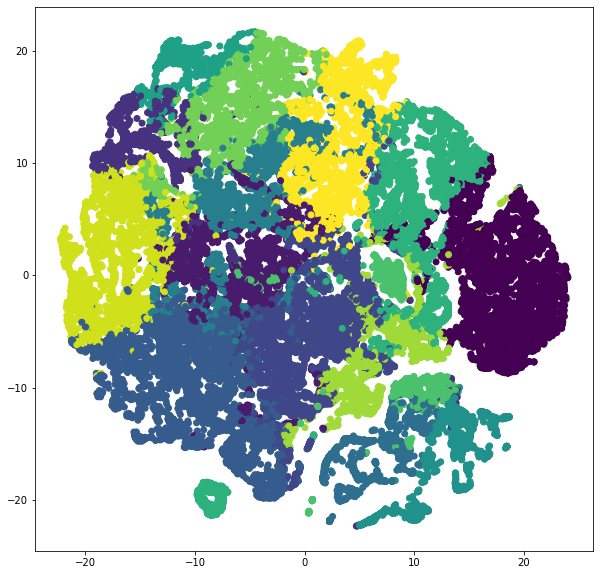

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(reac_2d_embedded[:, 0], reac_2d_embedded[:, 1], c=km_reac)
plt.show()

In [24]:
from scipy.spatial.distance import cosine

In [25]:
from IPython.display import display

In [26]:
def show_k_reactants(dataset, norms, indexes,):
    keys = list(dataset.keys())
    for idx in indexes:
        print(keys[idx])
        print(norms[idx])
        p, r = draw_gt_reaction(dataset[keys[idx]])
        display(SVG(p))
        display(SVG(r))

New center
10955
0.13221958


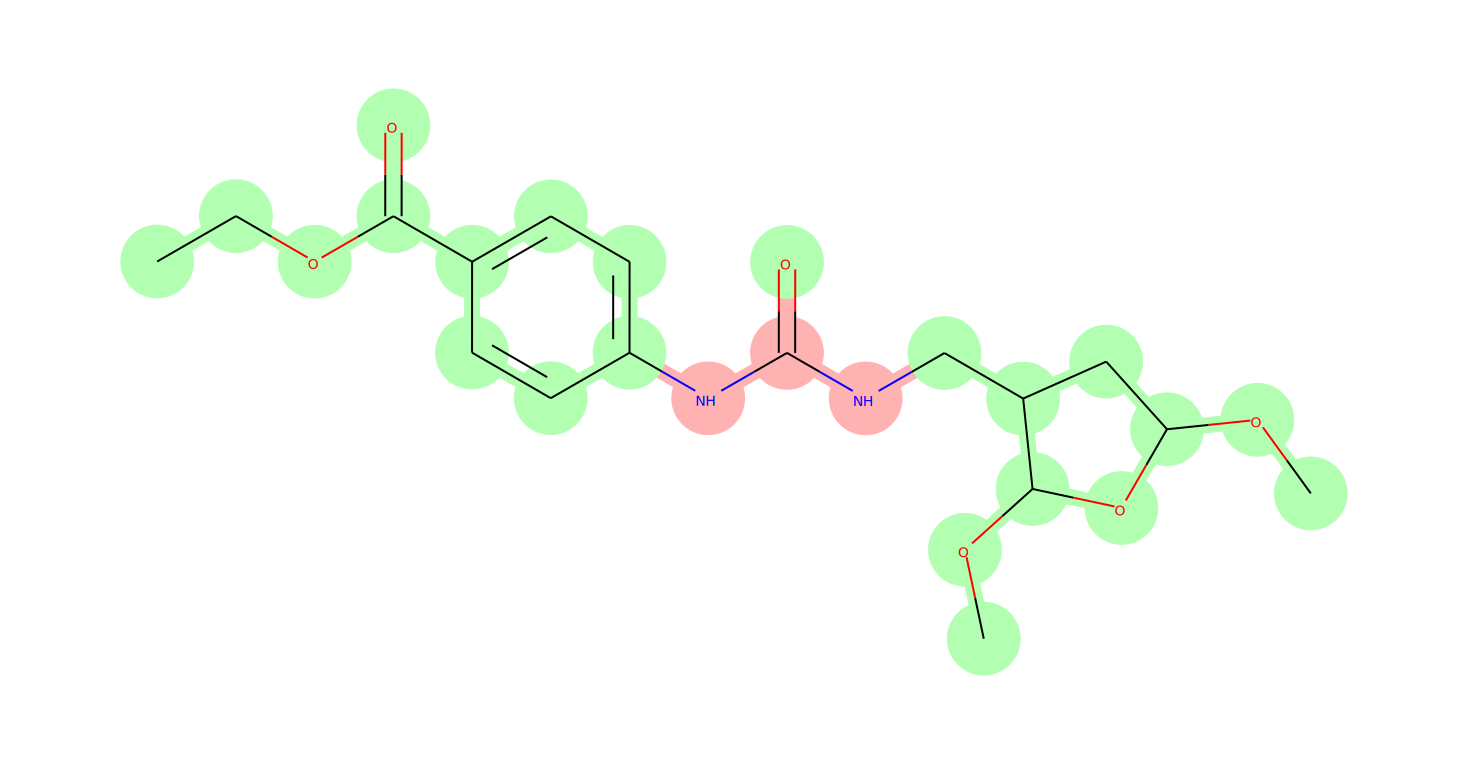

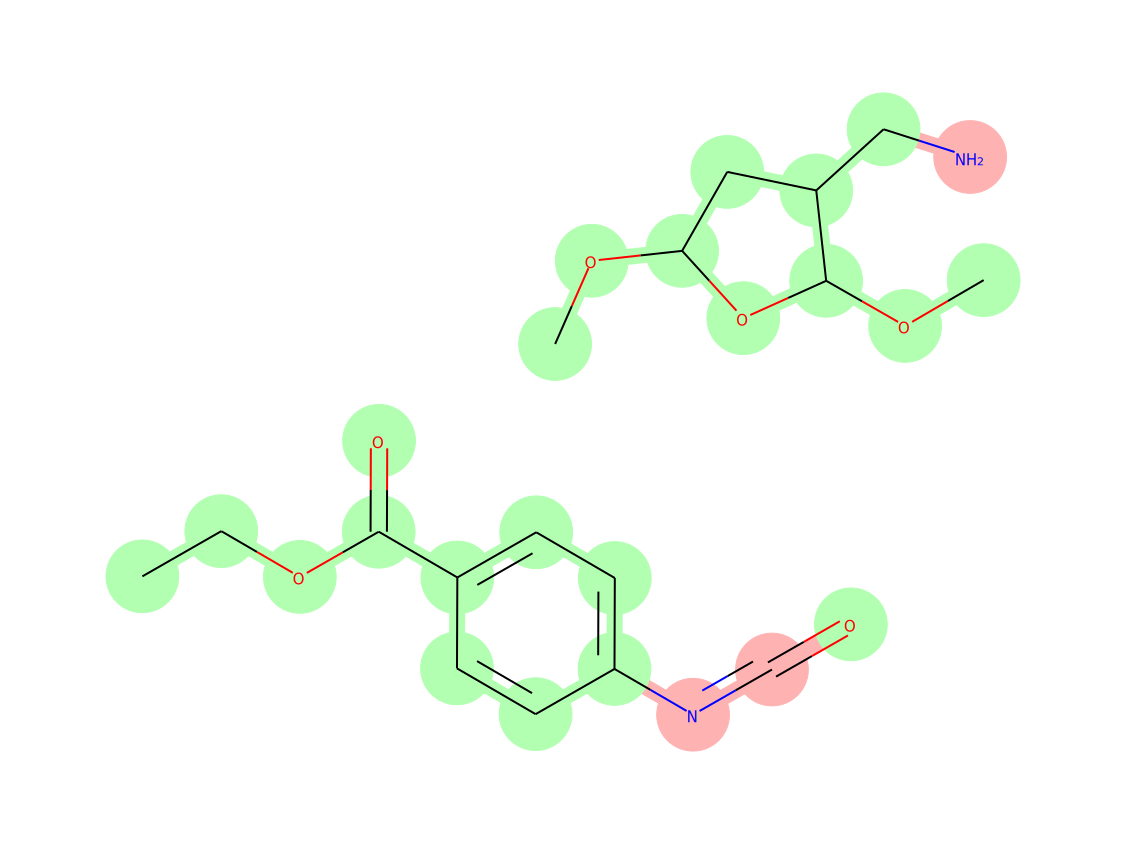

26984
0.1686592


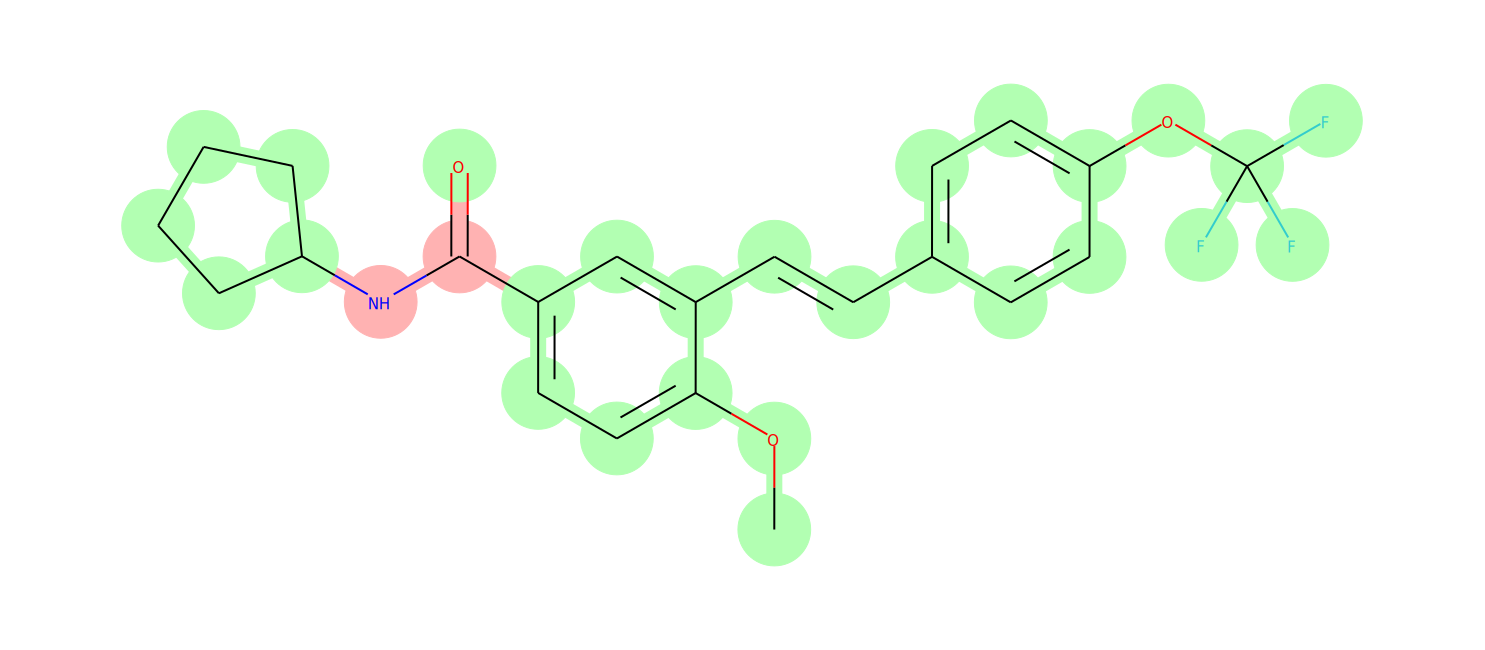

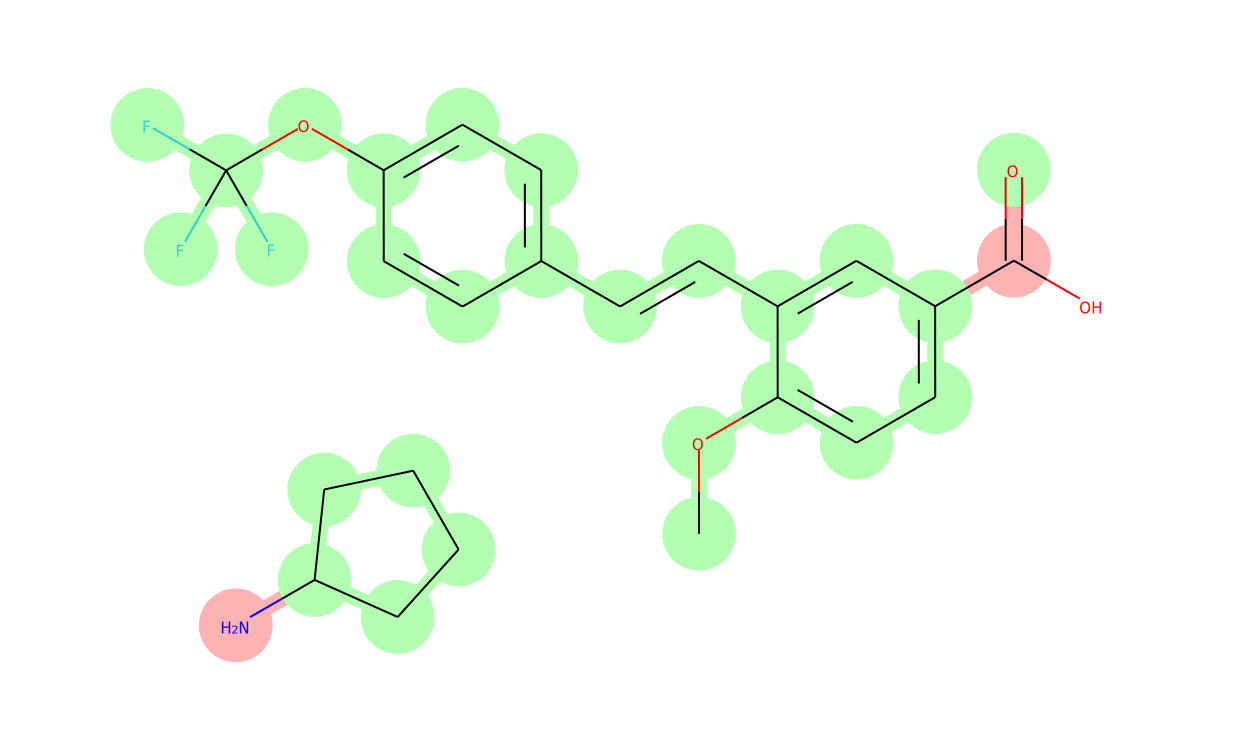

39044
0.17386799


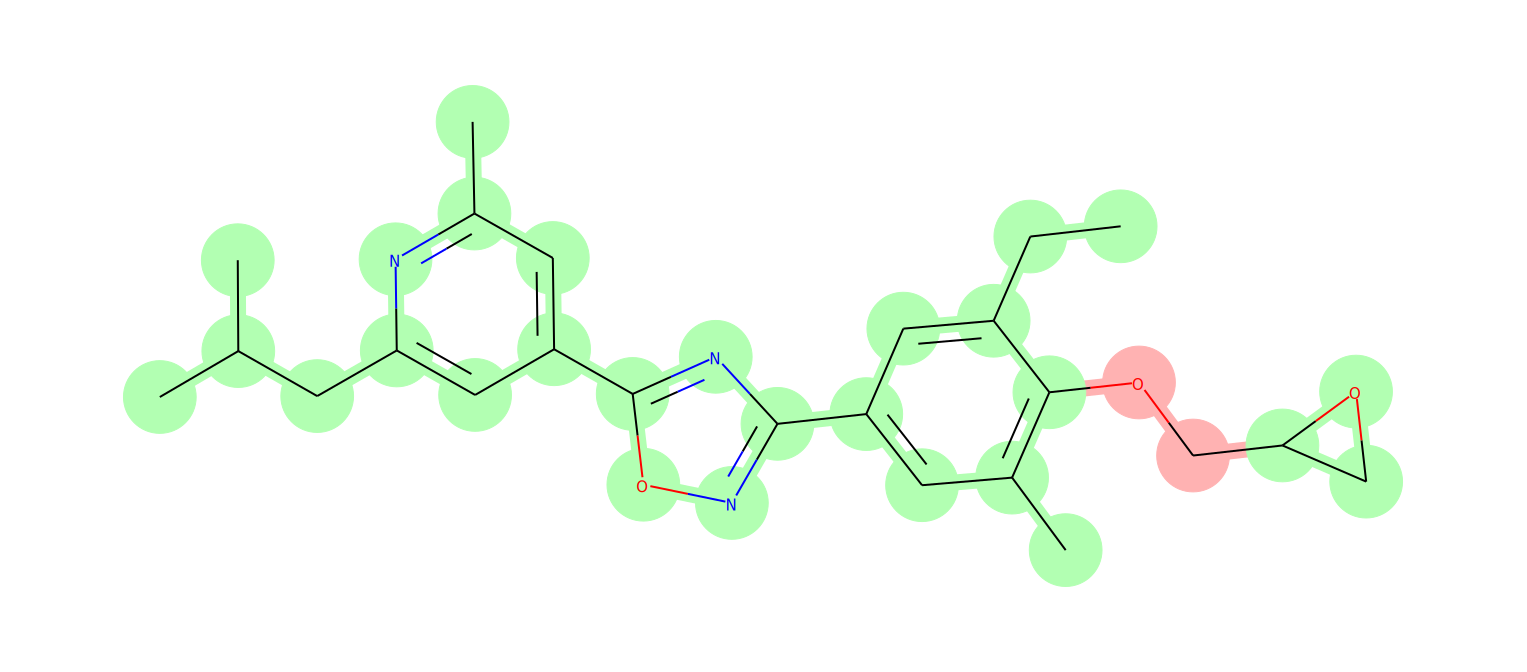

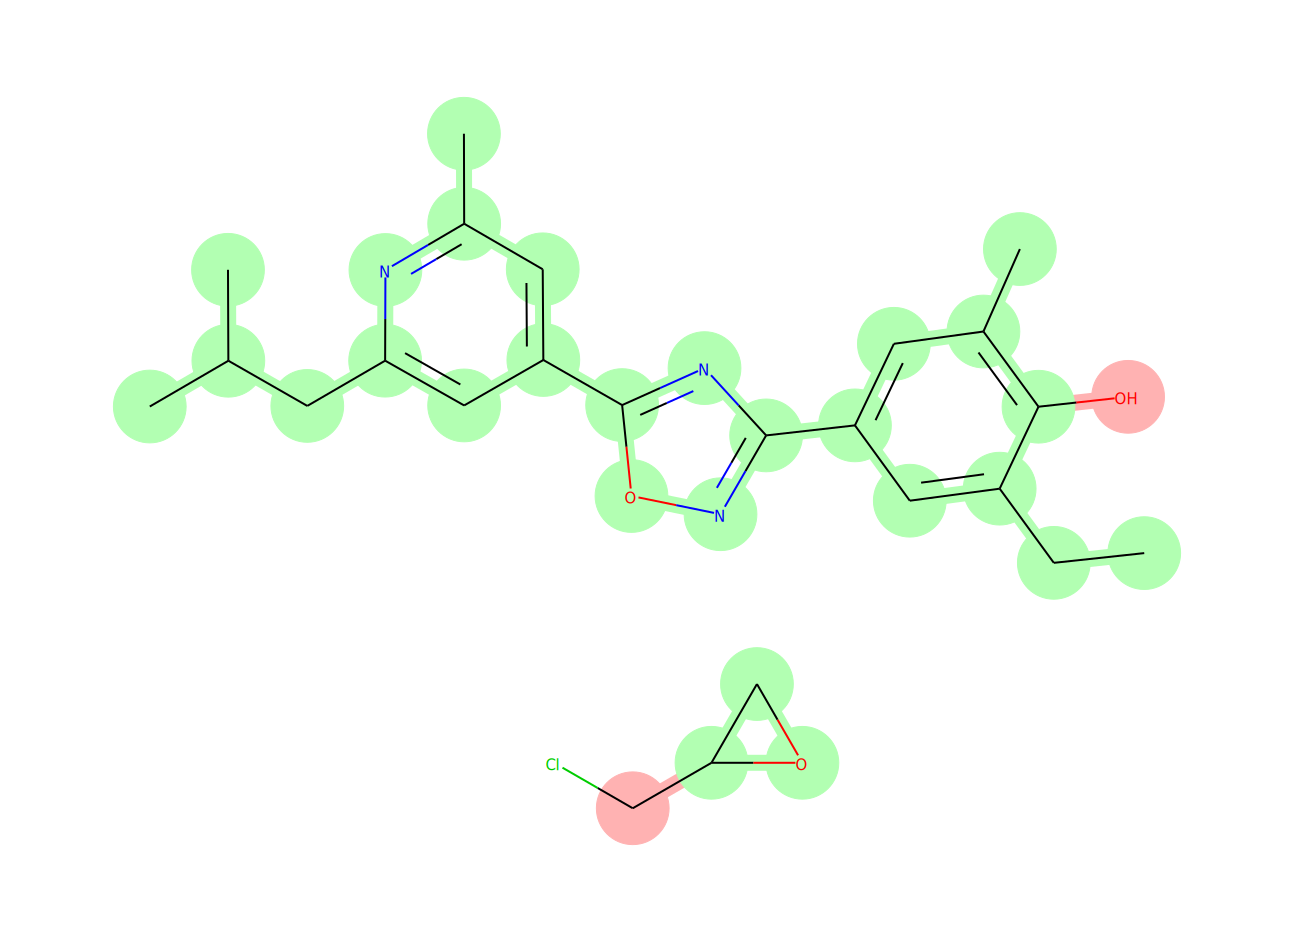

17378
0.25625995


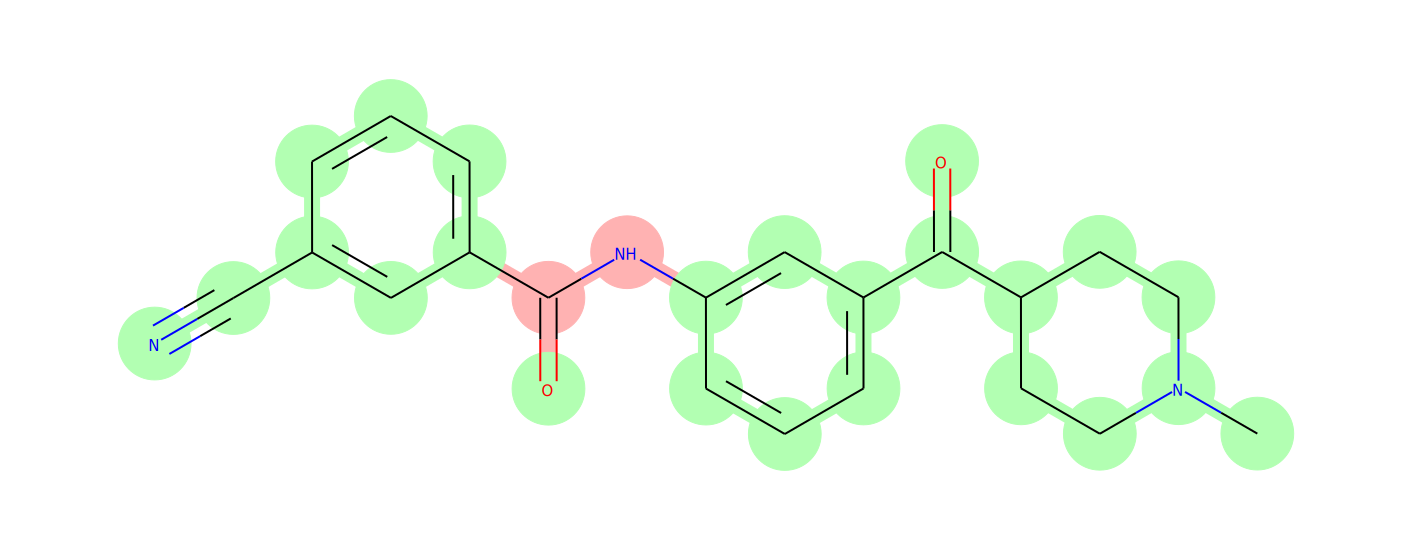

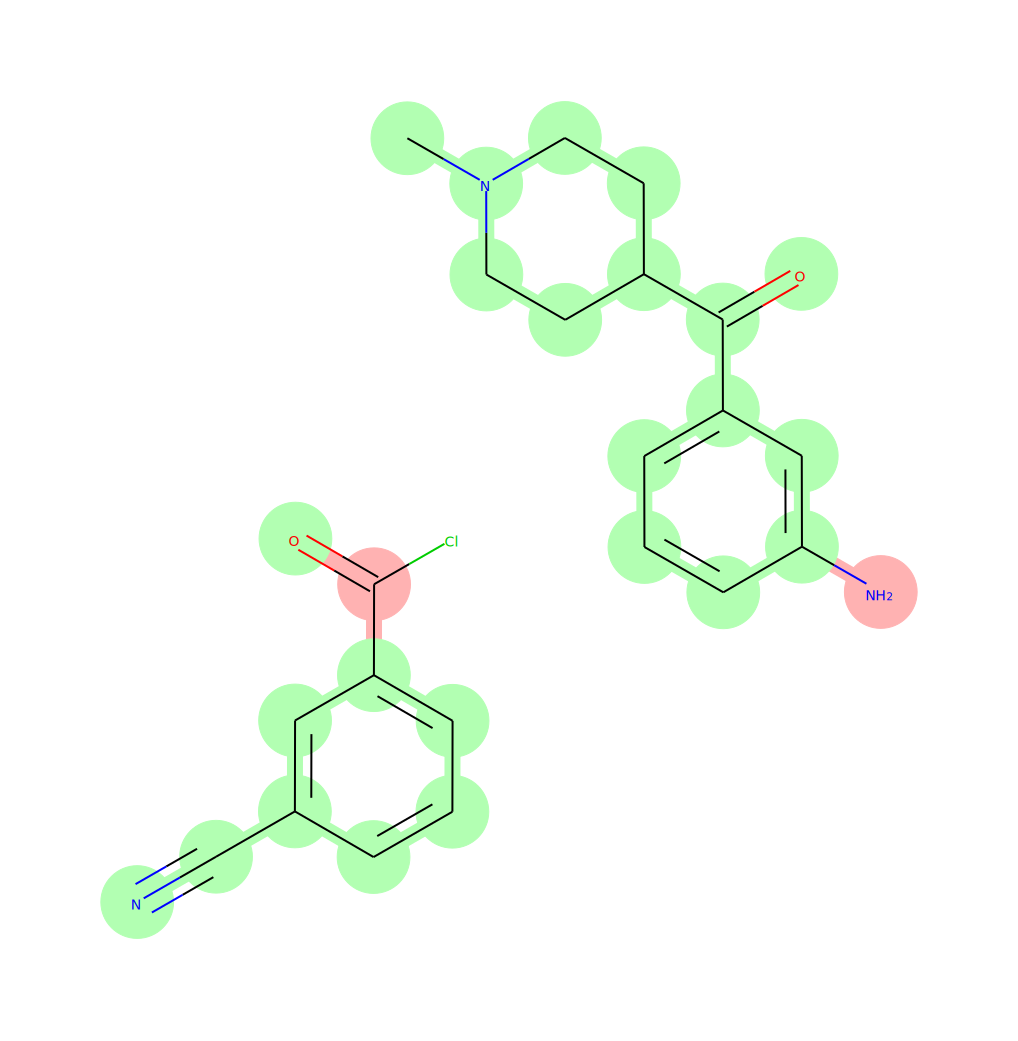

17550
2.7020965


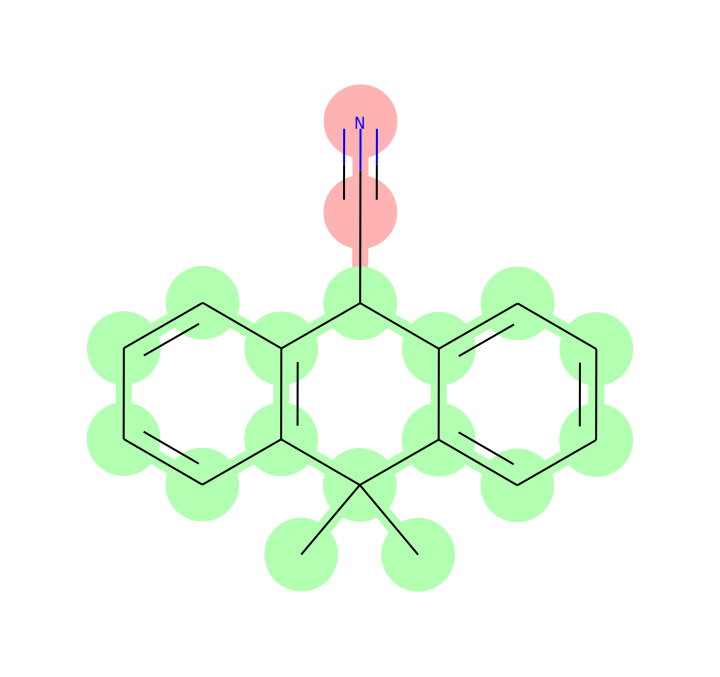

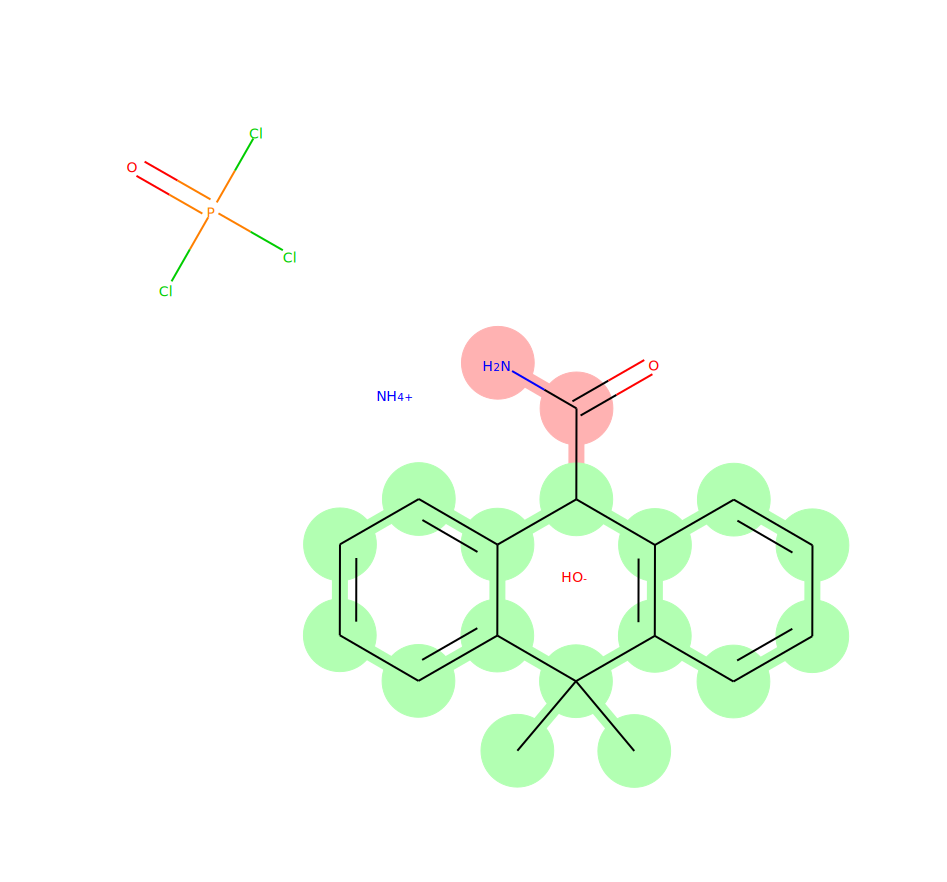

New center
40824
0.35318077


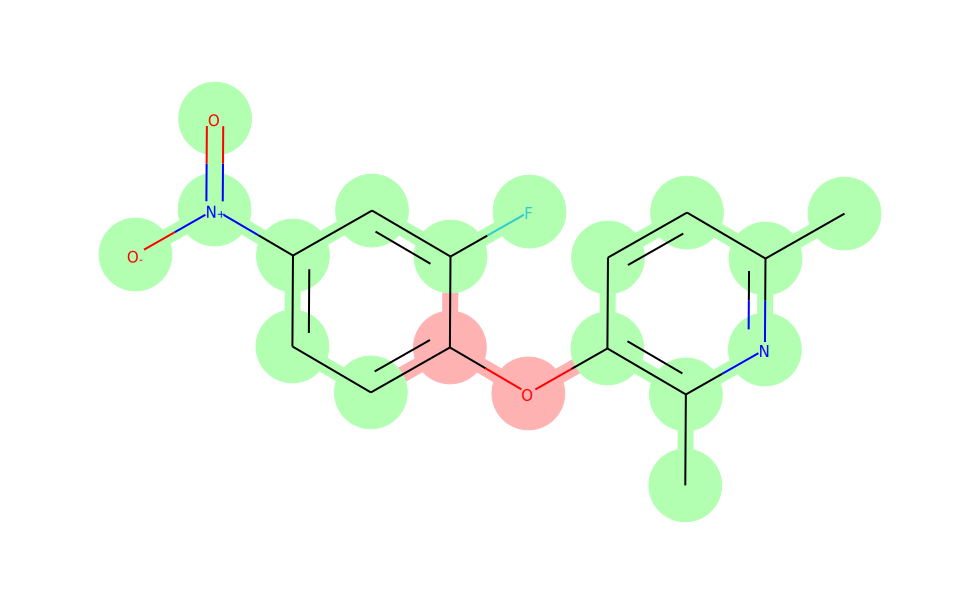

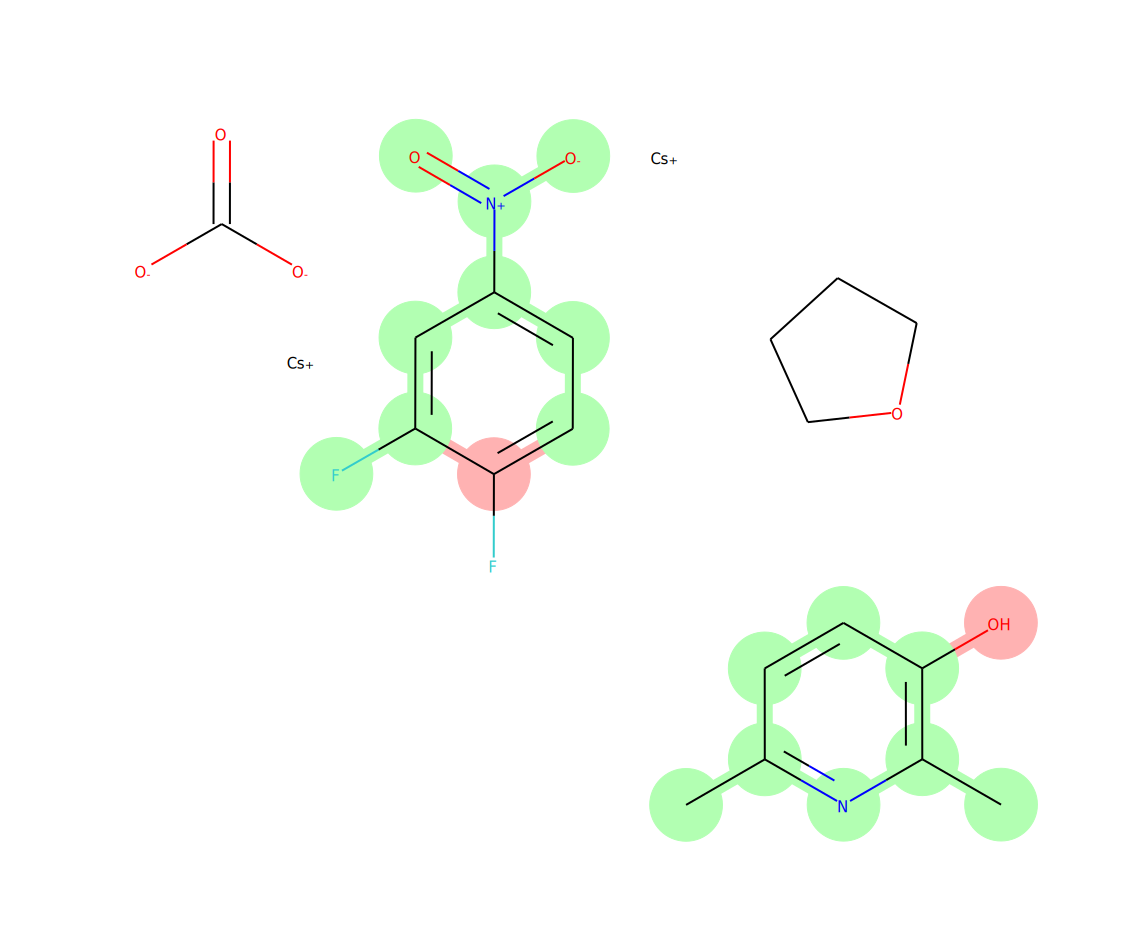

26435
0.3625409


RDKit WARNING: [00:39:19] WARNING: not removing hydrogen atom without neighbors


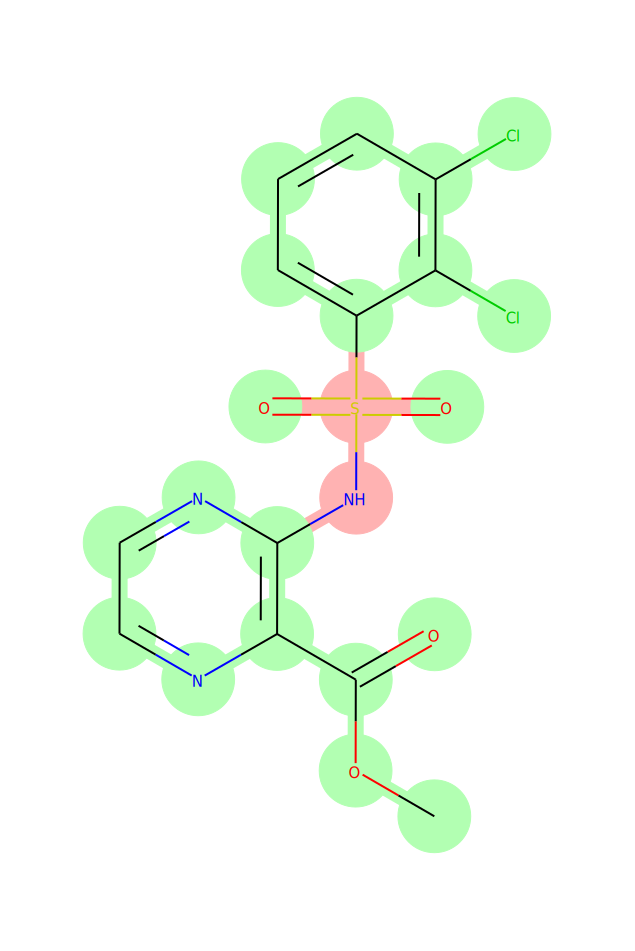

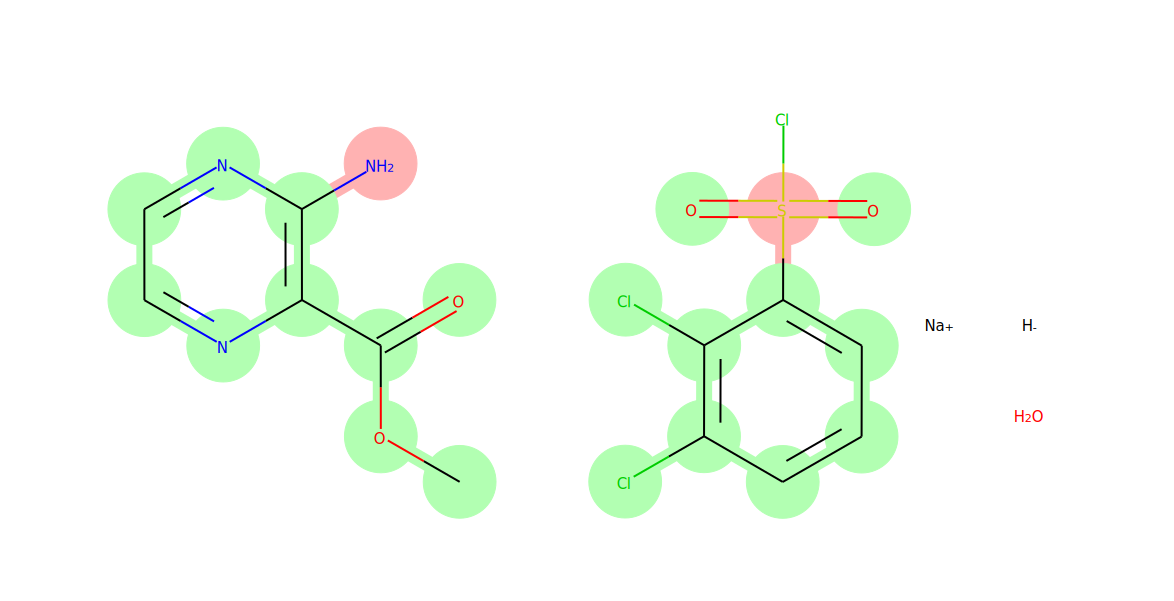

11357
0.3627244


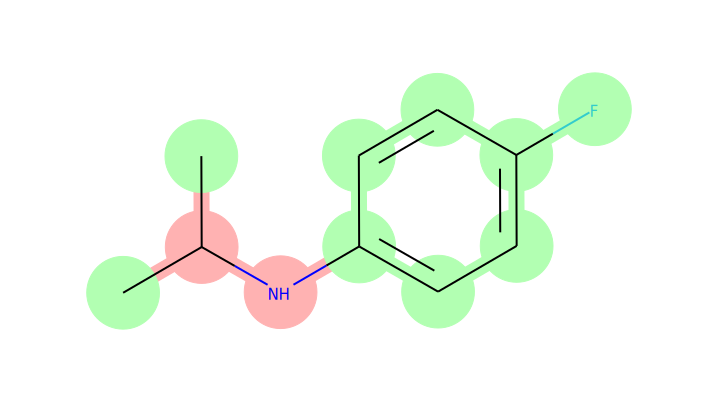

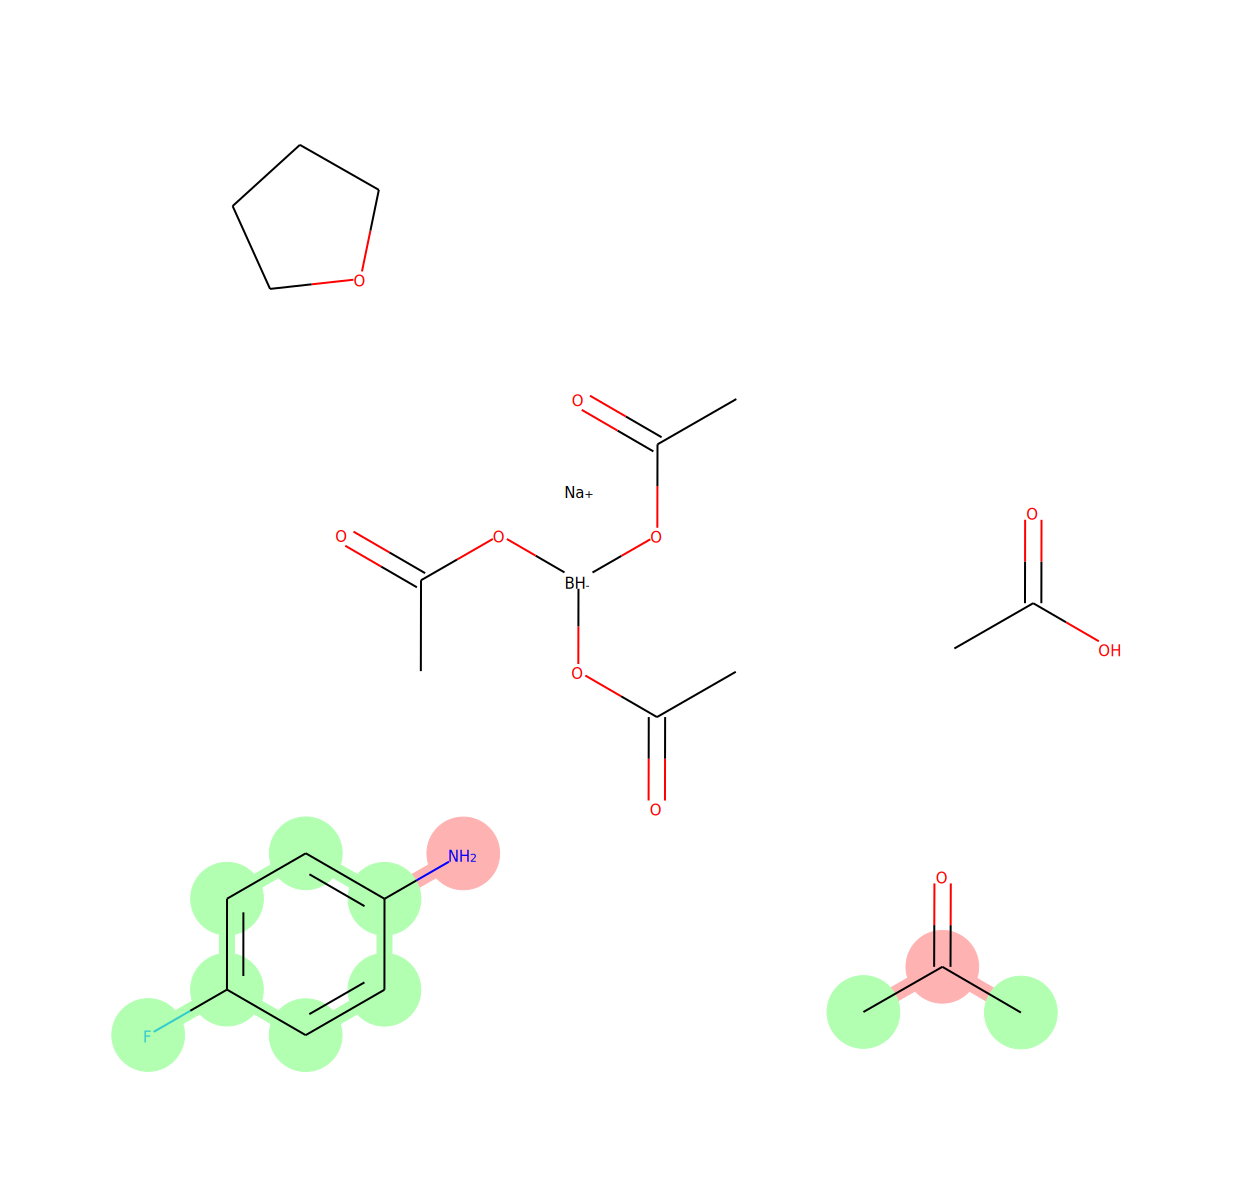

5783
0.553877


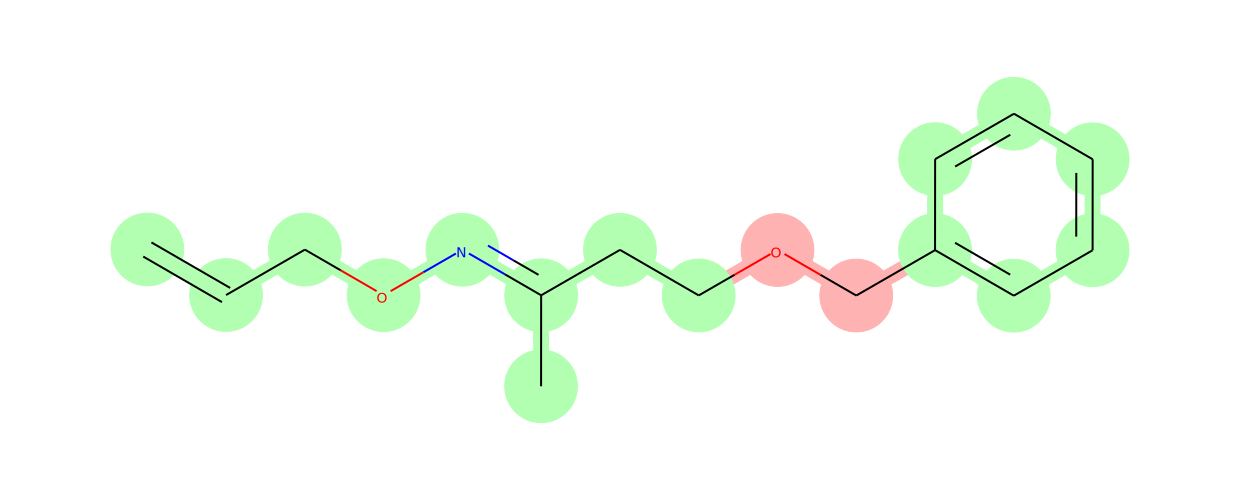

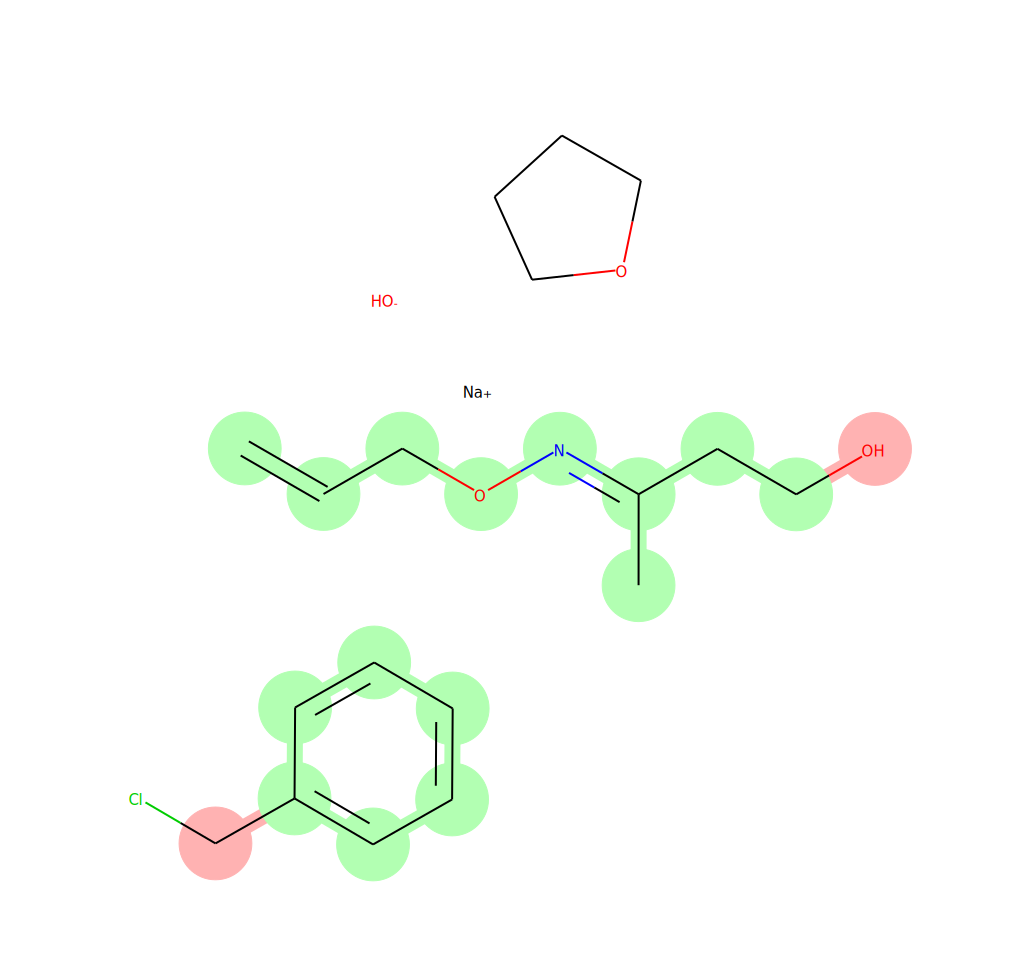

2810
2.0466762


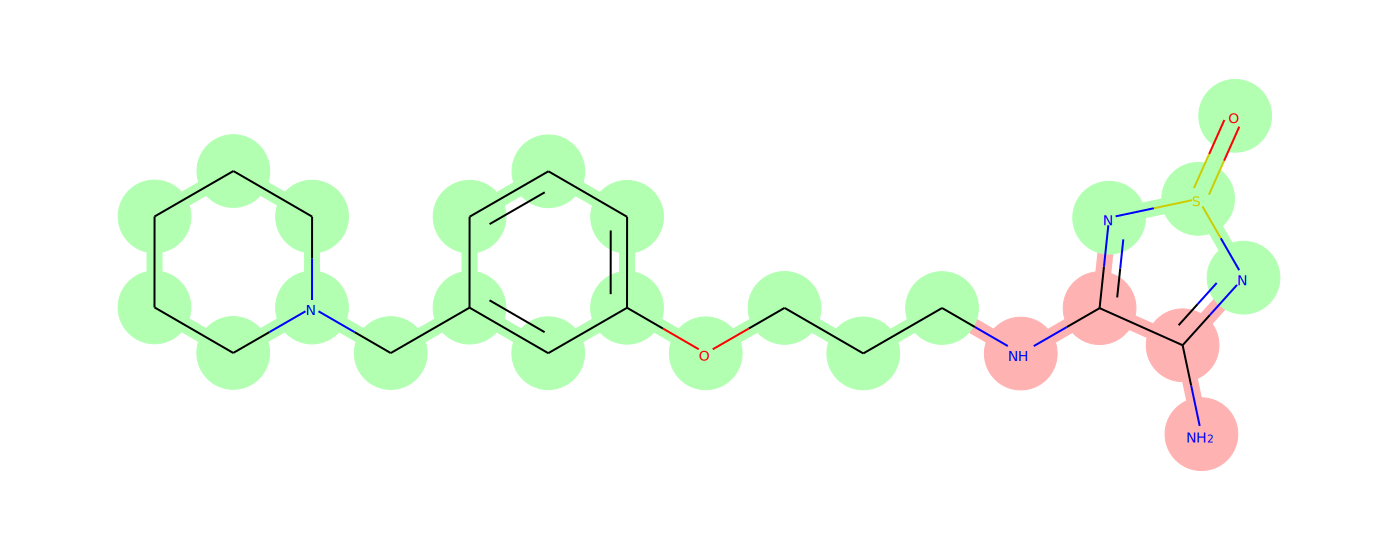

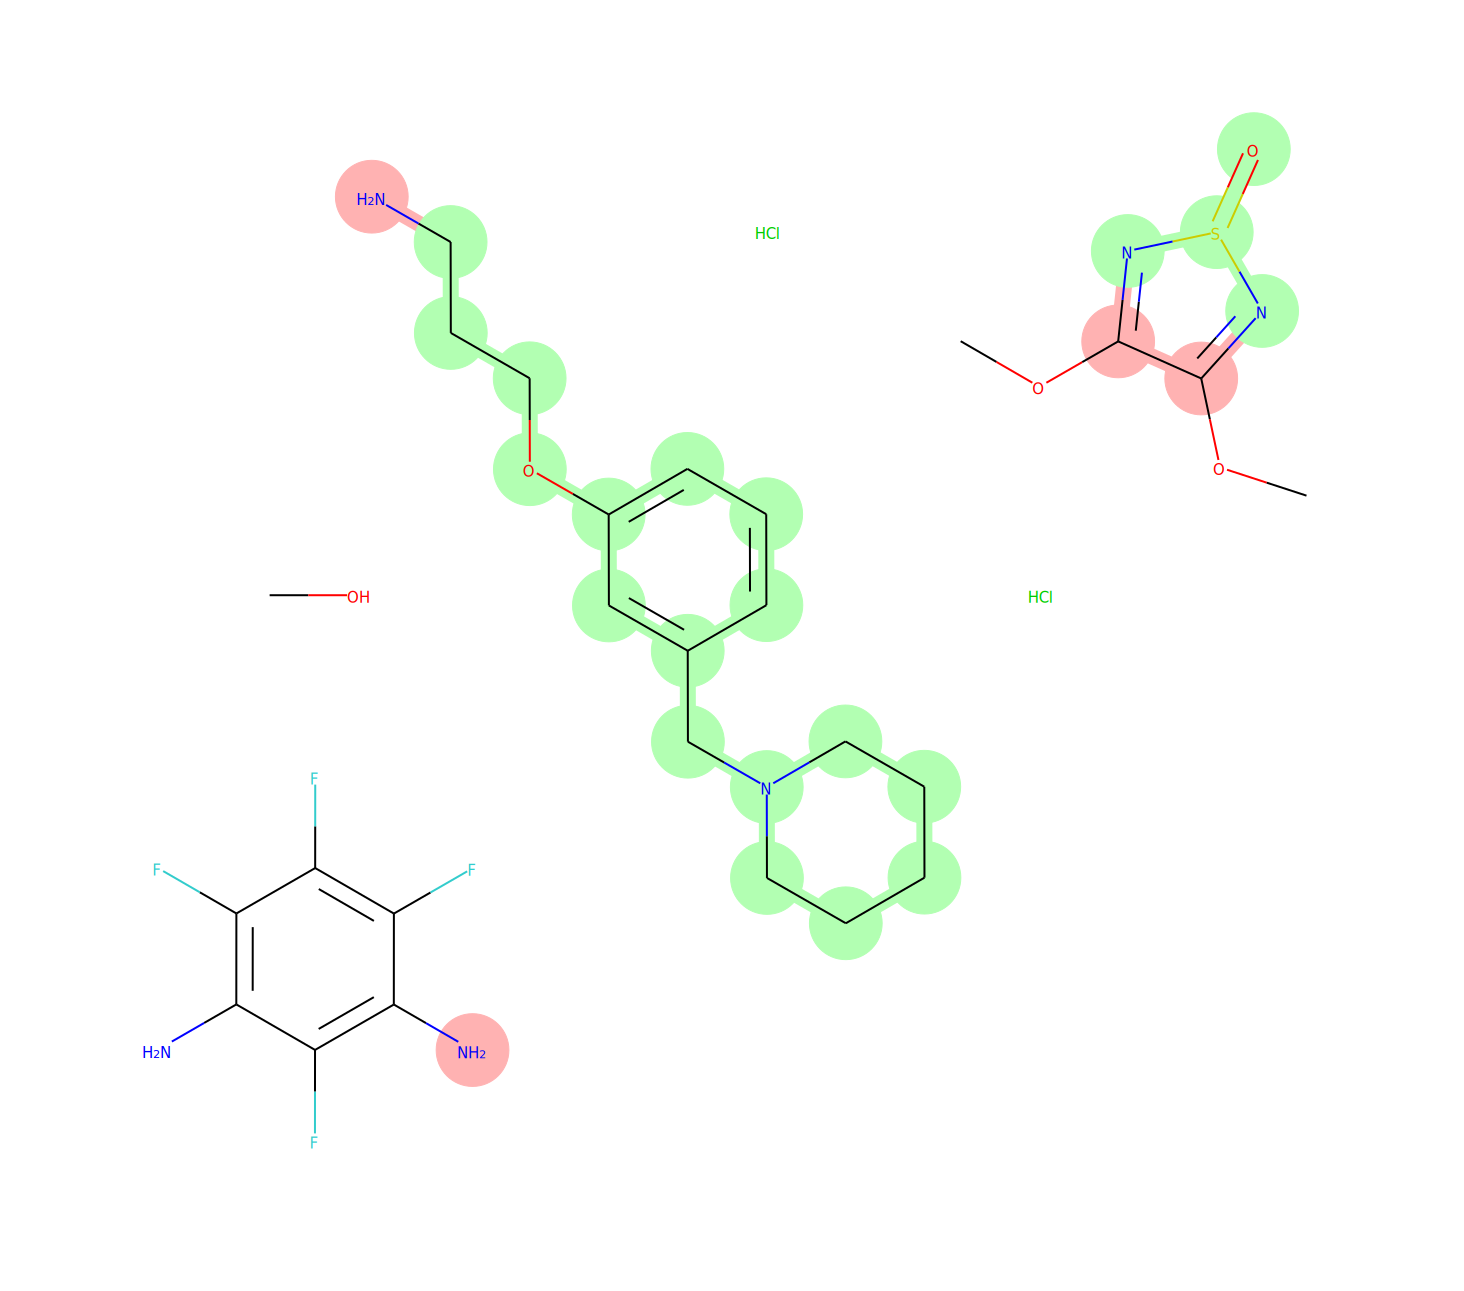

New center
46986
0.3355719


RDKit WARNING: [00:39:20] WARNING: not removing hydrogen atom without neighbors


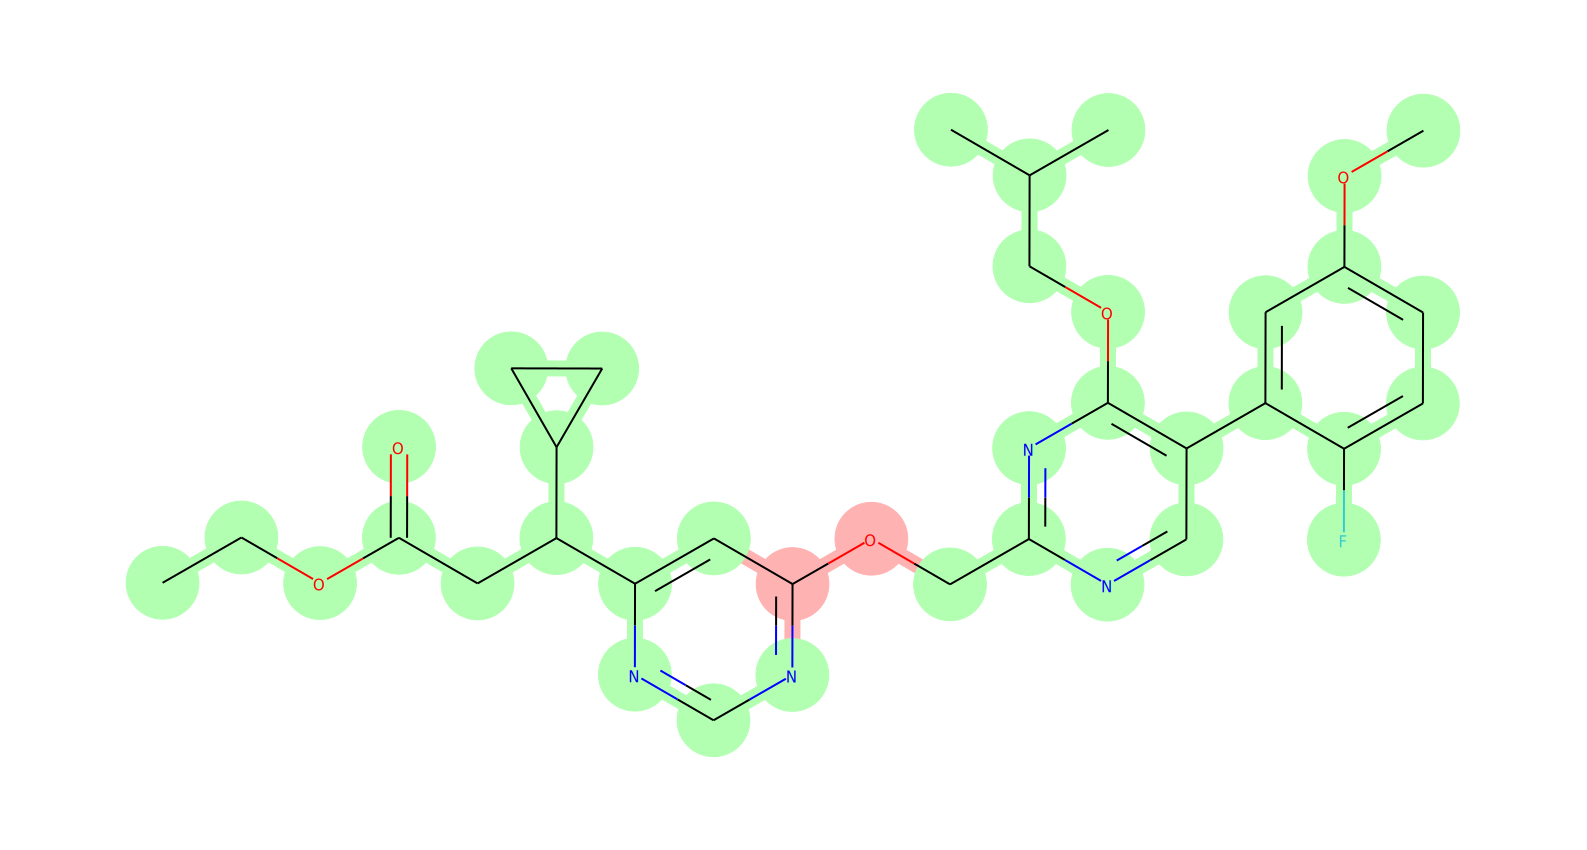

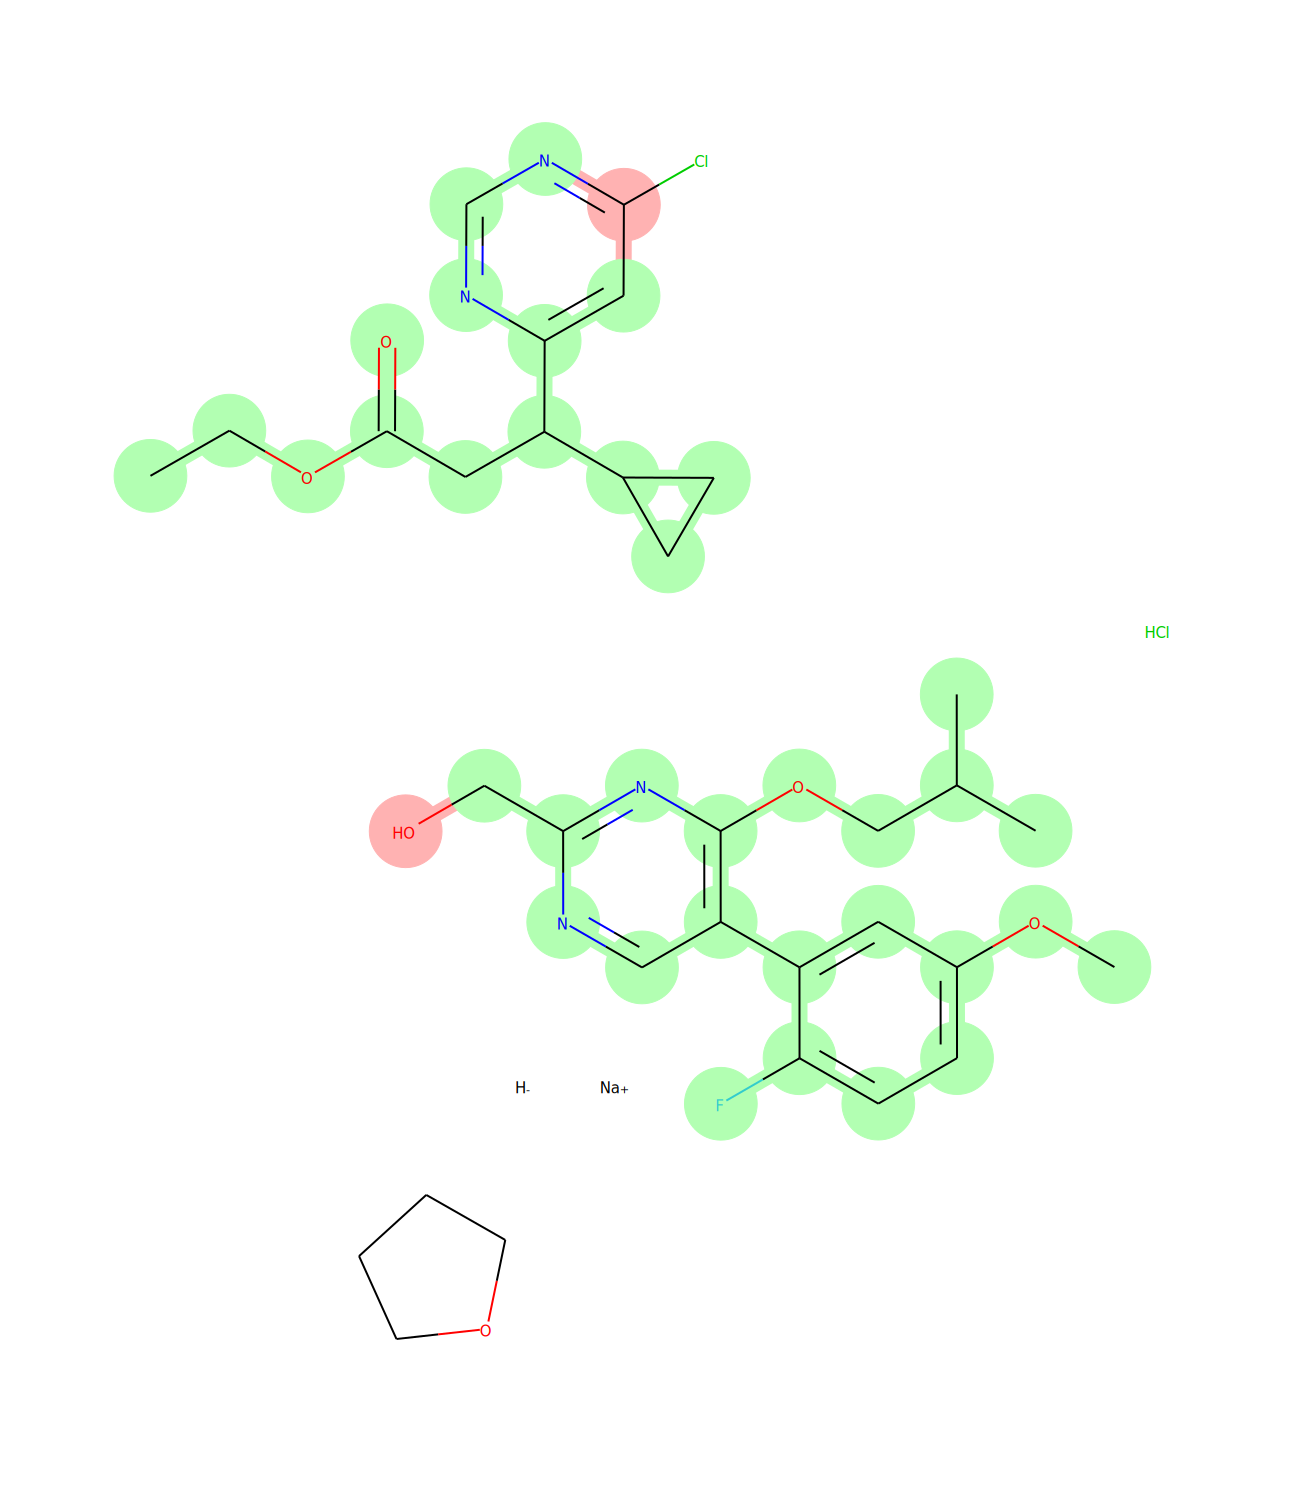

46982
0.3618134


RDKit WARNING: [00:39:20] WARNING: not removing hydrogen atom without neighbors


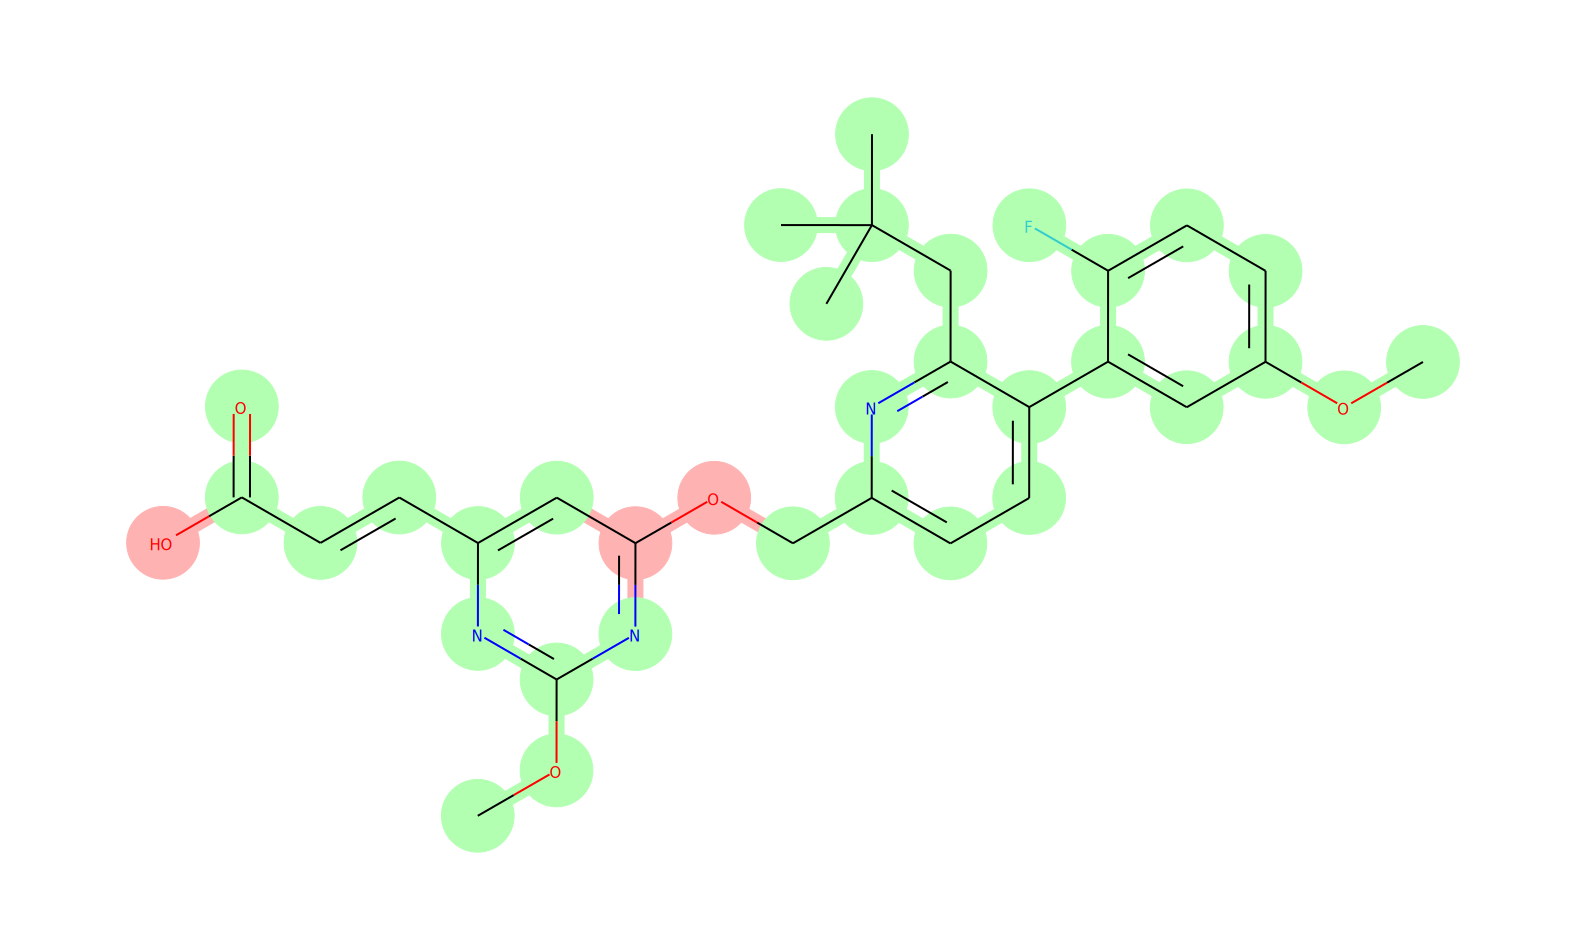

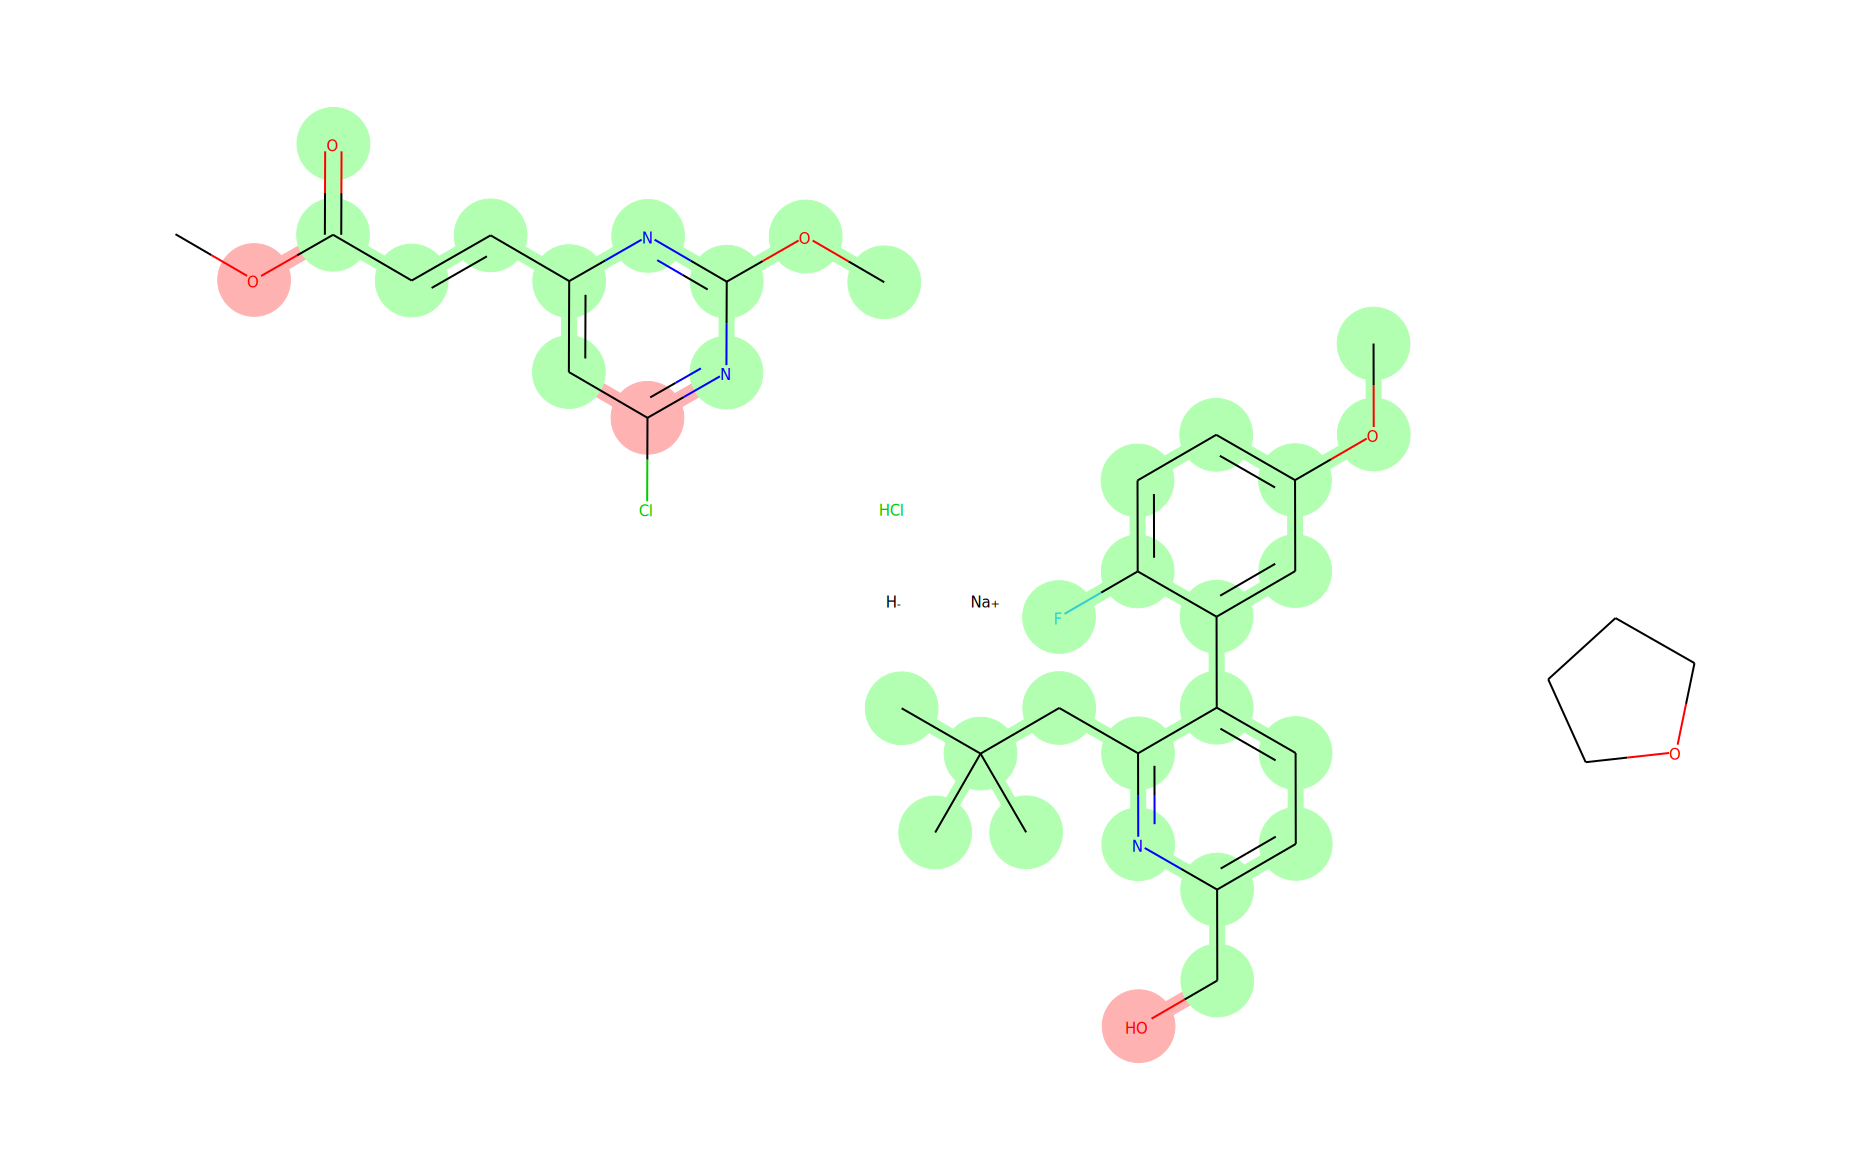

15733
0.390385


RDKit WARNING: [00:39:20] WARNING: not removing hydrogen atom without neighbors


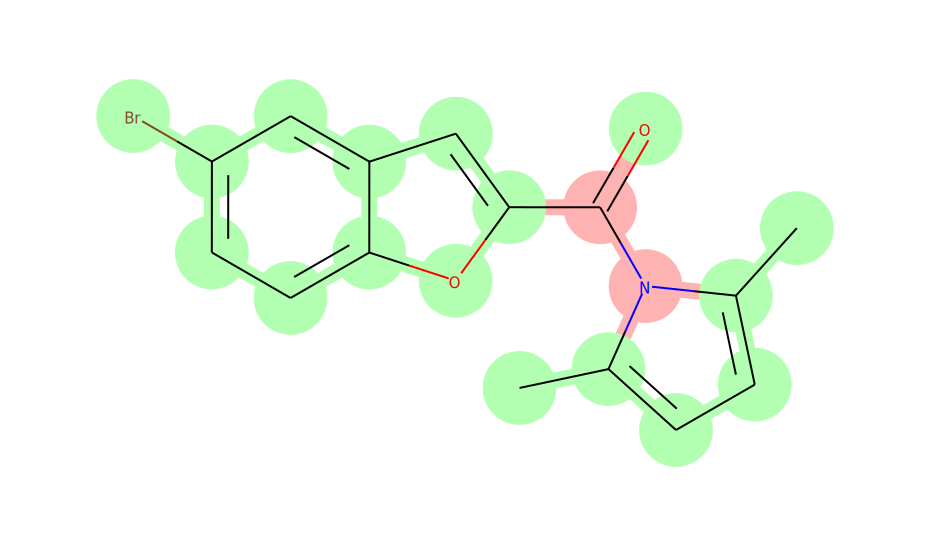

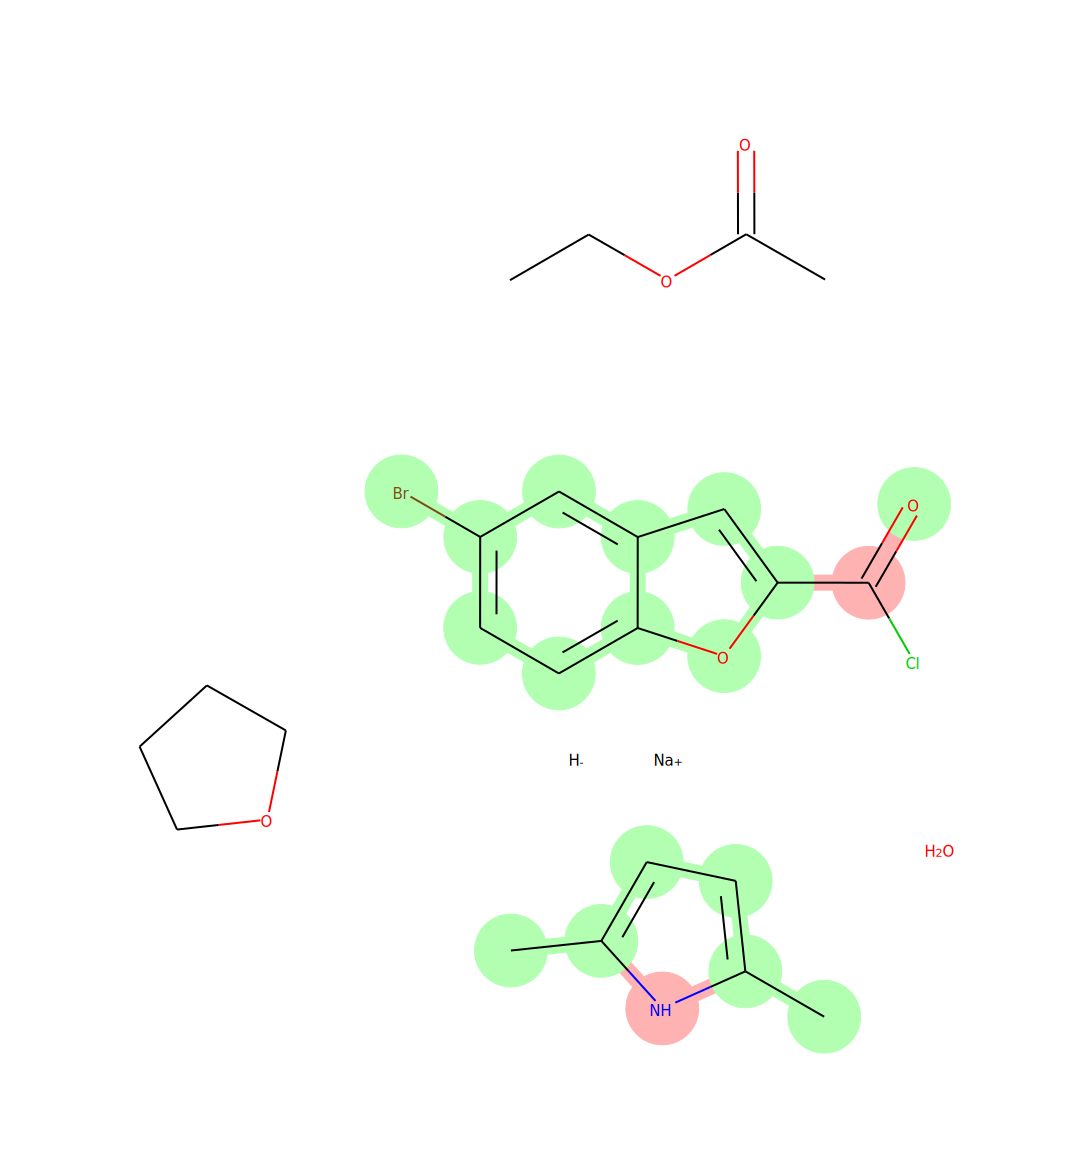

47160
0.64638245


RDKit WARNING: [00:39:20] WARNING: not removing hydrogen atom without neighbors


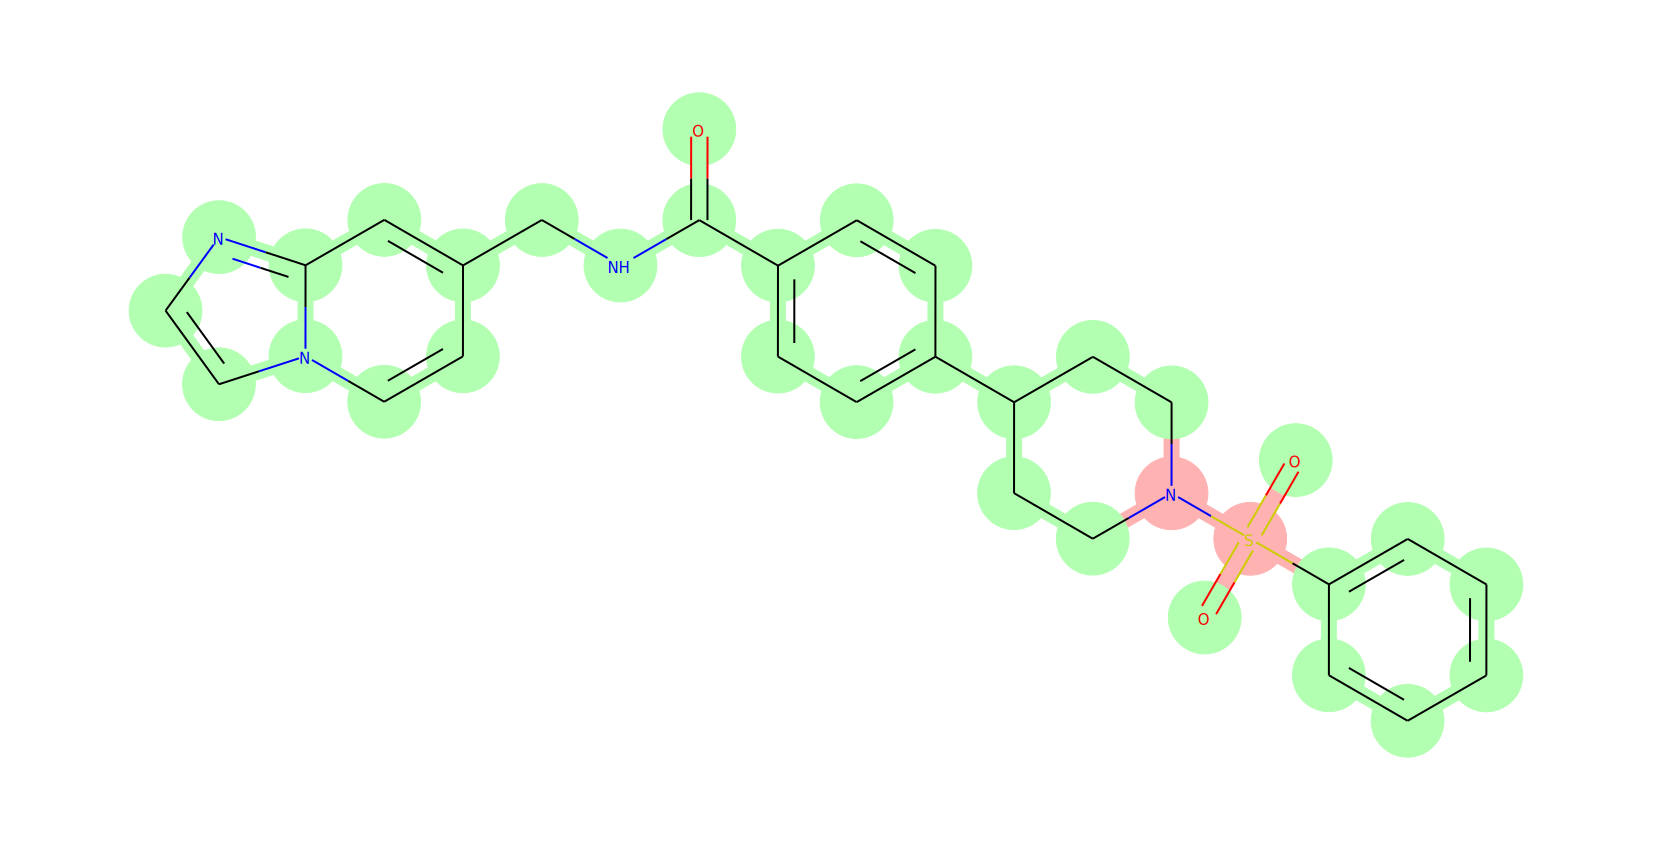

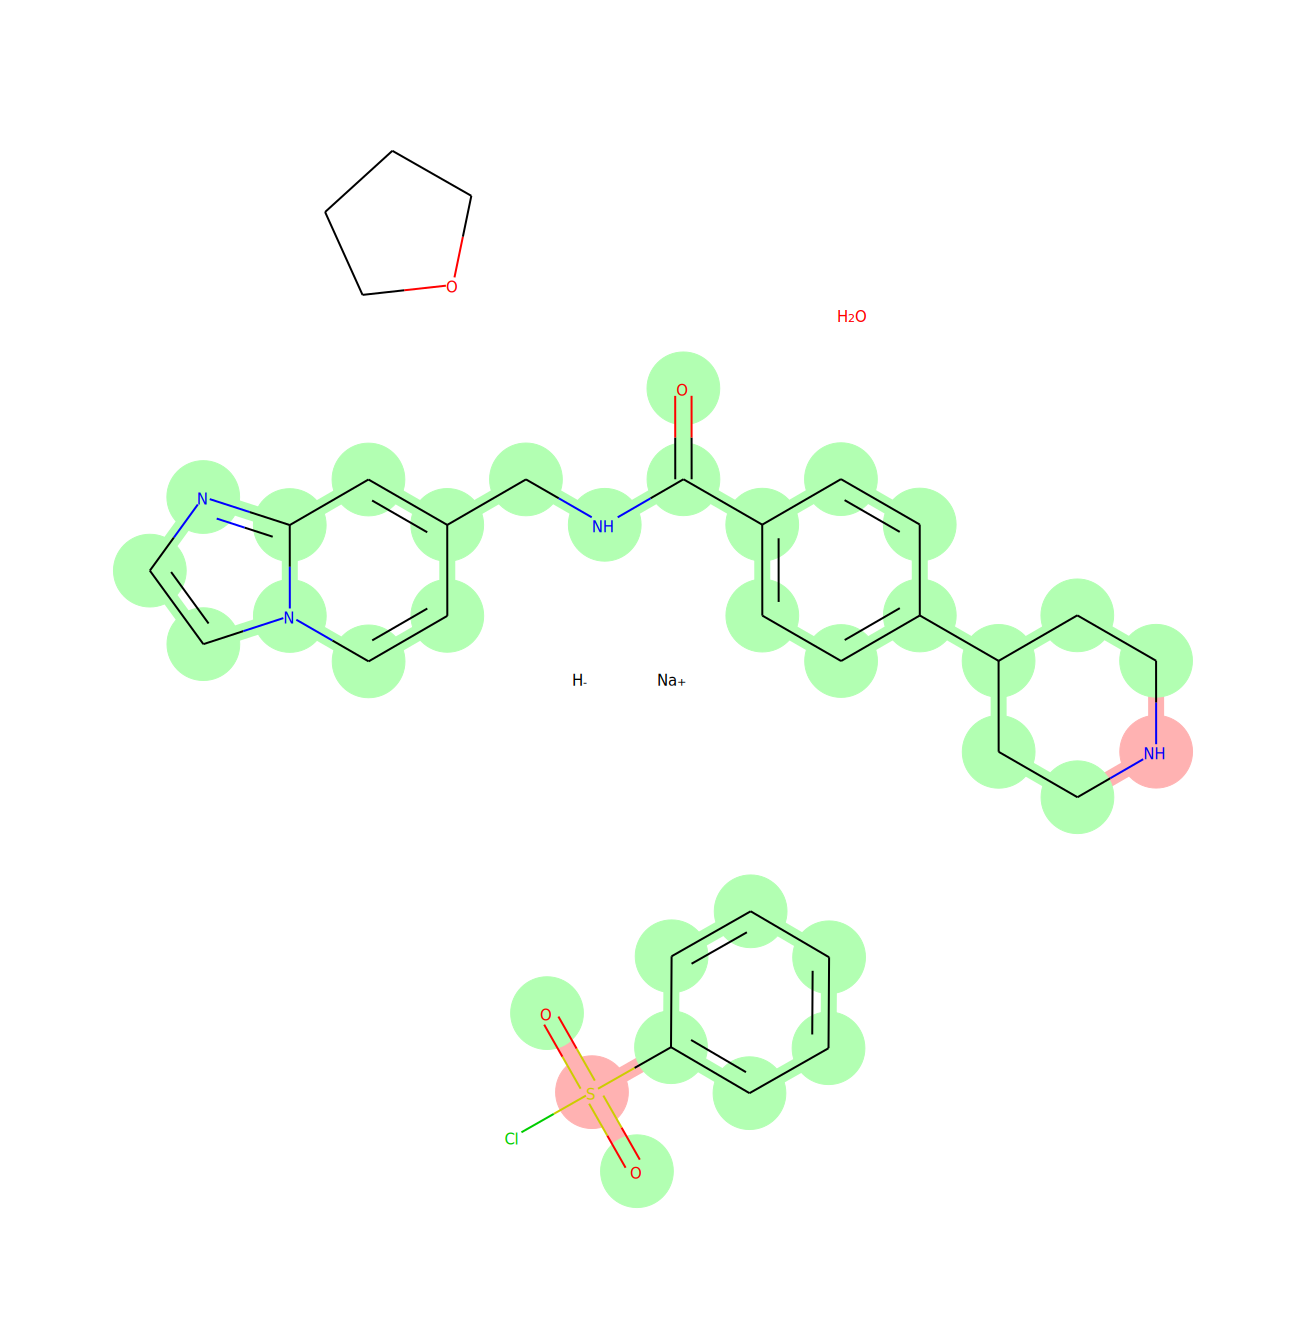

1552
3.0918117


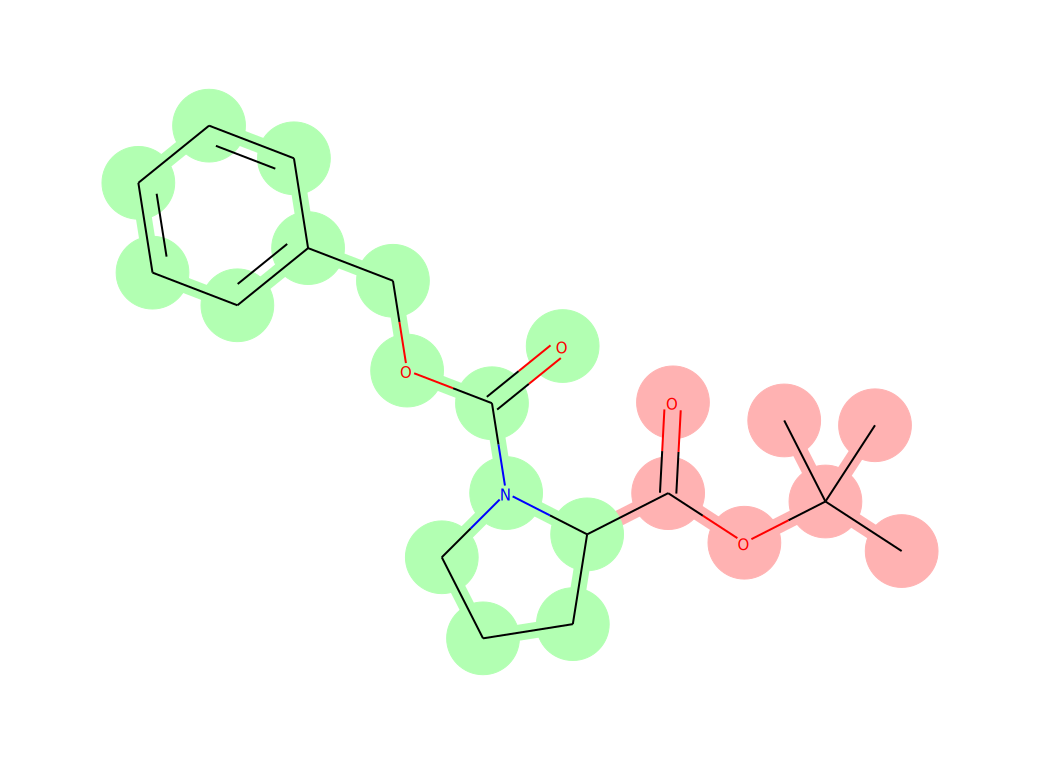

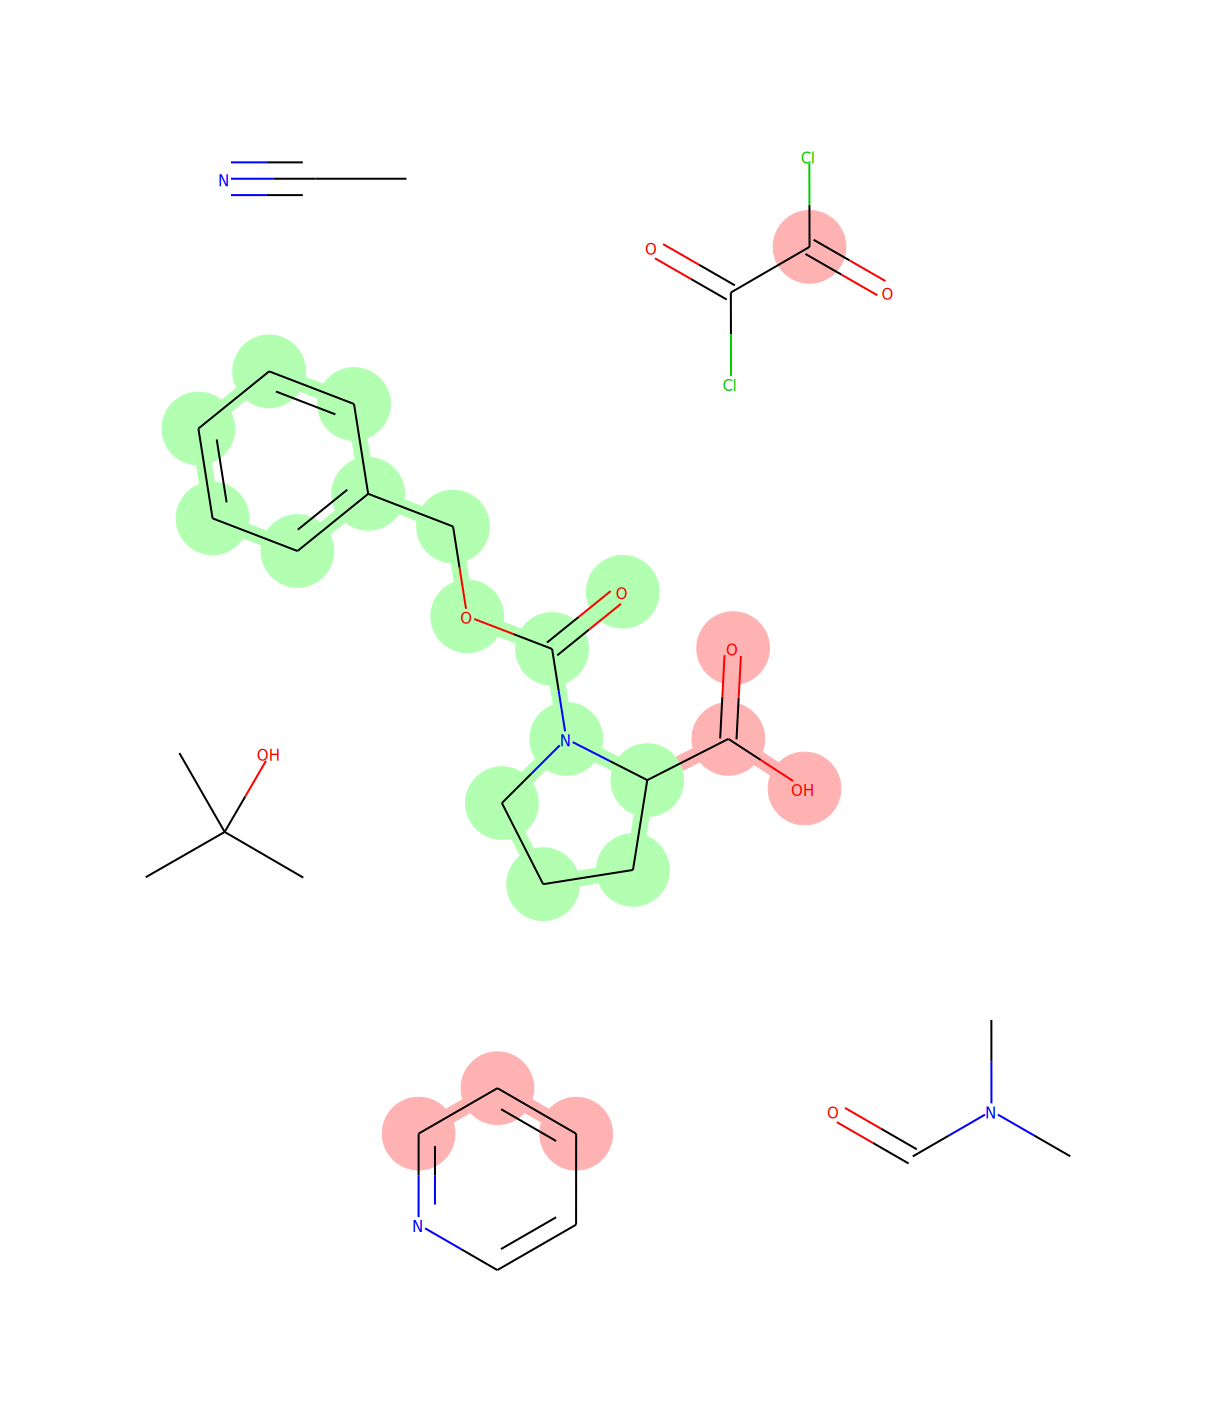

New center
45663
0.31735346


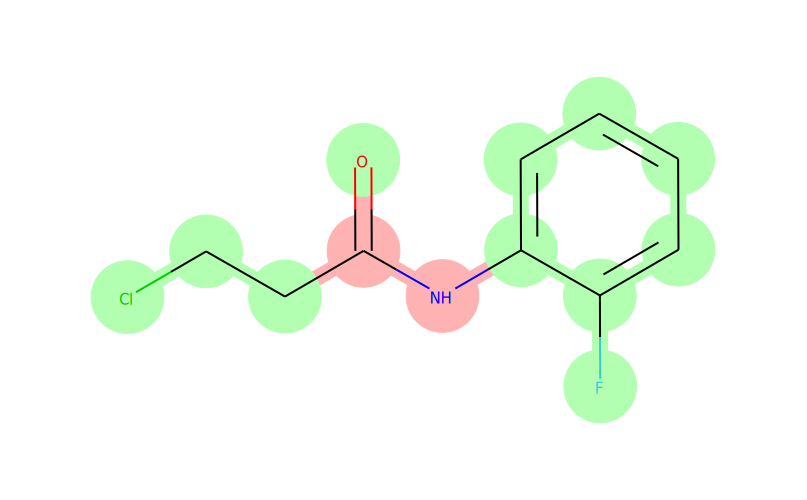

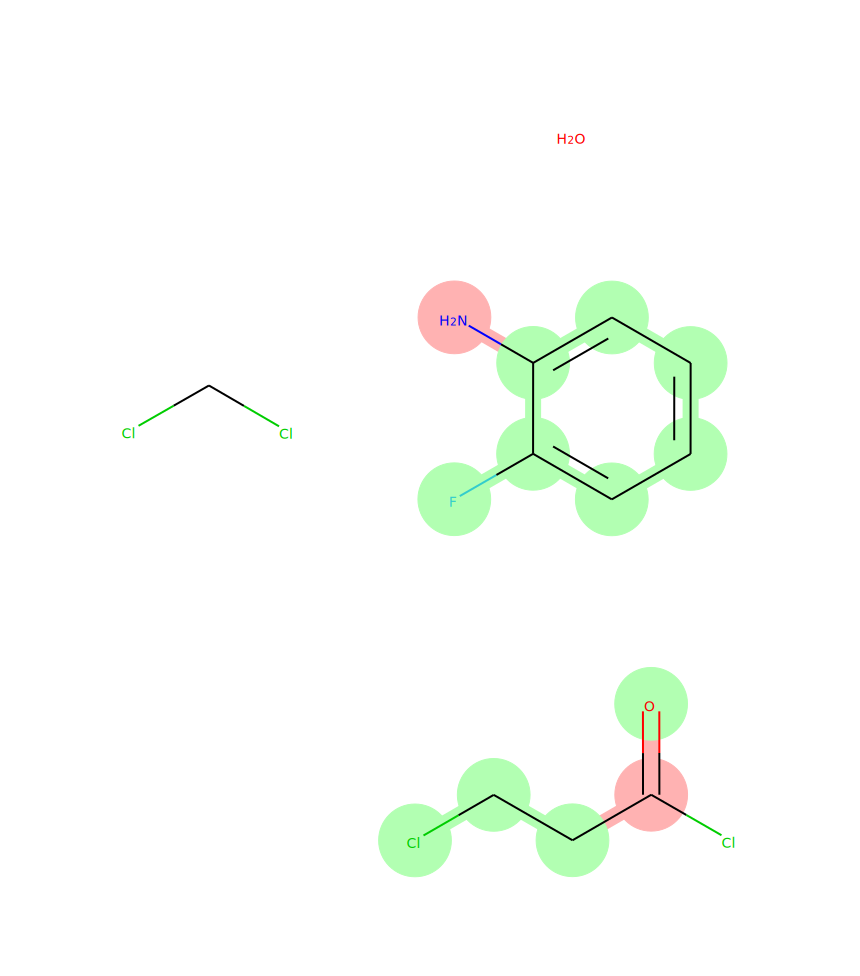

17501
0.31750542


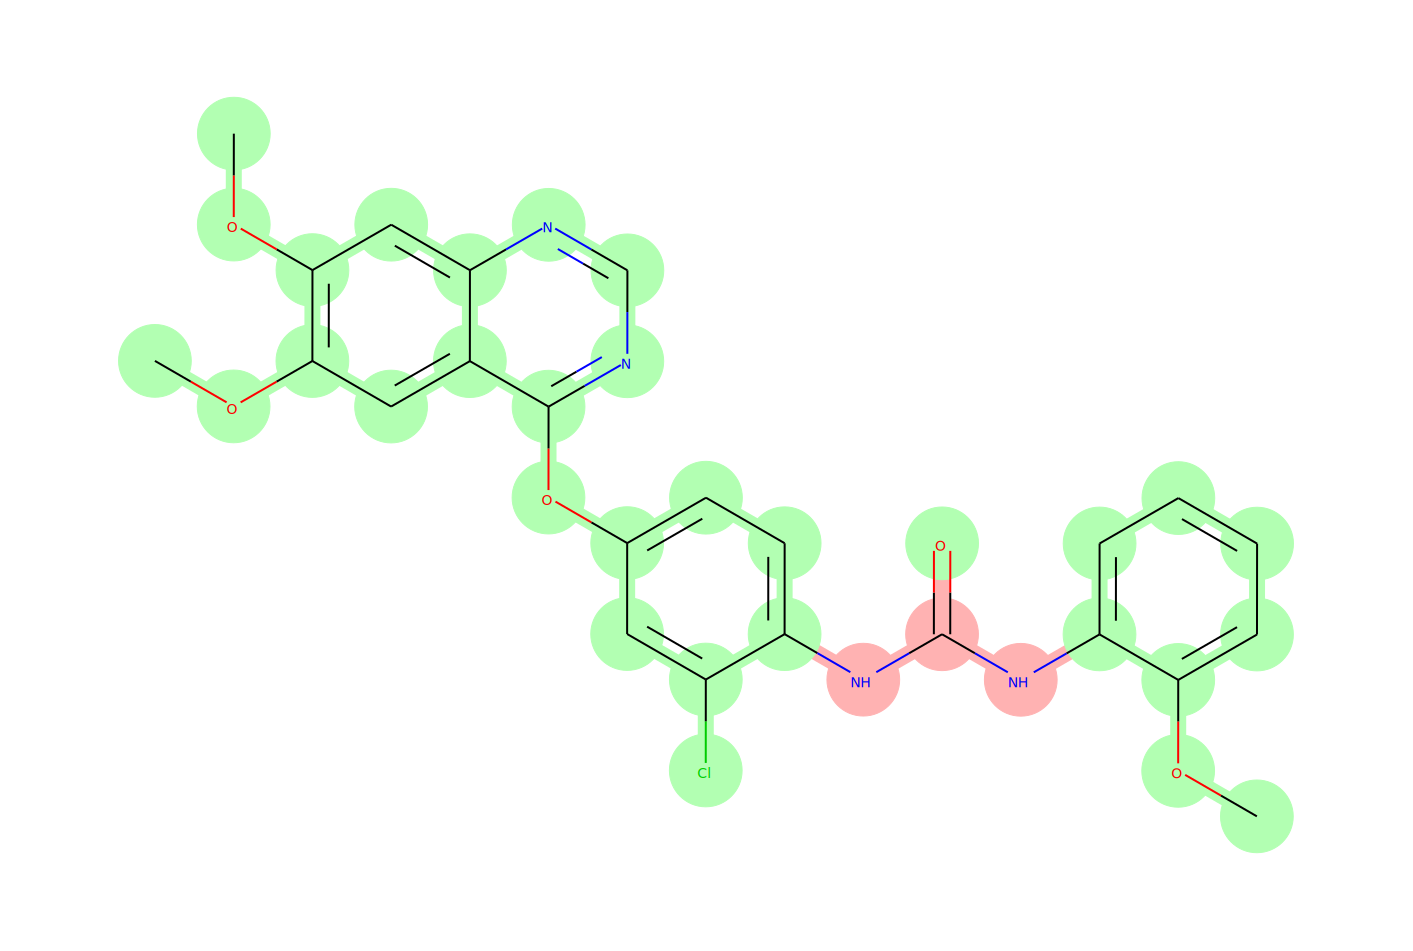

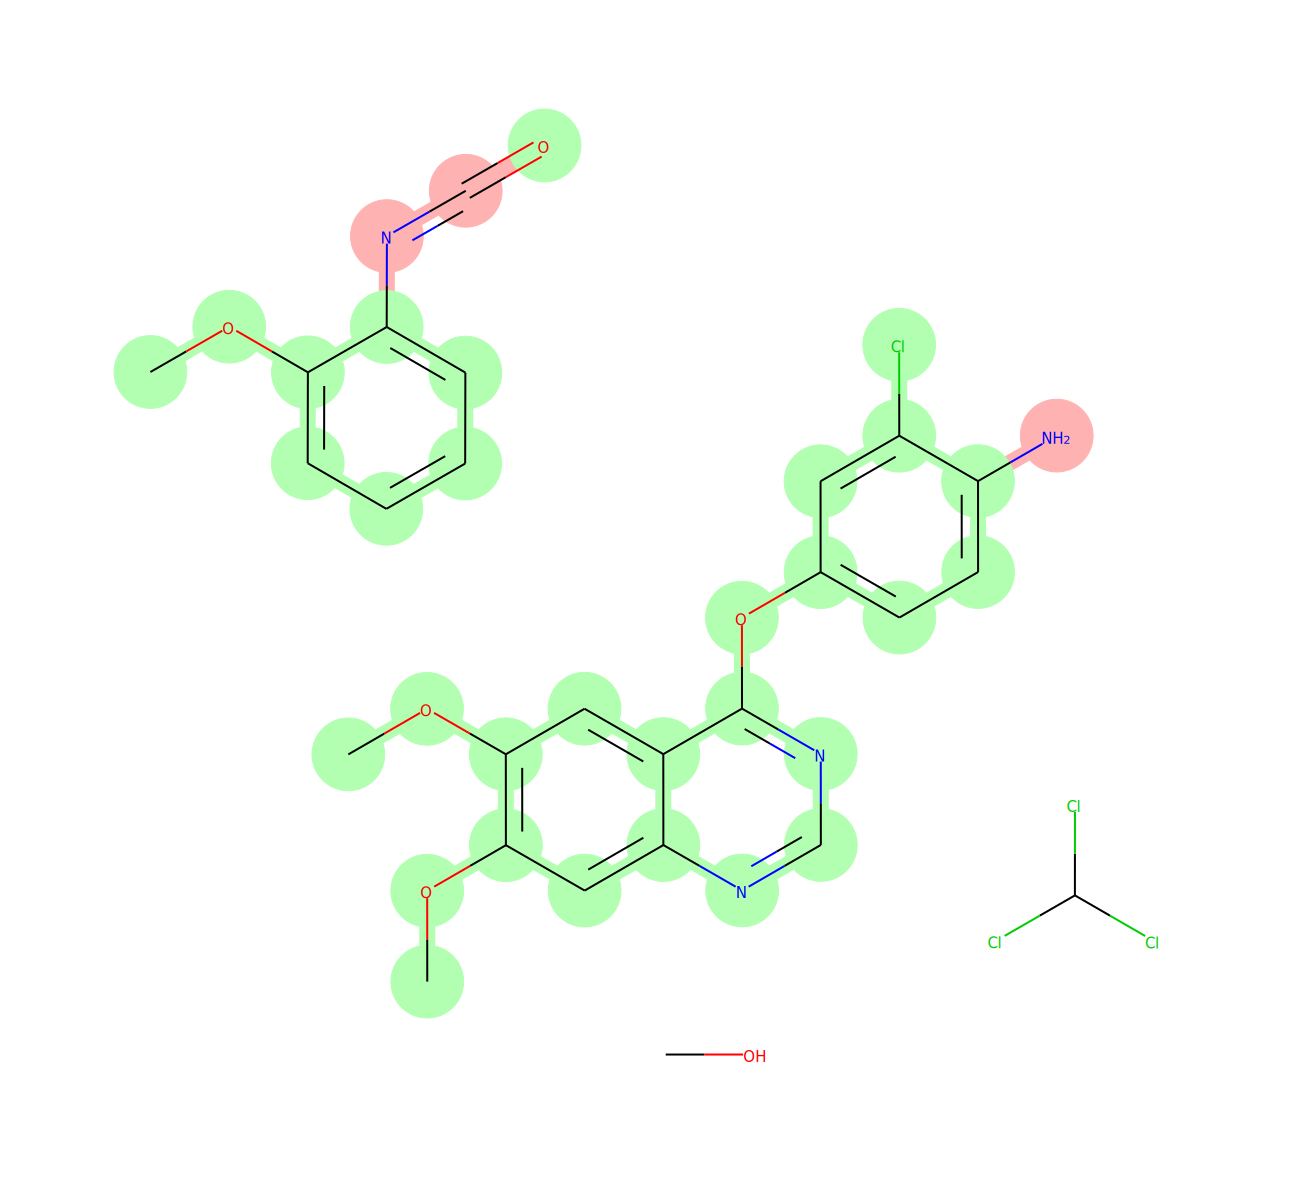

31417
0.32648662


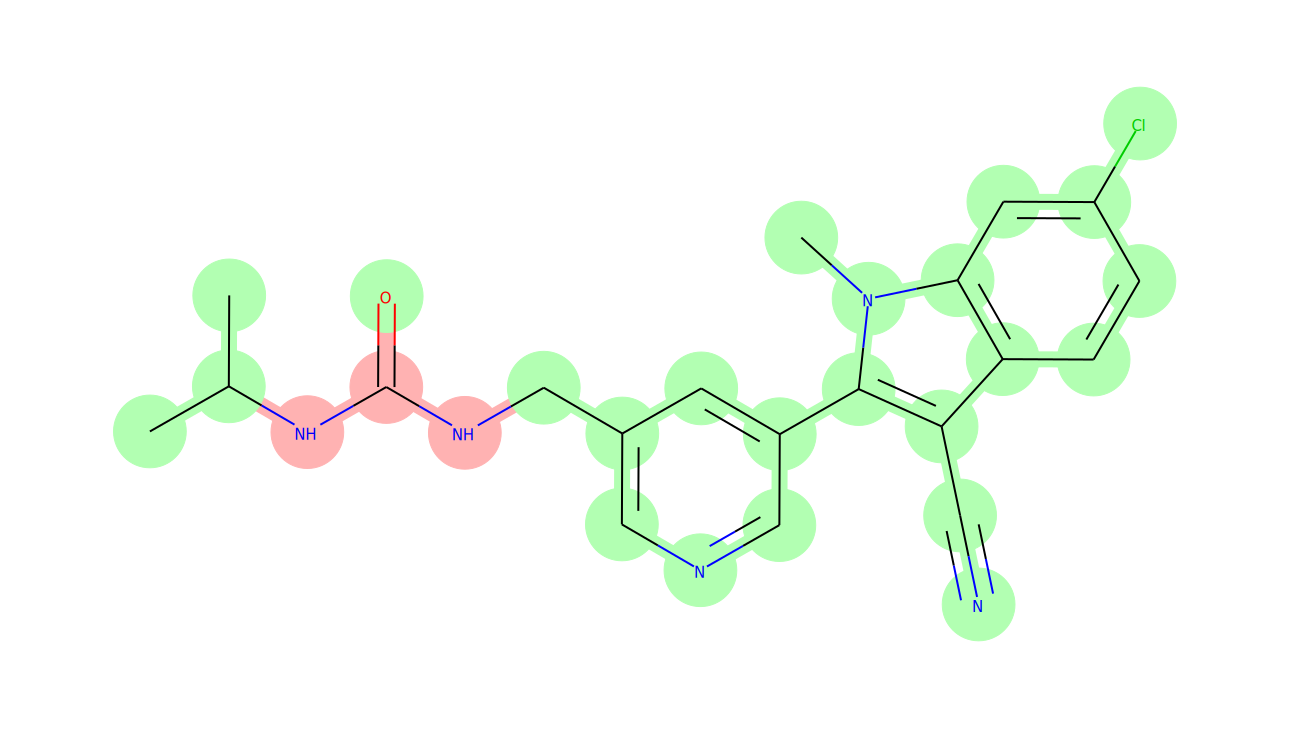

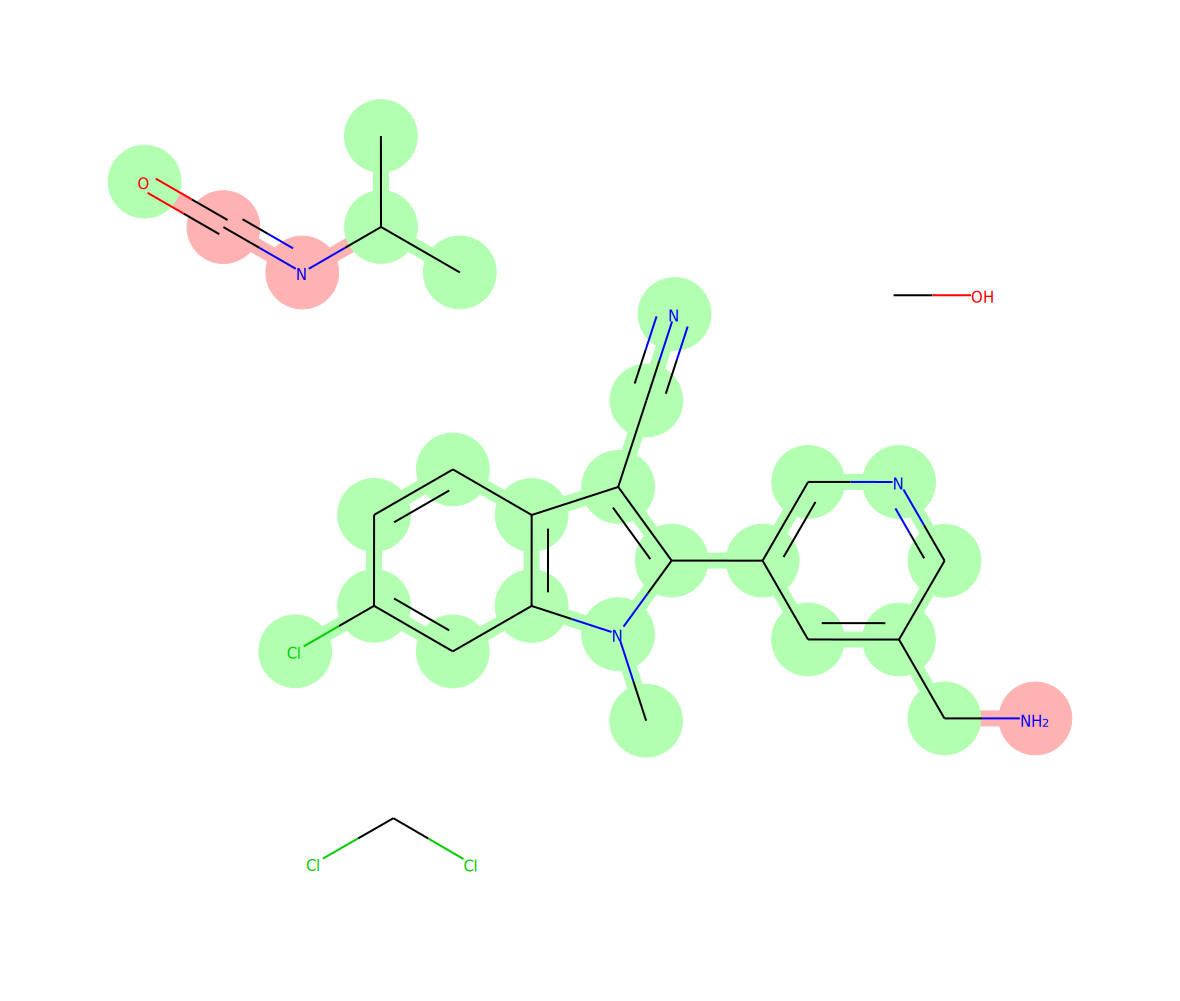

5787
0.47121987


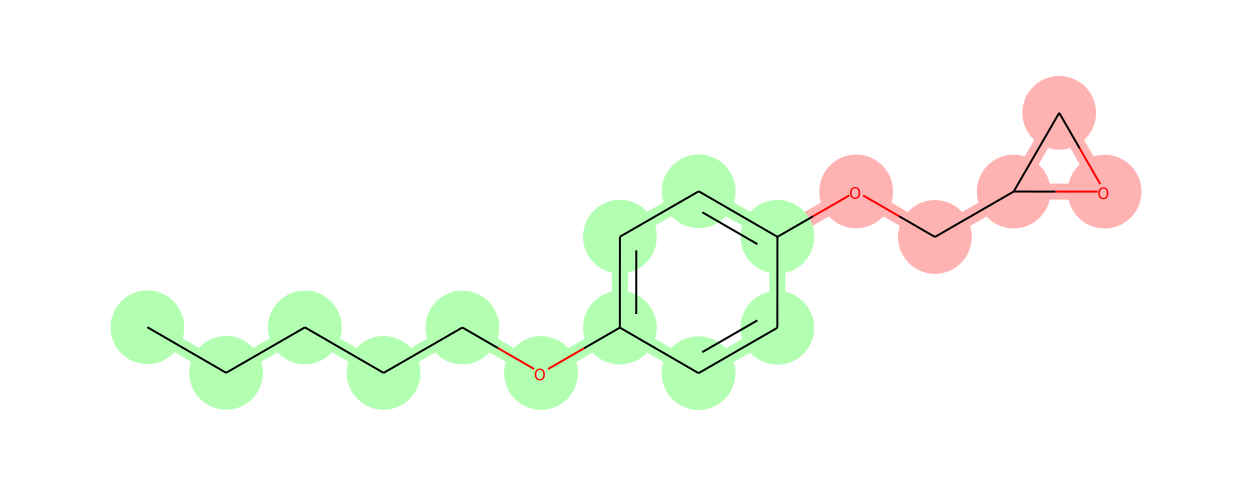

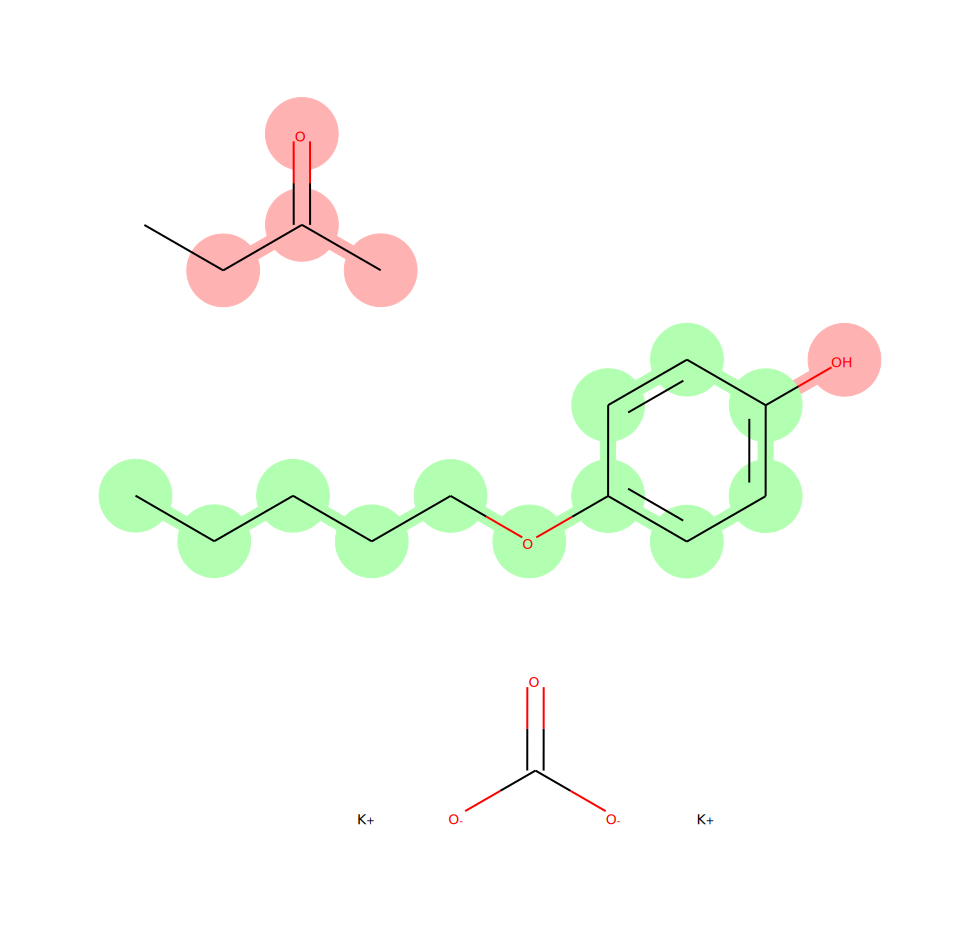

22478
1.7188205


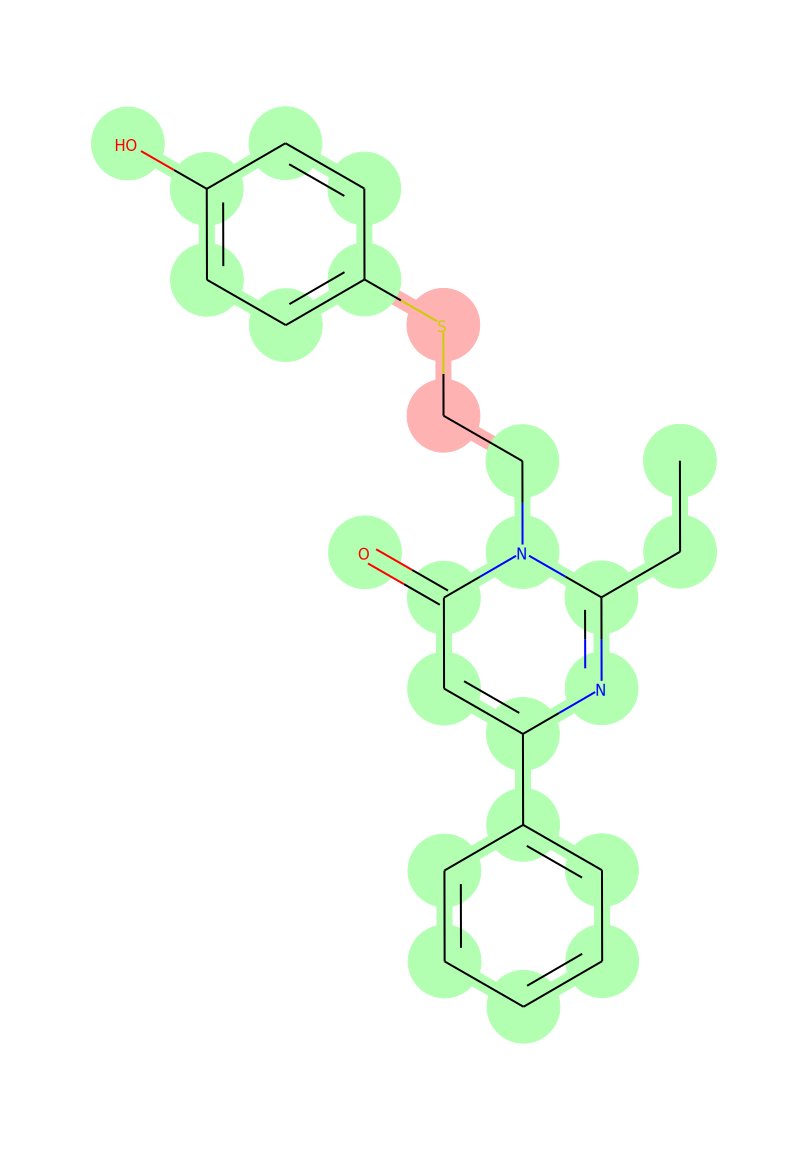

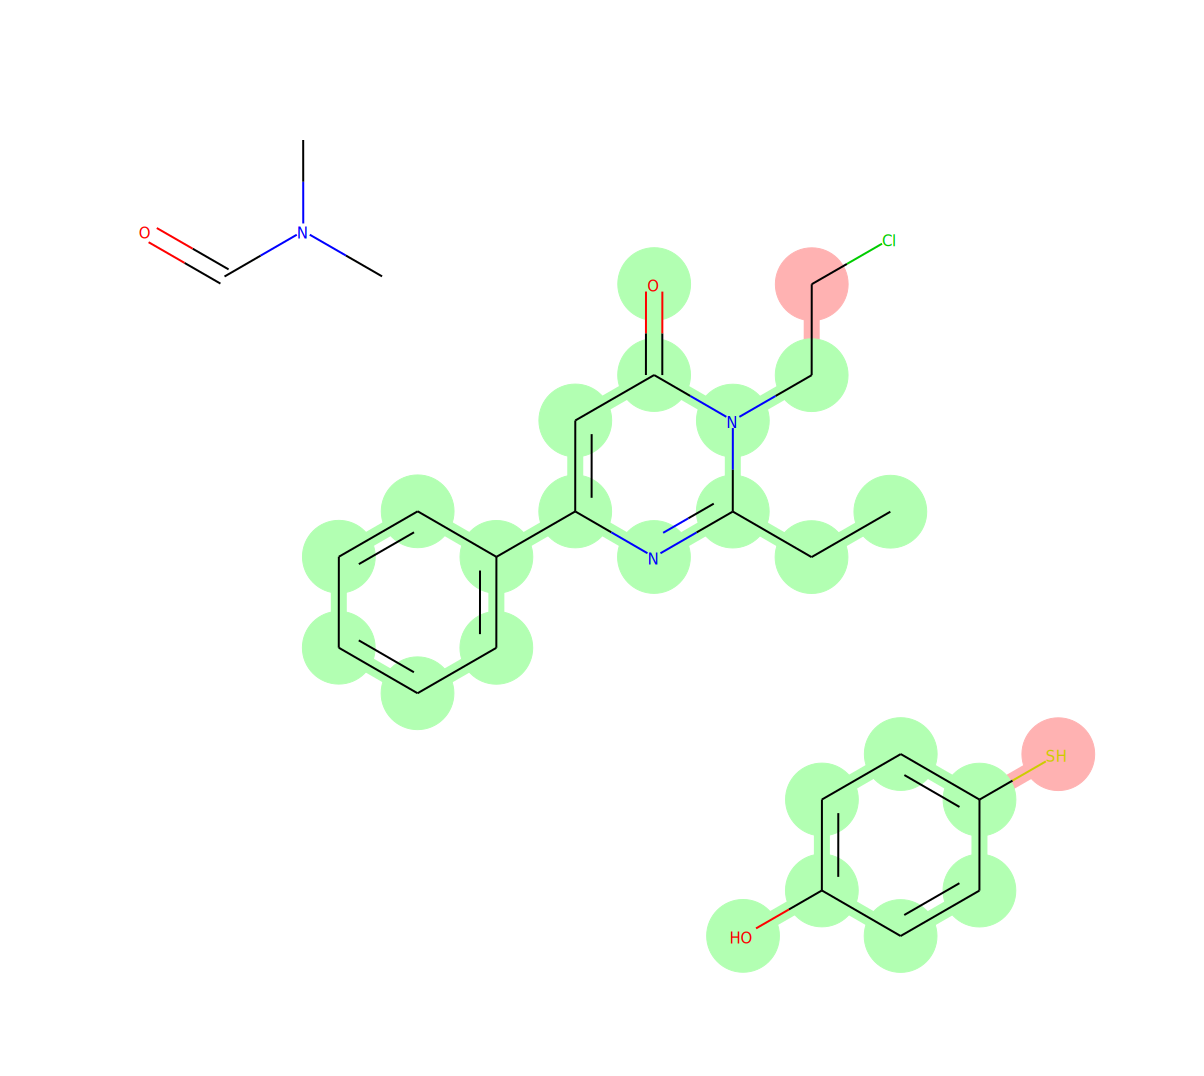

New center
33321
0.23179077


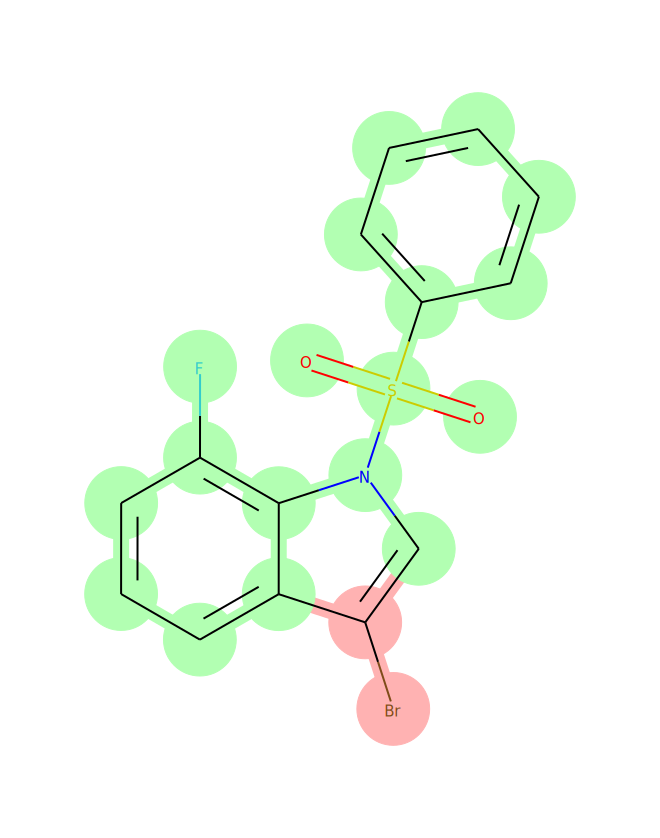

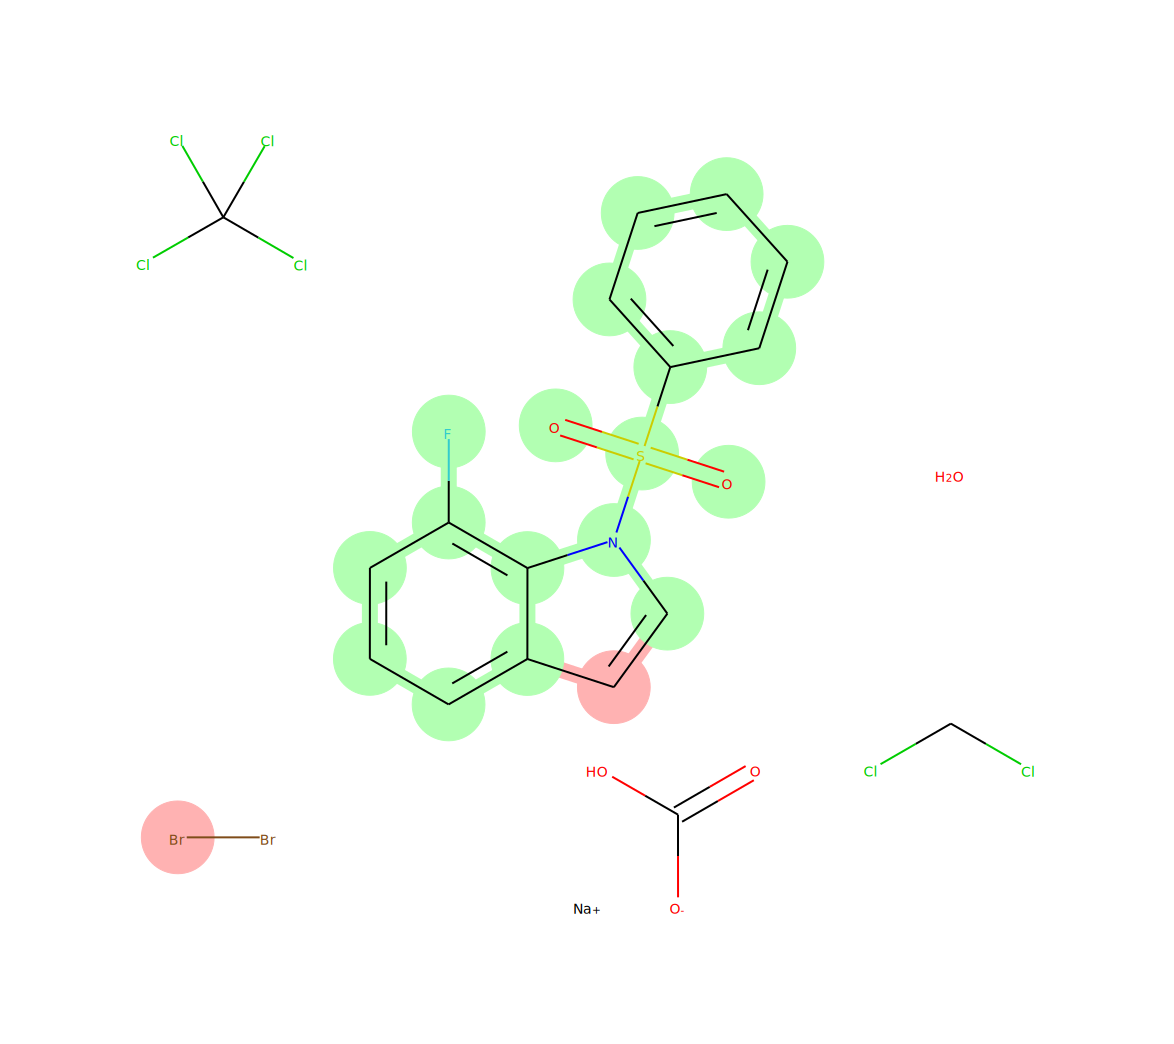

15809
0.27711174


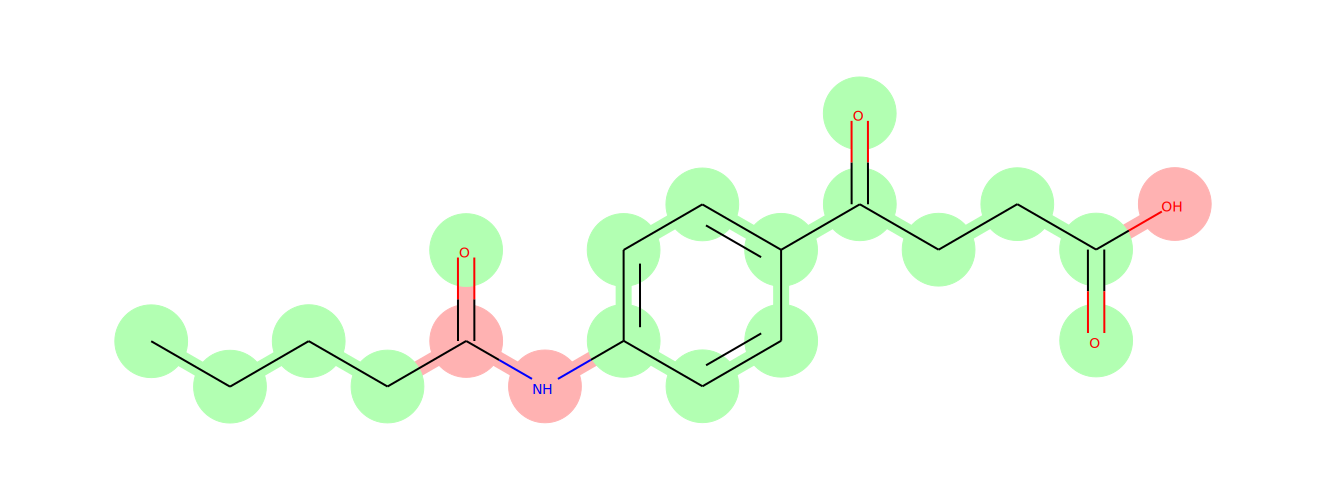

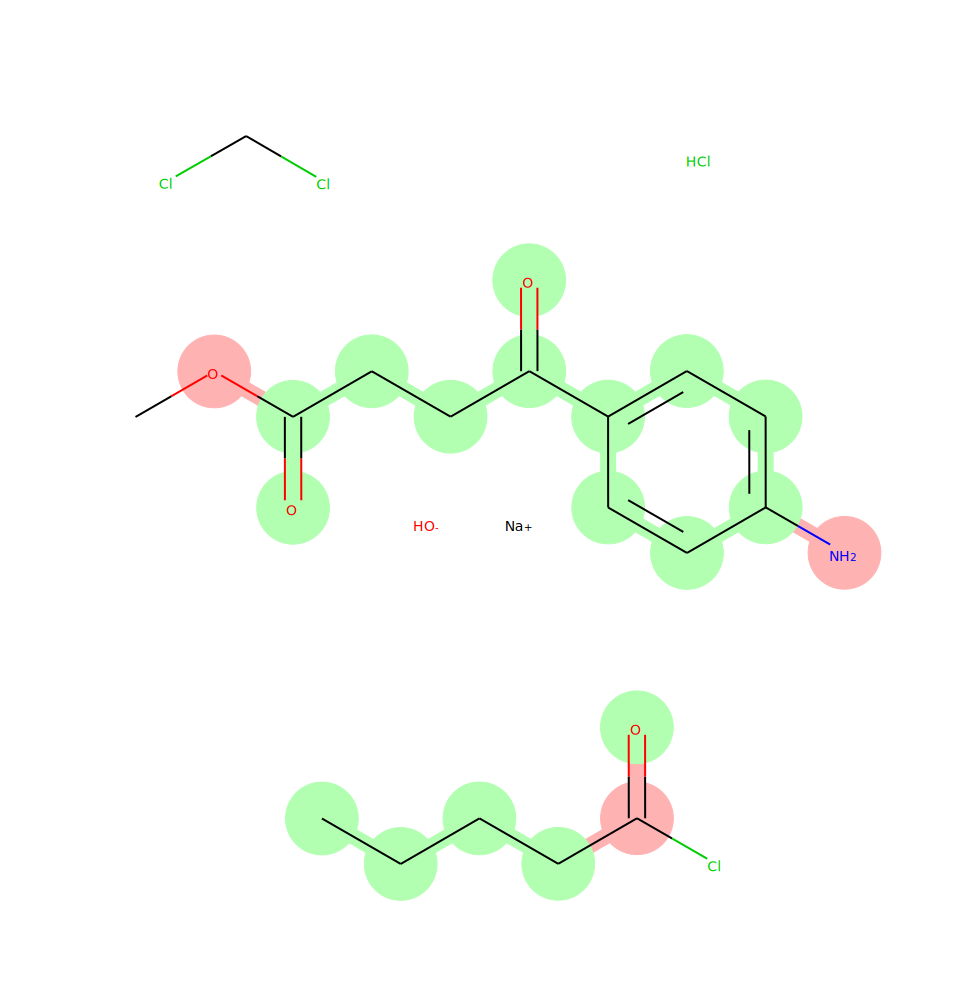

978
0.28981185


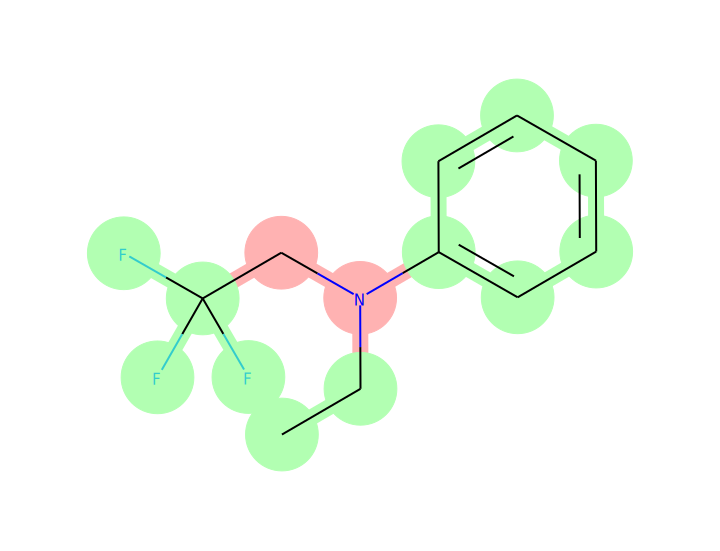

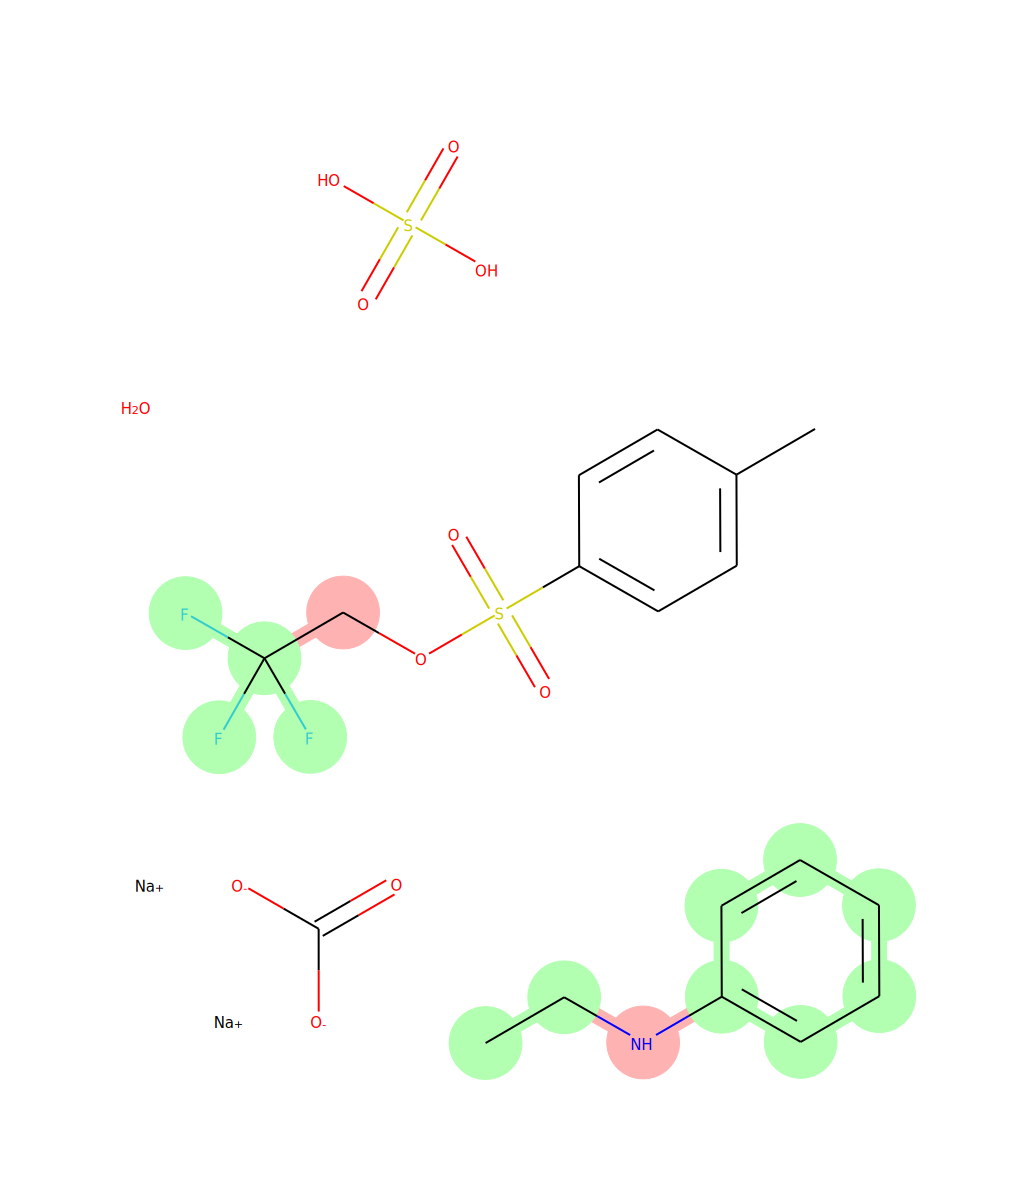

5235
0.4040977


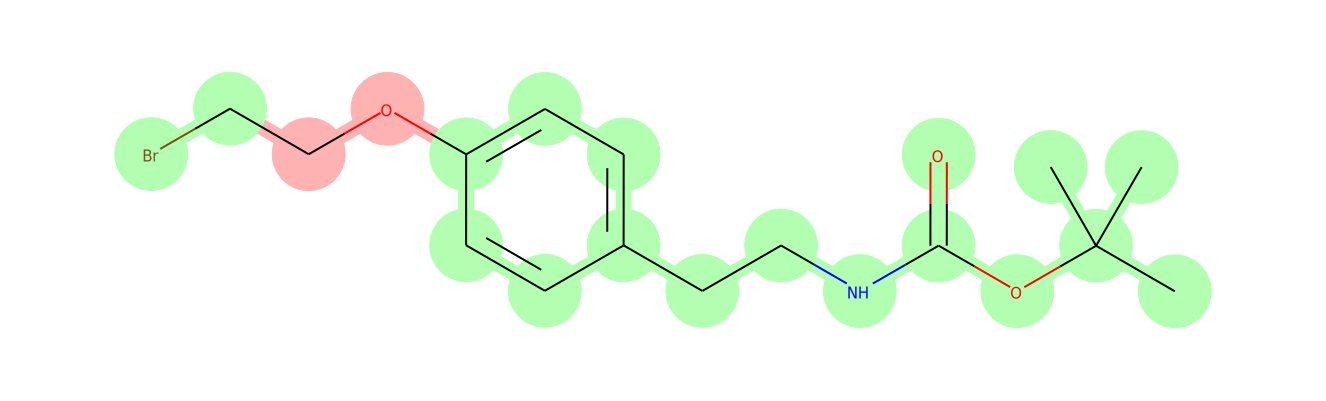

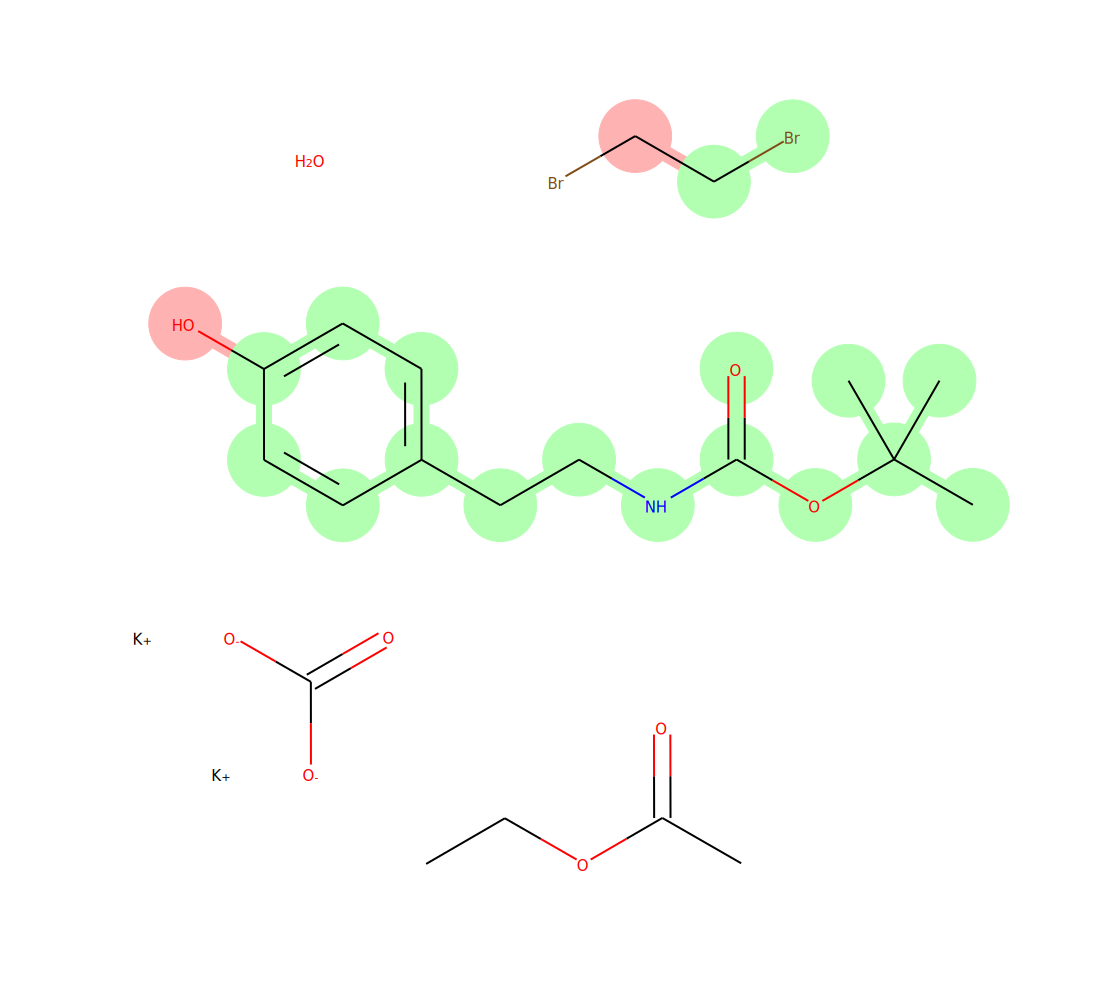

11513
1.8488593


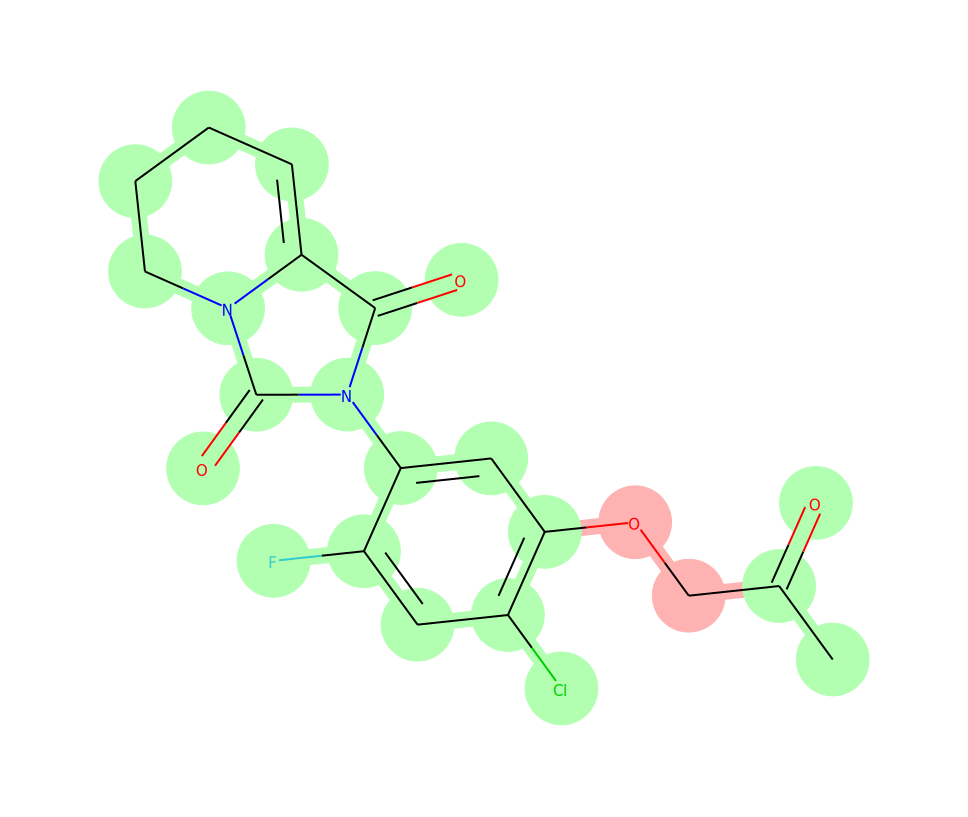

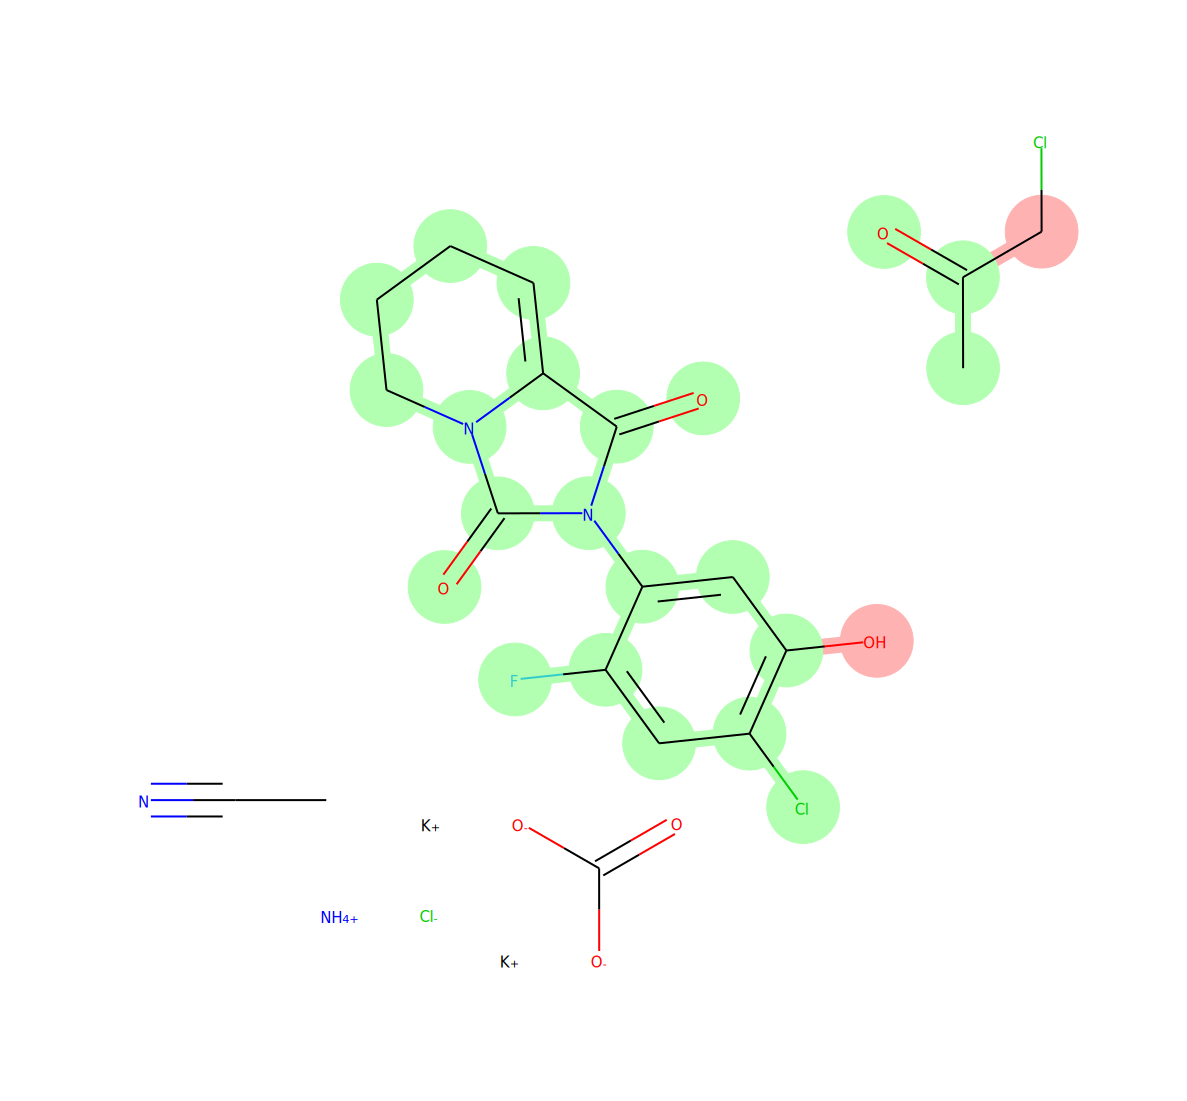

New center
23698
0.38728496


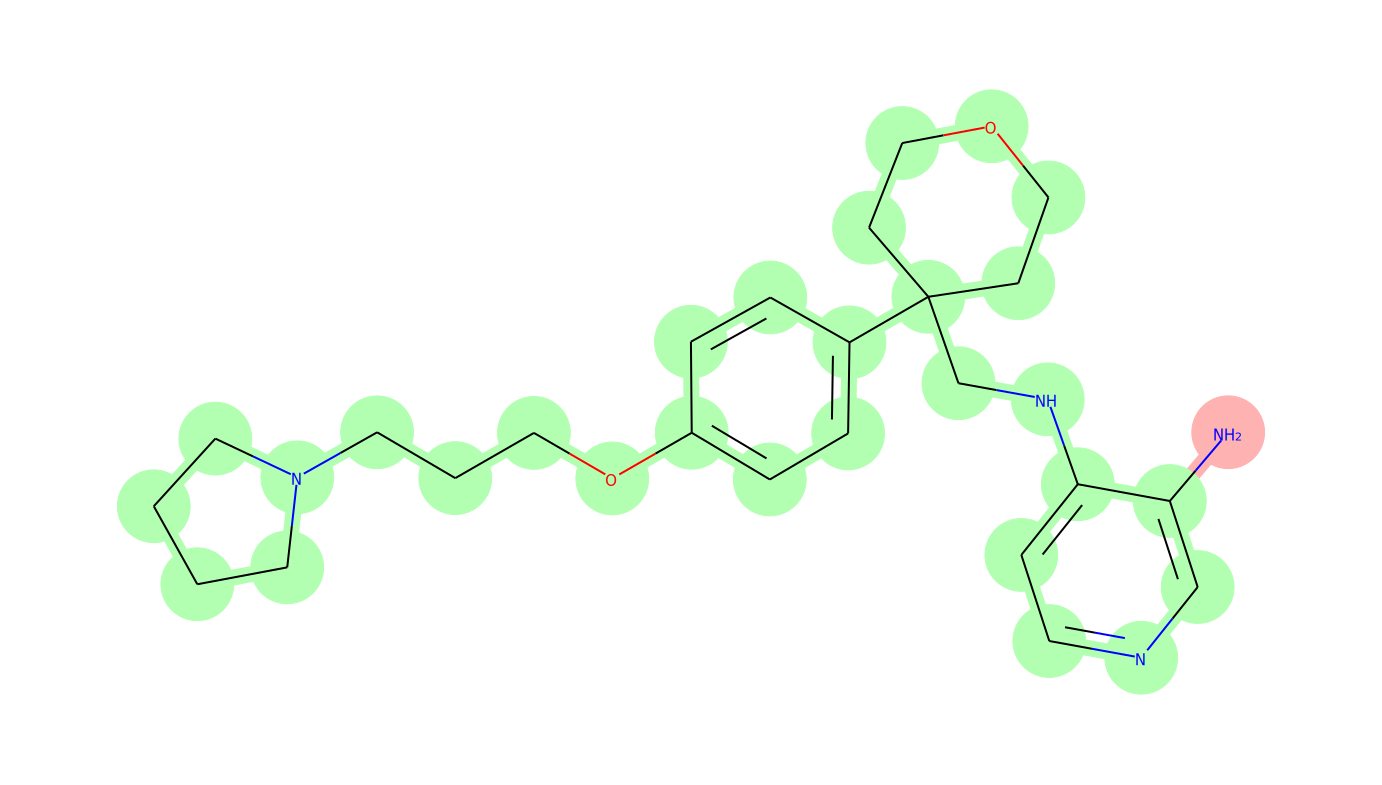

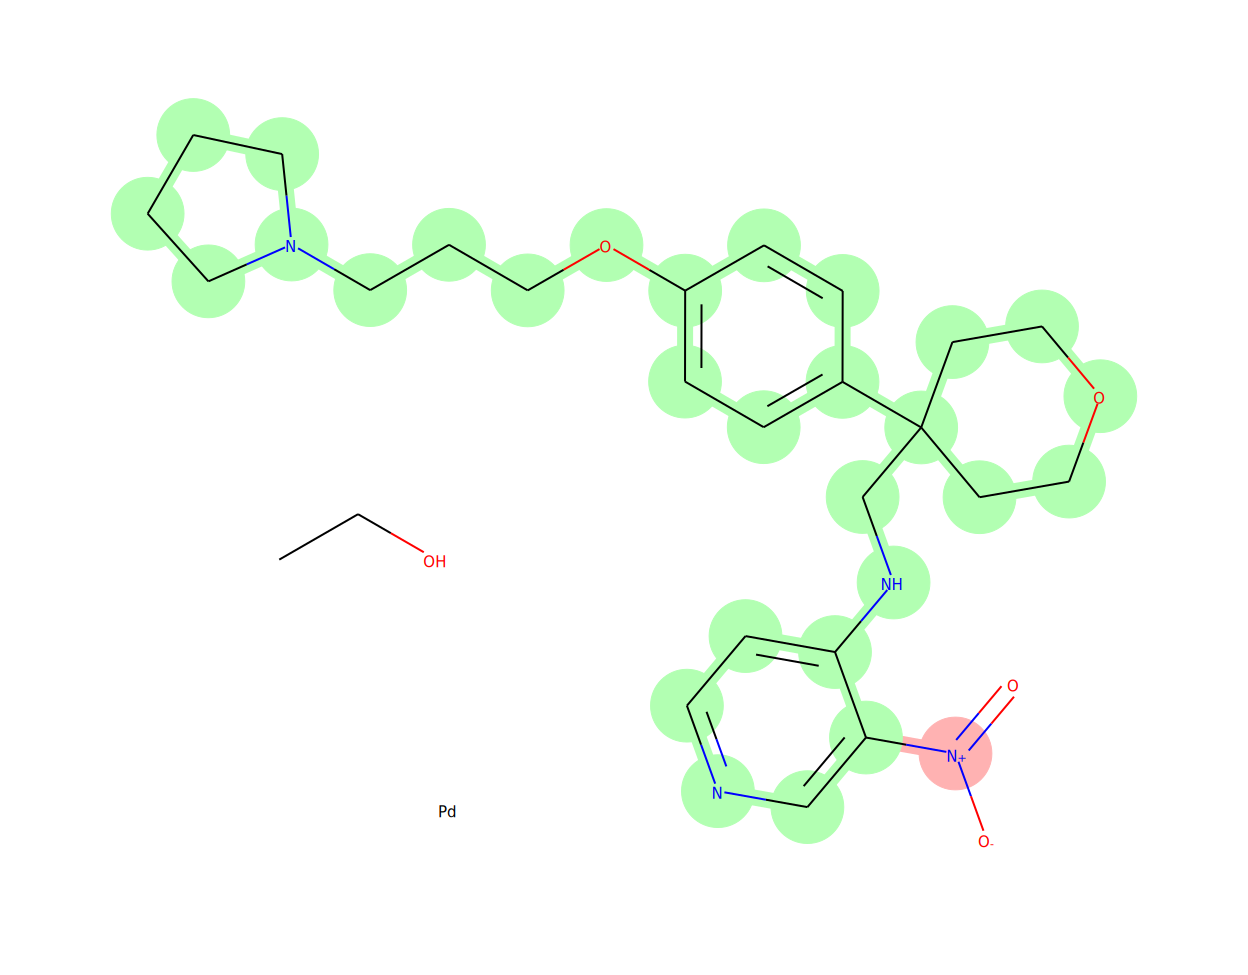

20571
0.38740468


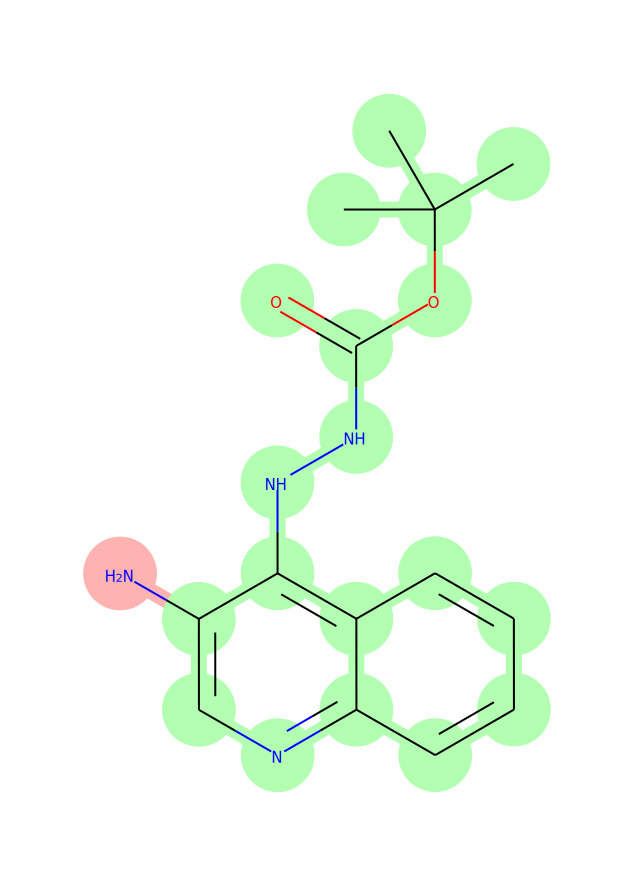

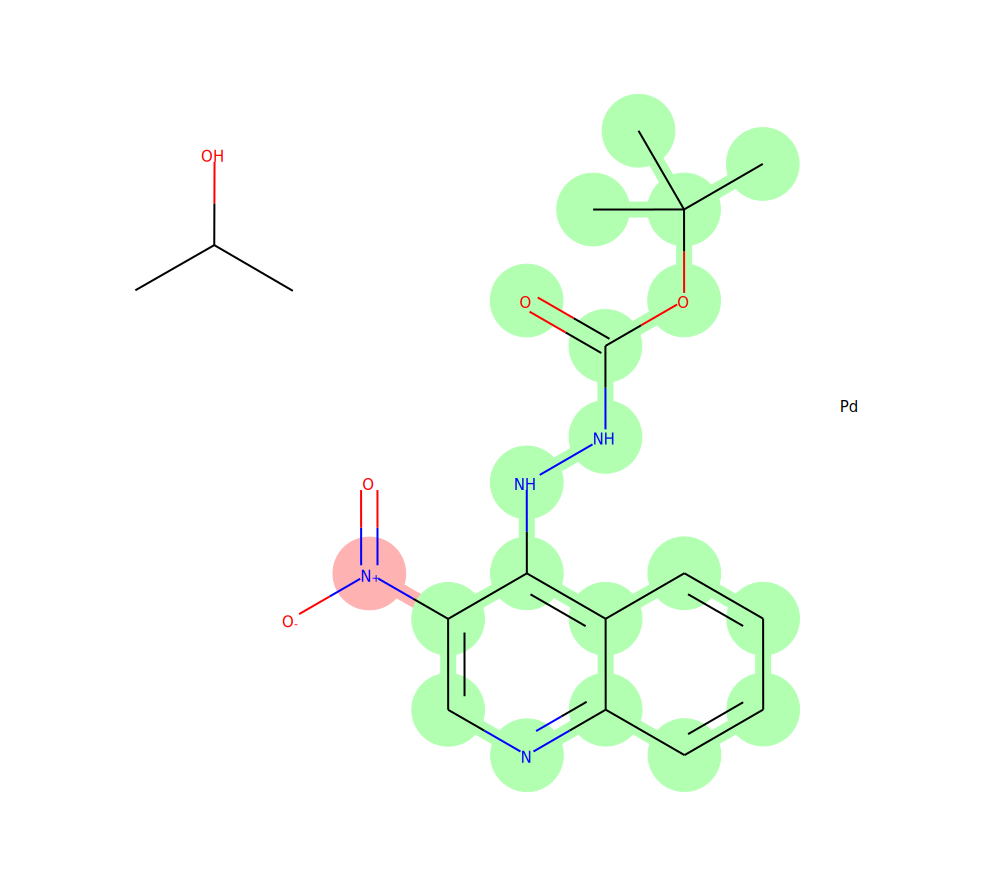

338
0.39160264


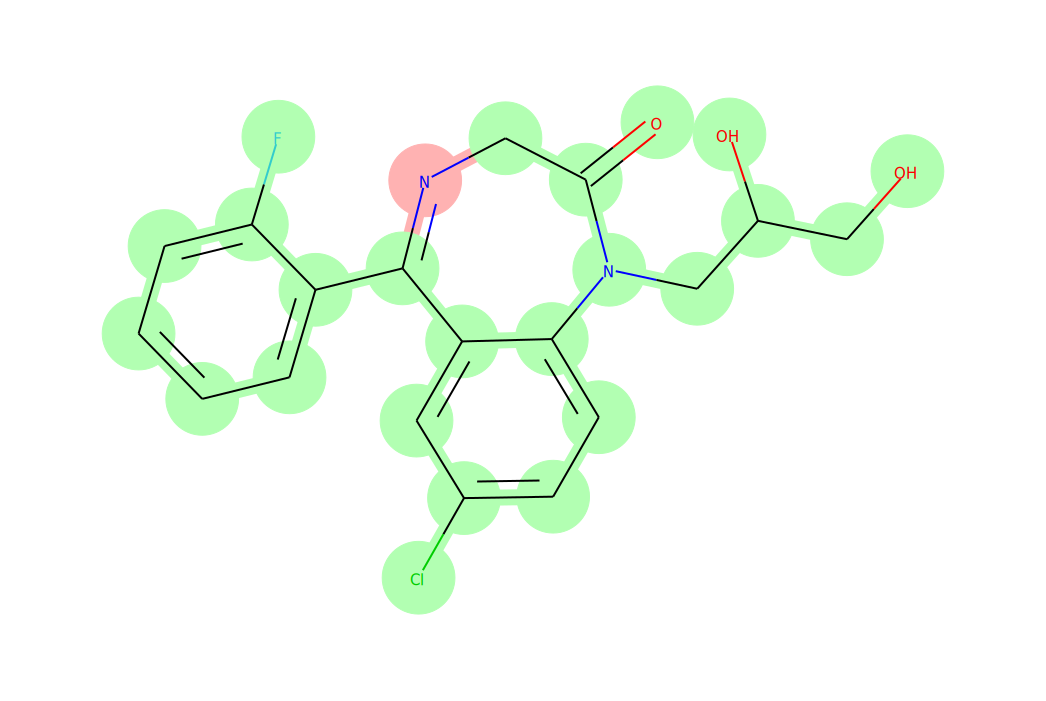

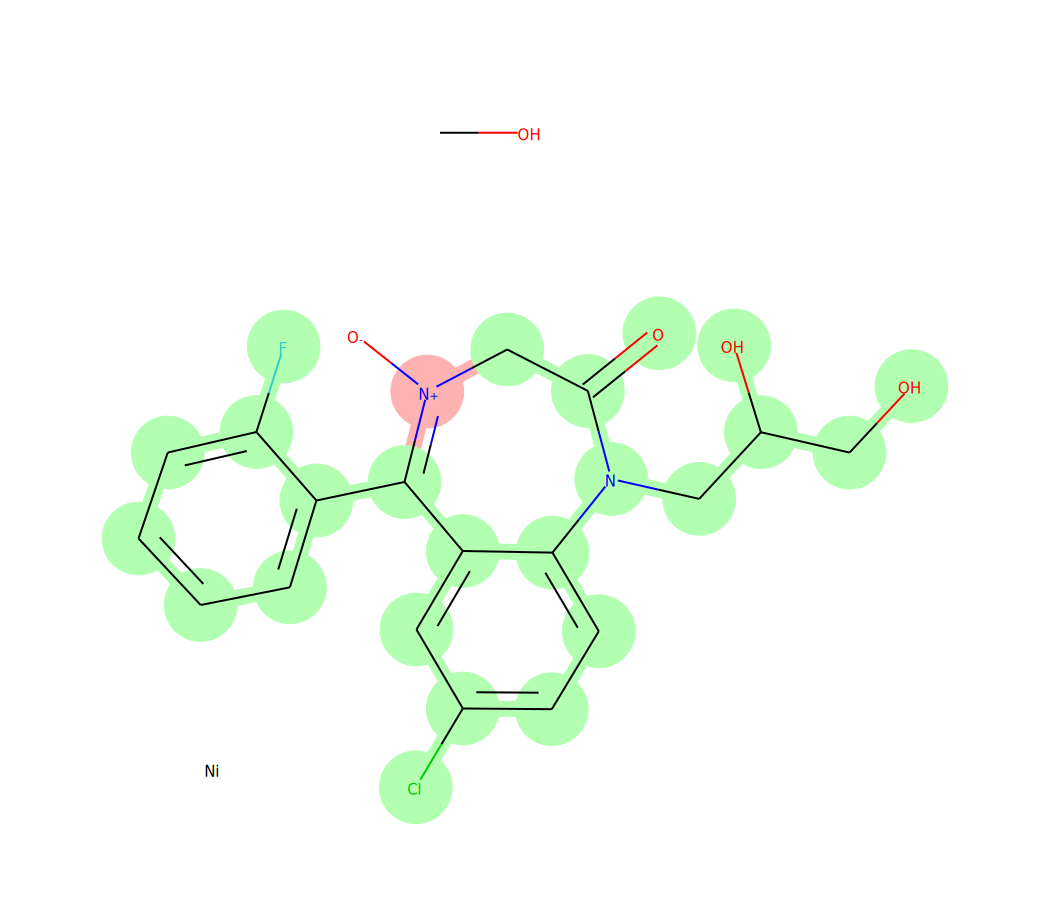

37702
0.51923645


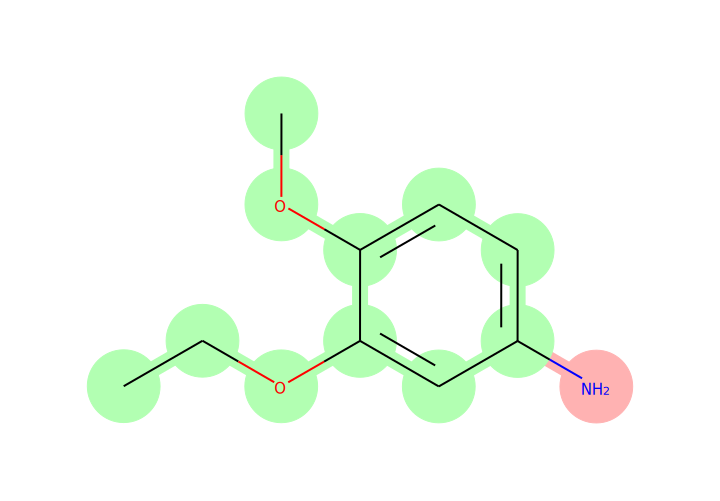

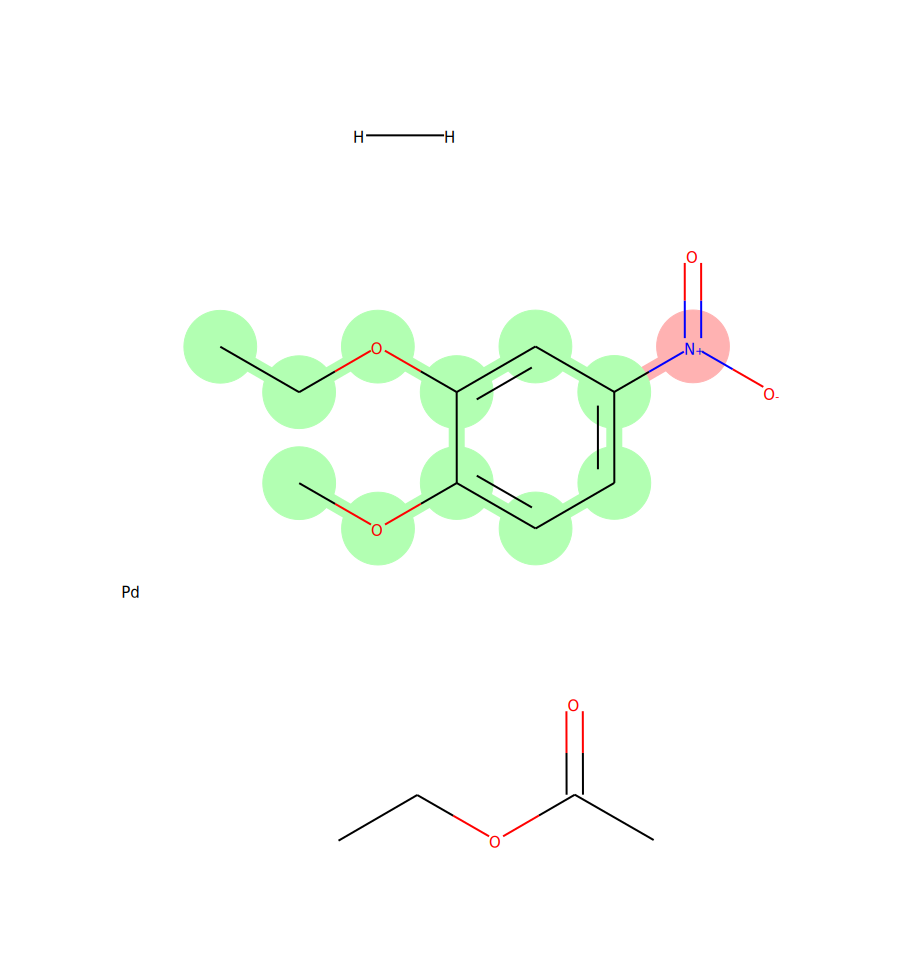

16856
5.2831163


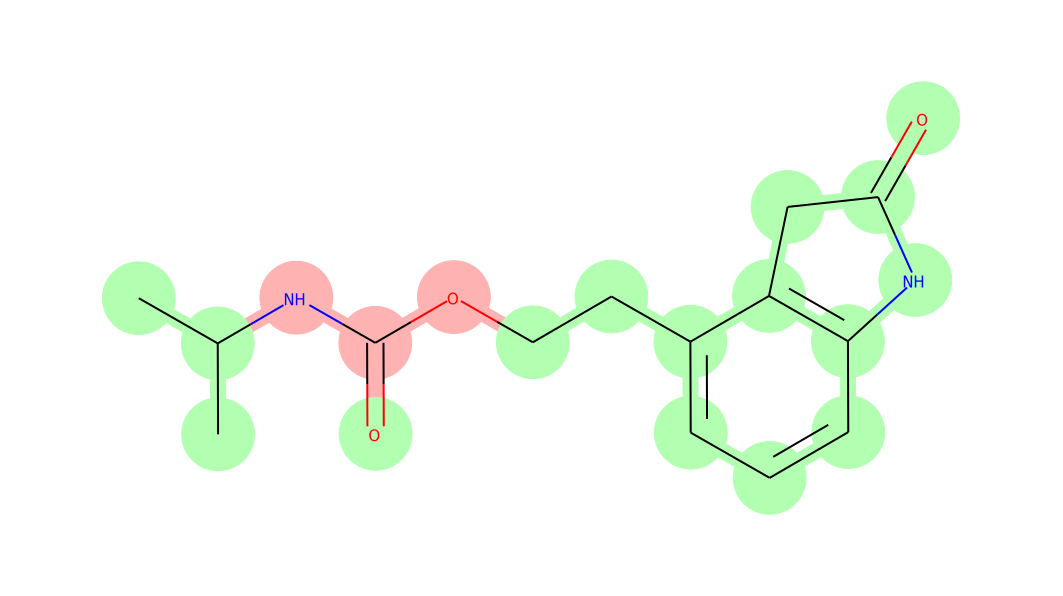

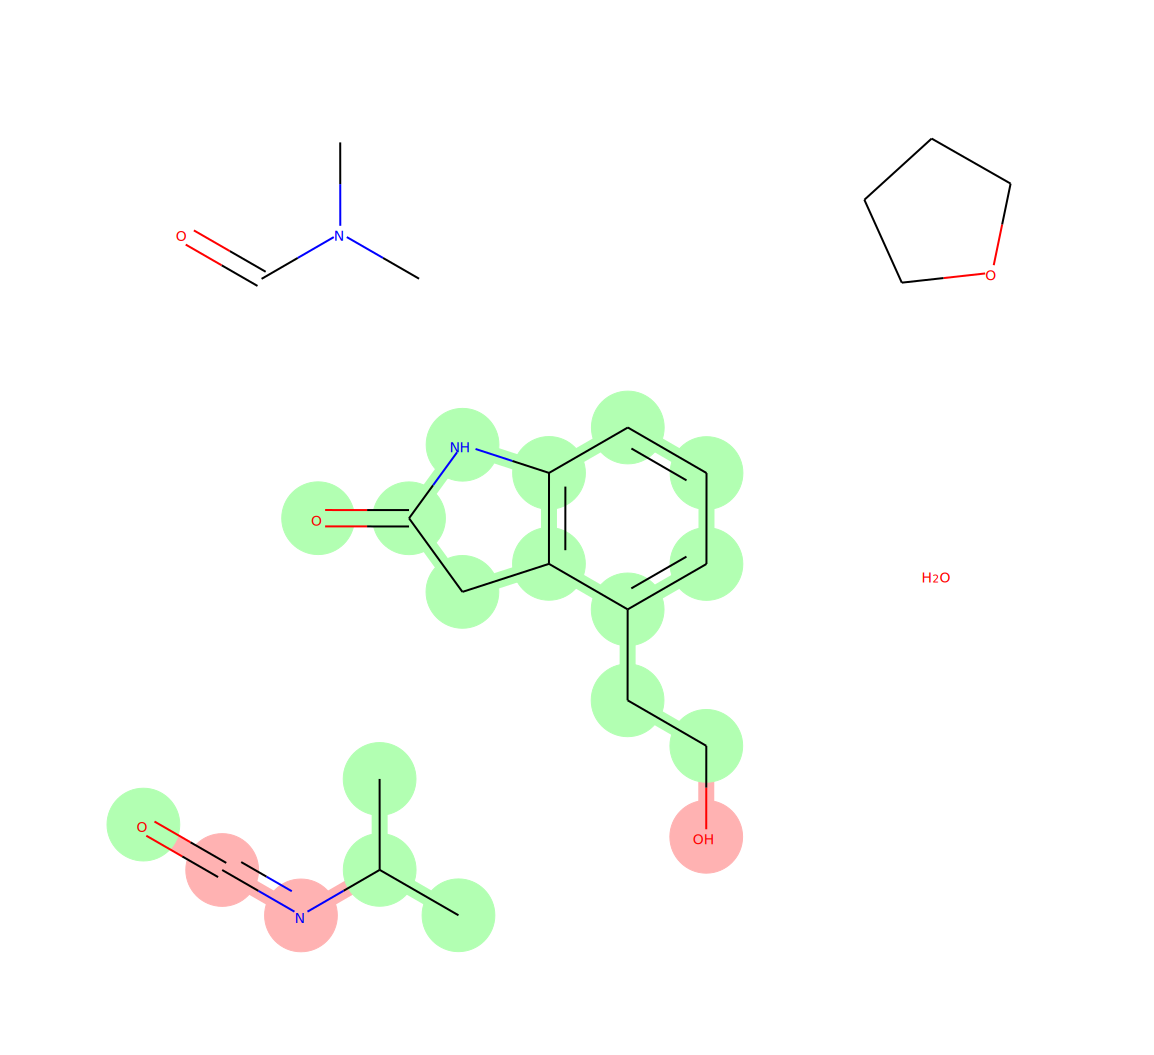

New center
20878
0.26488873


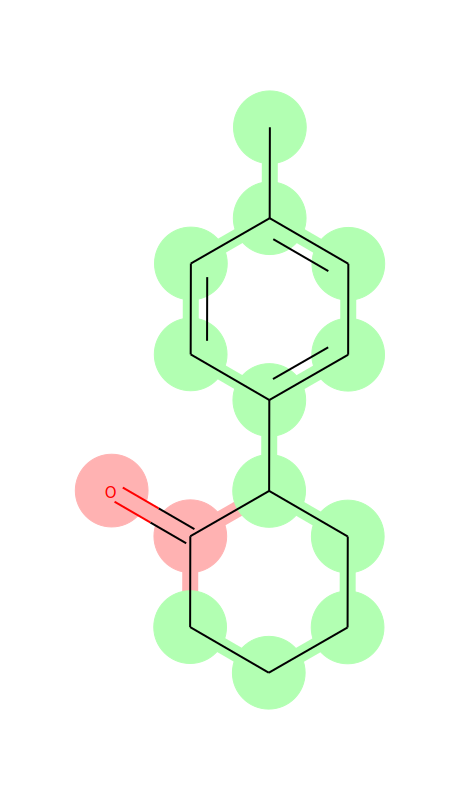

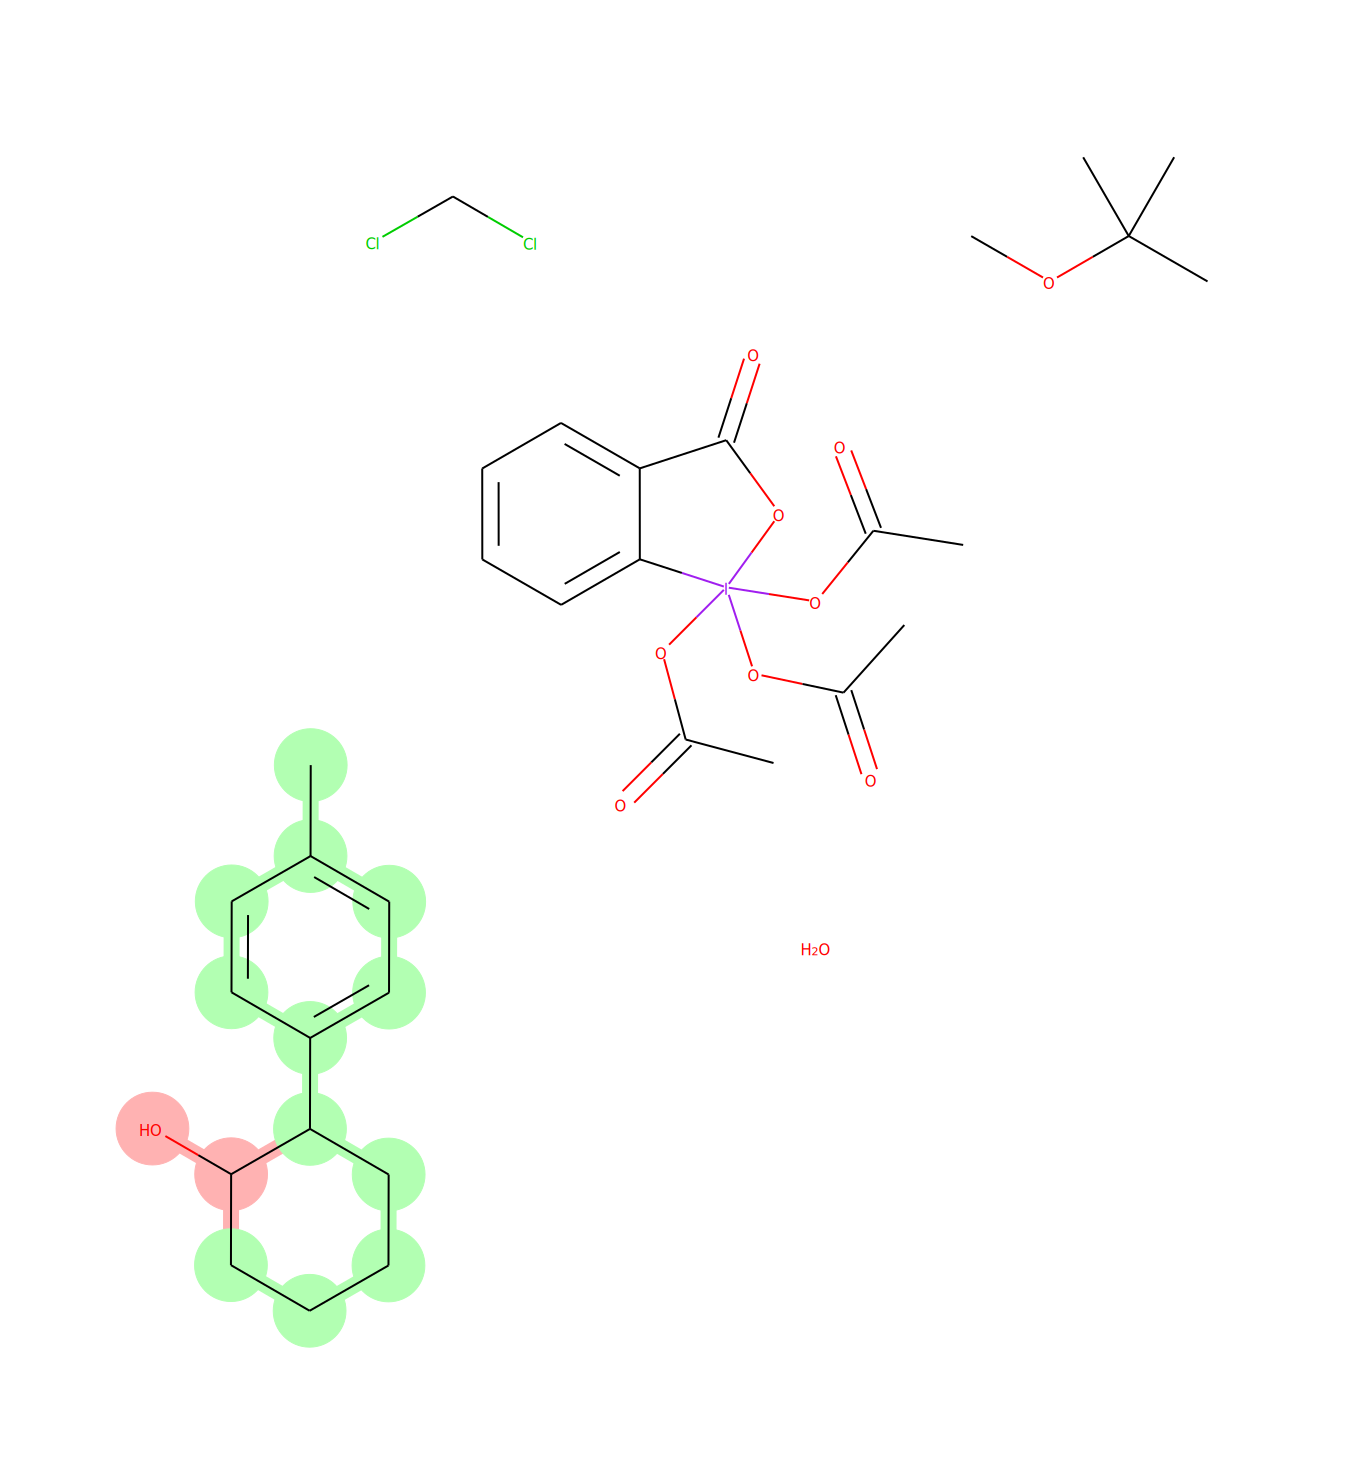

44614
0.32924563


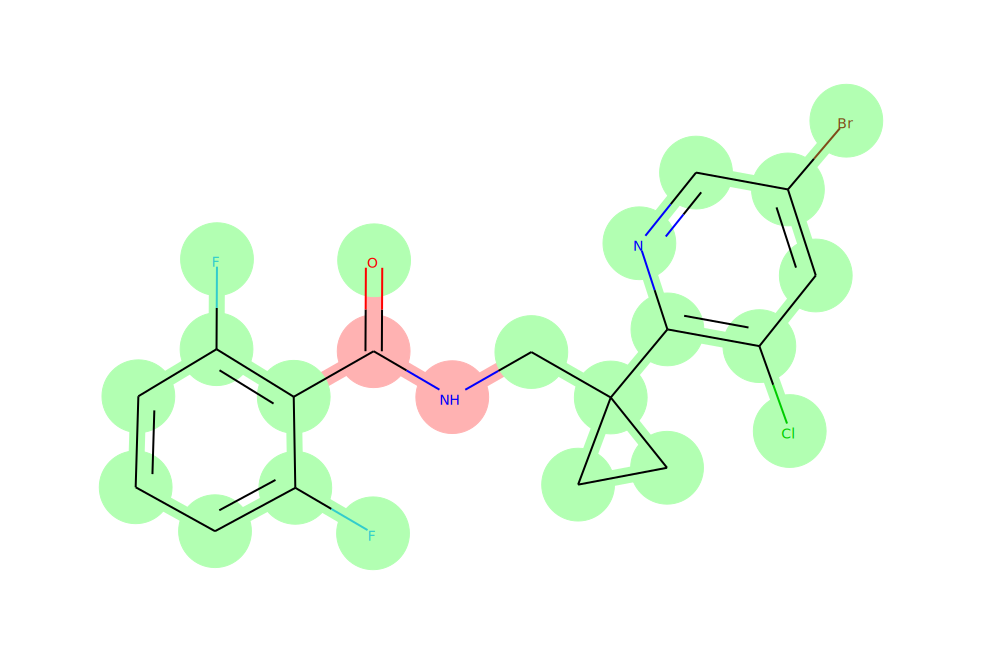

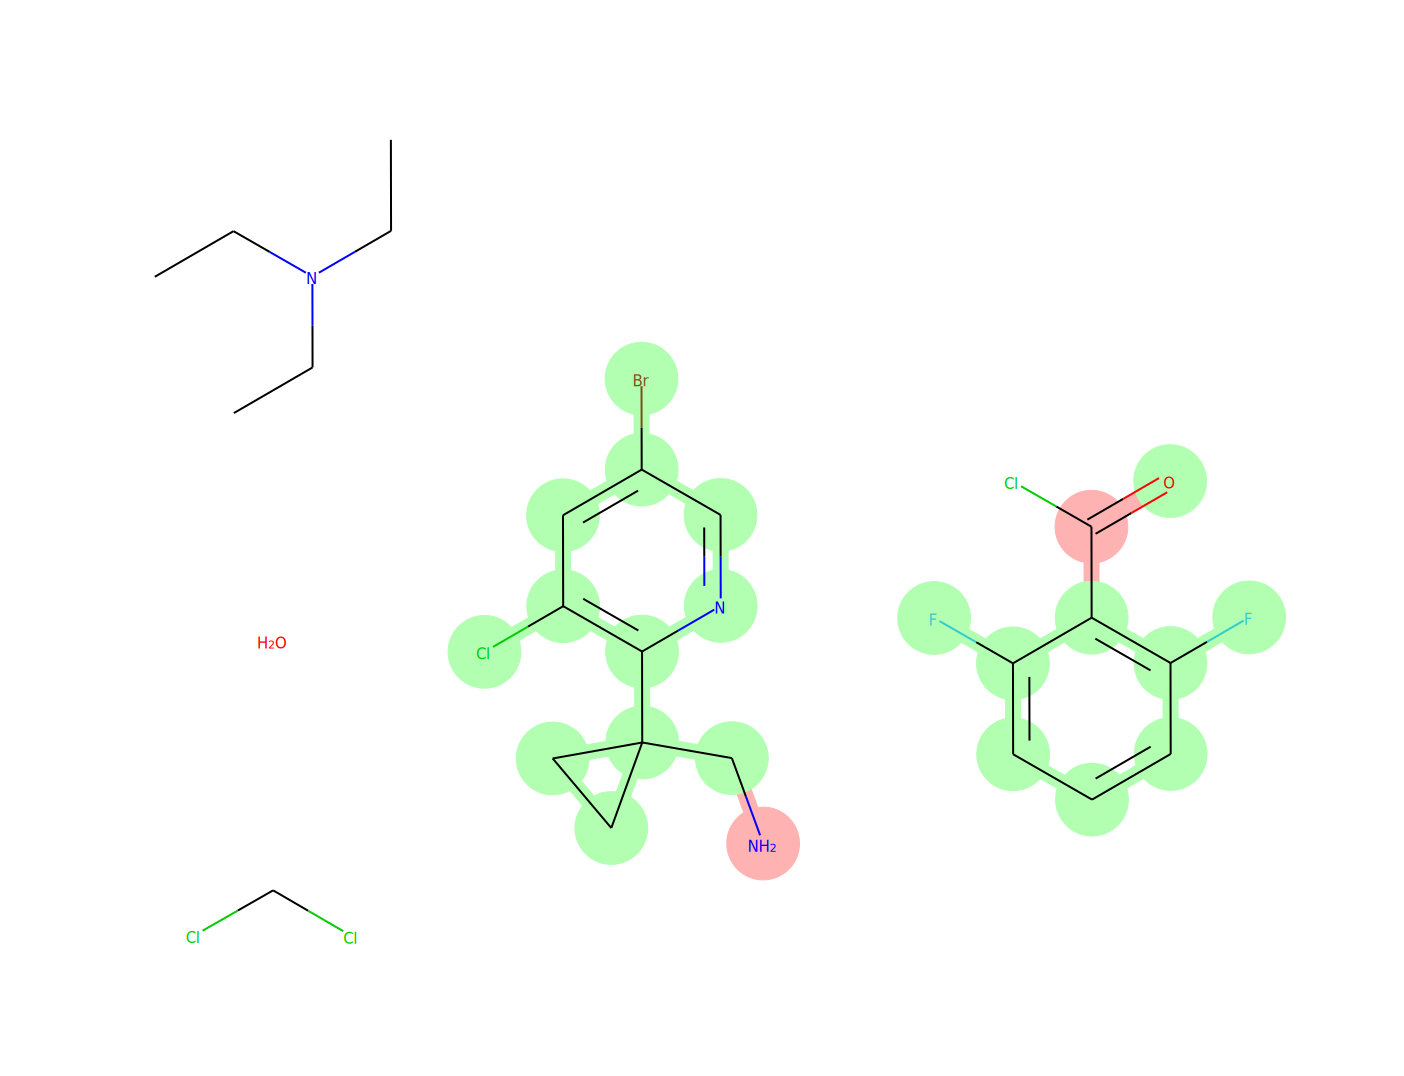

45871
0.3320643


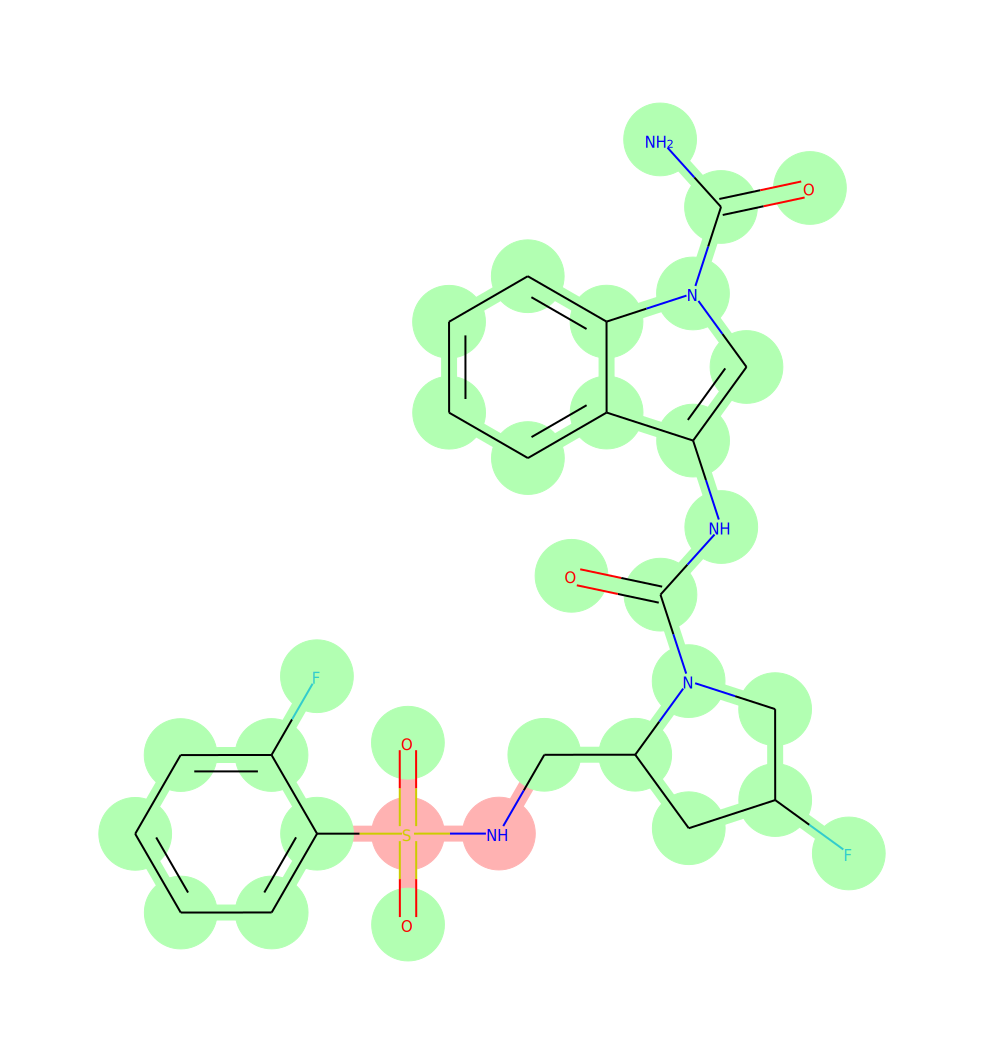

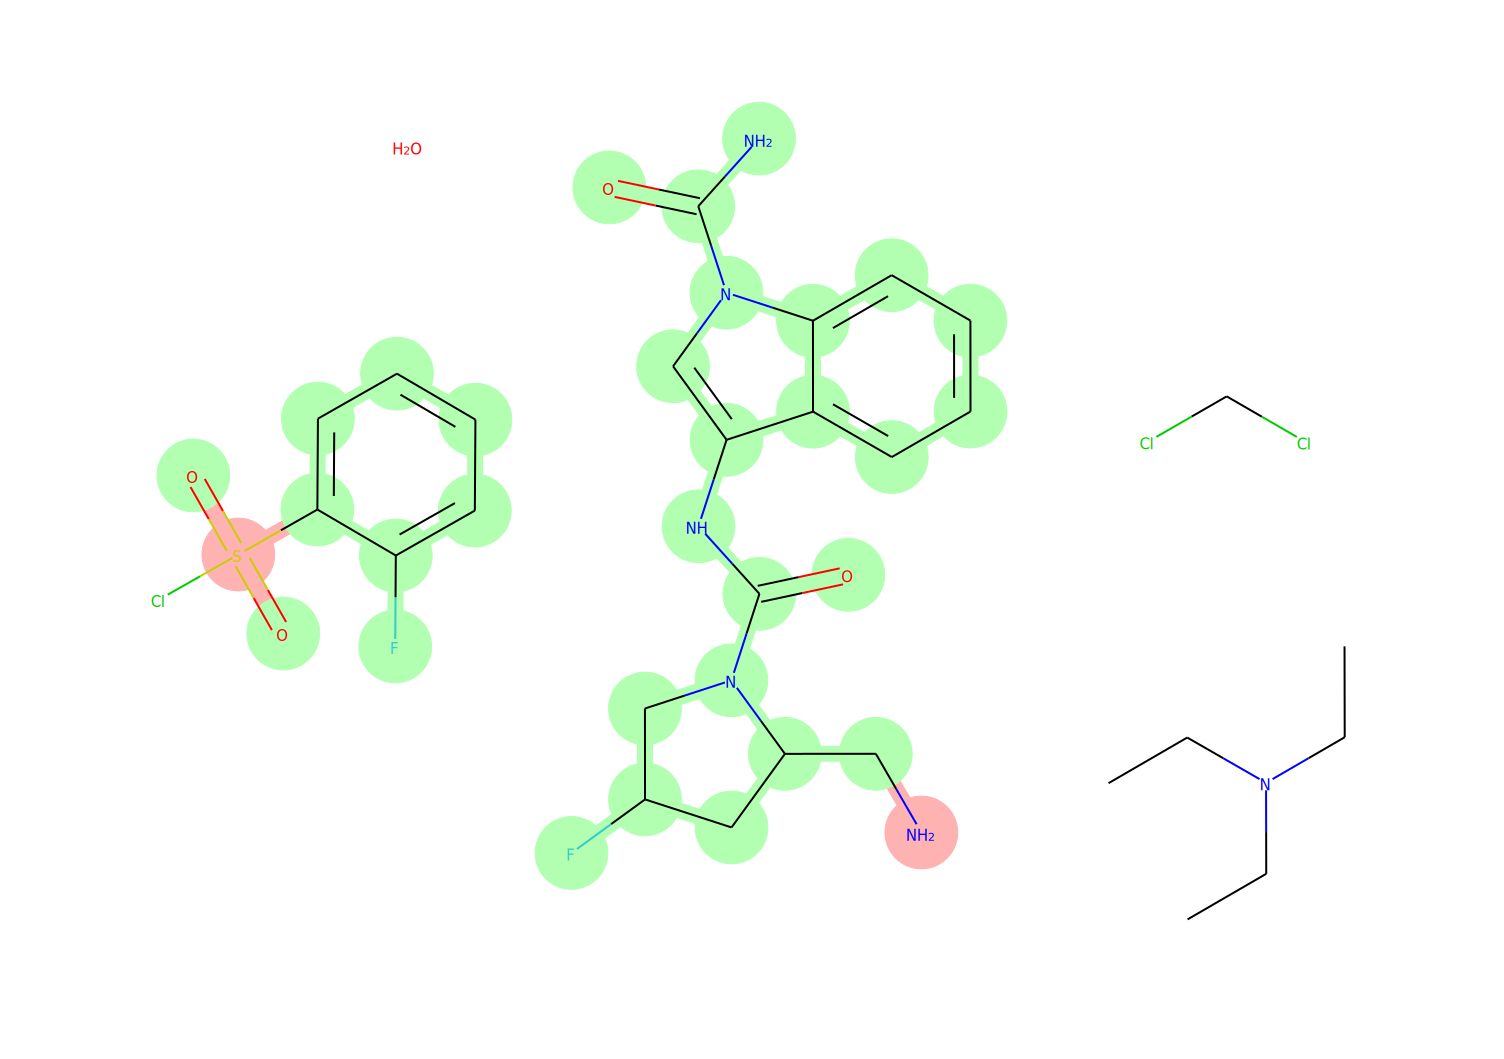

7824
0.5060033


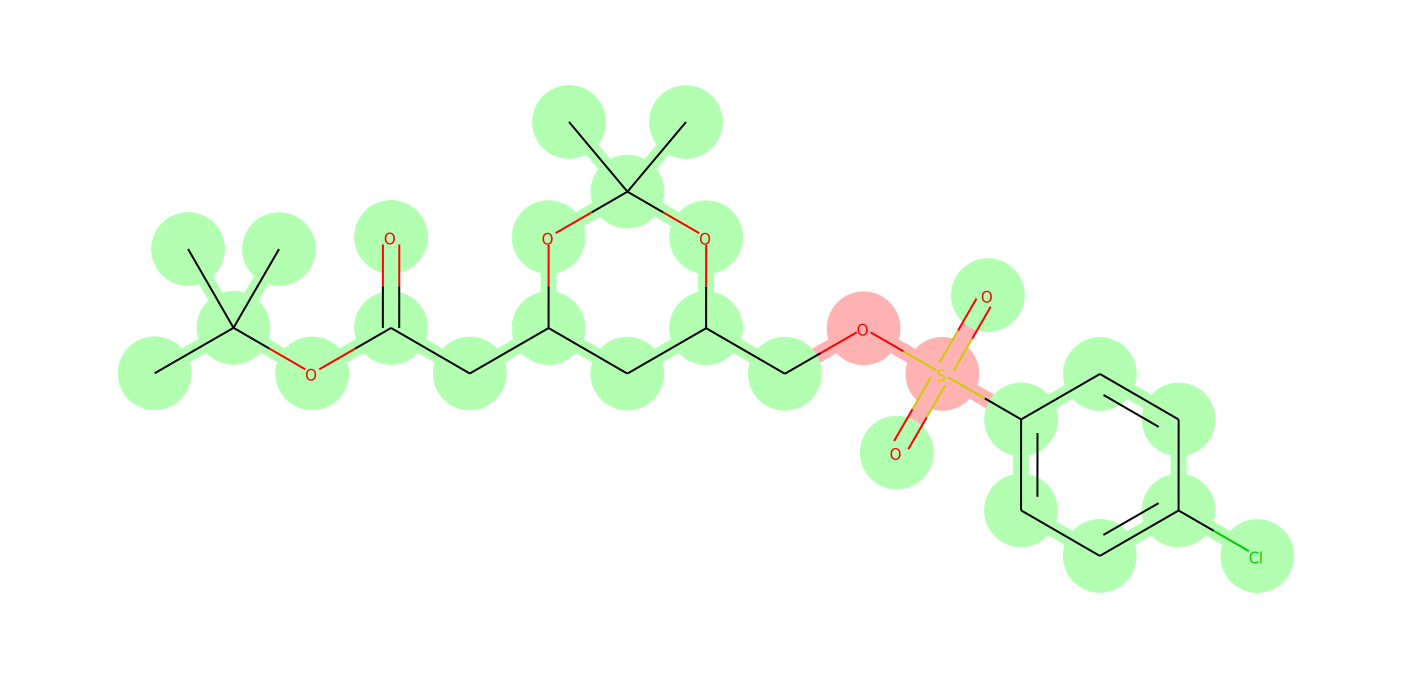

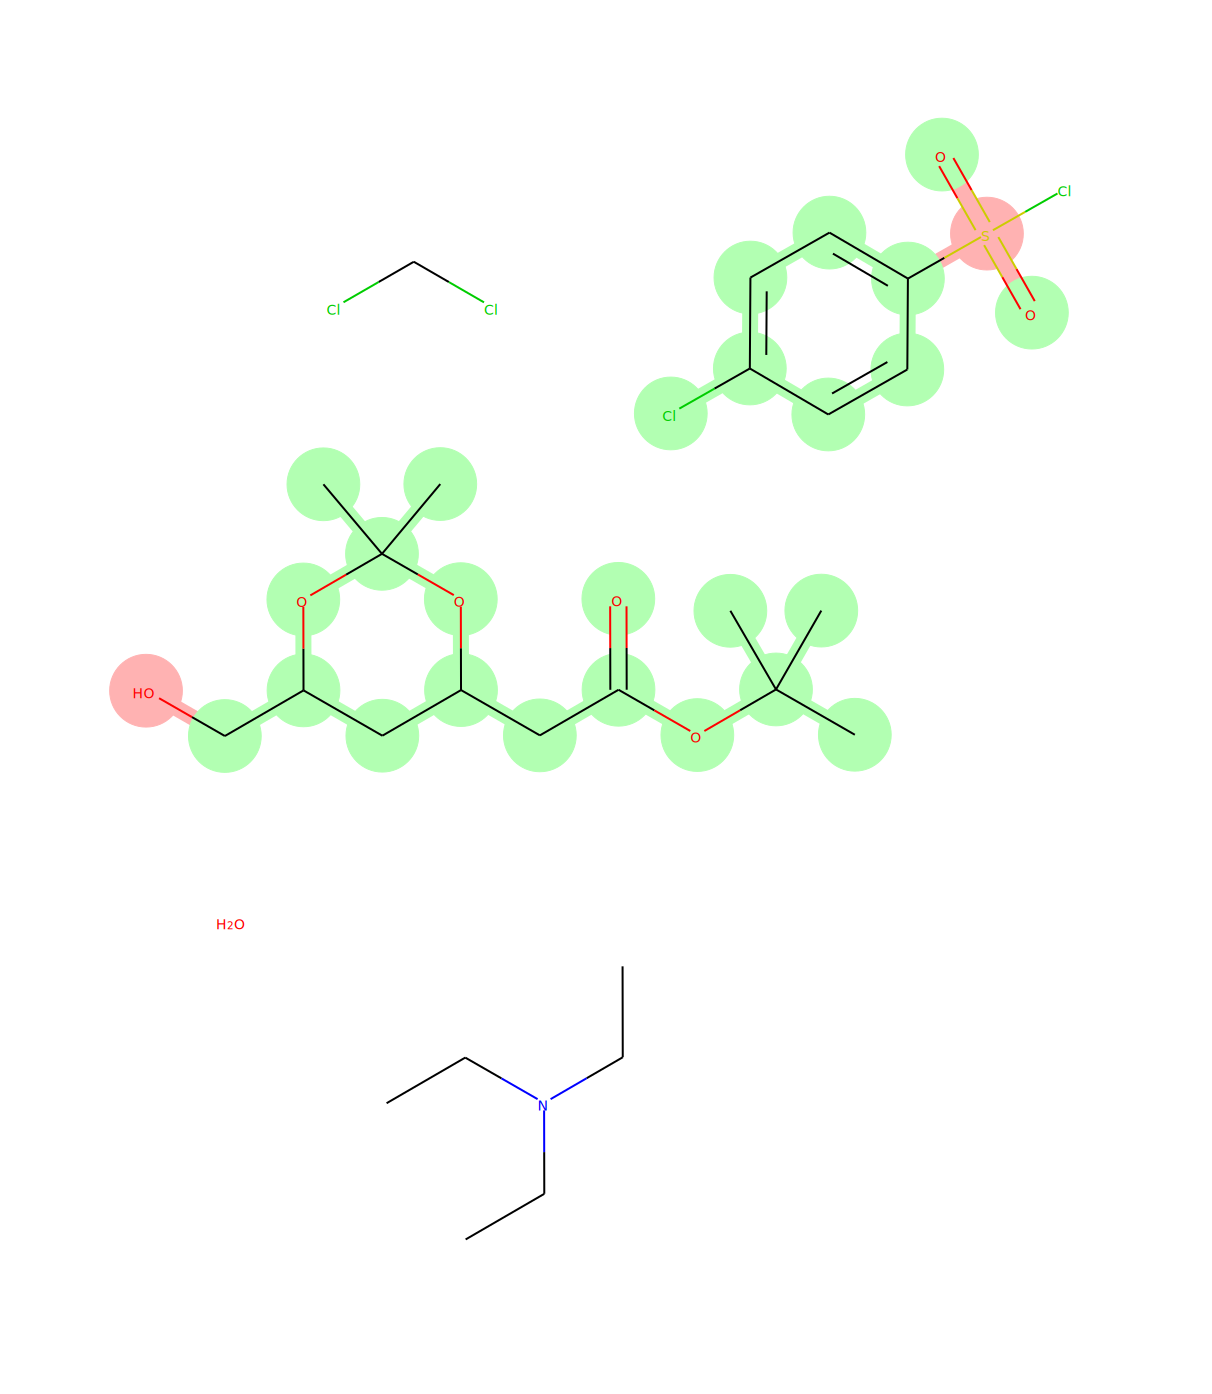

28083
1.9483068


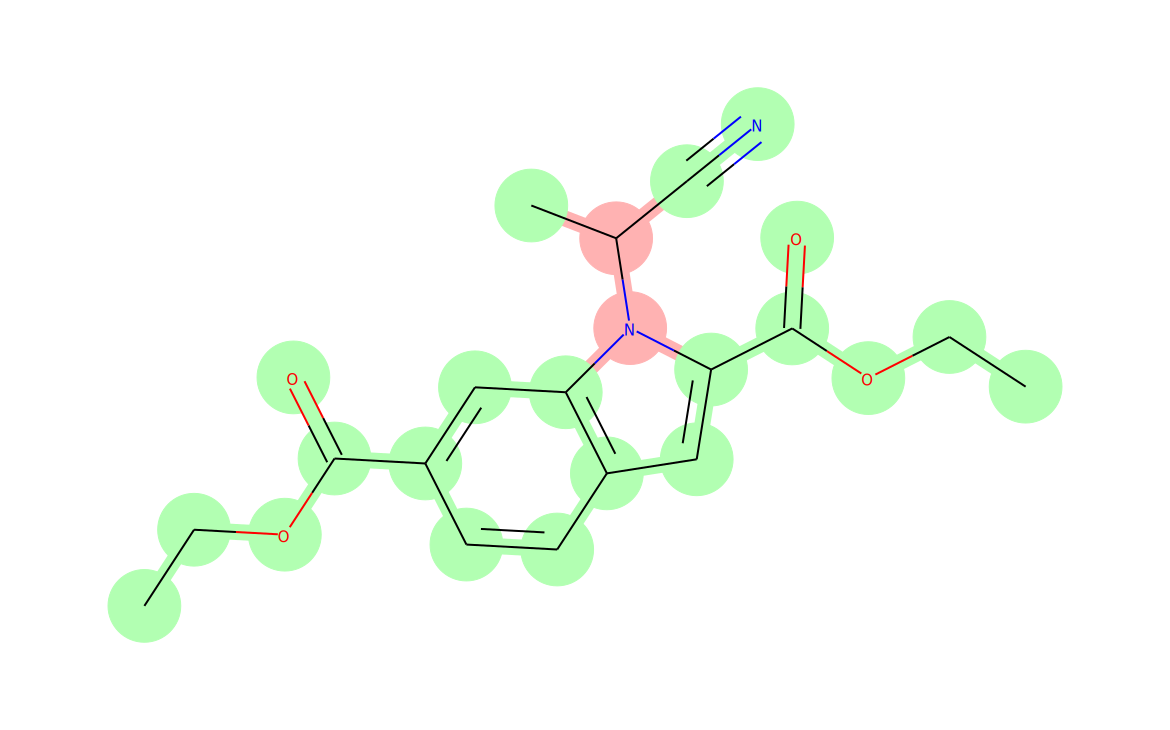

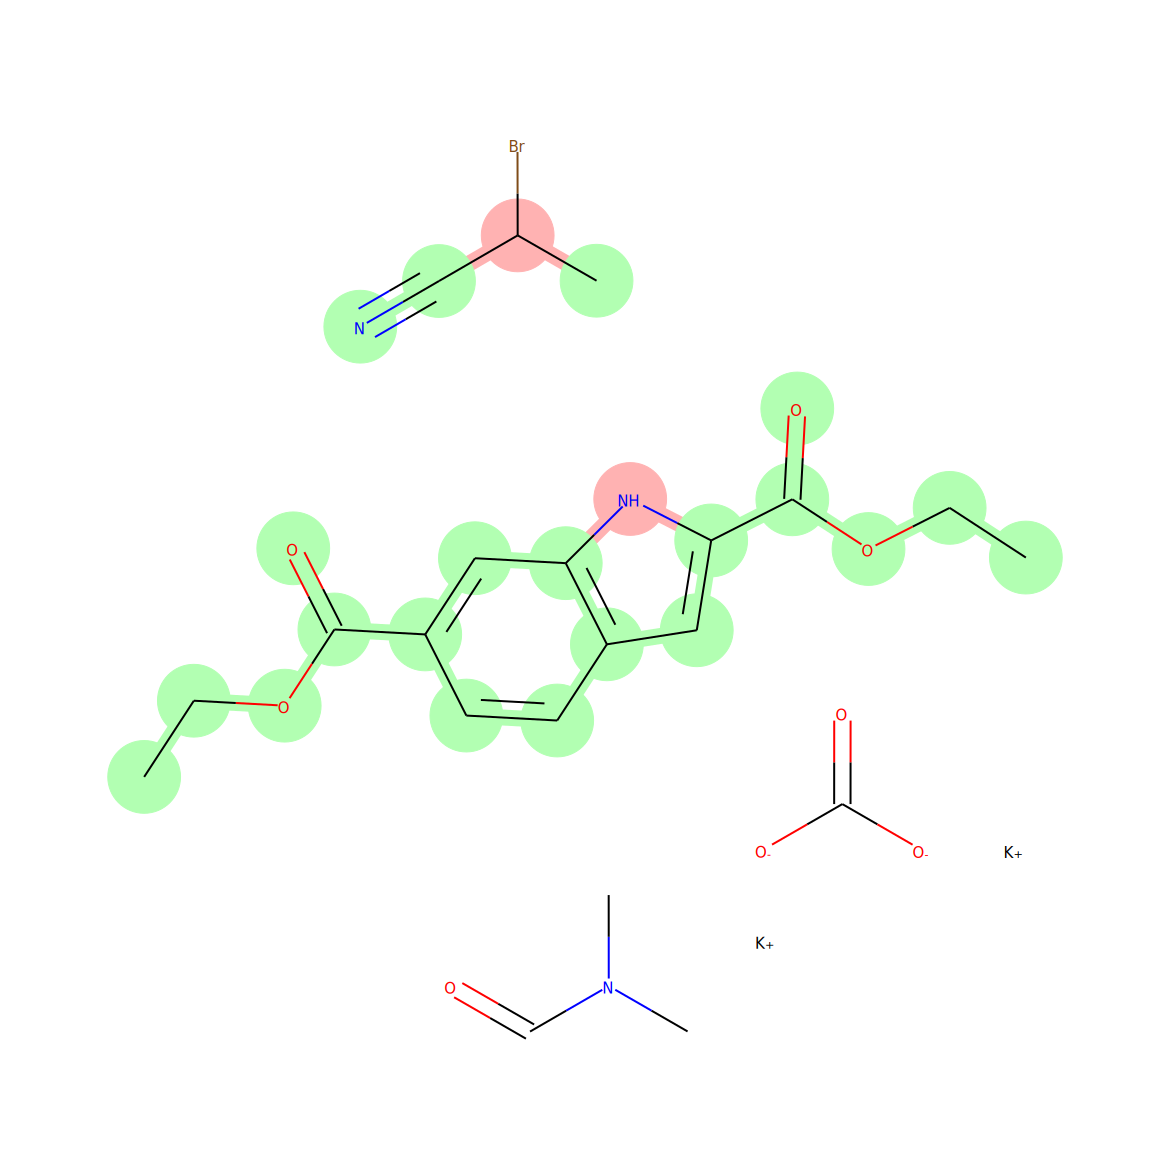

New center
44142
0.3172062


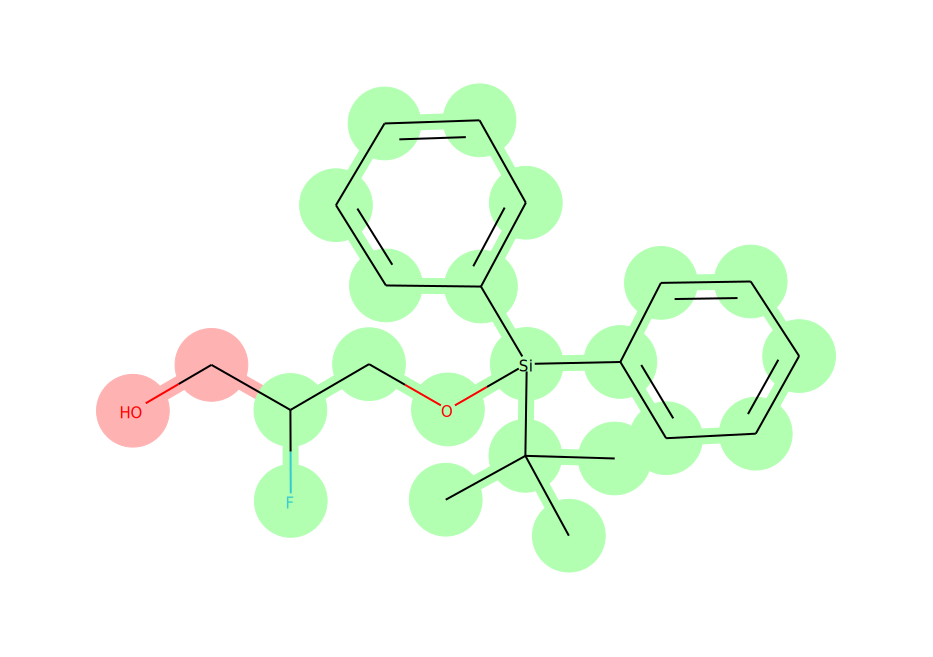

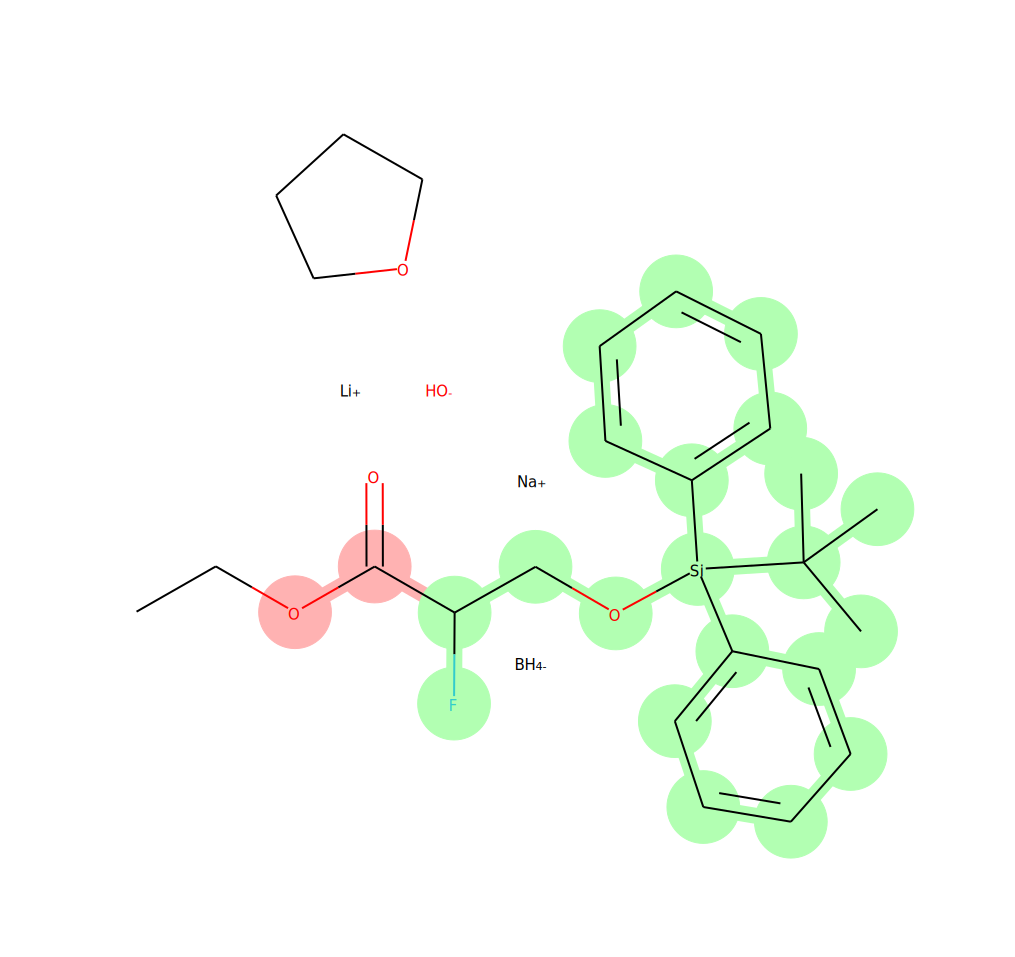

29689
0.52552134


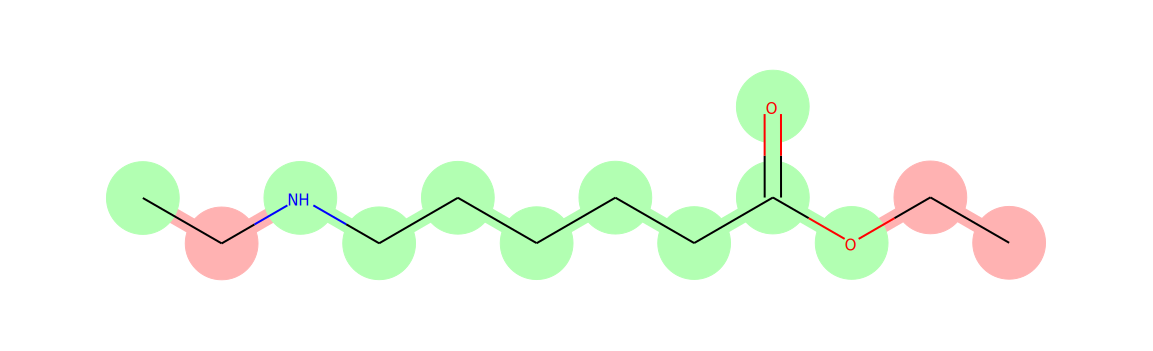

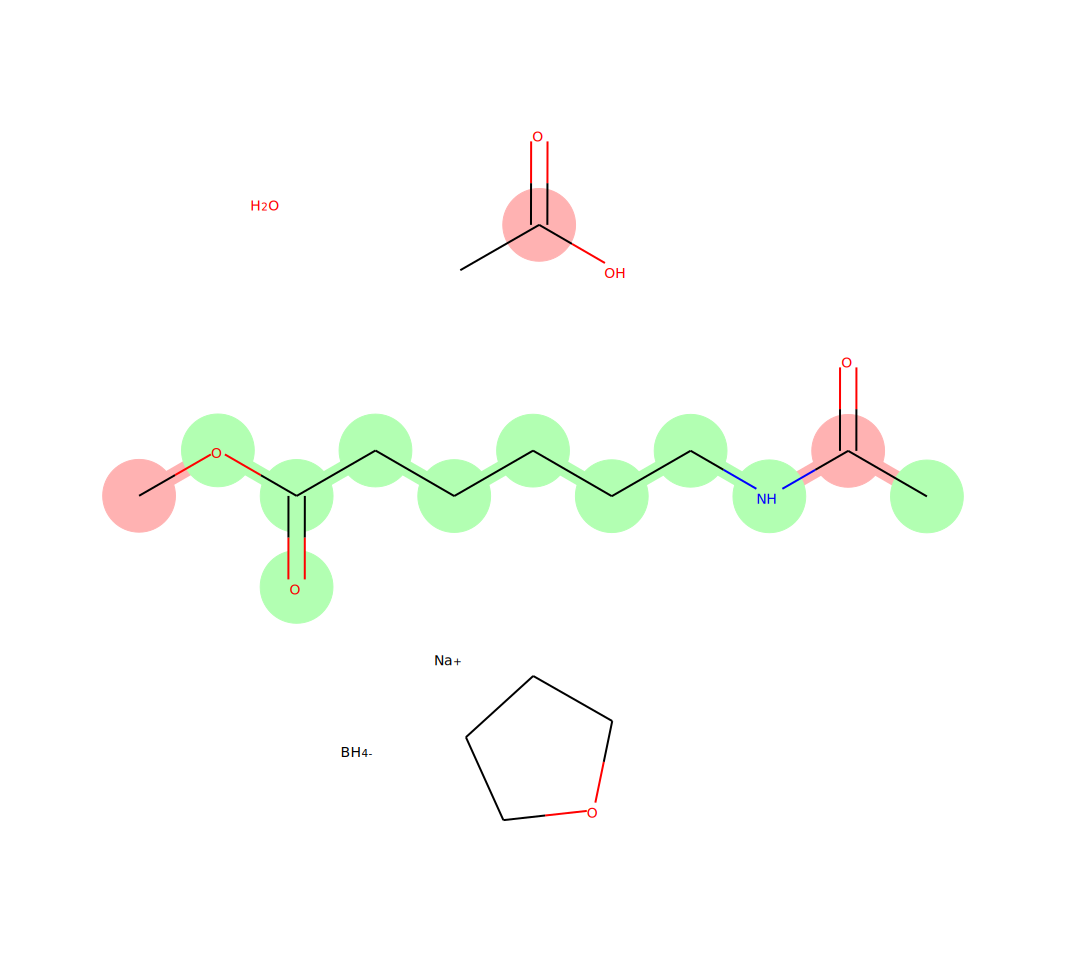

11925
0.5338551


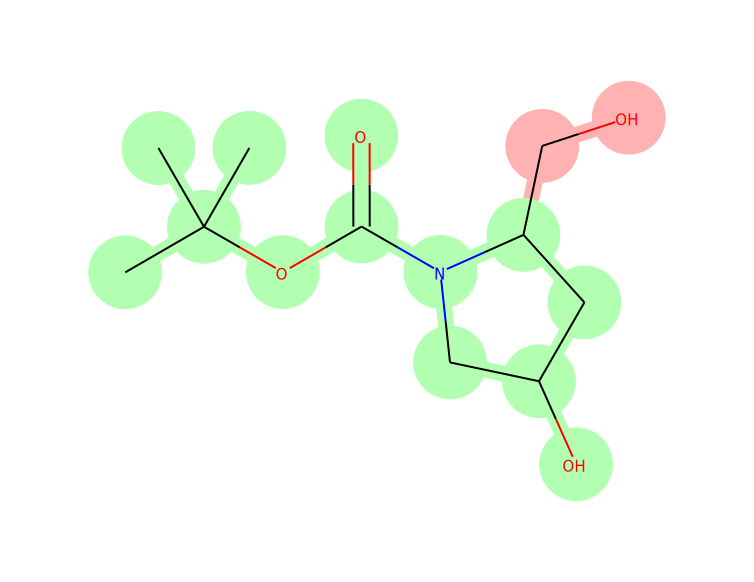

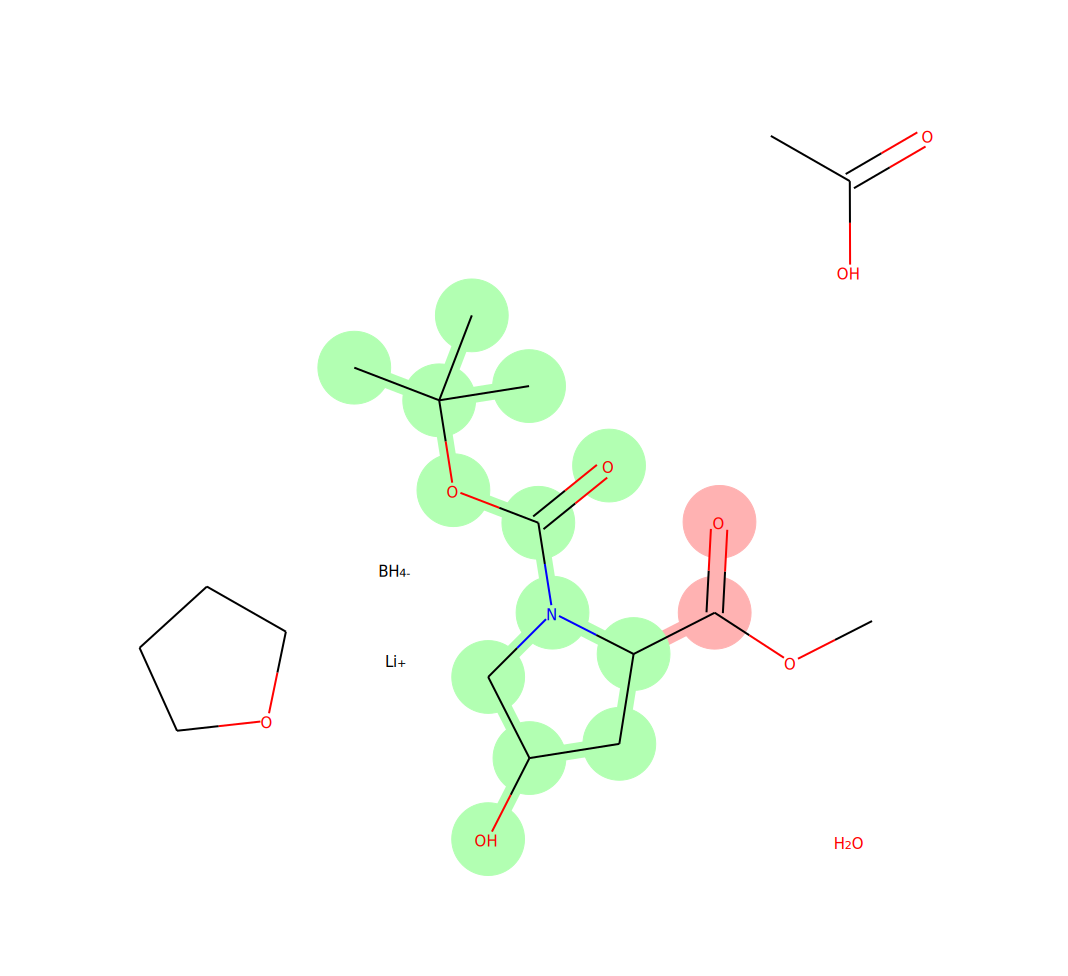

24293
0.8598558


RDKit WARNING: [00:39:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [00:39:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [00:39:24] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [00:39:24] WARNING: not removing hydrogen atom without neighbors


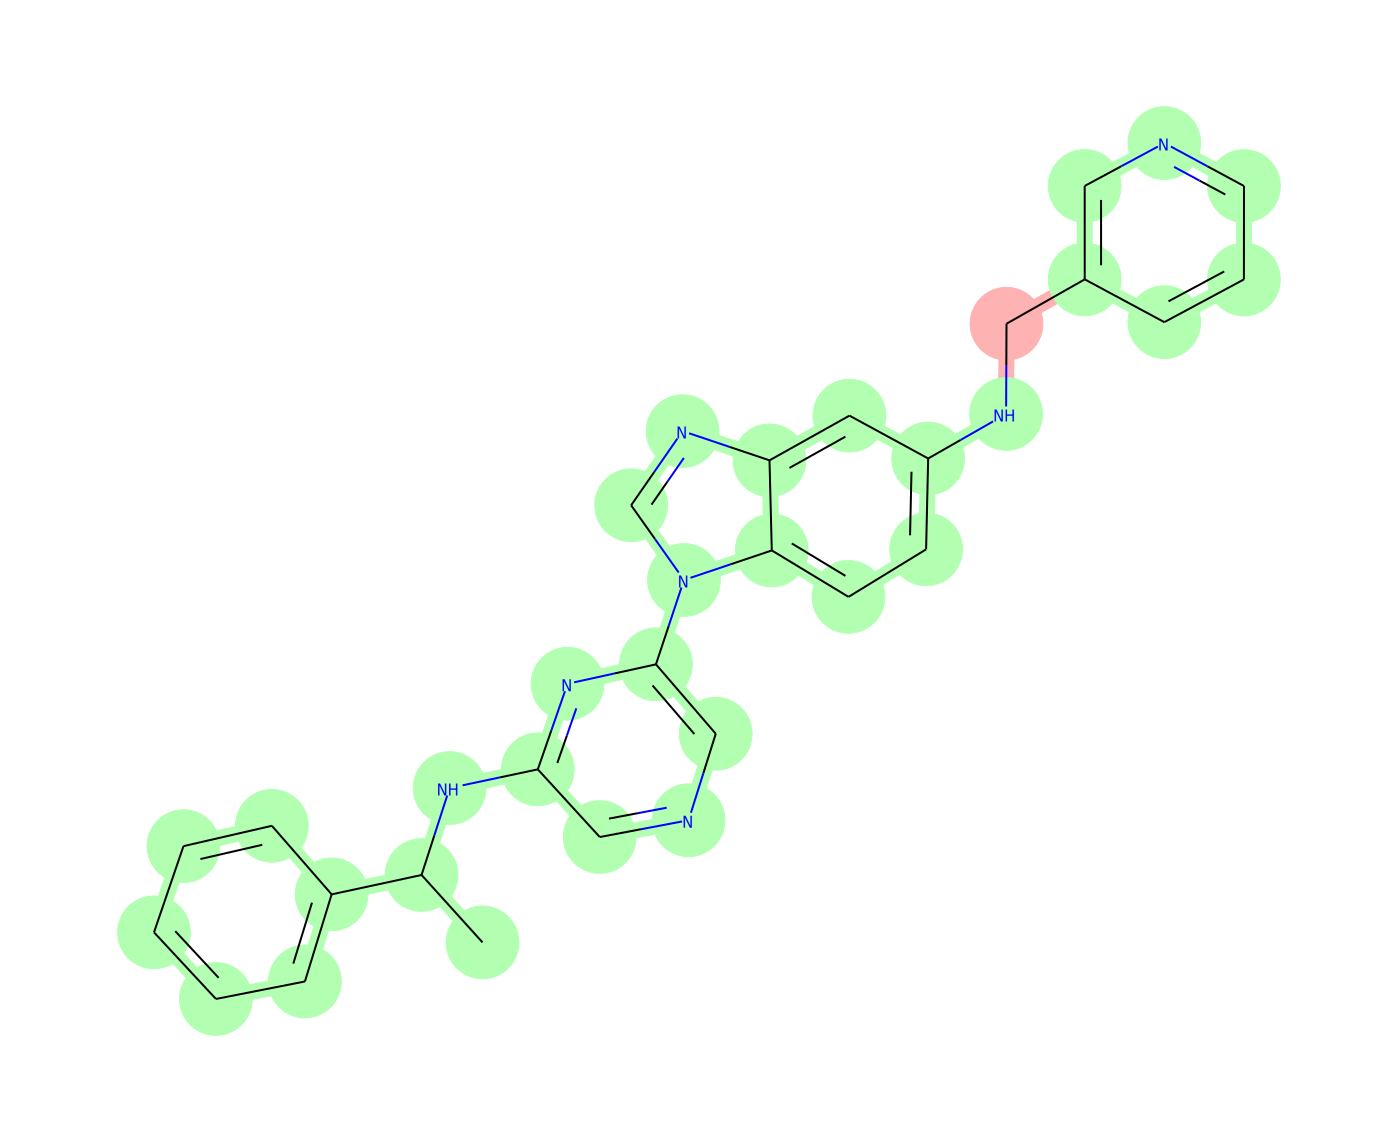

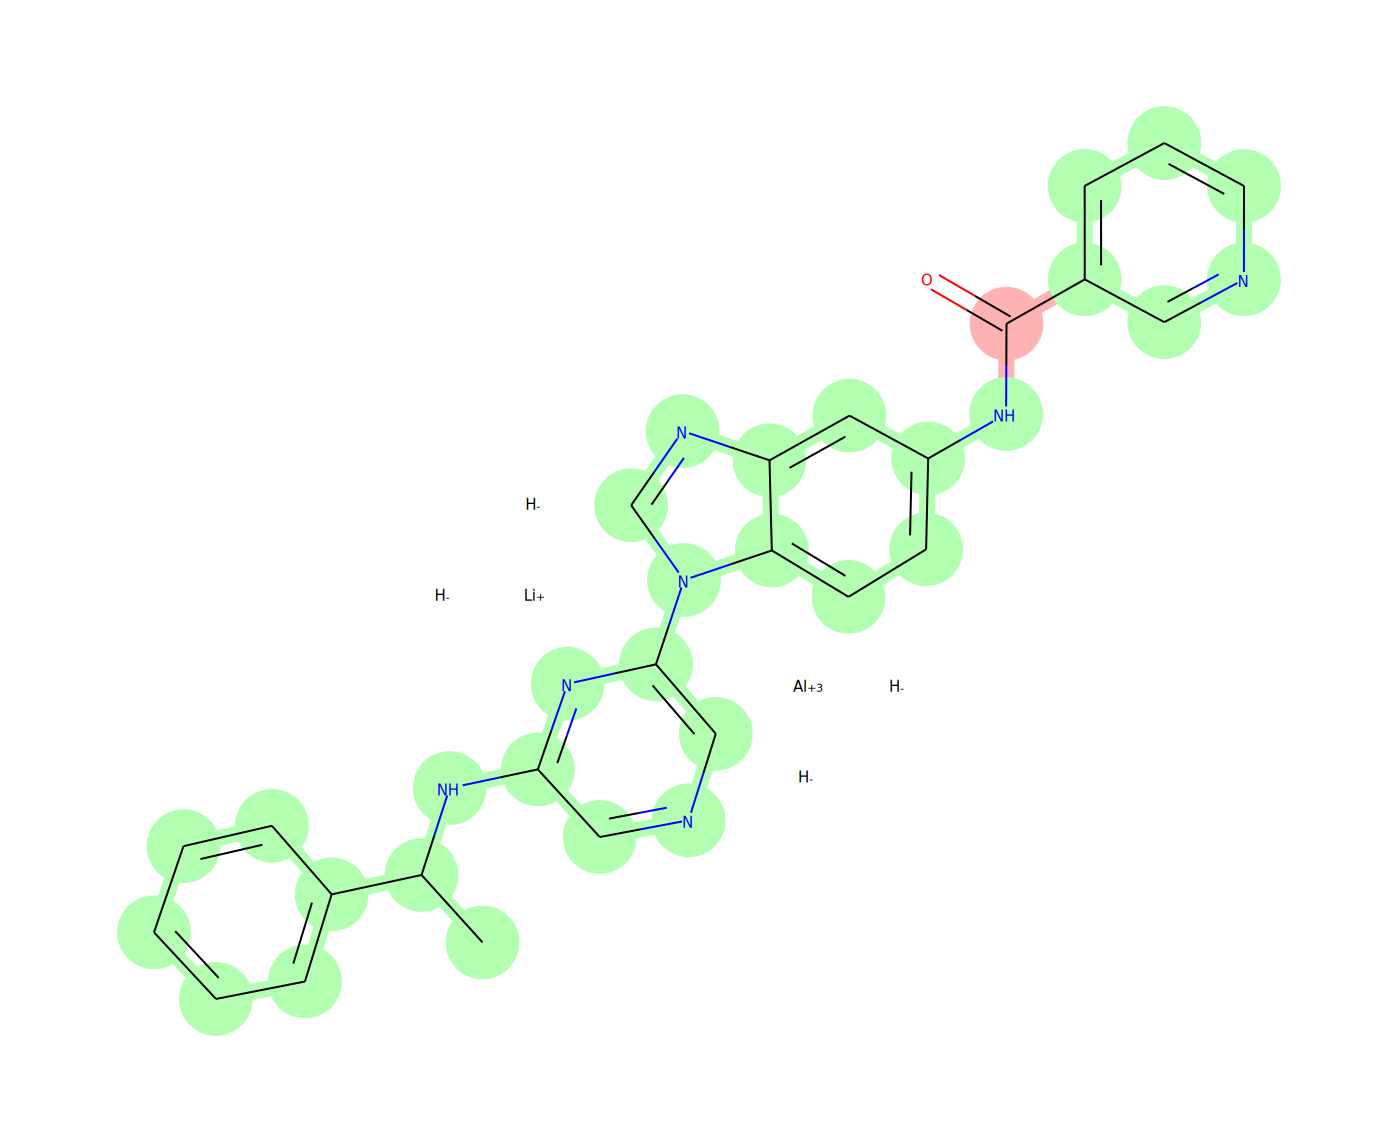

24277
6.4897723


RDKit WARNING: [00:39:24] WARNING: not removing hydrogen atom without neighbors


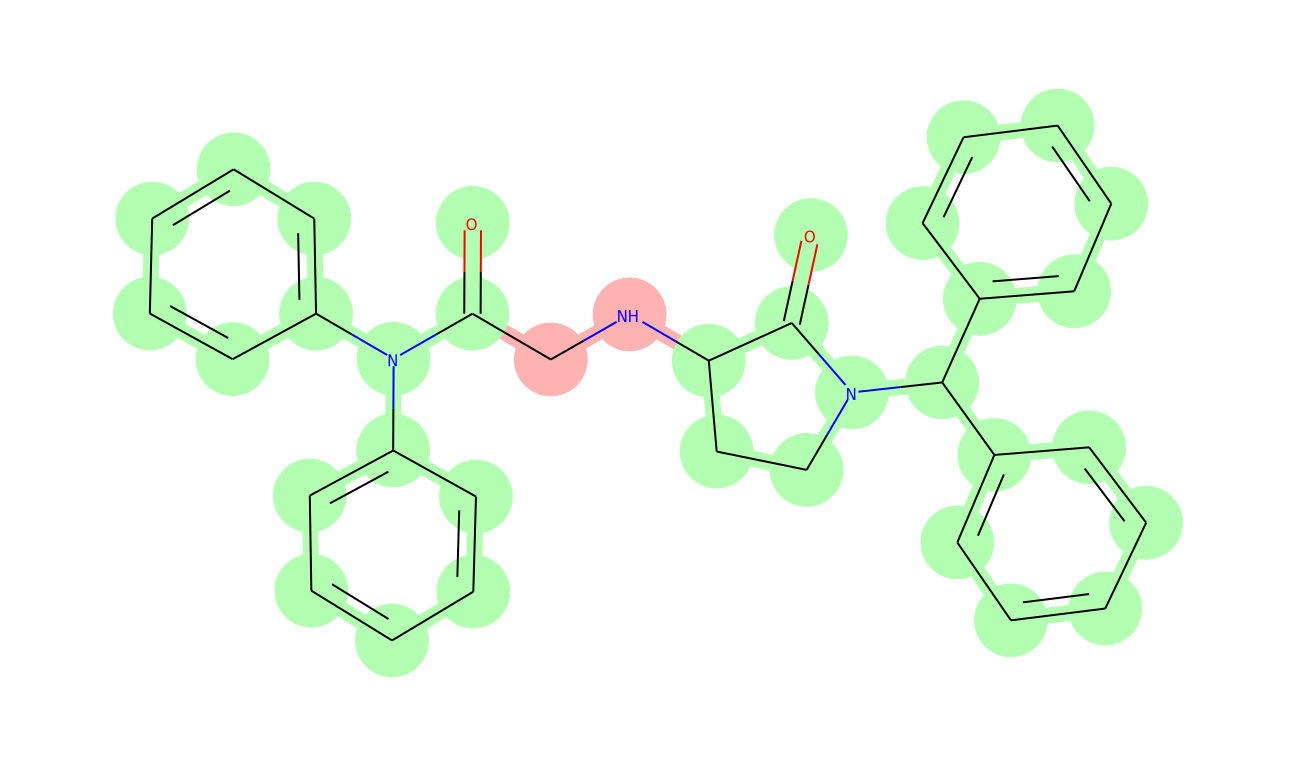

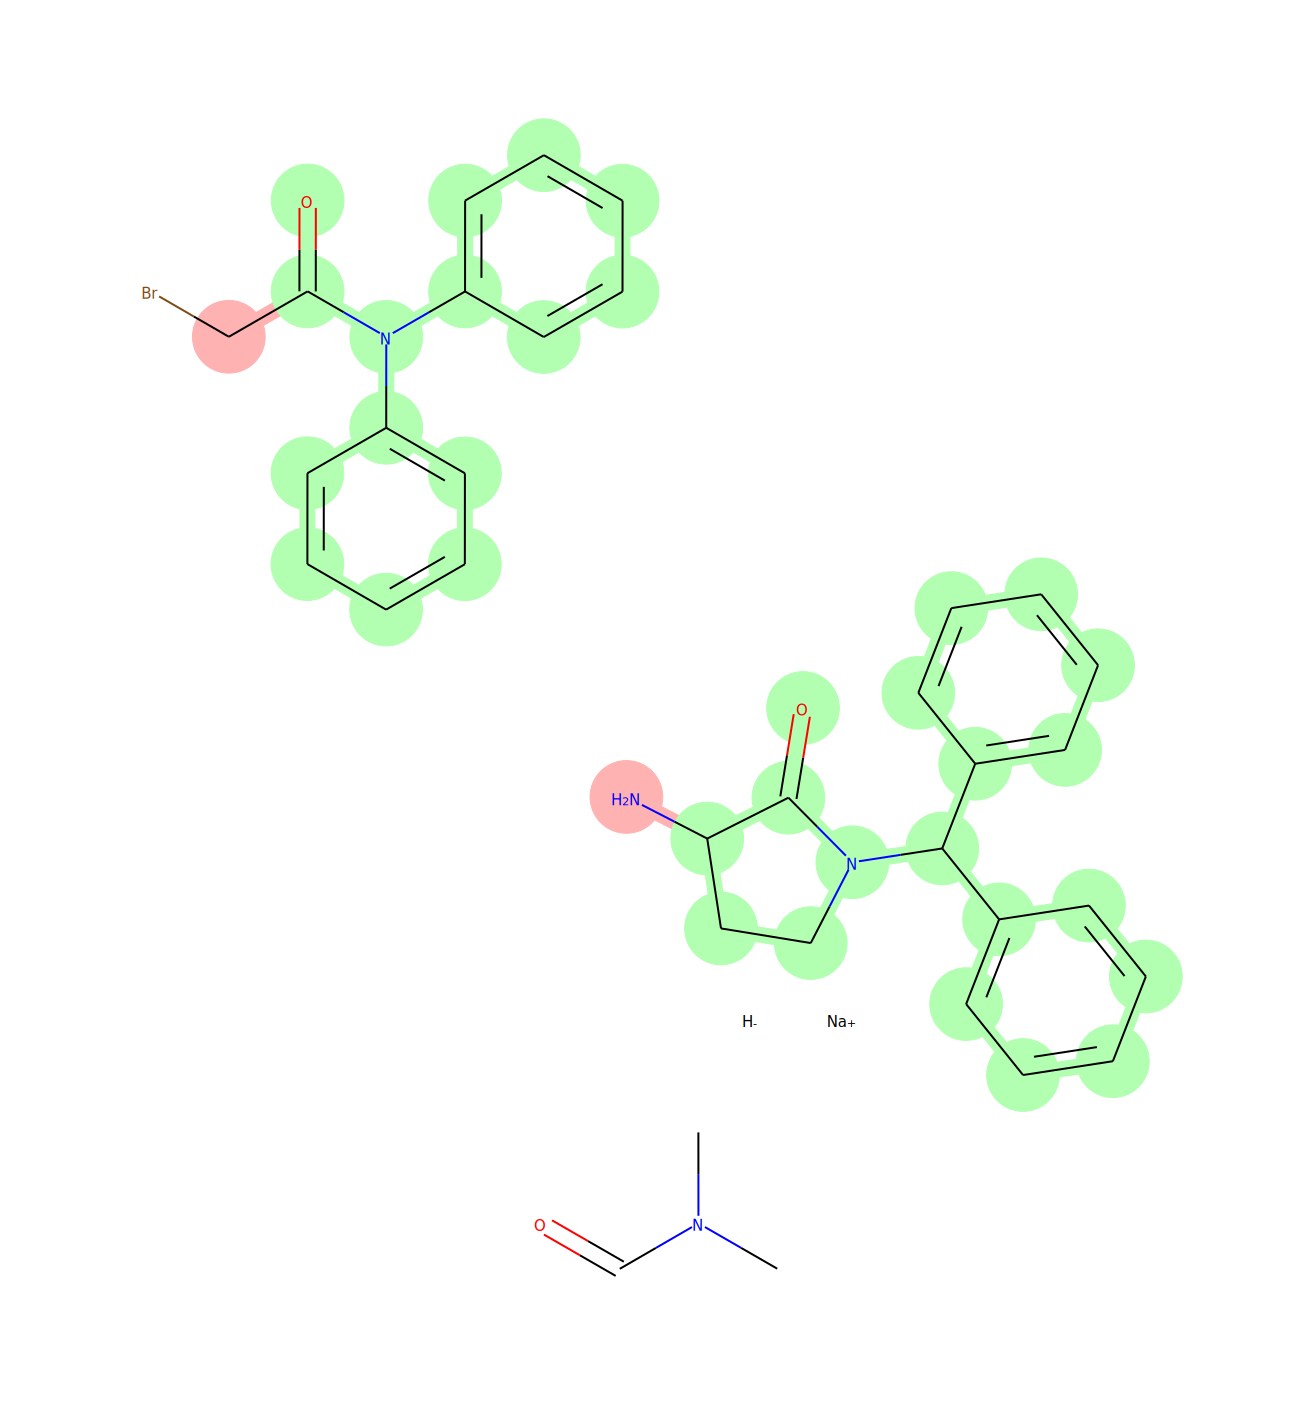

New center
45361
0.305621


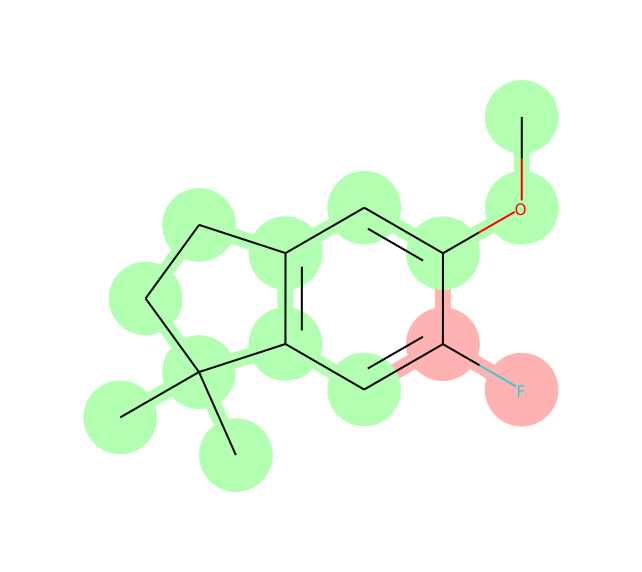

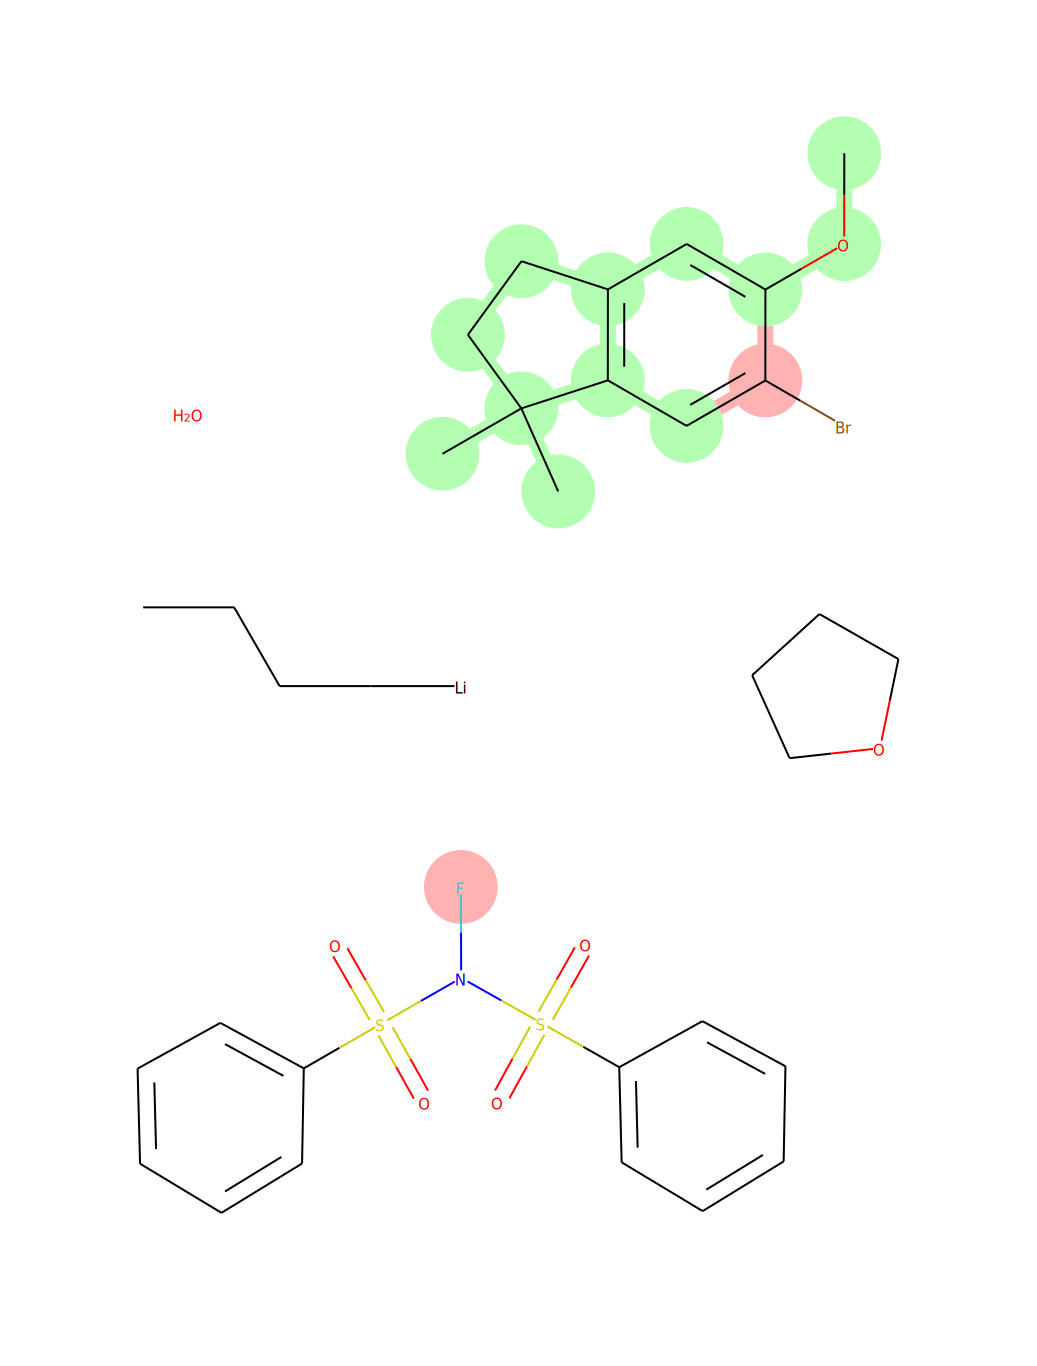

5966
0.35431197


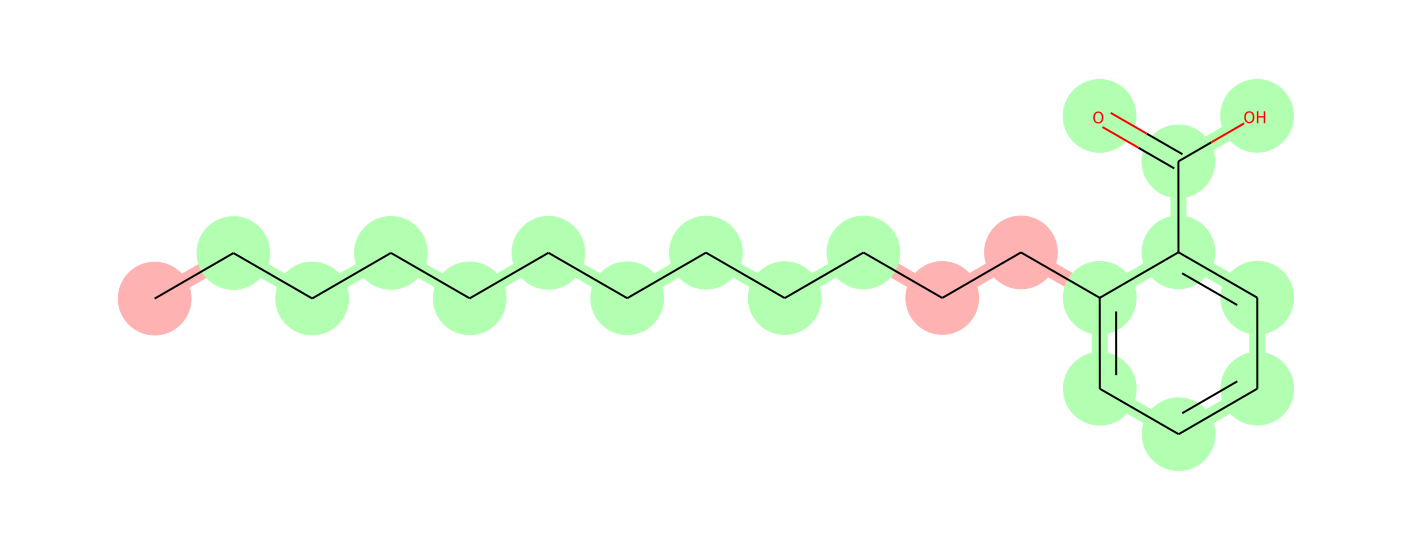

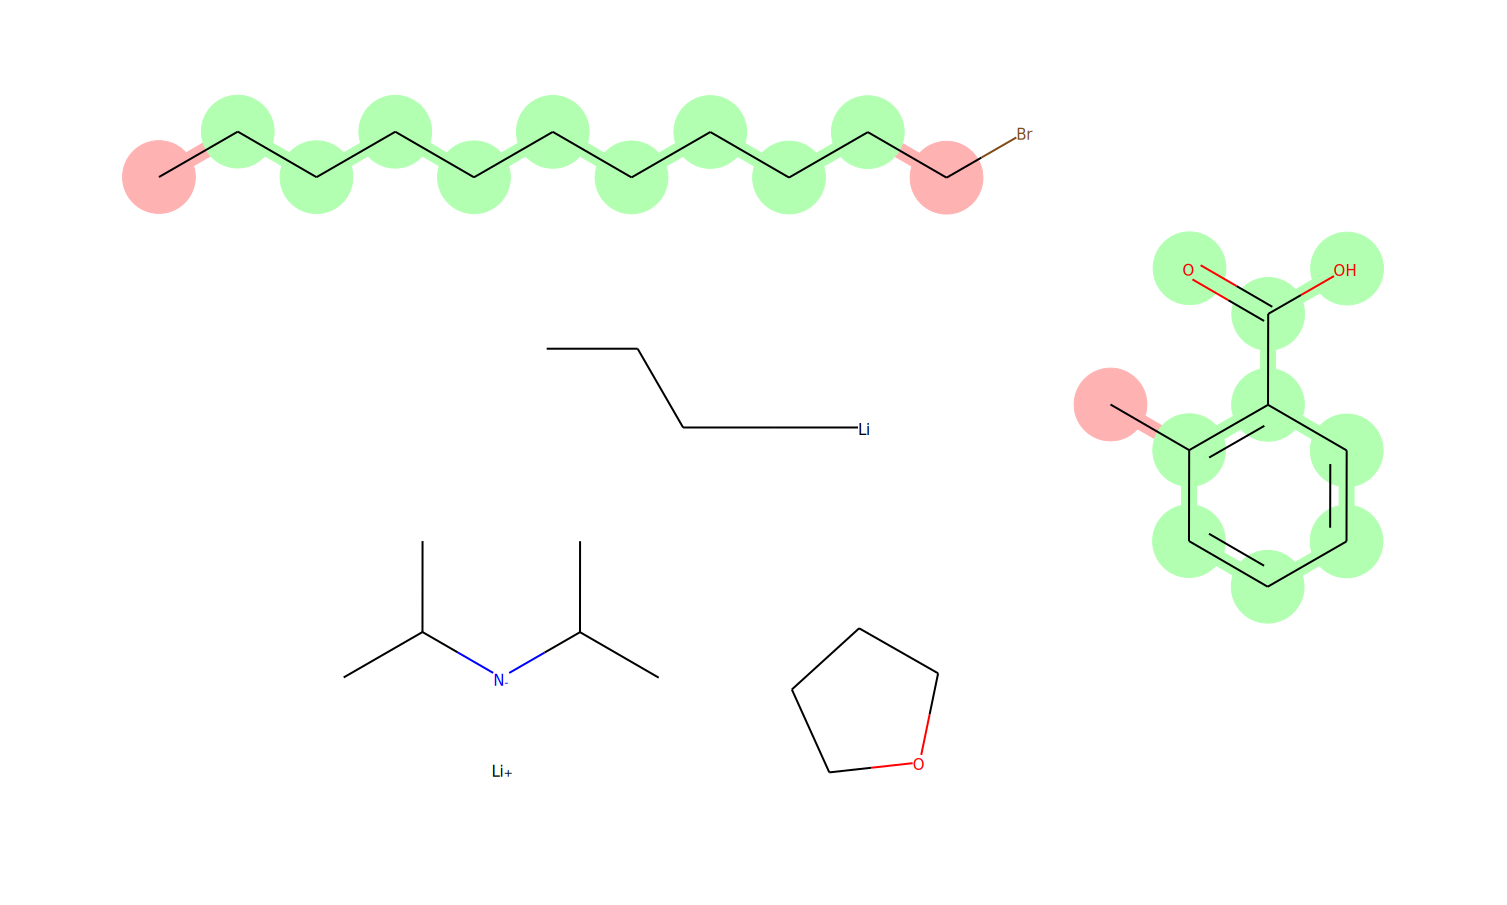

41964
0.44193885


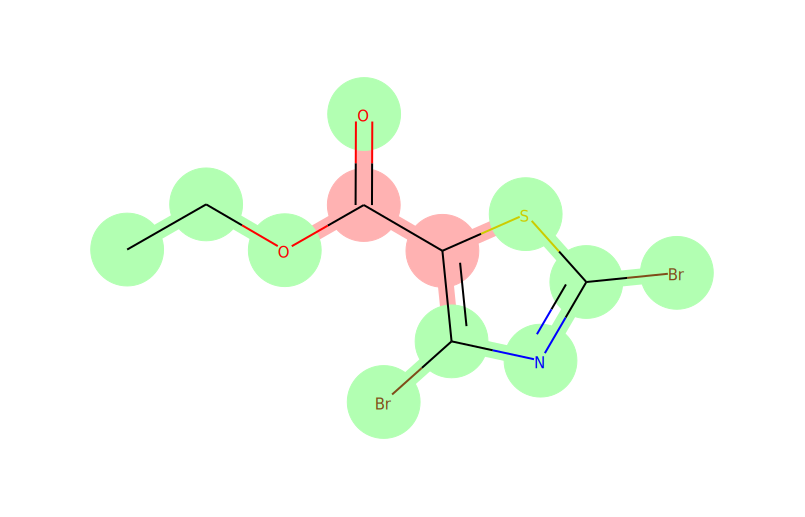

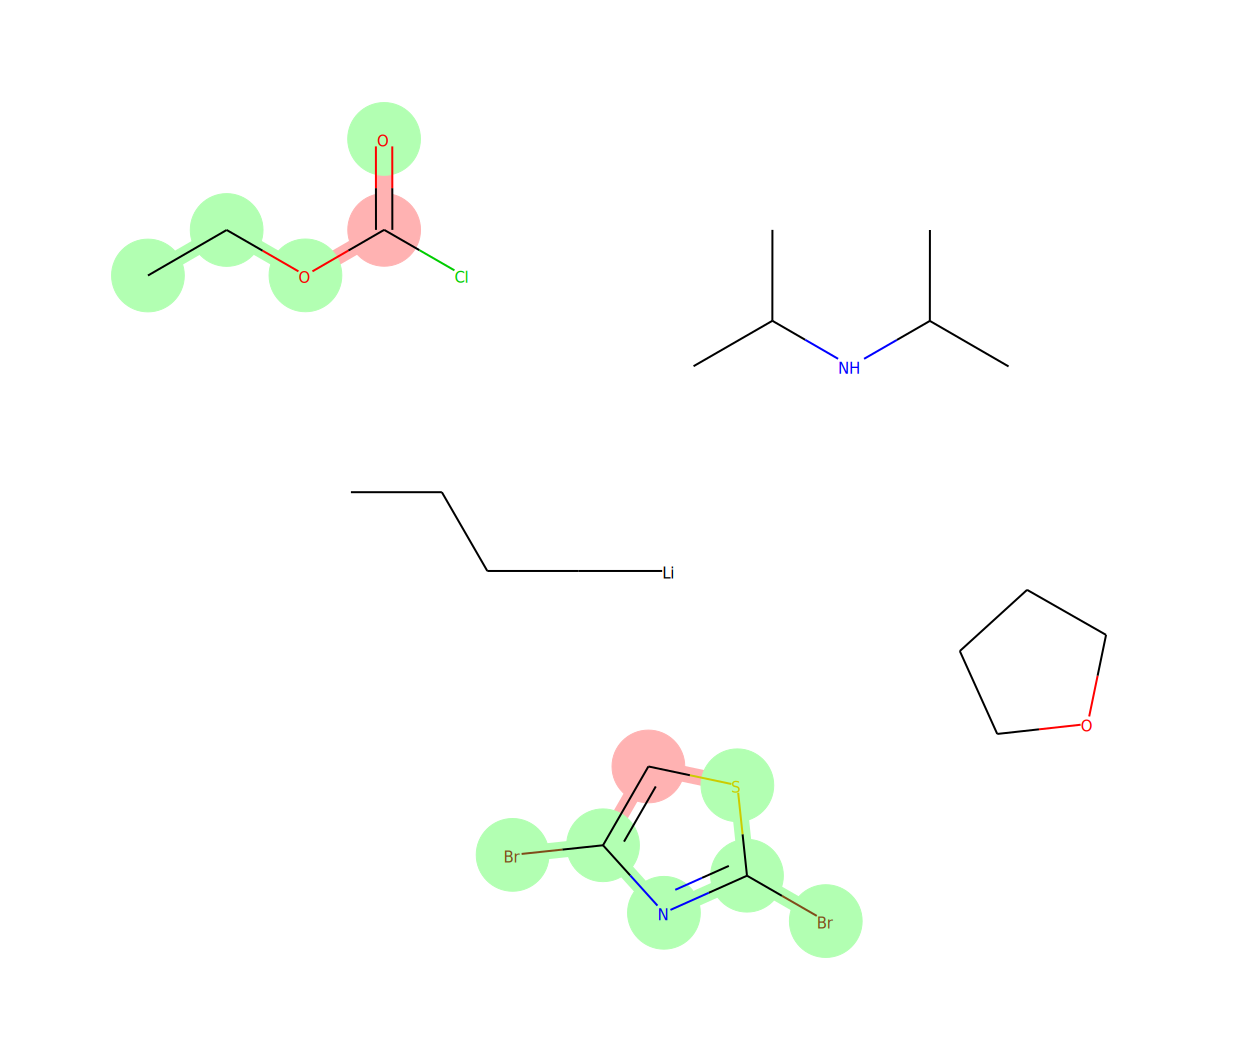

35474
0.845677


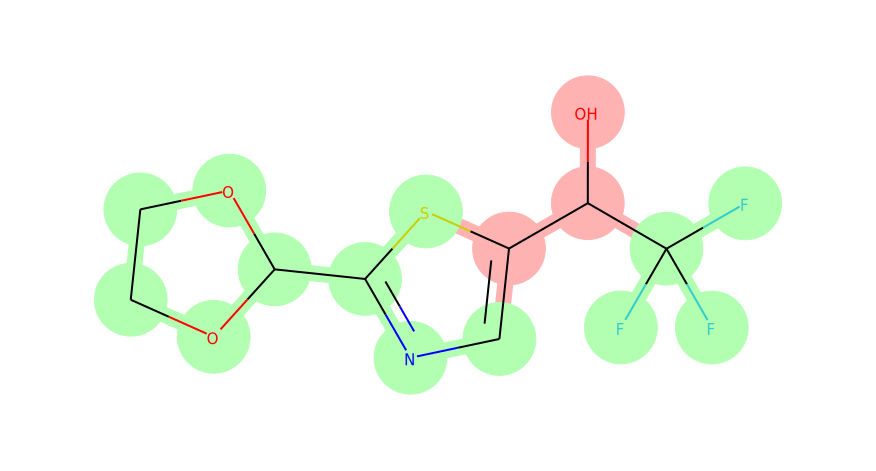

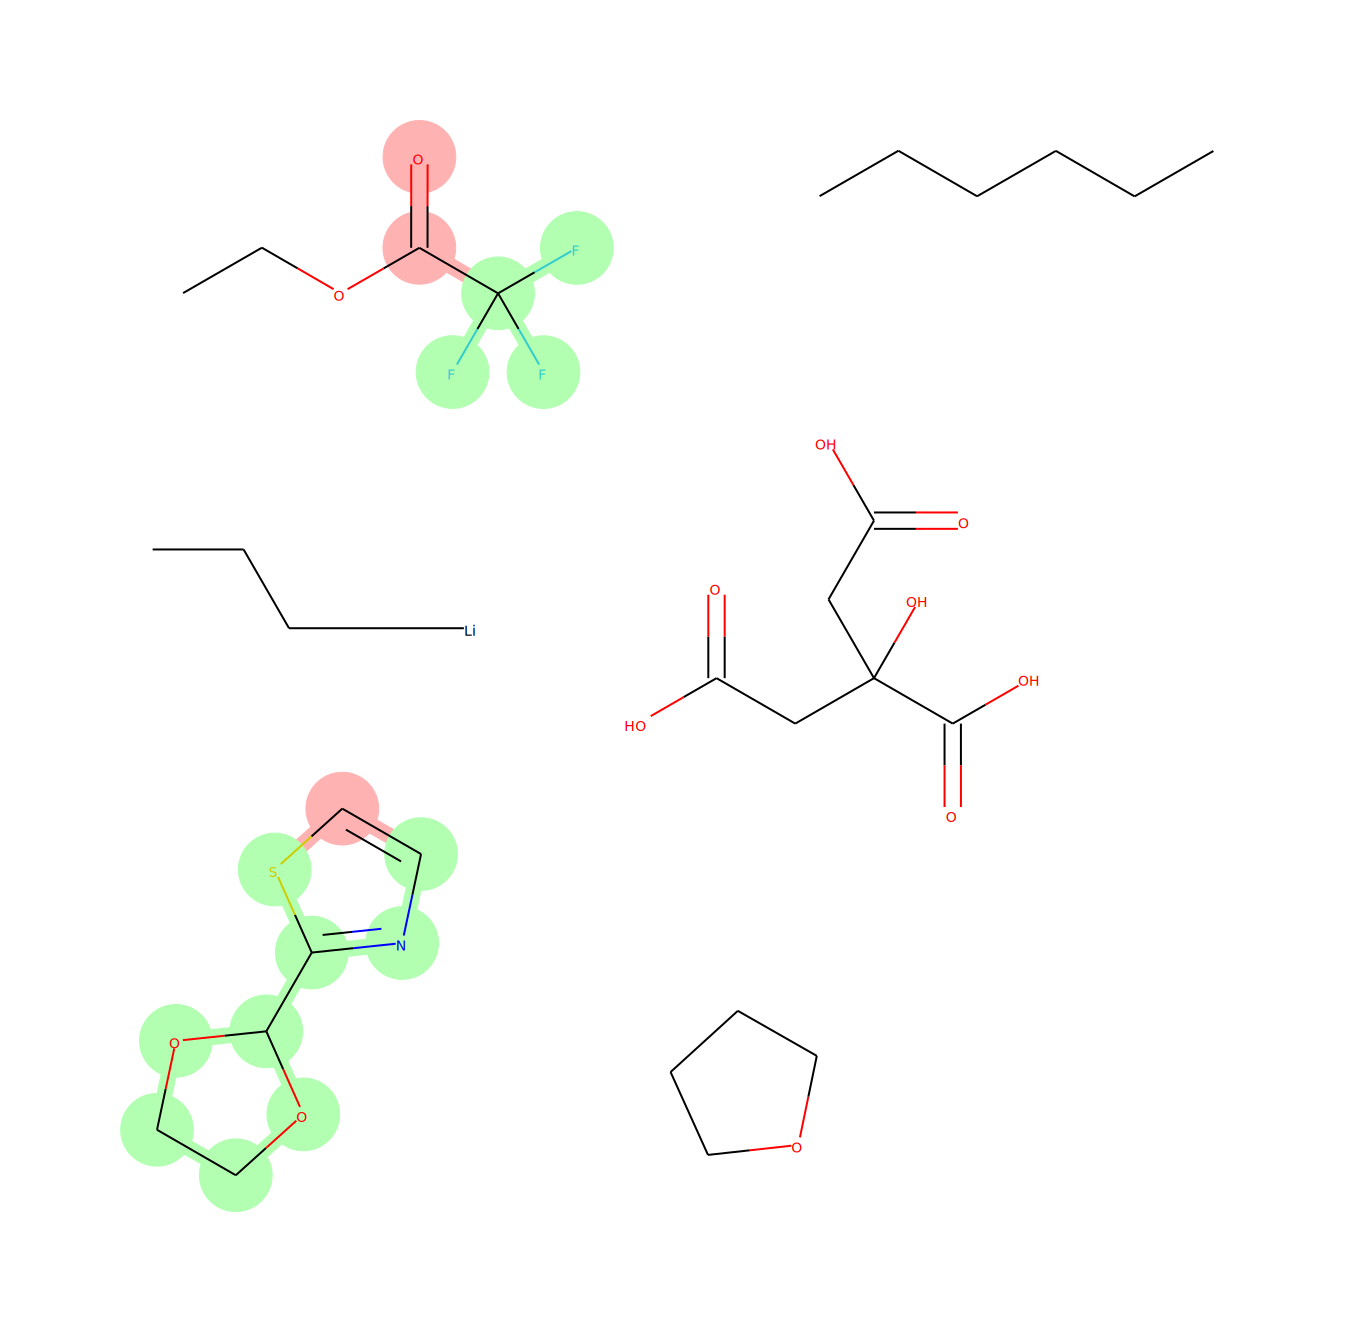

44828
4.621135


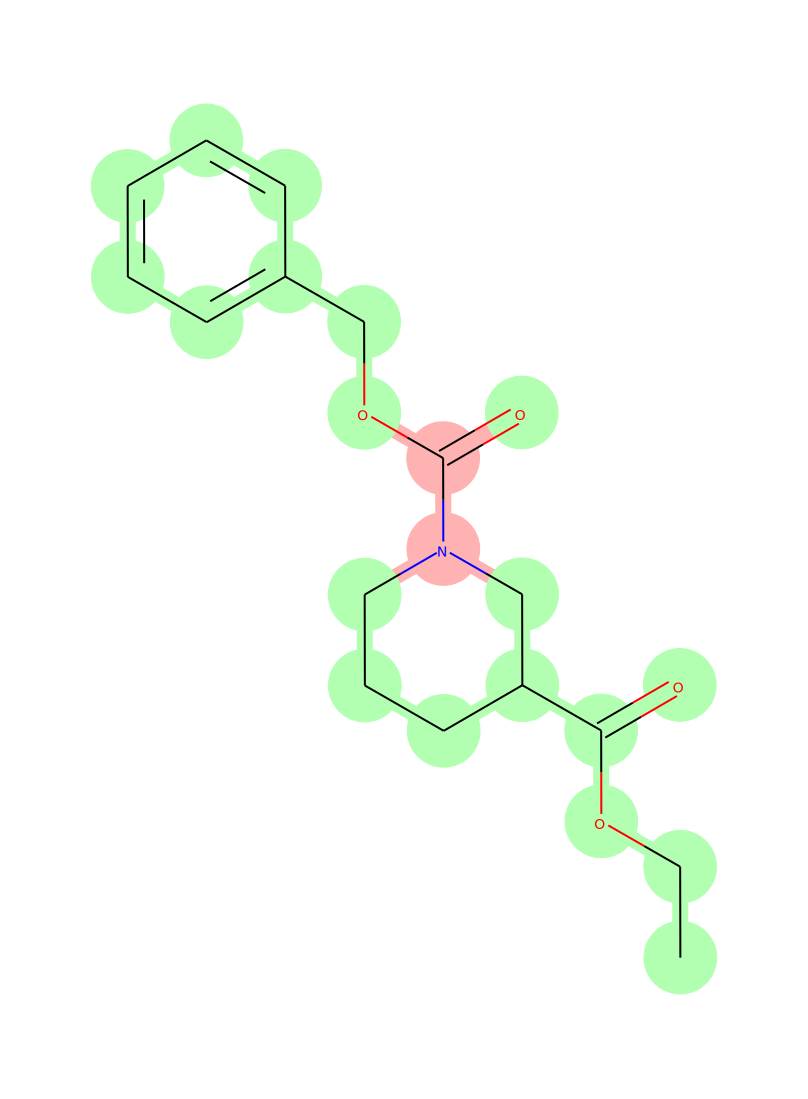

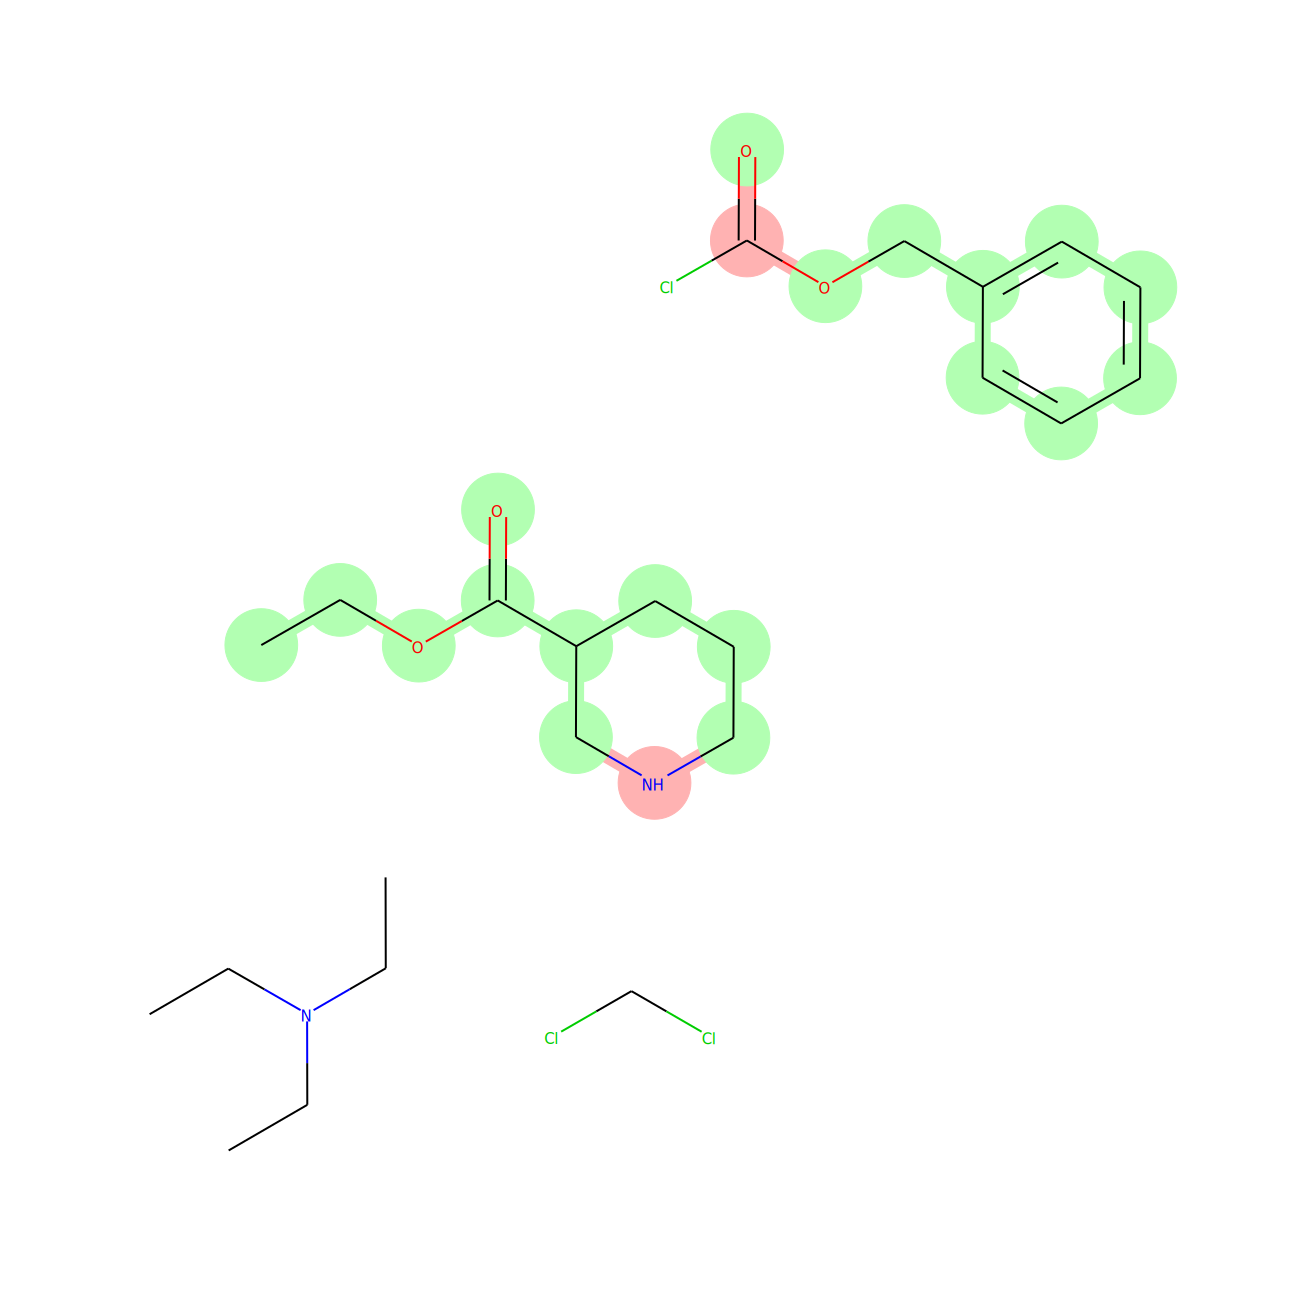

New center
2486
0.40749925


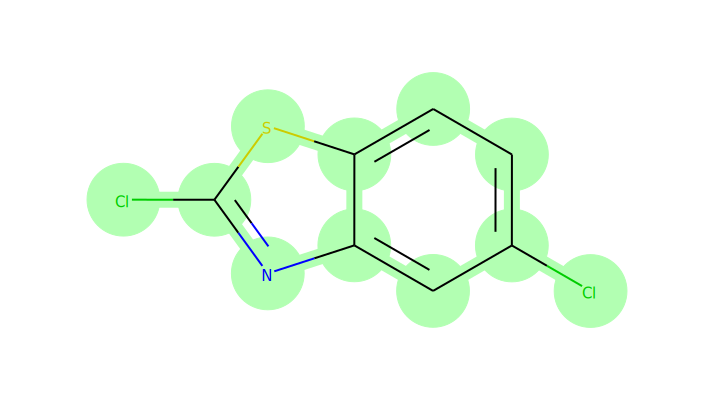

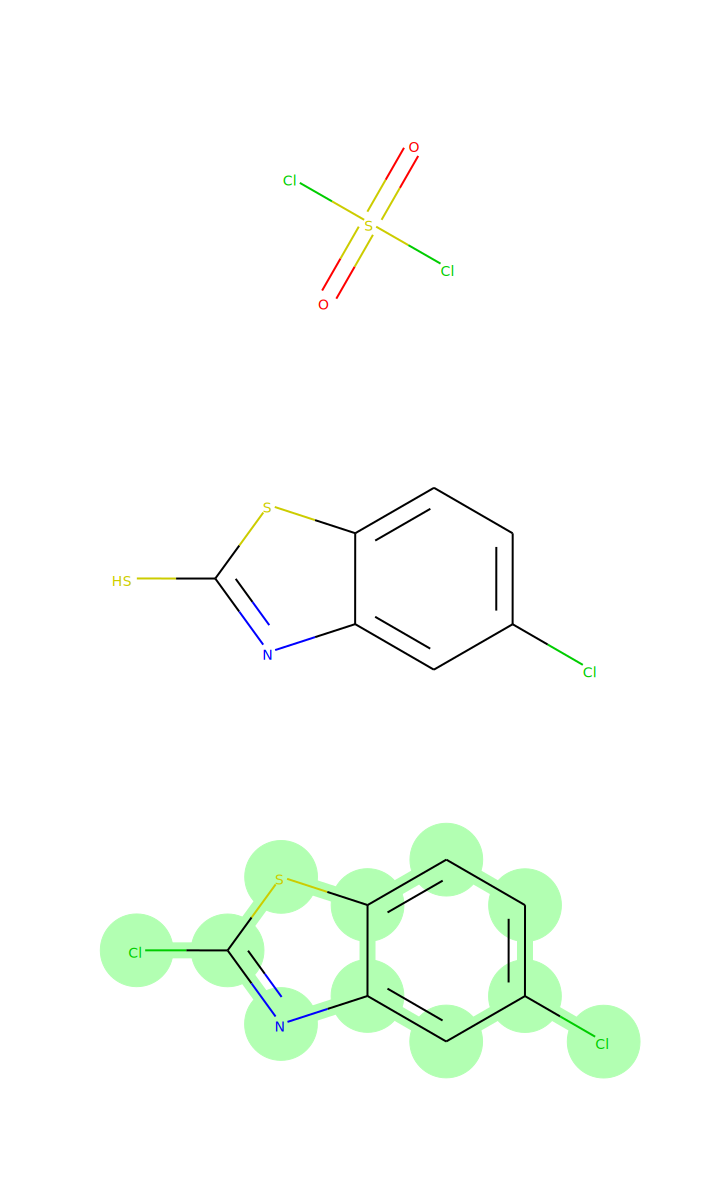

2494
0.45280078


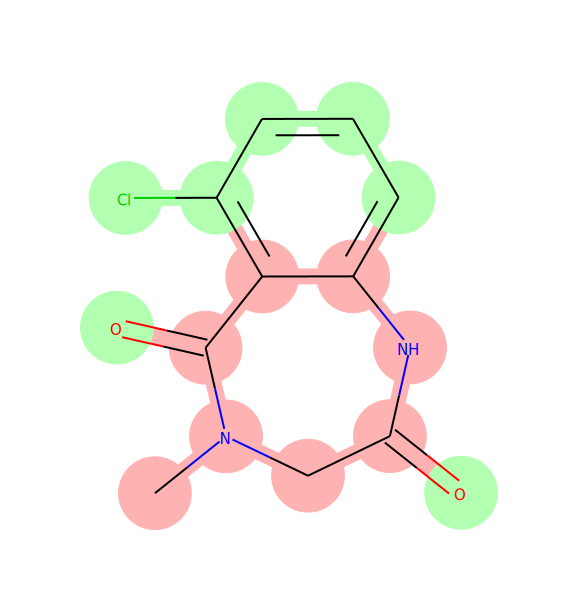

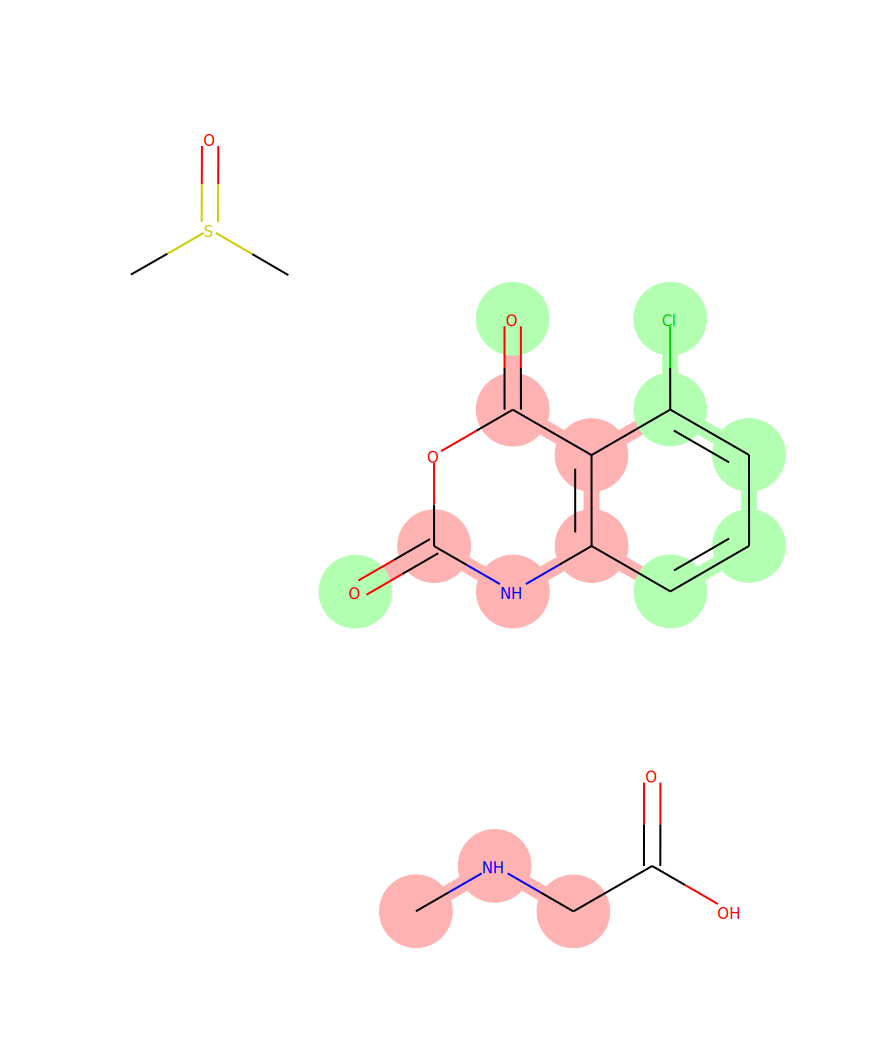

547
0.45679668


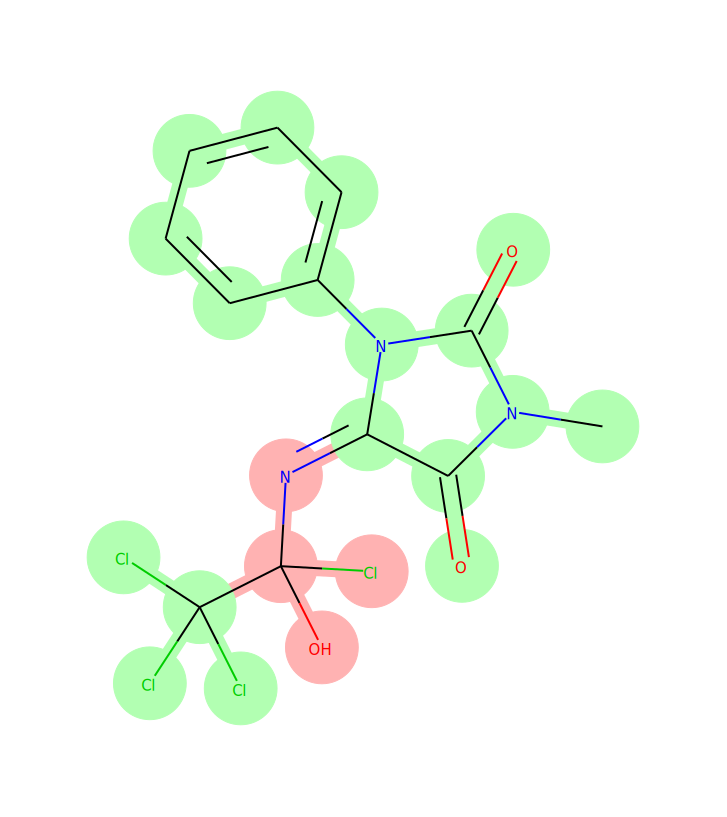

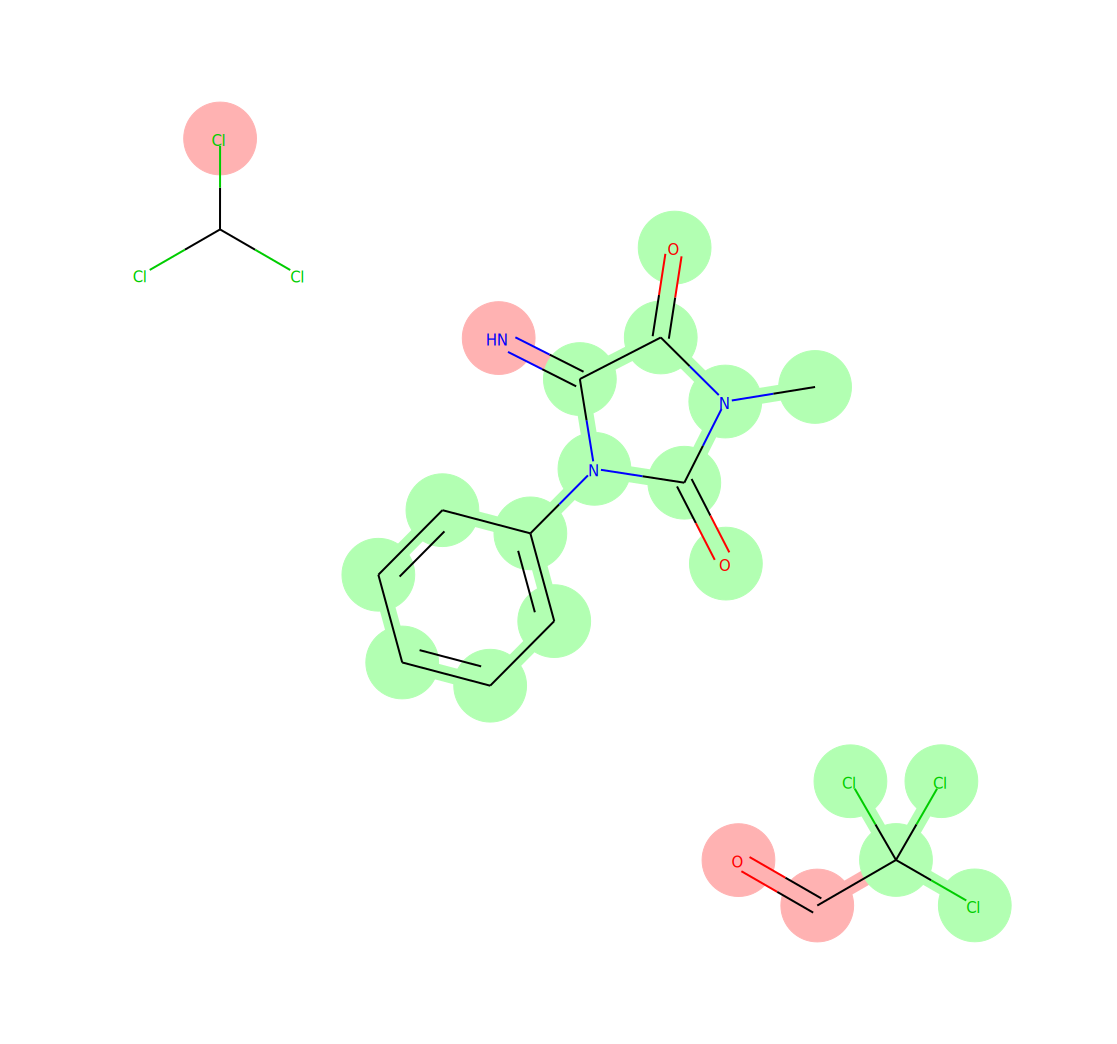

34703
0.5610832


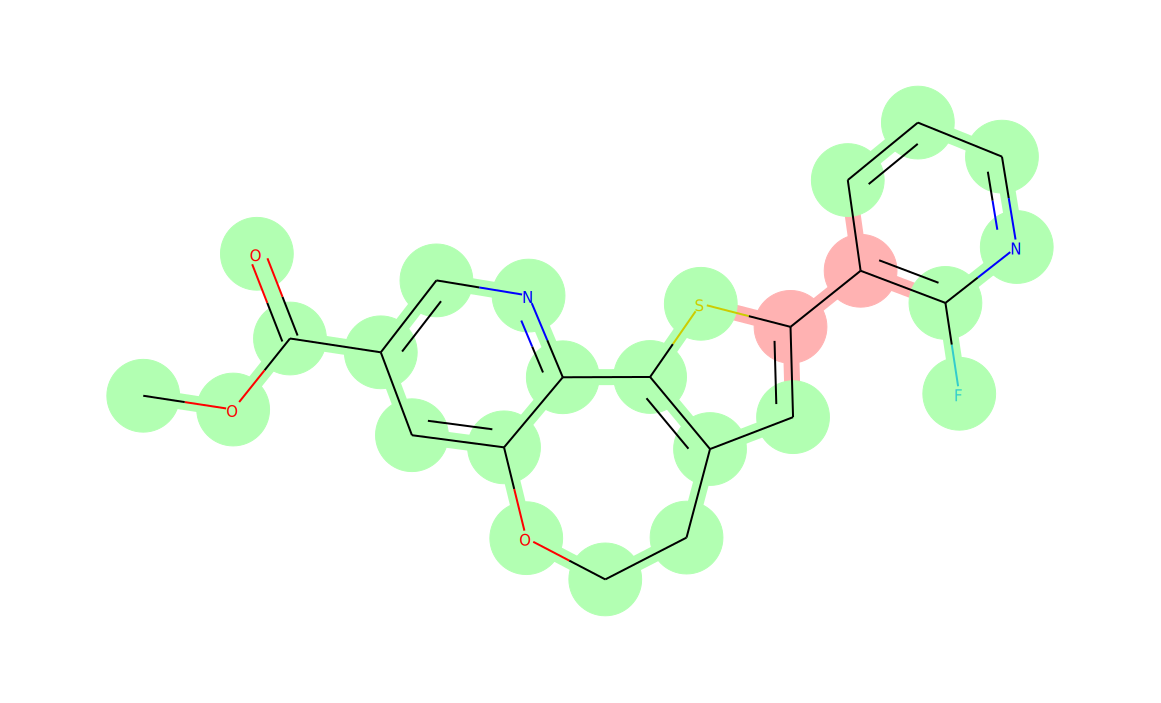

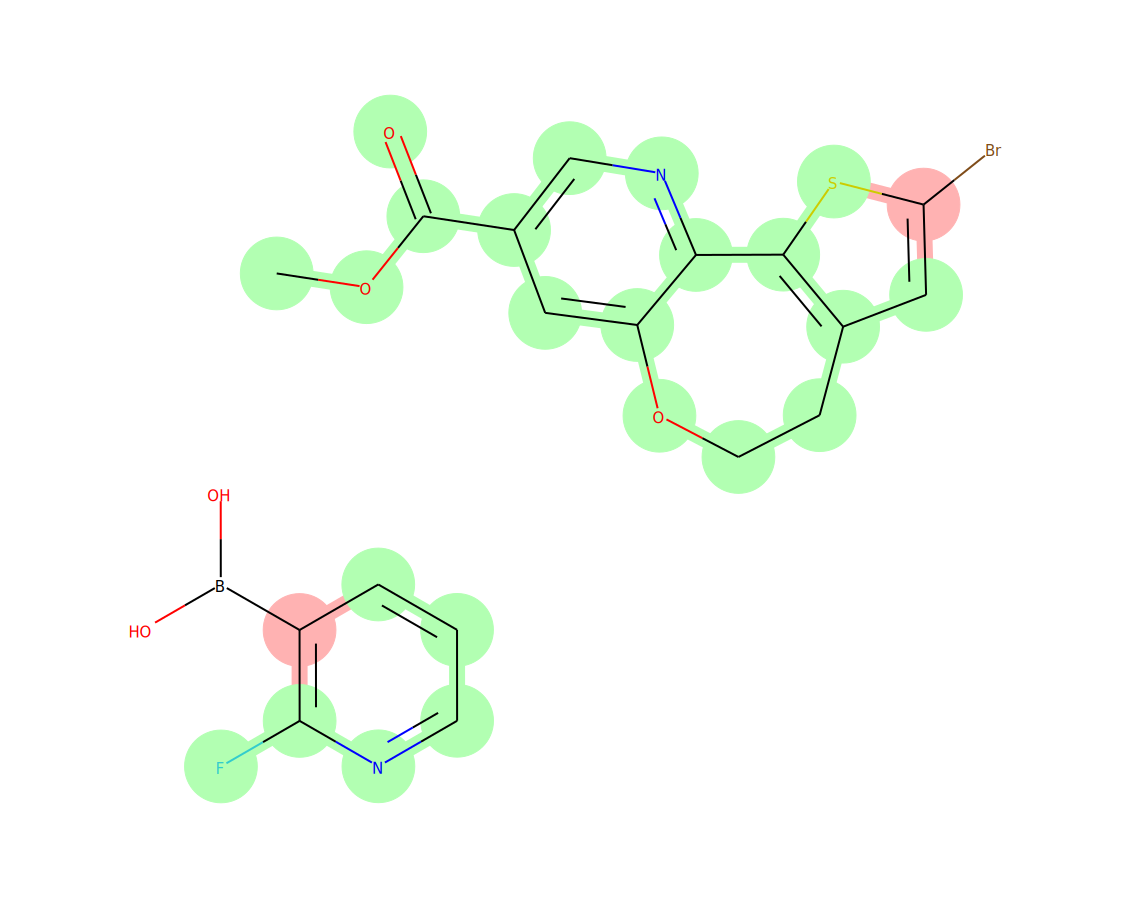

34832
2.0978873


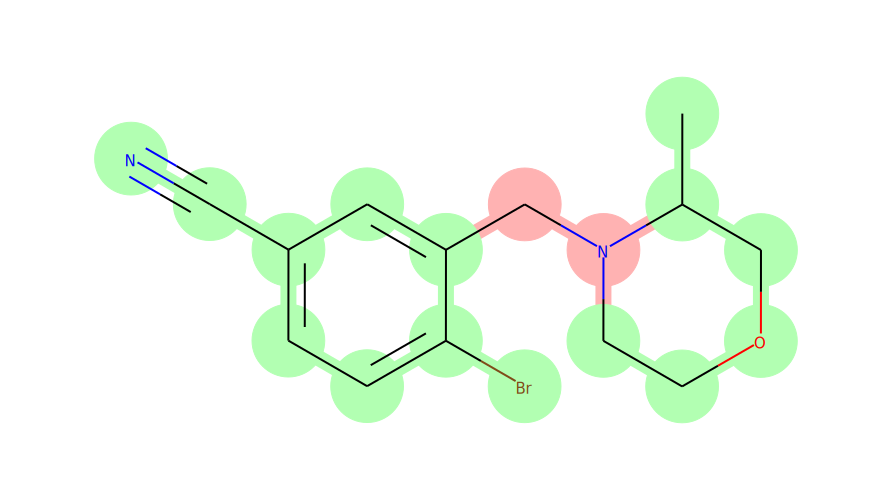

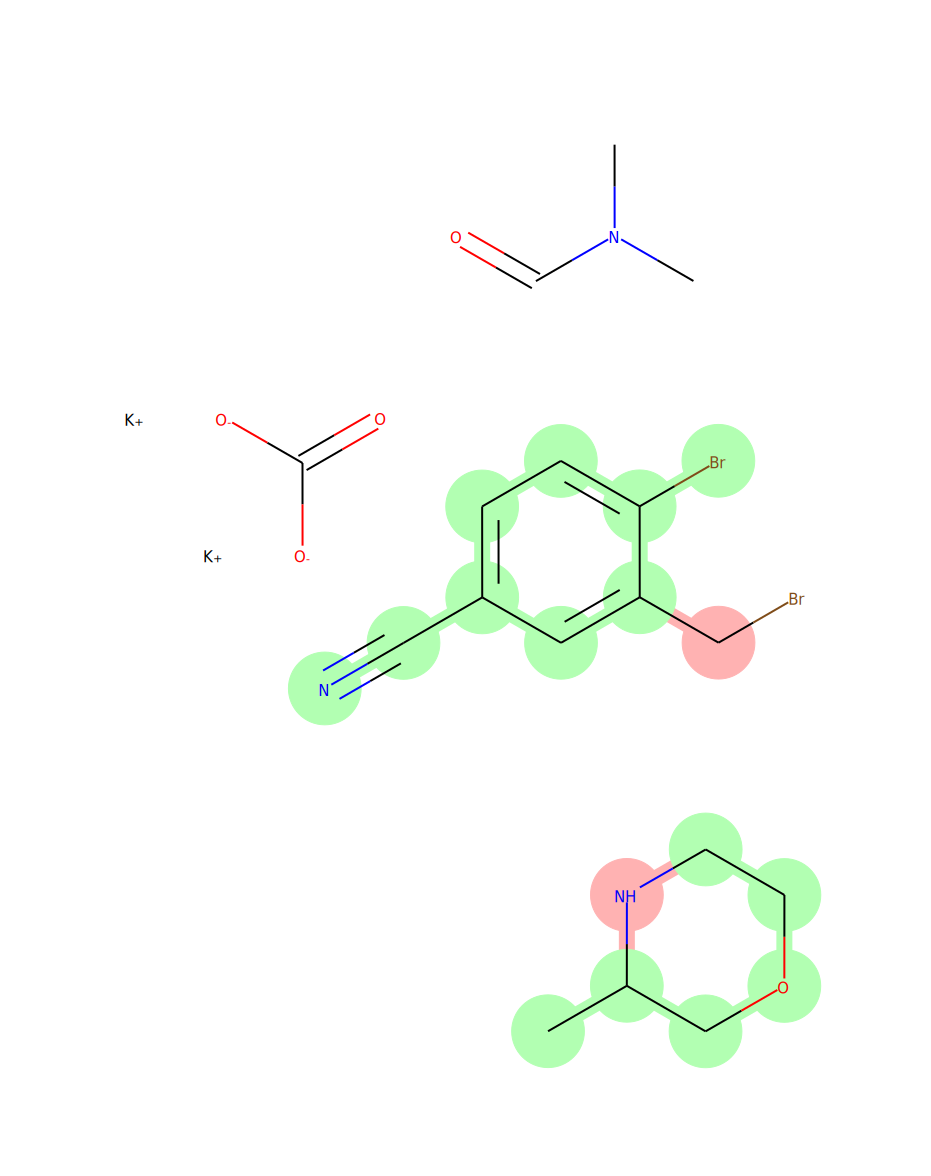

New center
27449
0.47641417


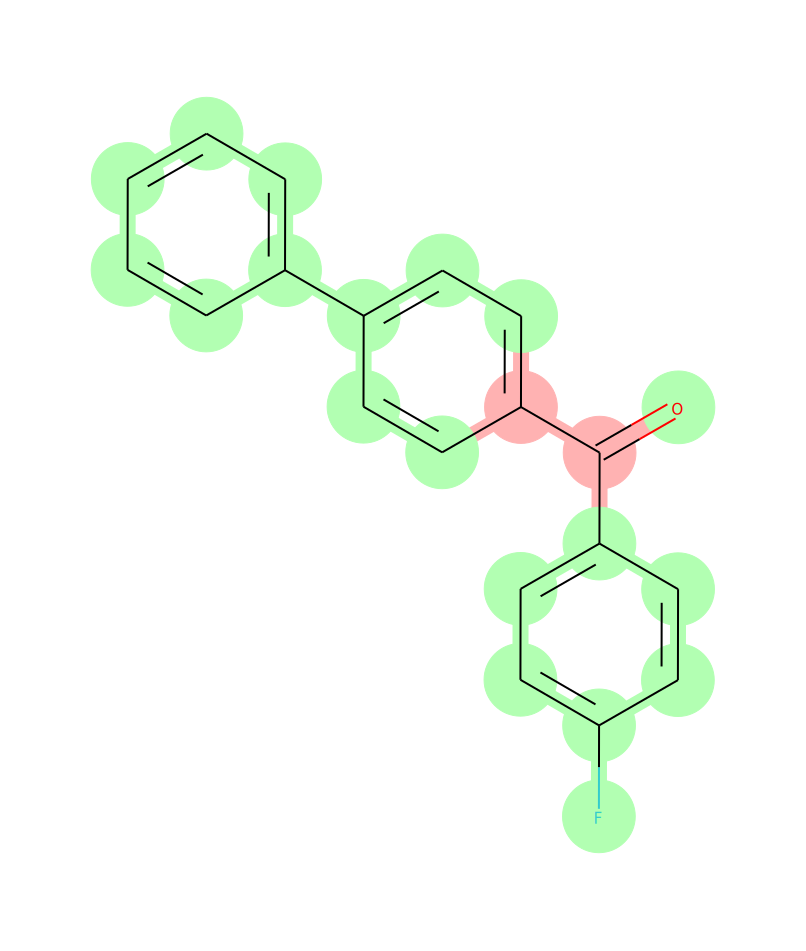

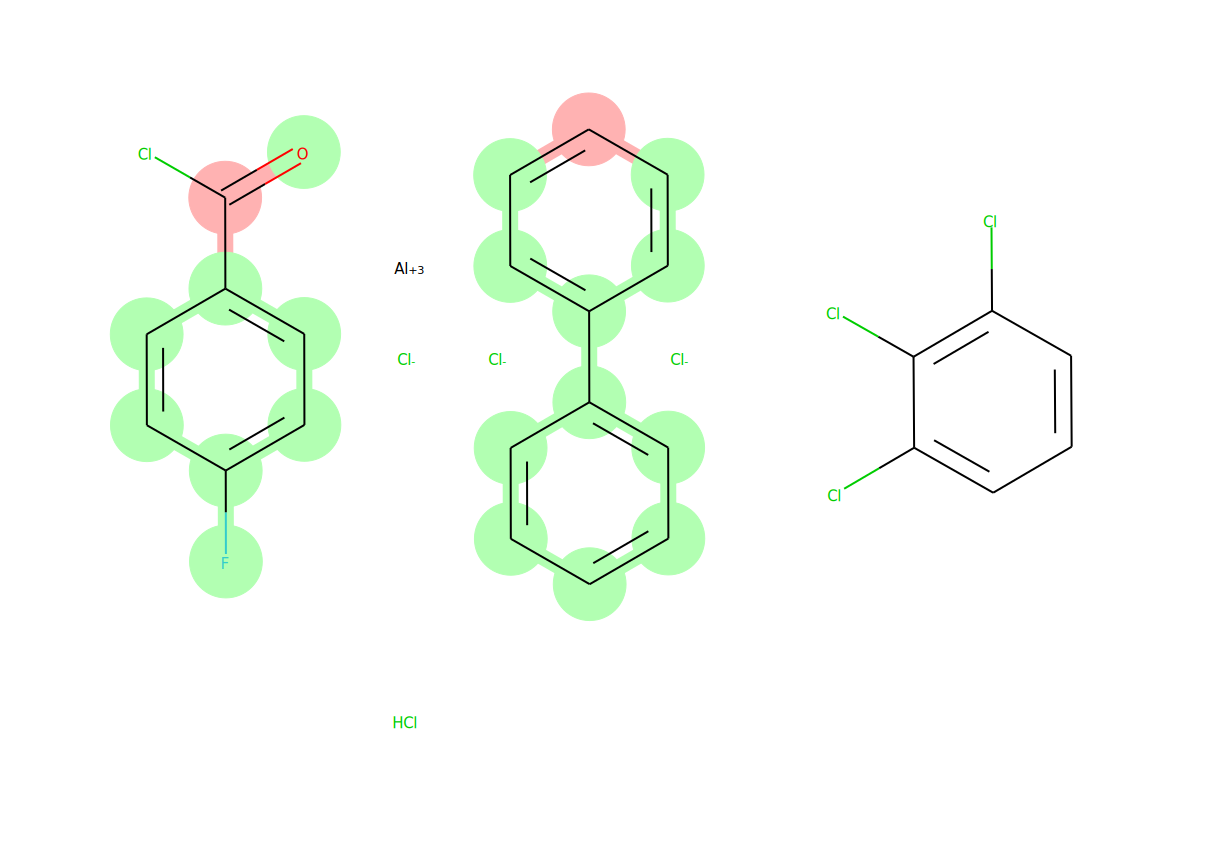

1586
0.5039291


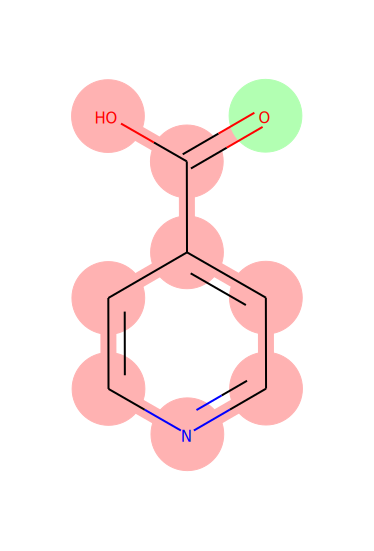

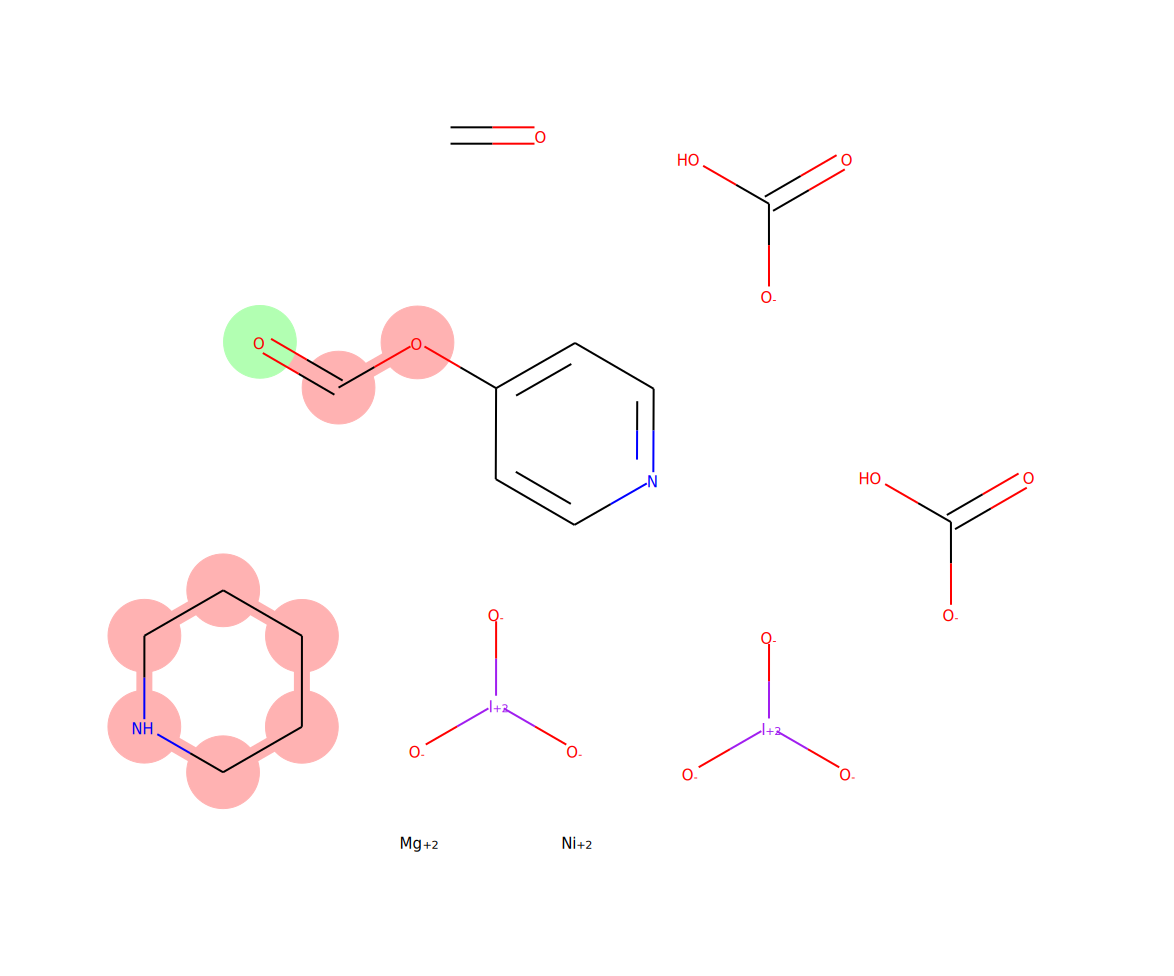

33494
0.5286722


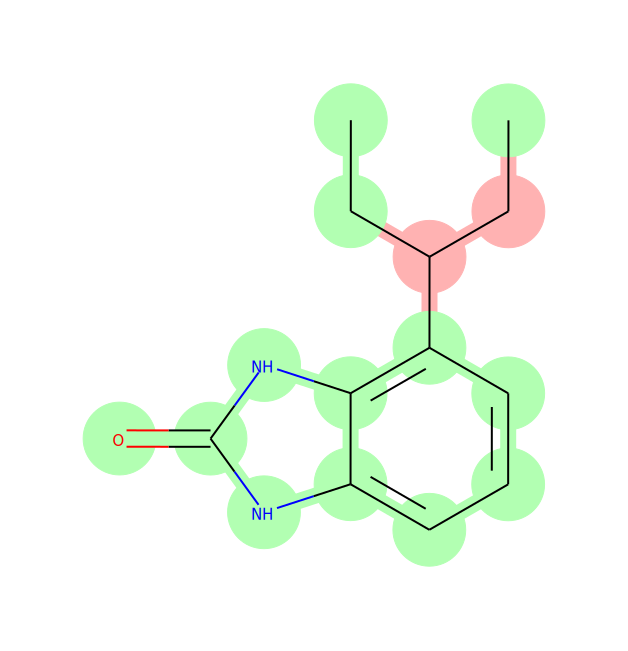

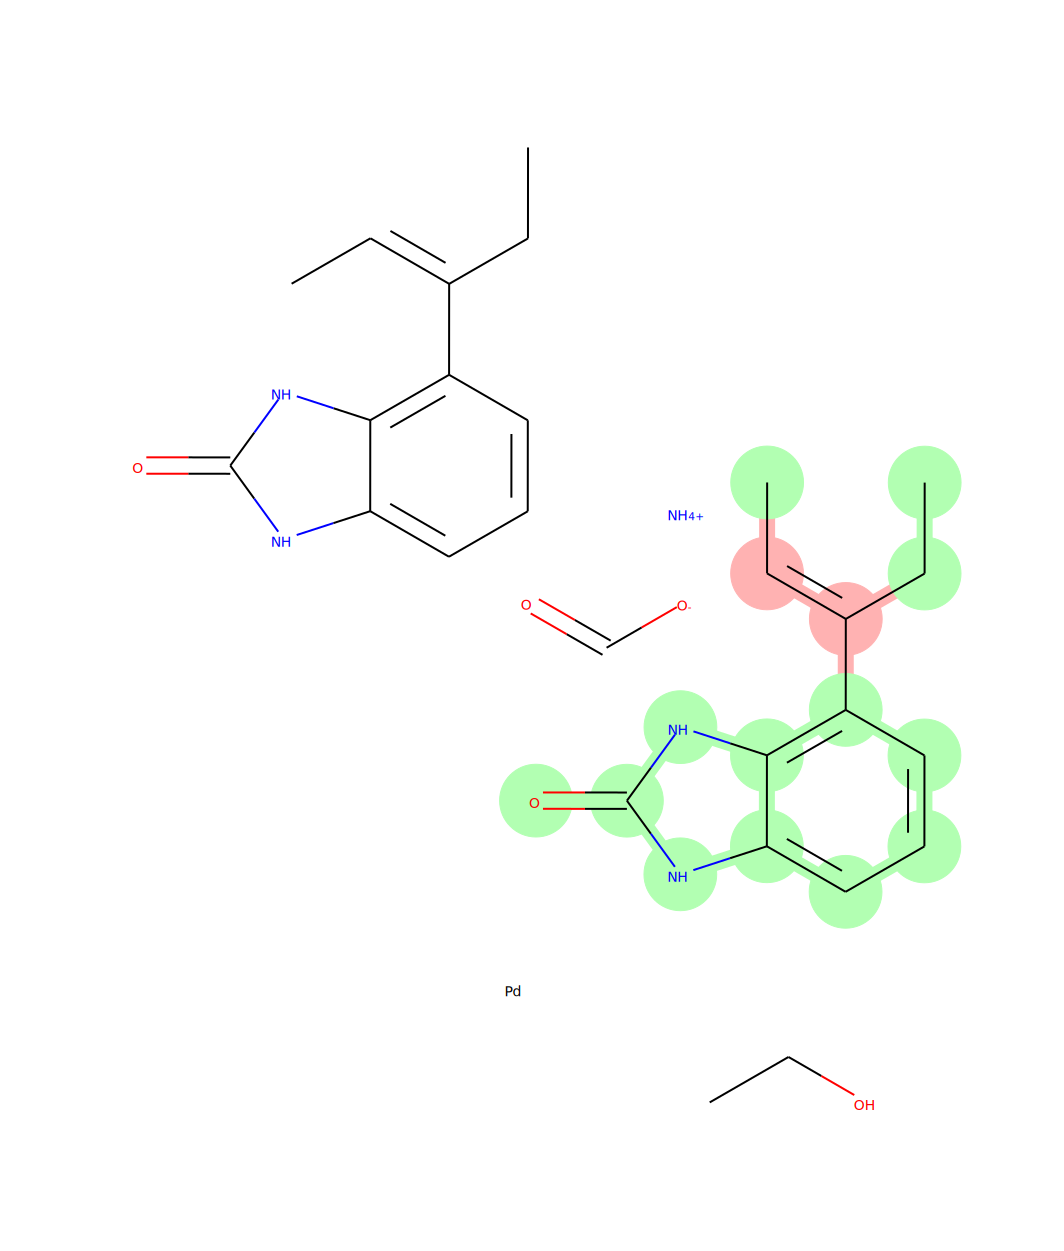

1326
0.78049177


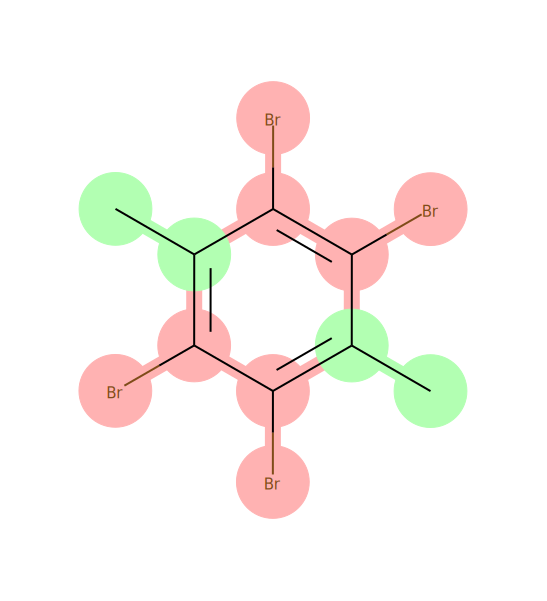

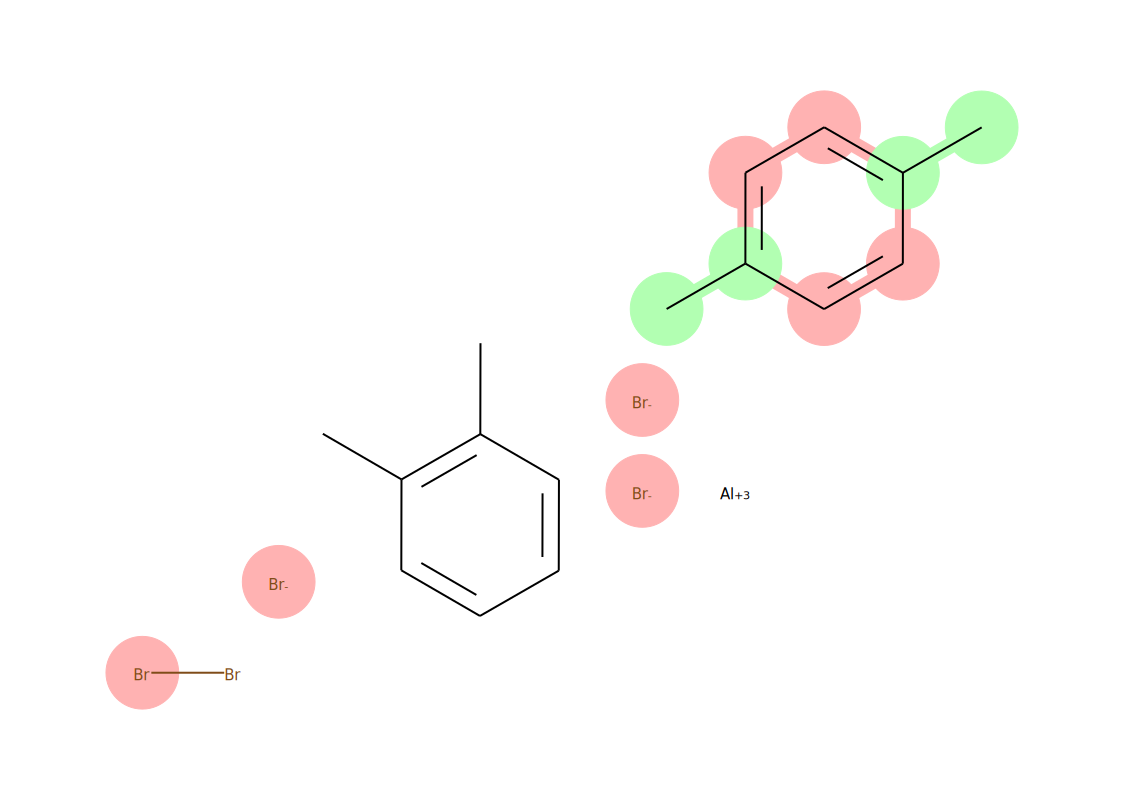

32649
3.907157


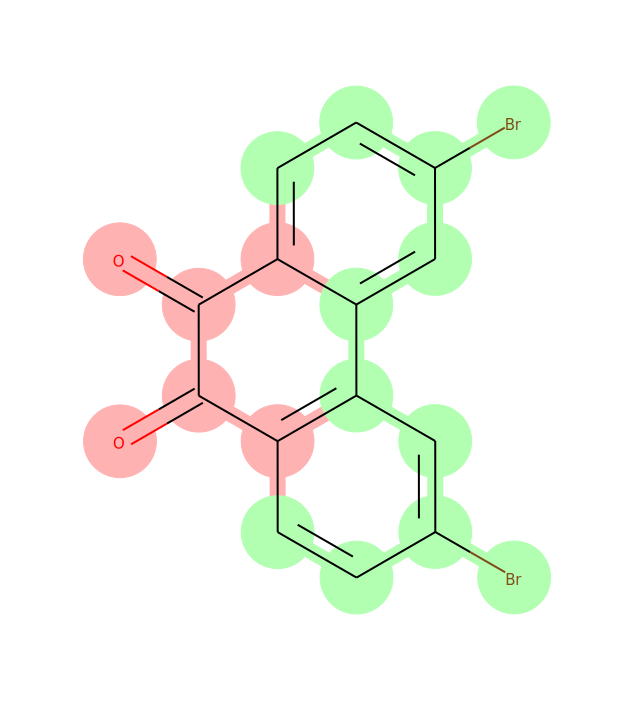

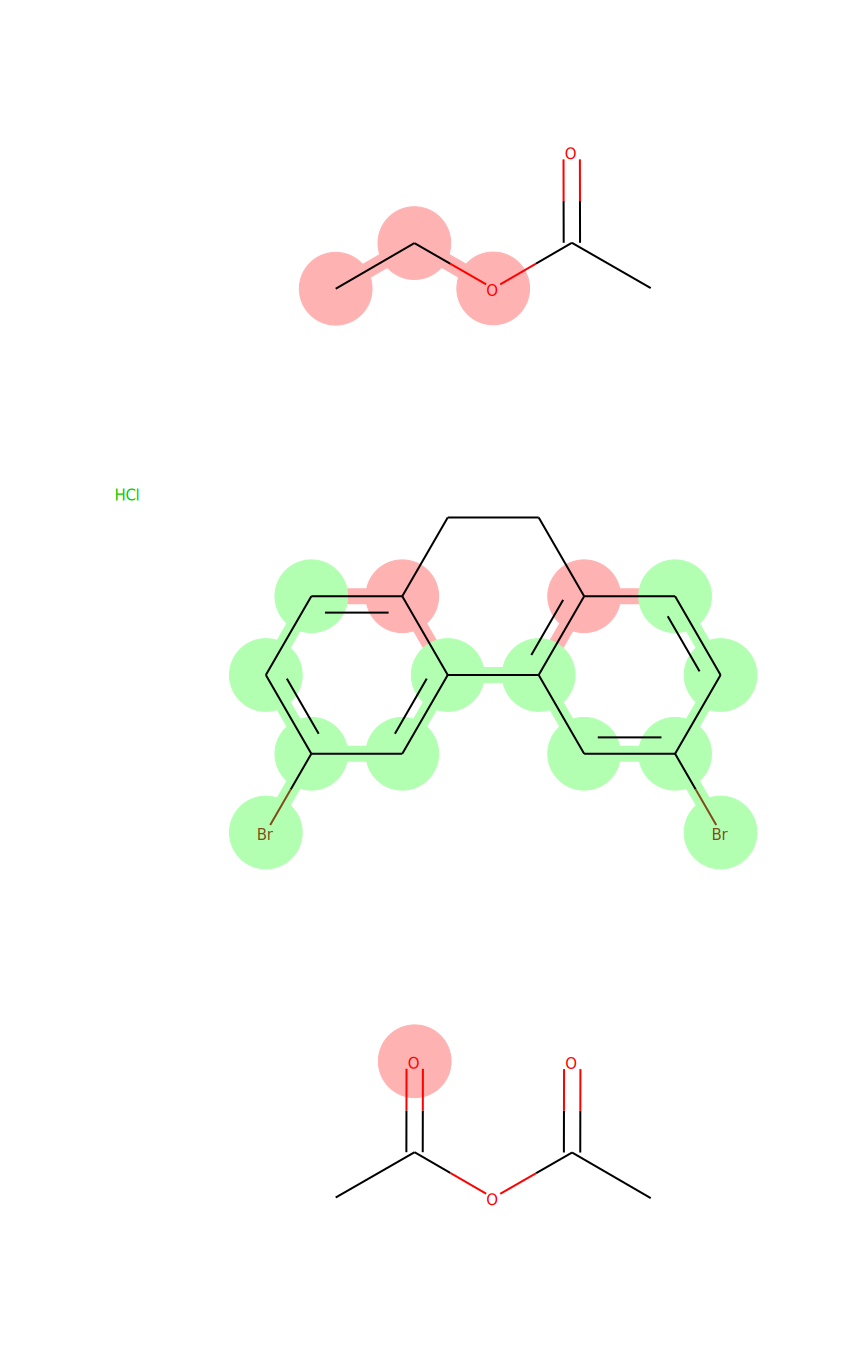

New center
9081
0.43157566


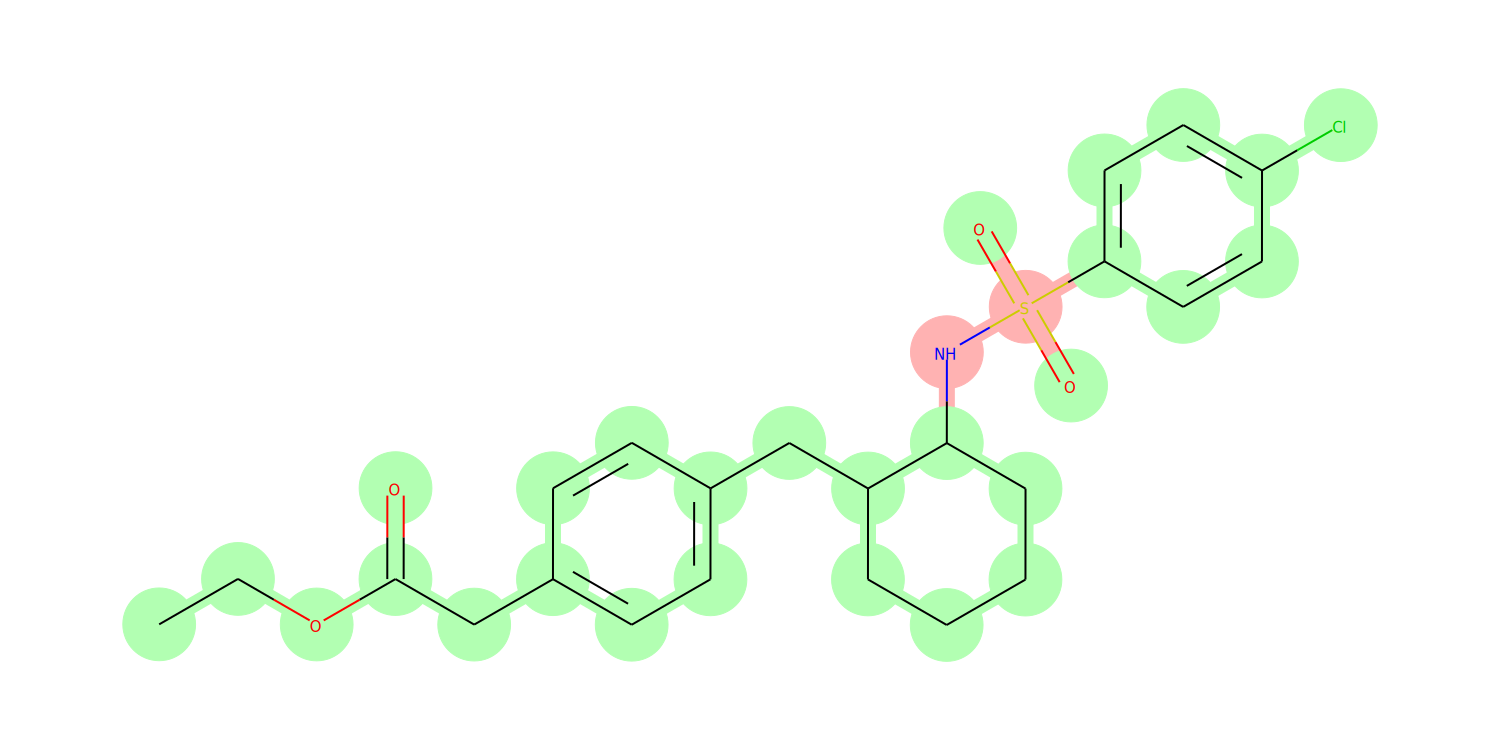

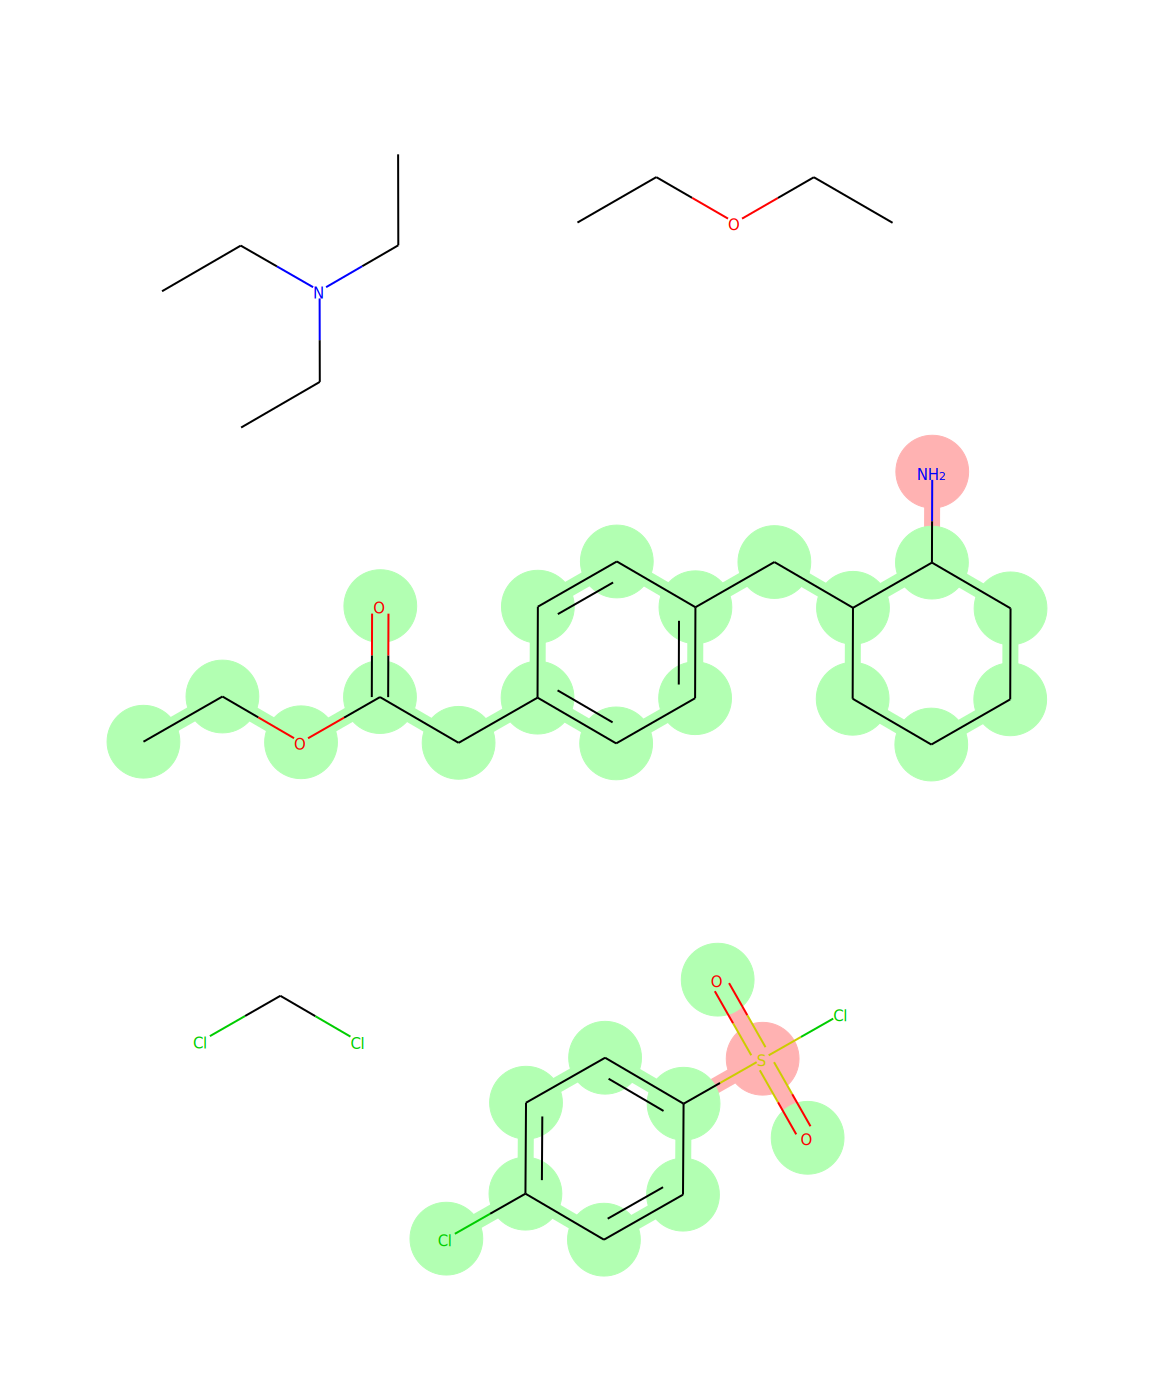

29990
0.45342052


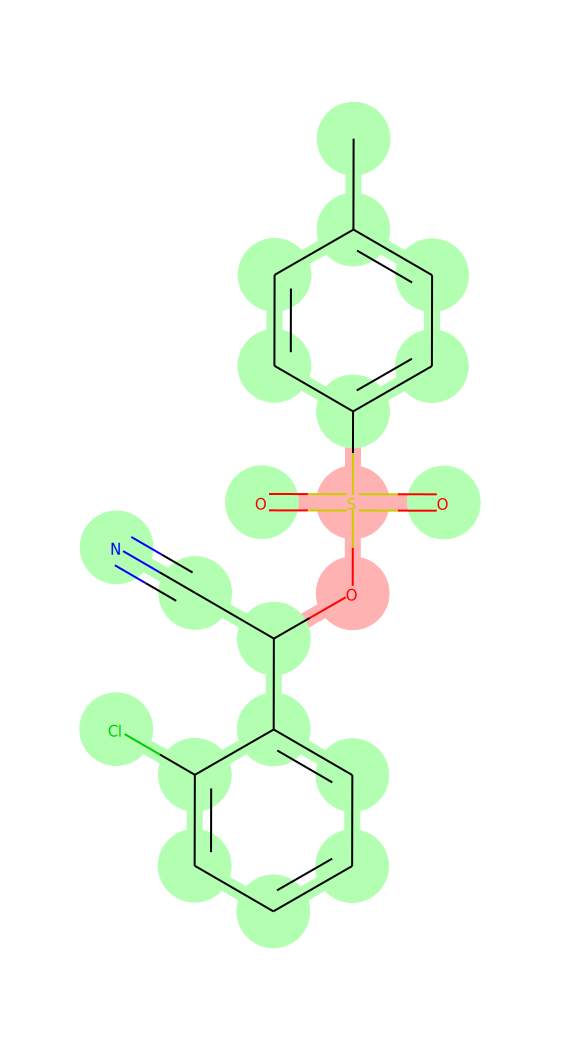

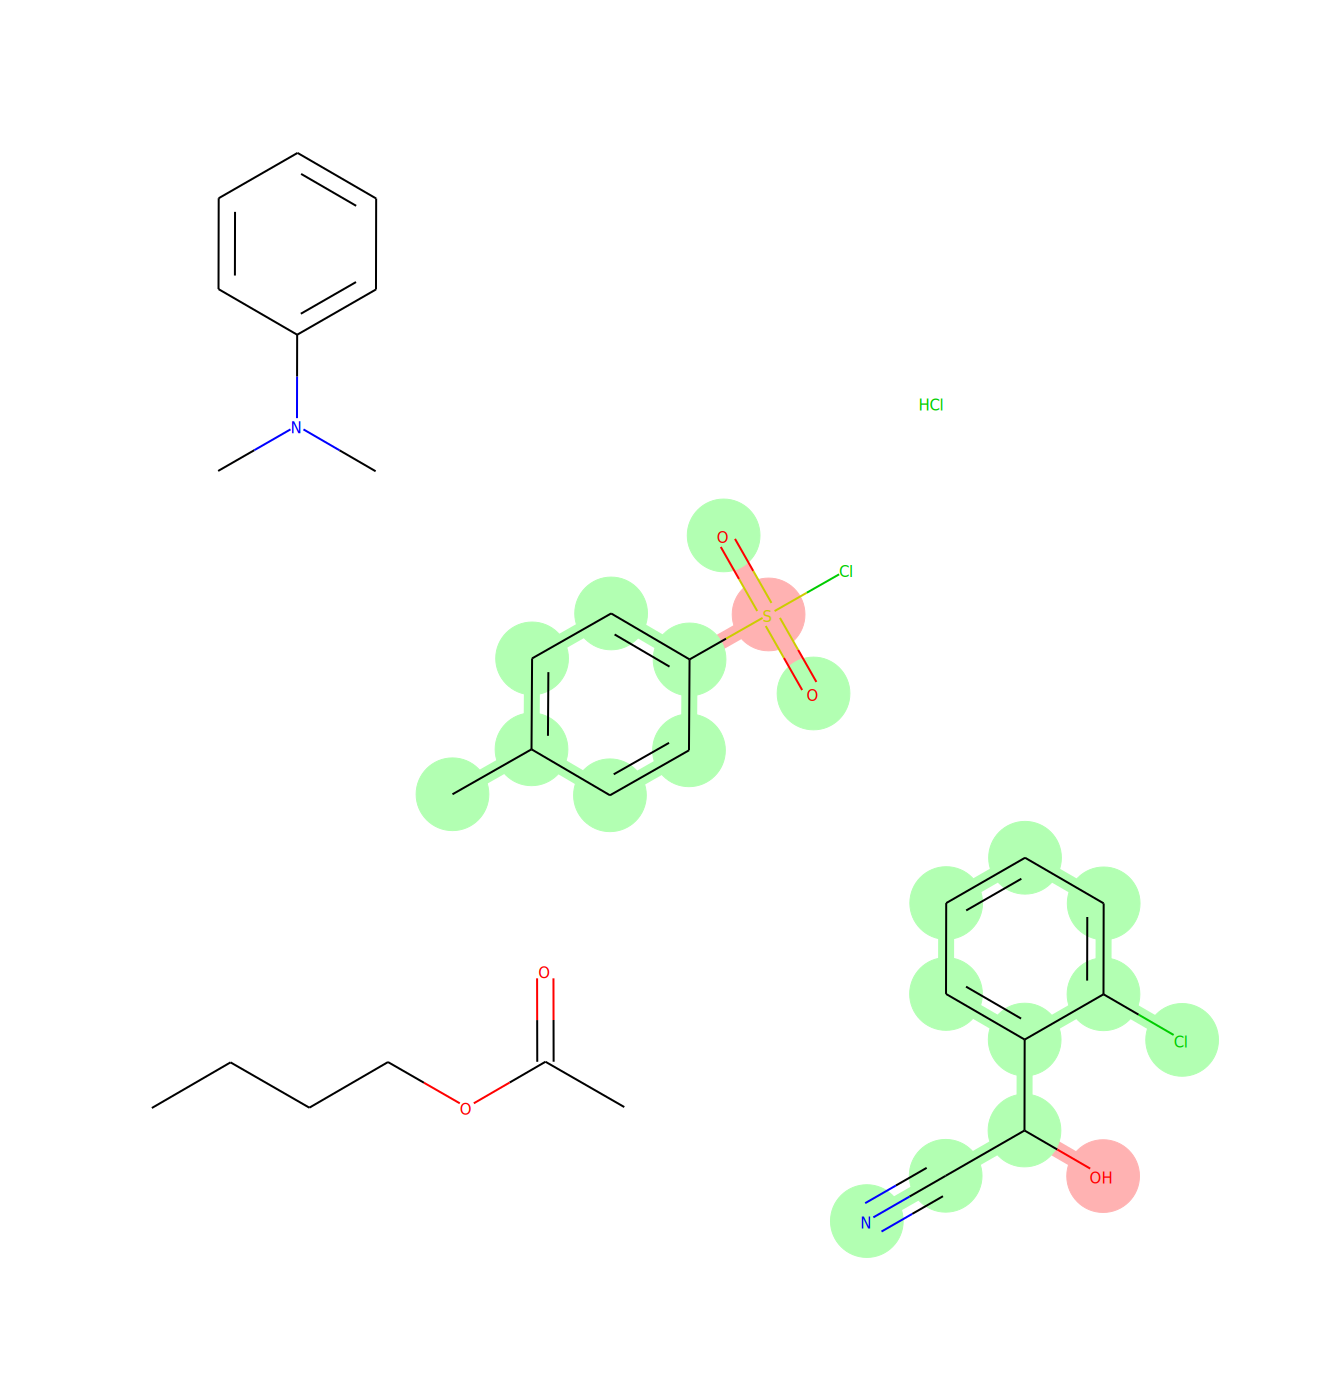

21942
0.46258372


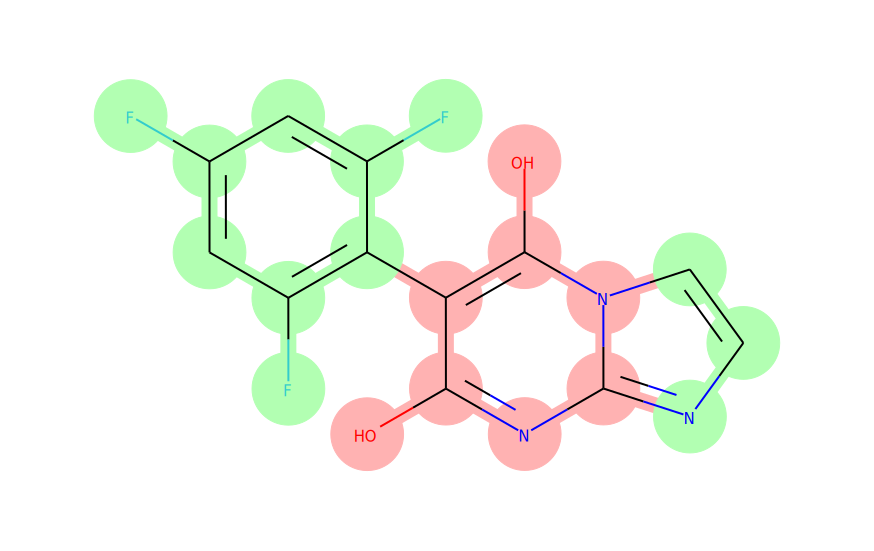

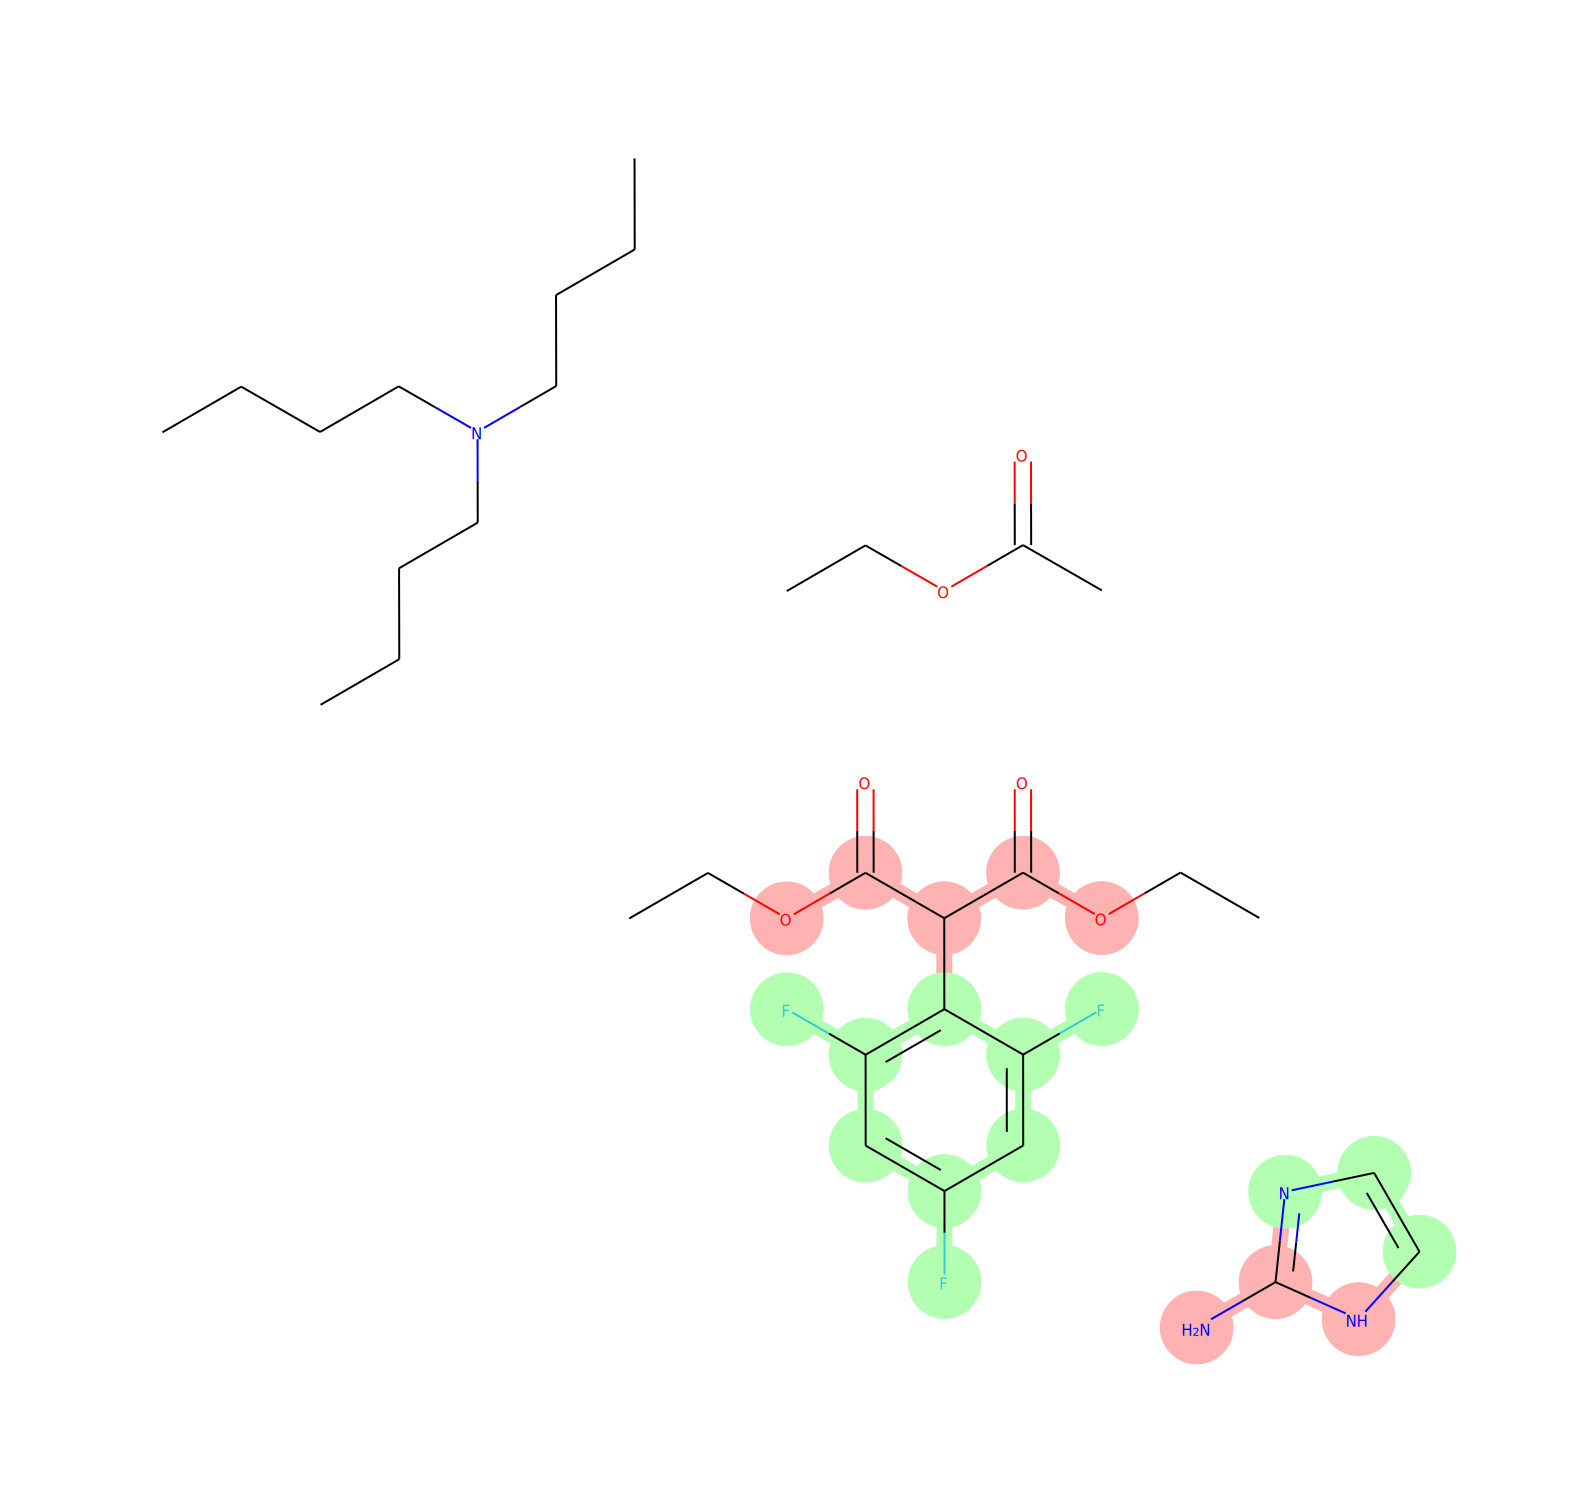

25895
0.7212683


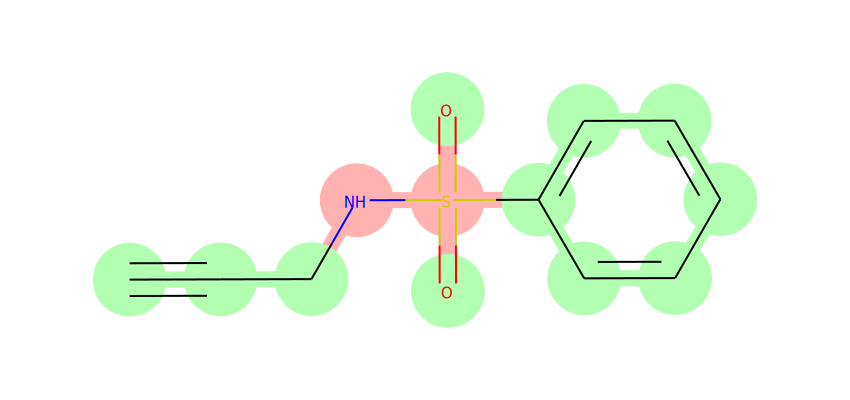

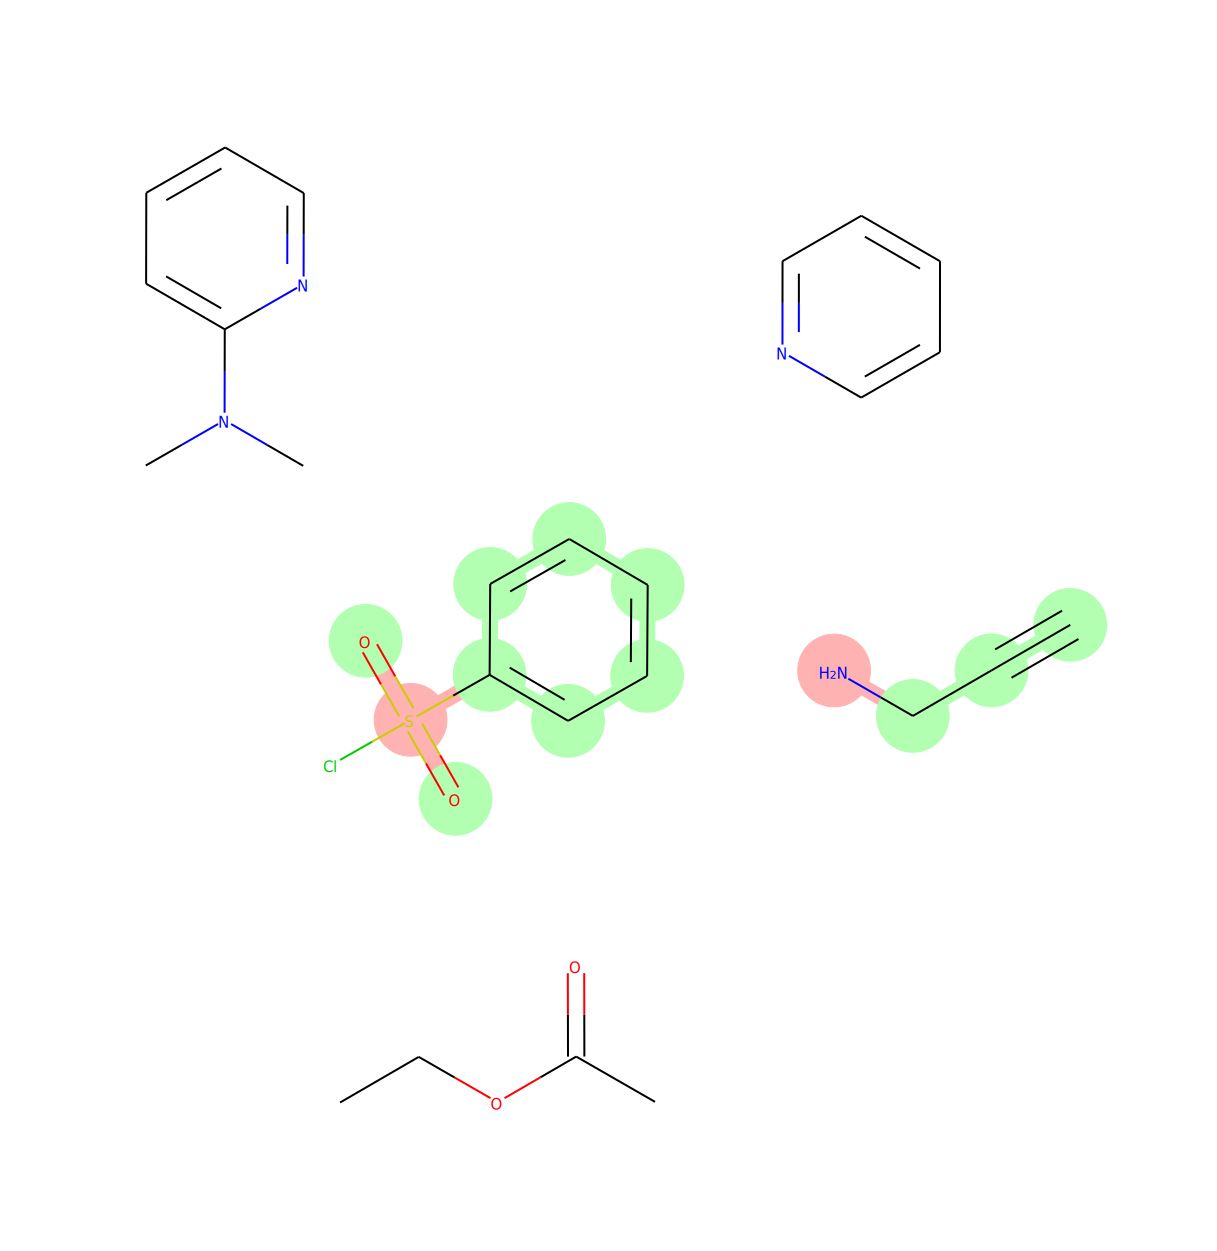

33319
2.7251532


RDKit WARNING: [00:39:27] WARNING: not removing hydrogen atom without neighbors


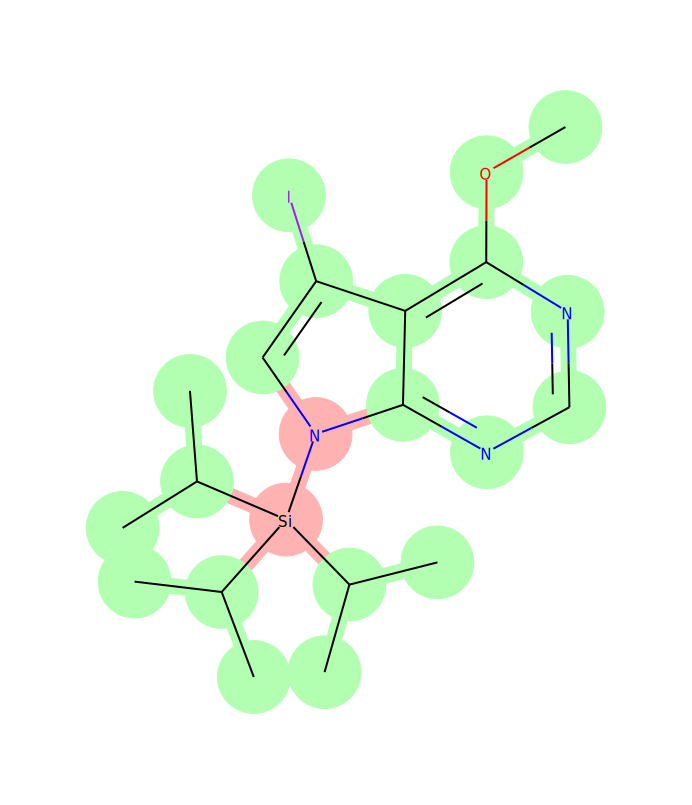

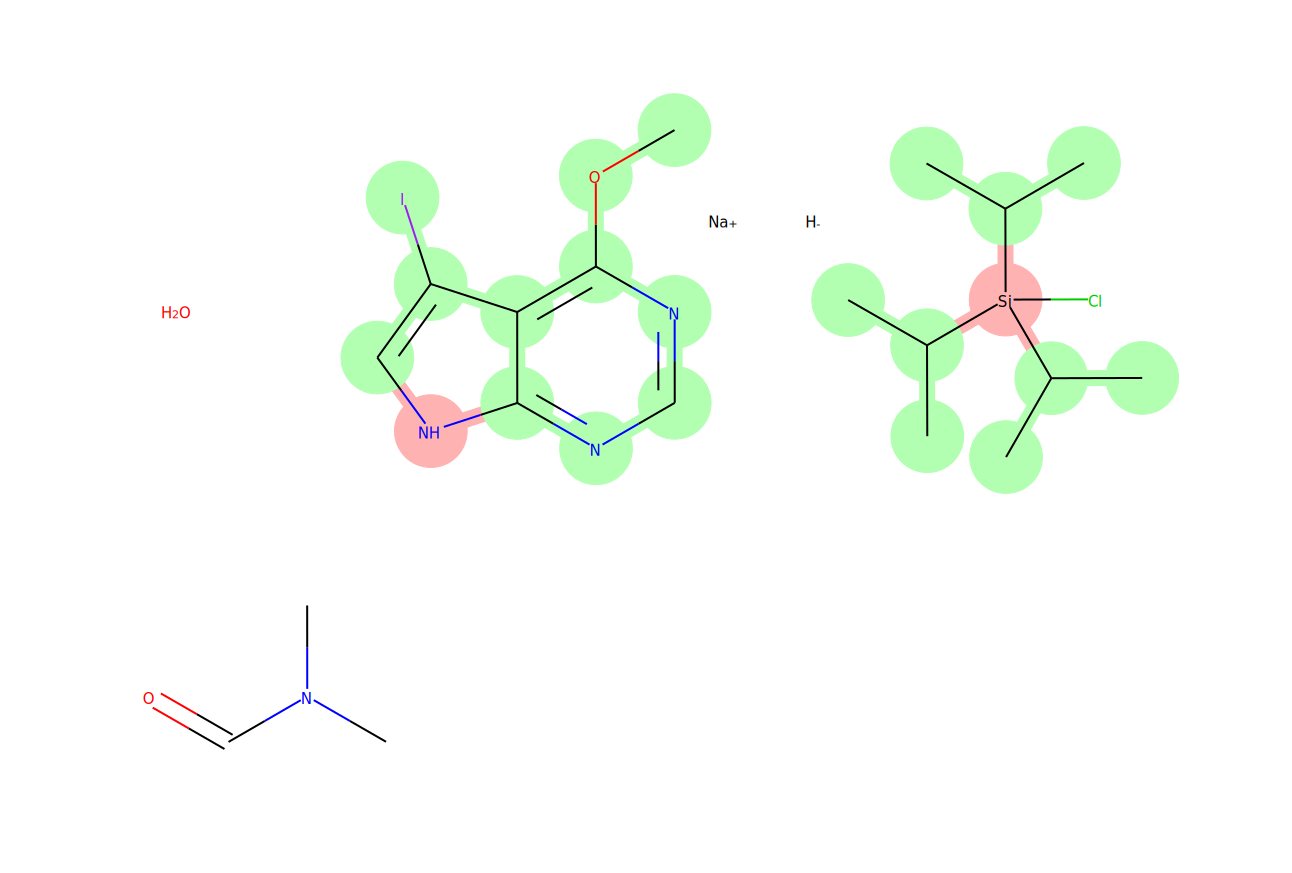

New center
39355
0.42985266


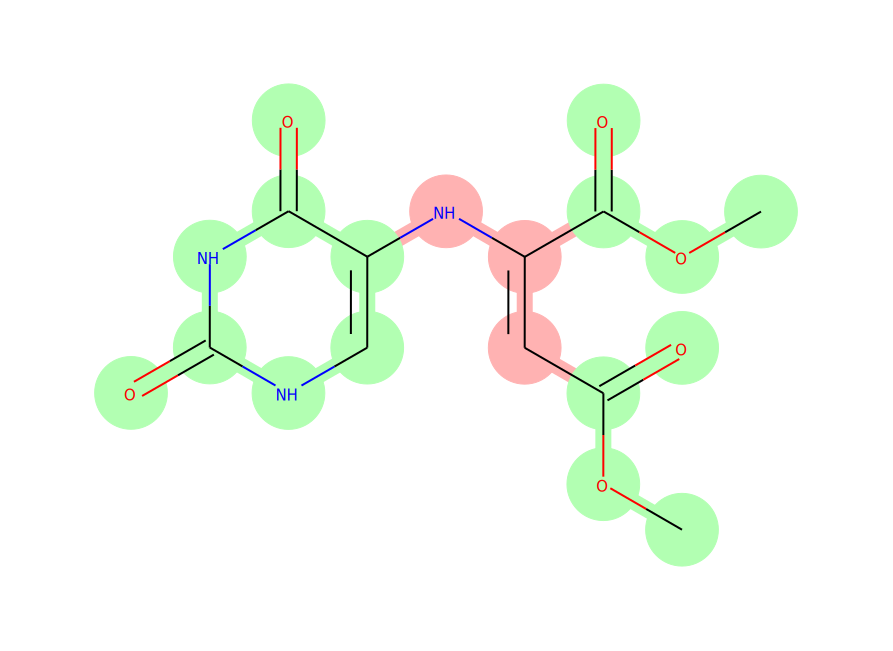

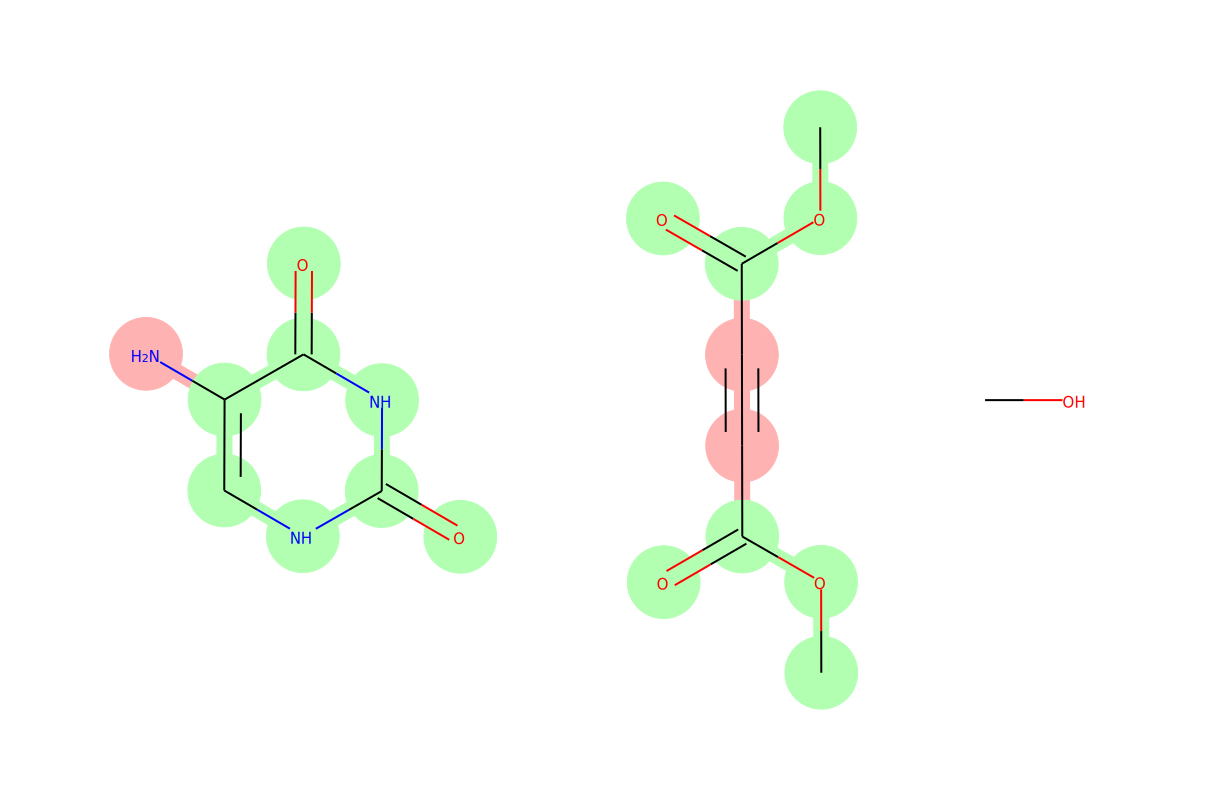

11215
0.46589175


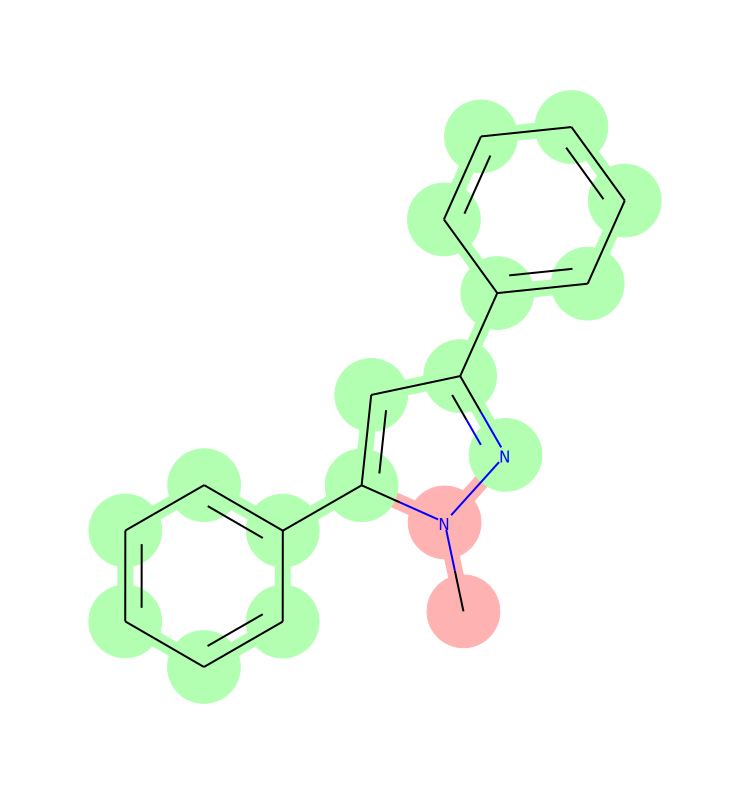

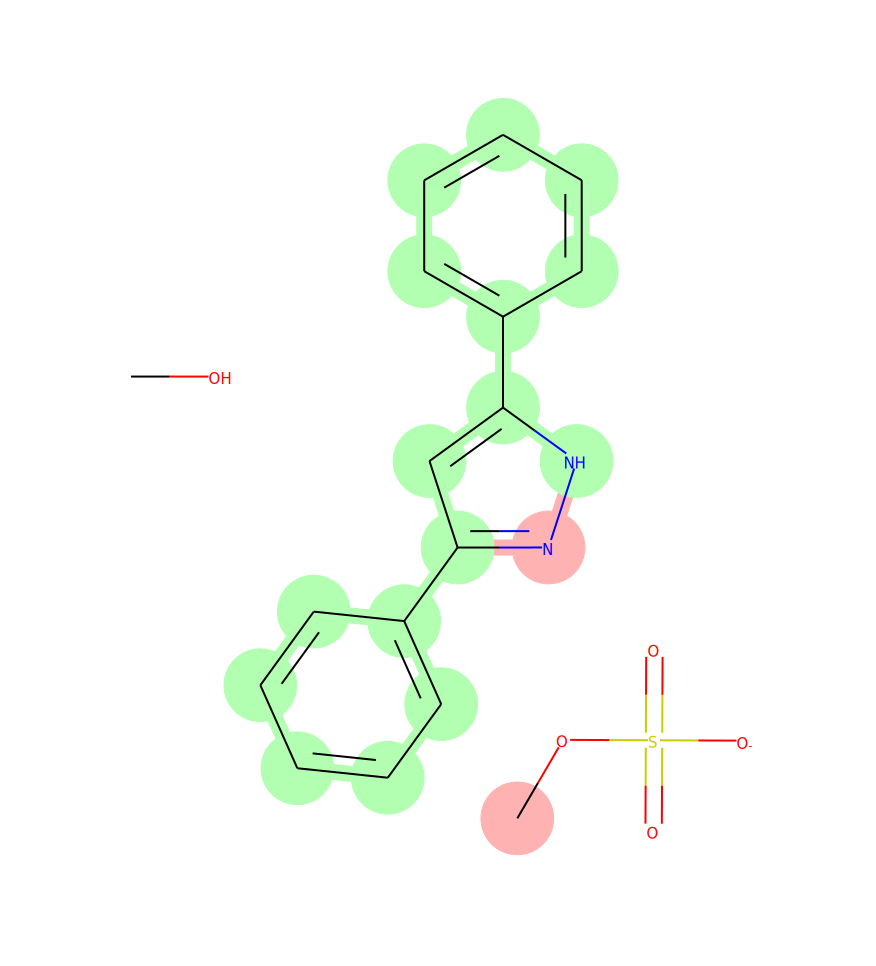

2336
0.47014987


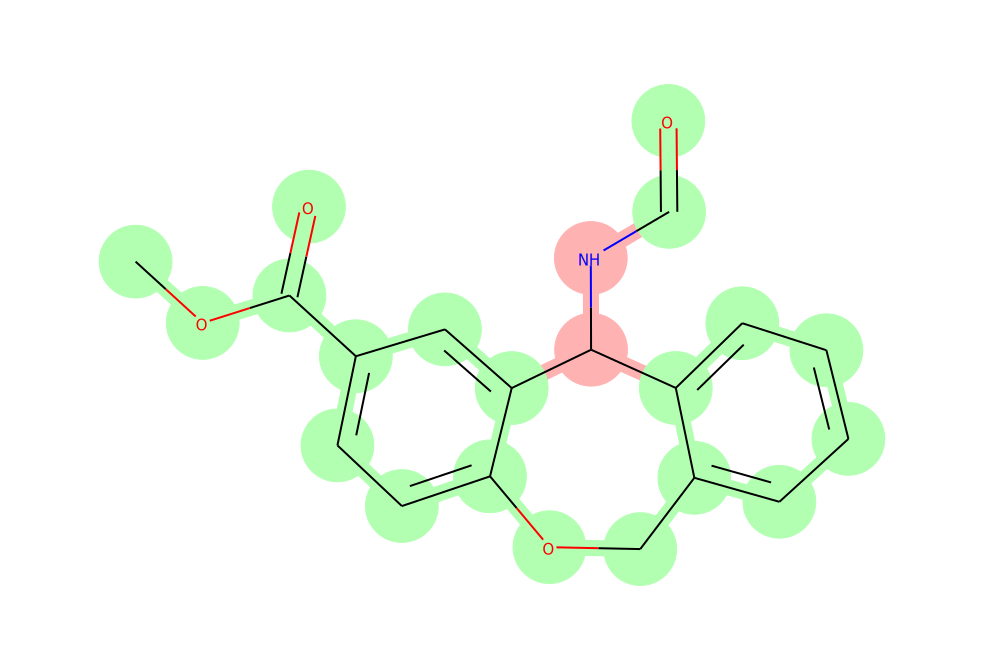

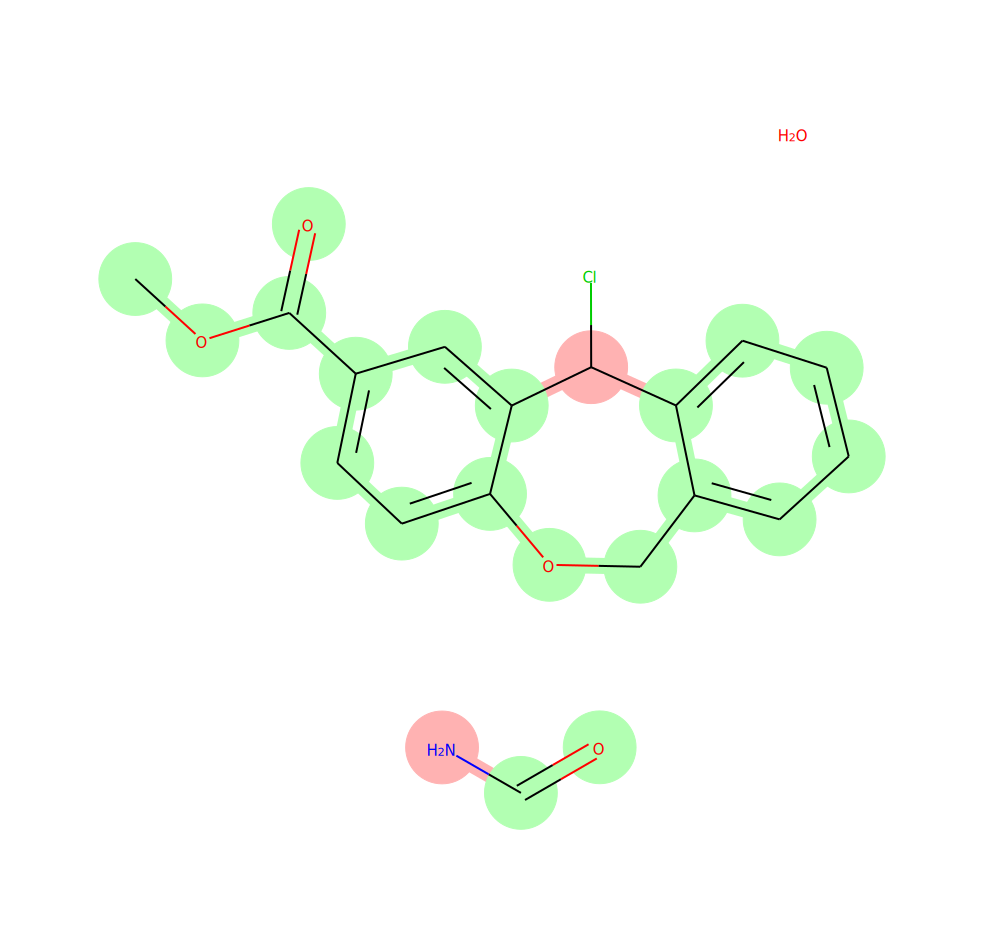

39400
0.74668515


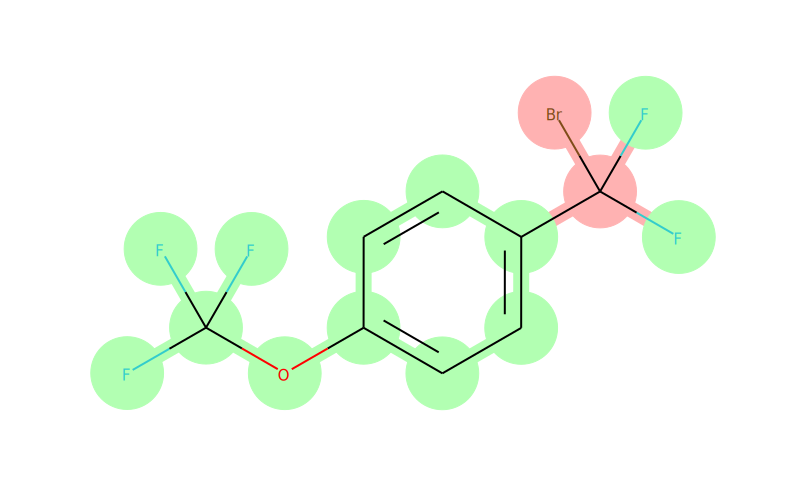

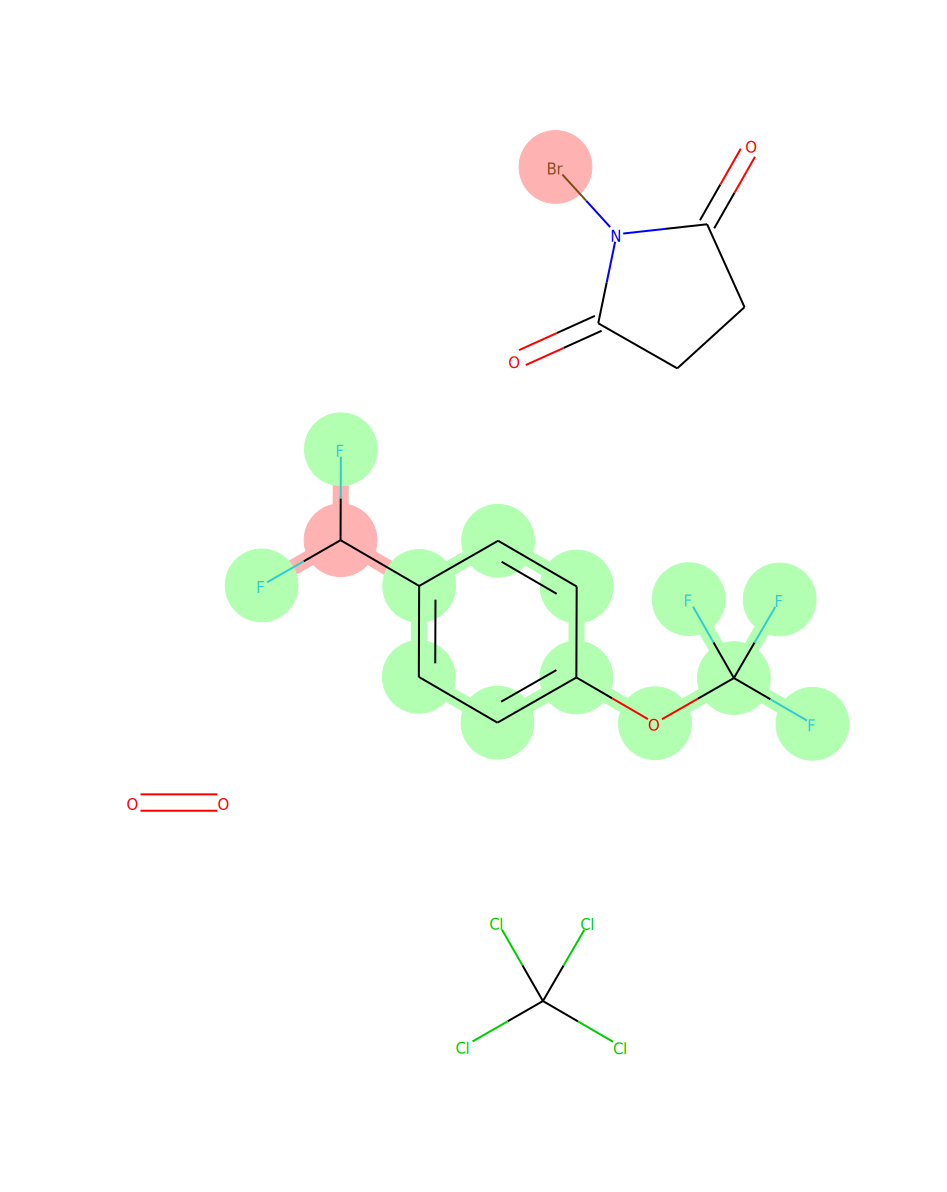

13955
2.387826


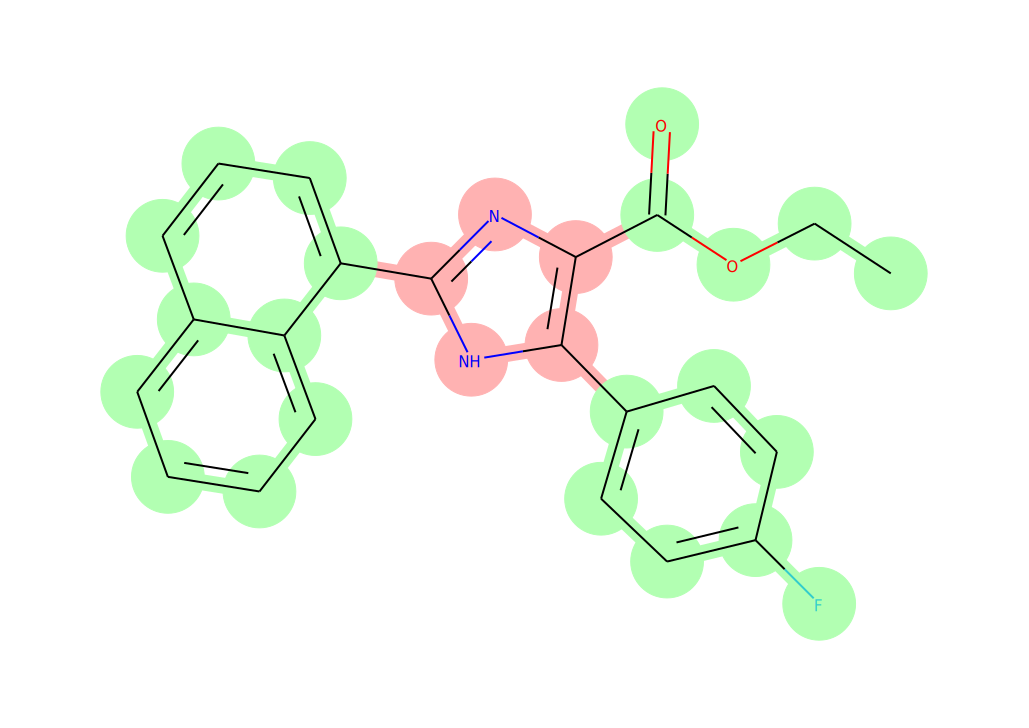

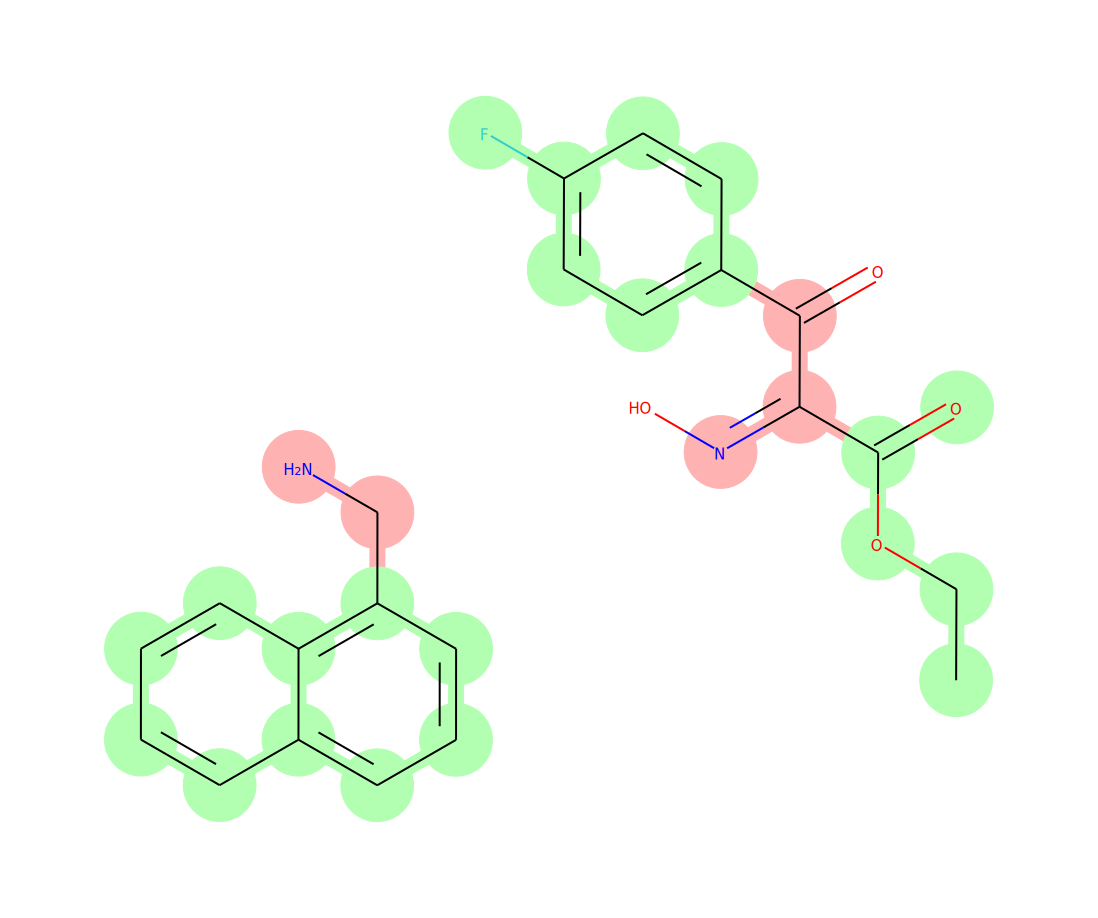

New center
42036
0.24979068


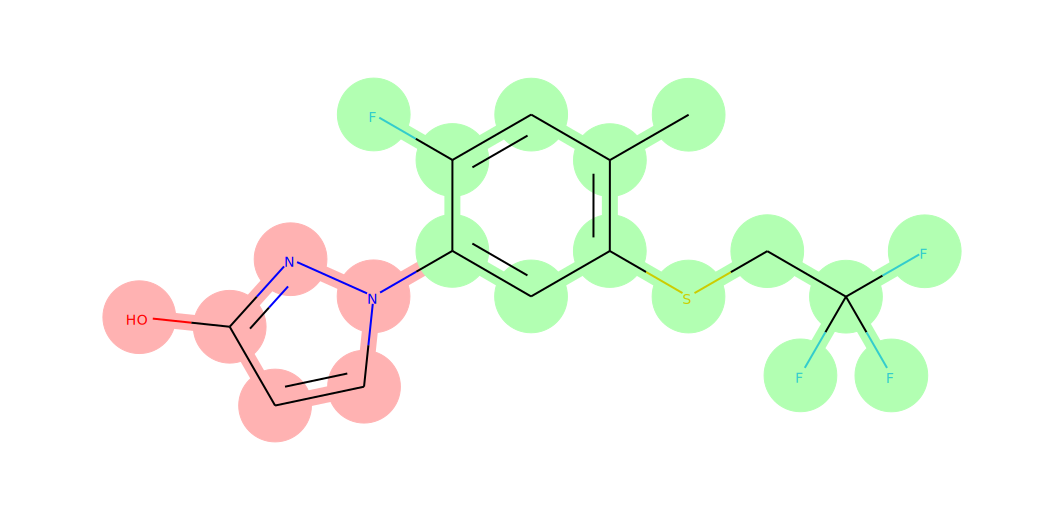

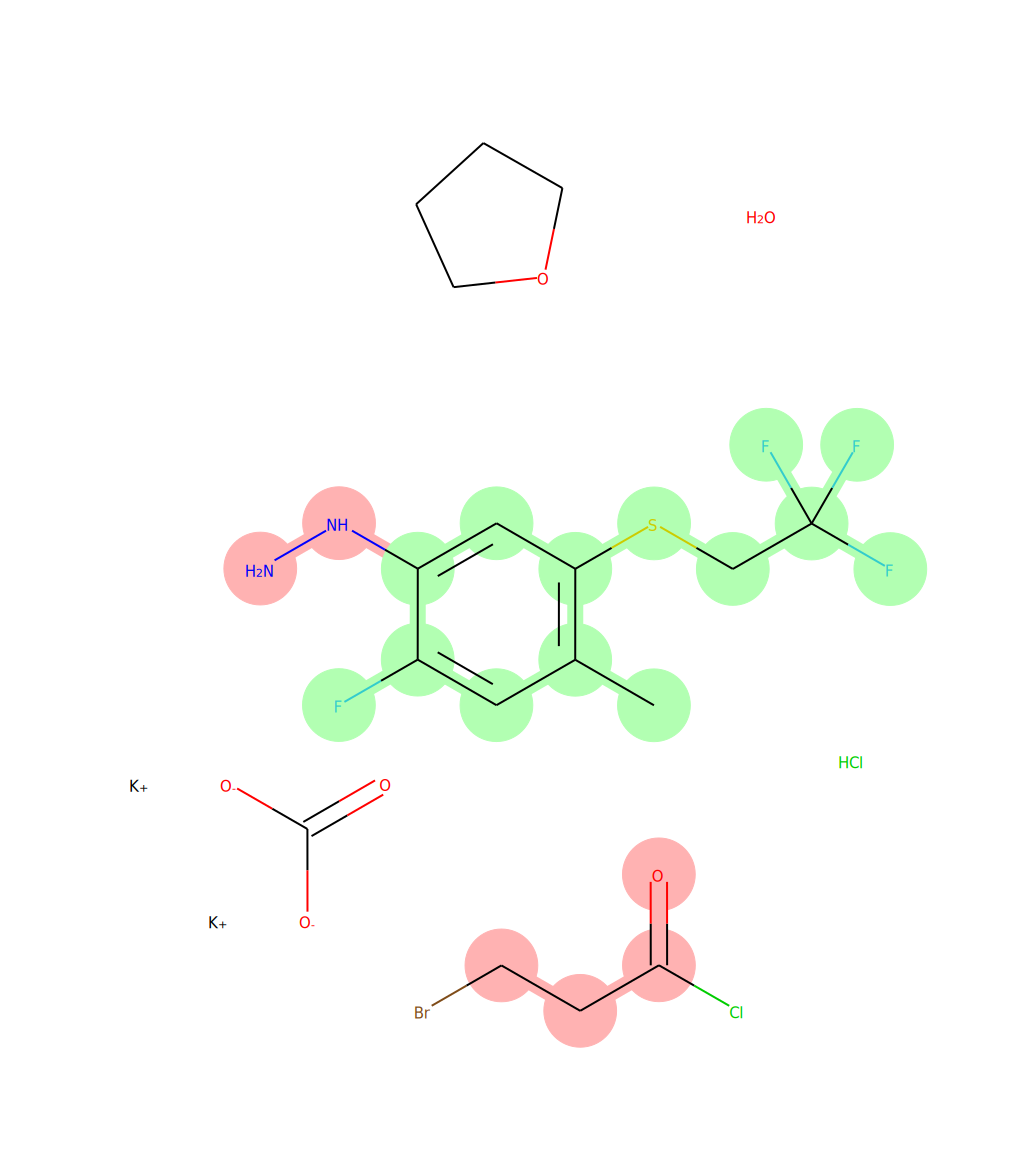

9142
0.3081383


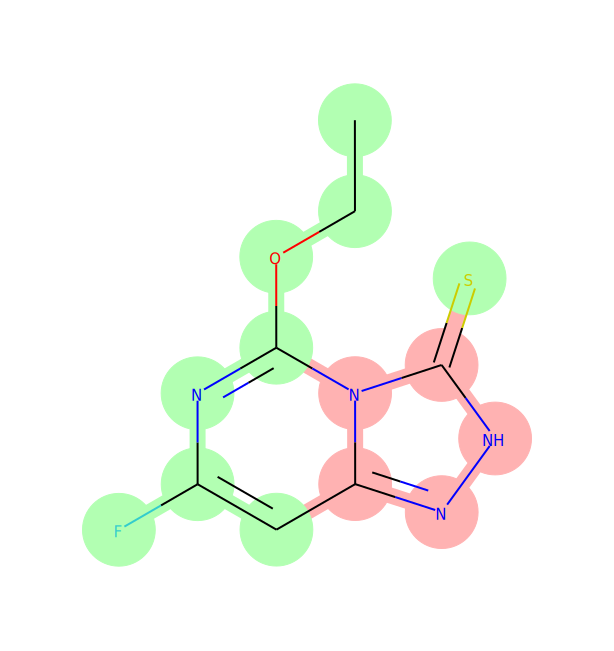

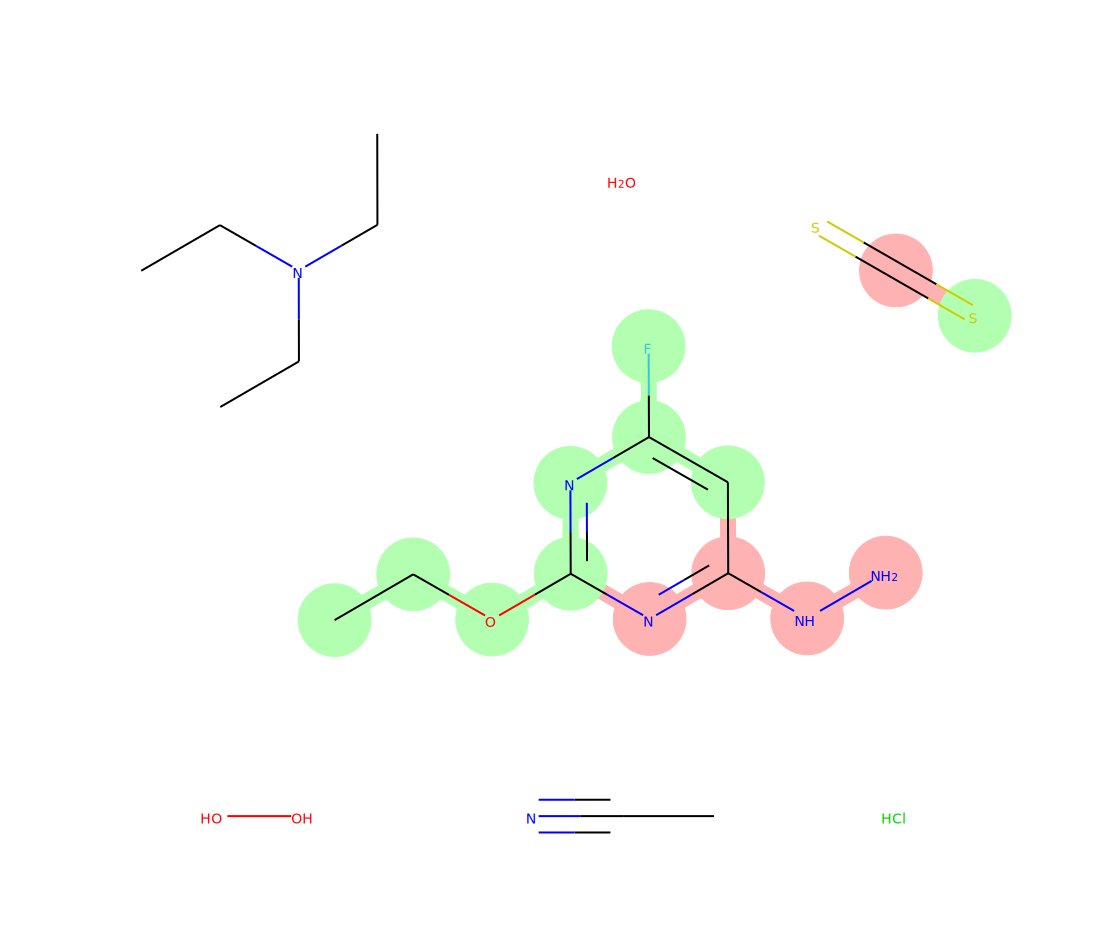

23630
0.3097841


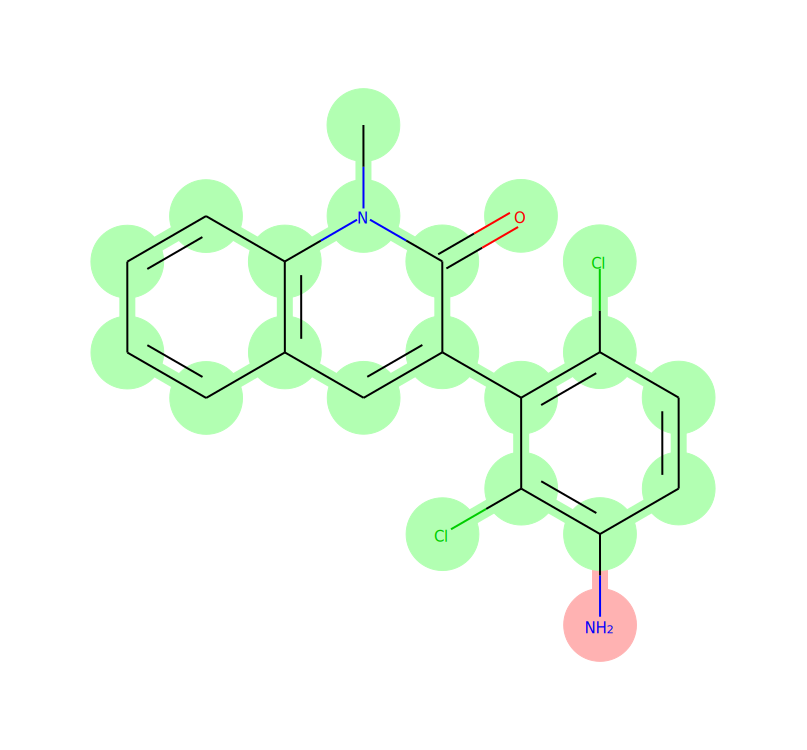

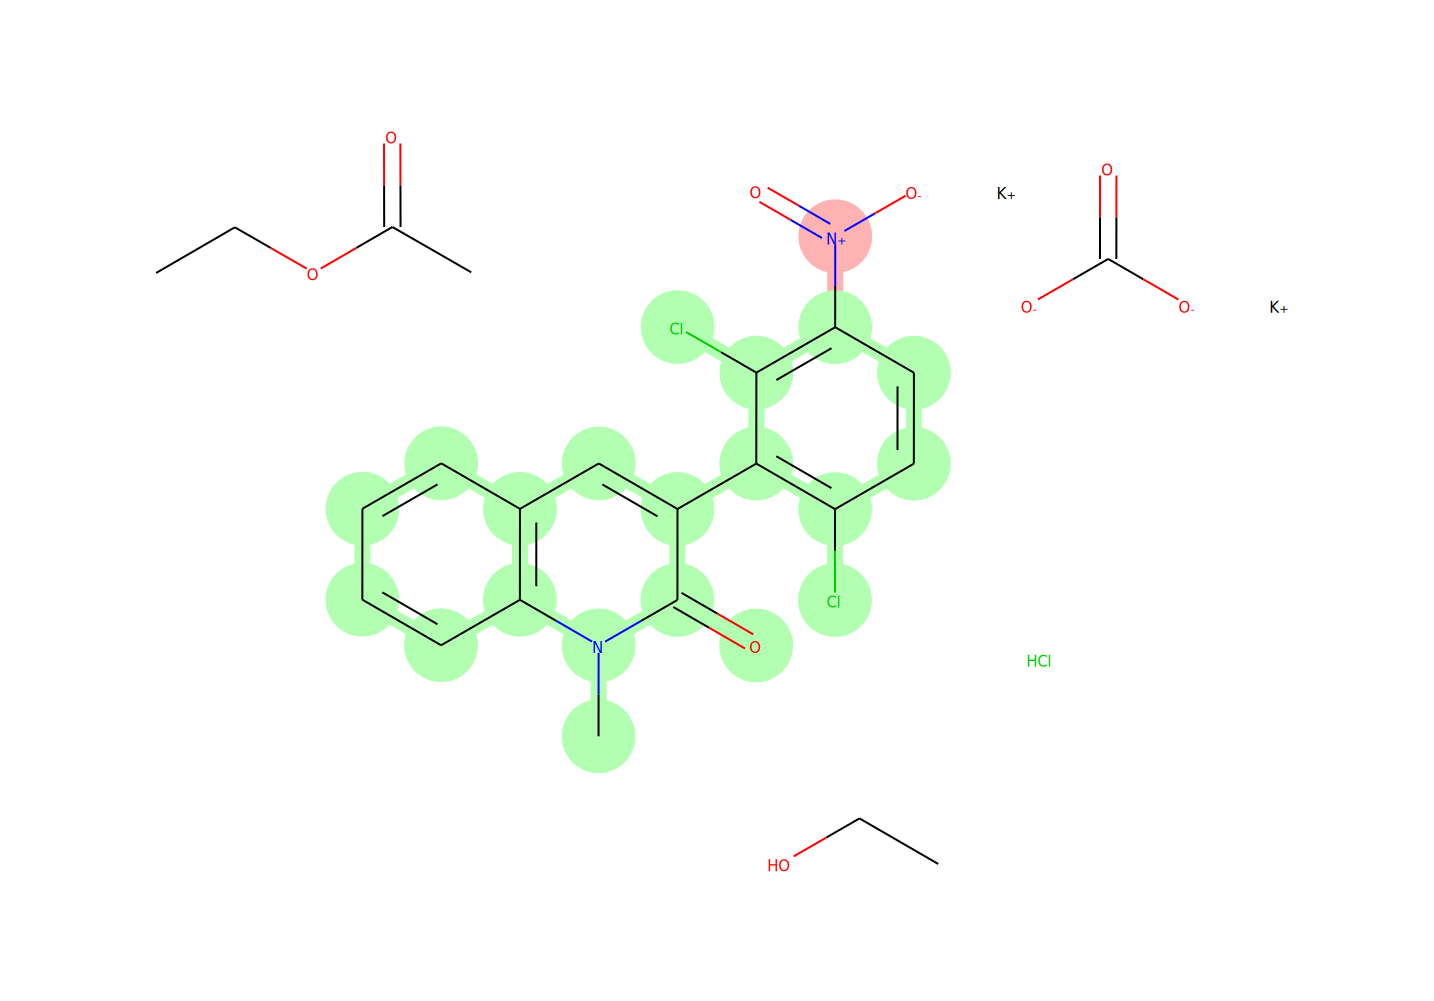

21245
0.4487155


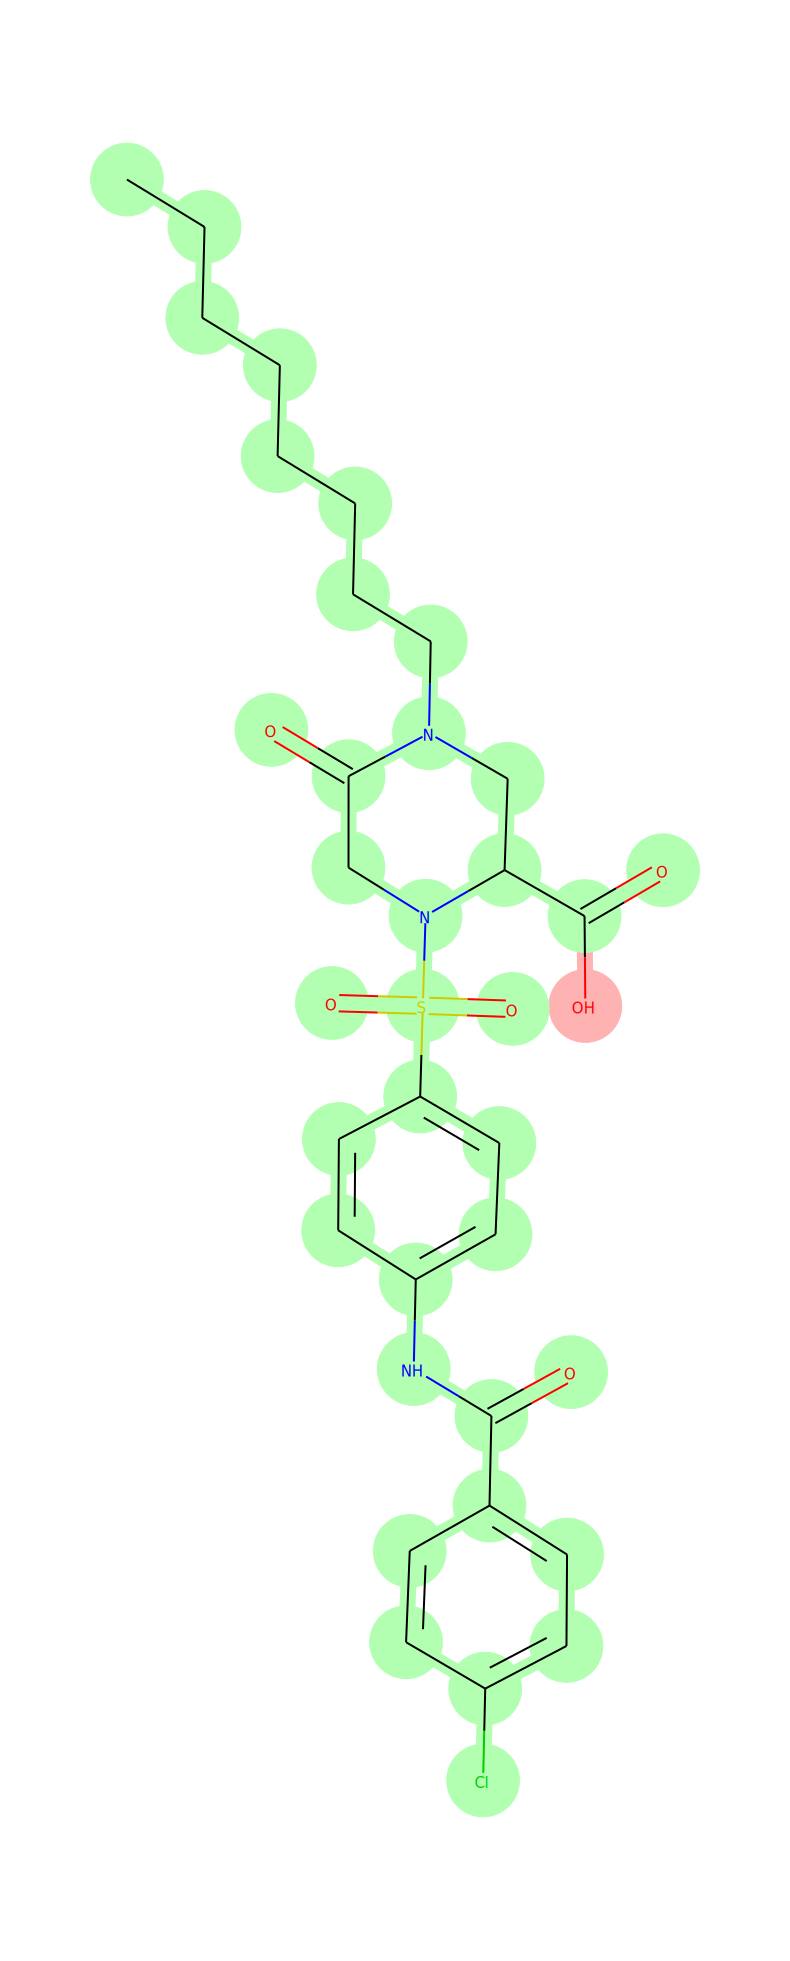

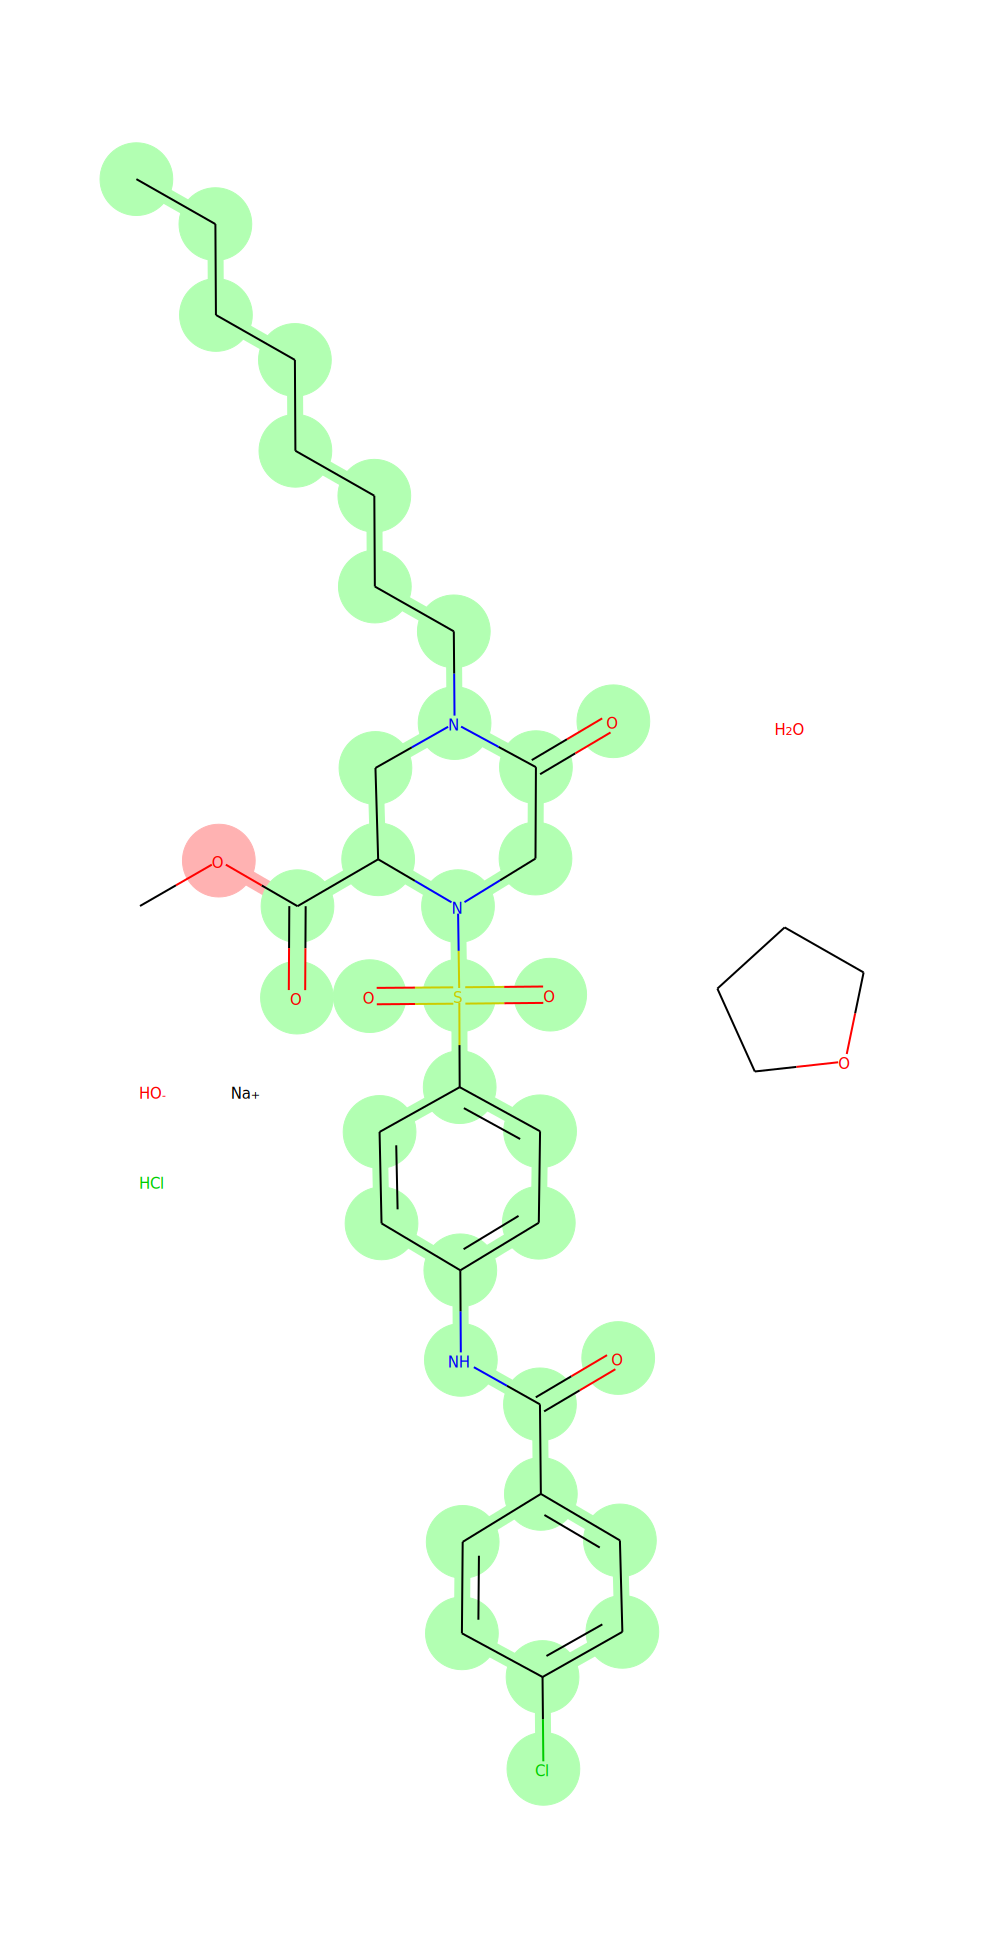

26263
2.2445314


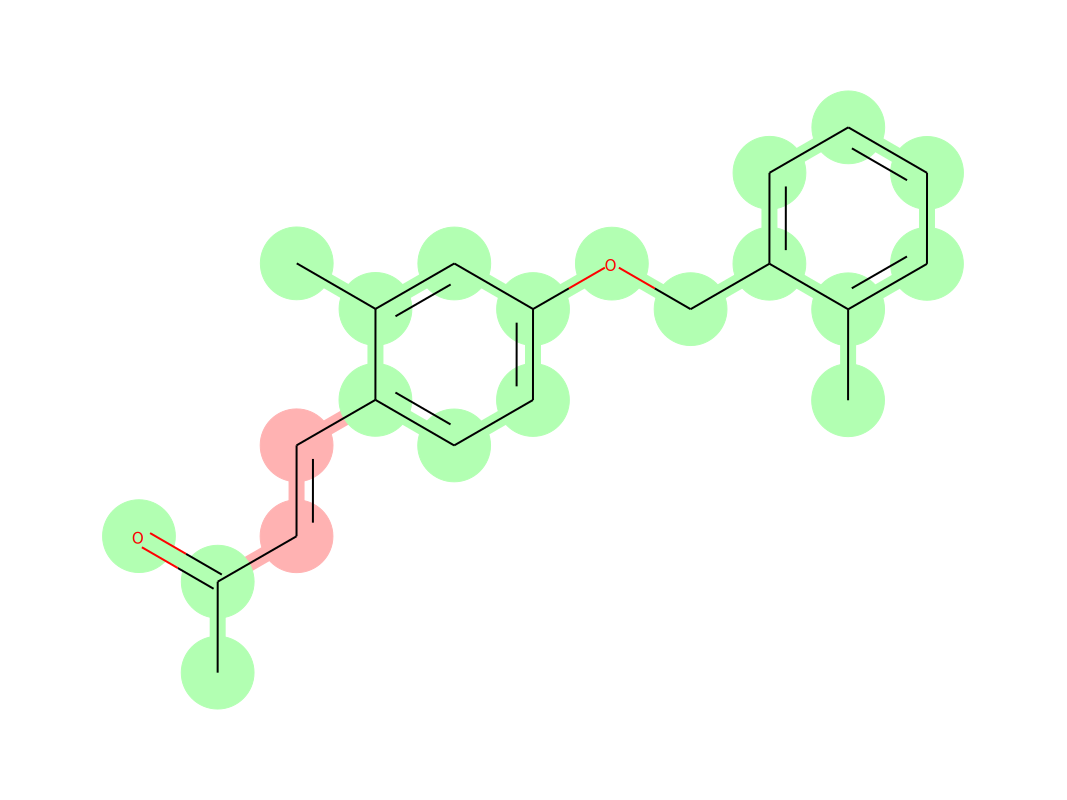

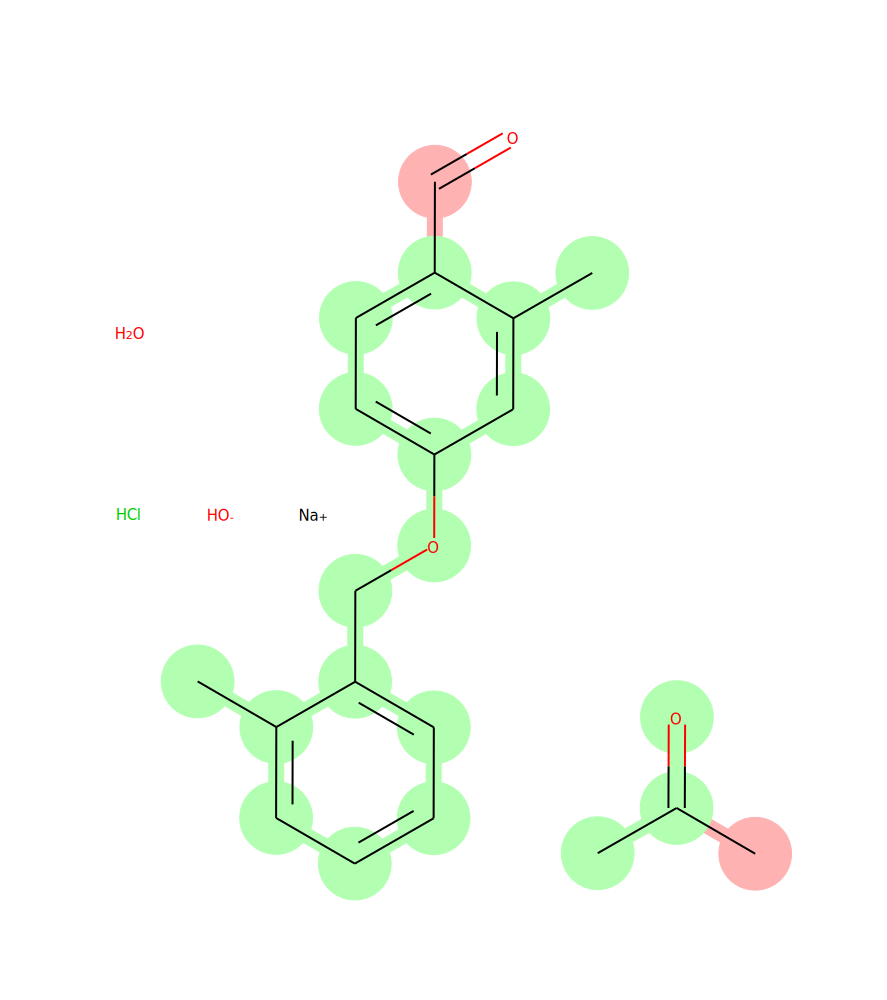

New center
25272
0.35417405


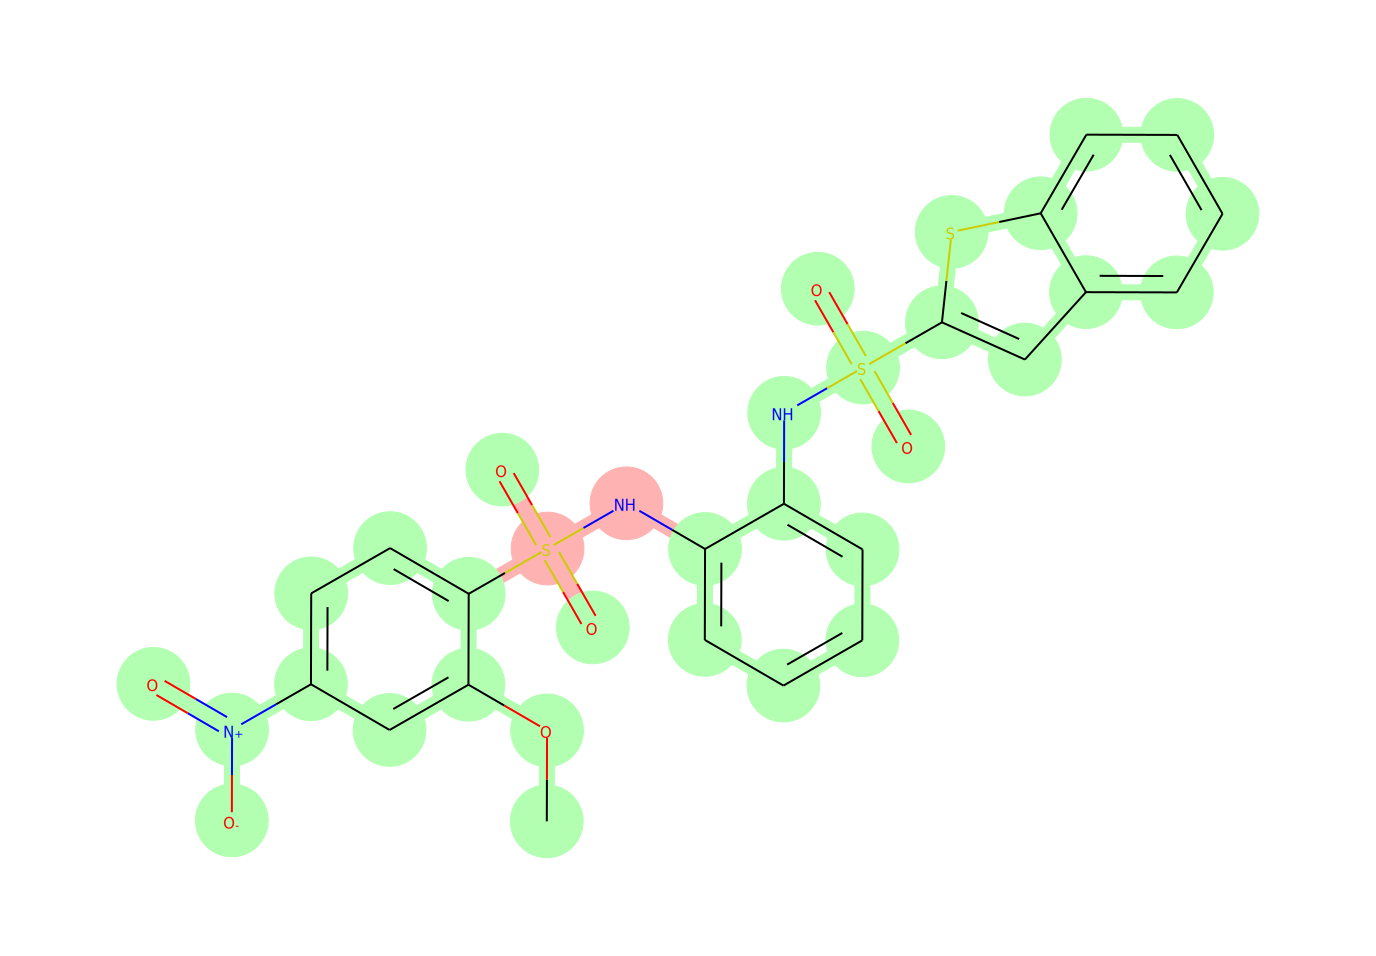

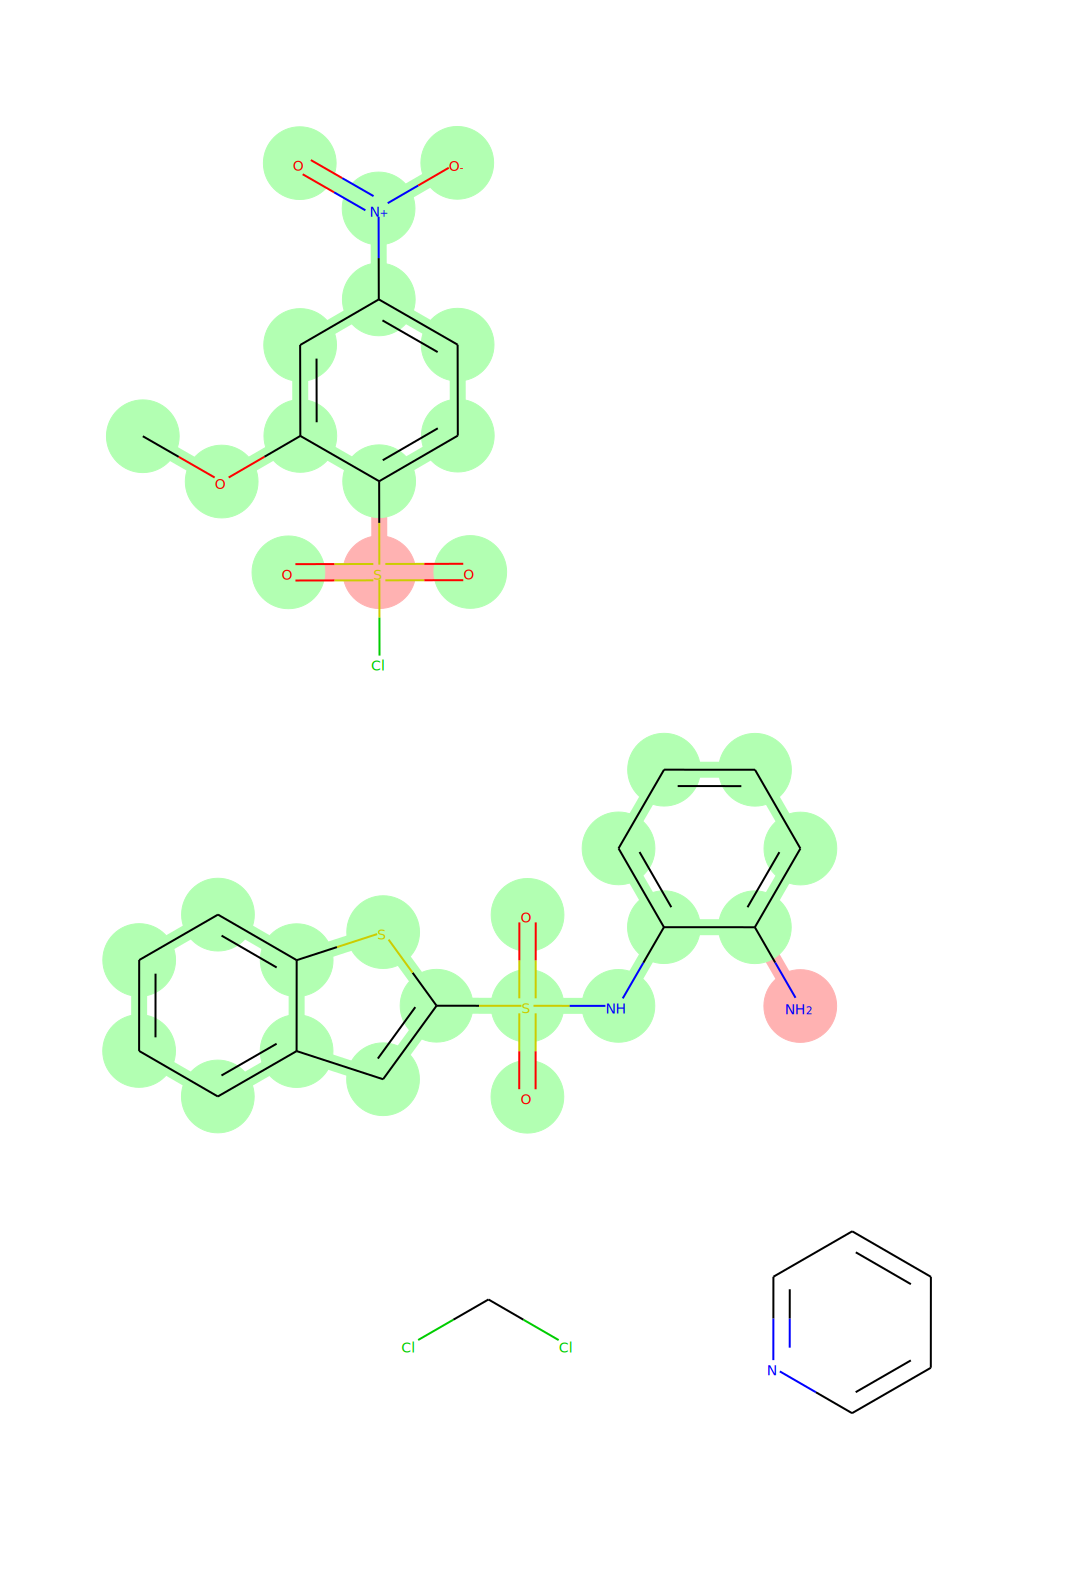

11336
0.3636015


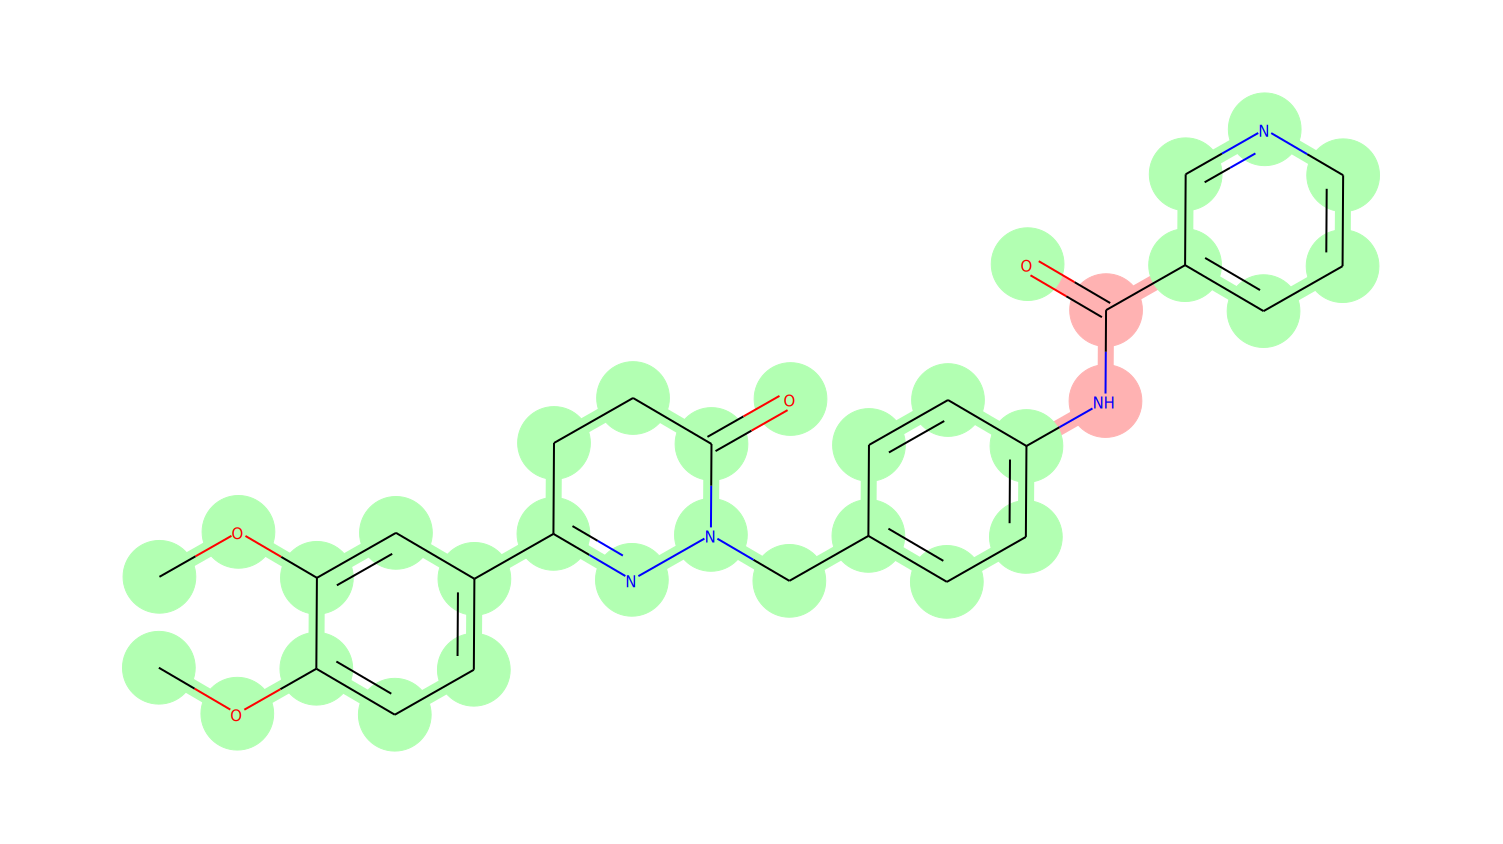

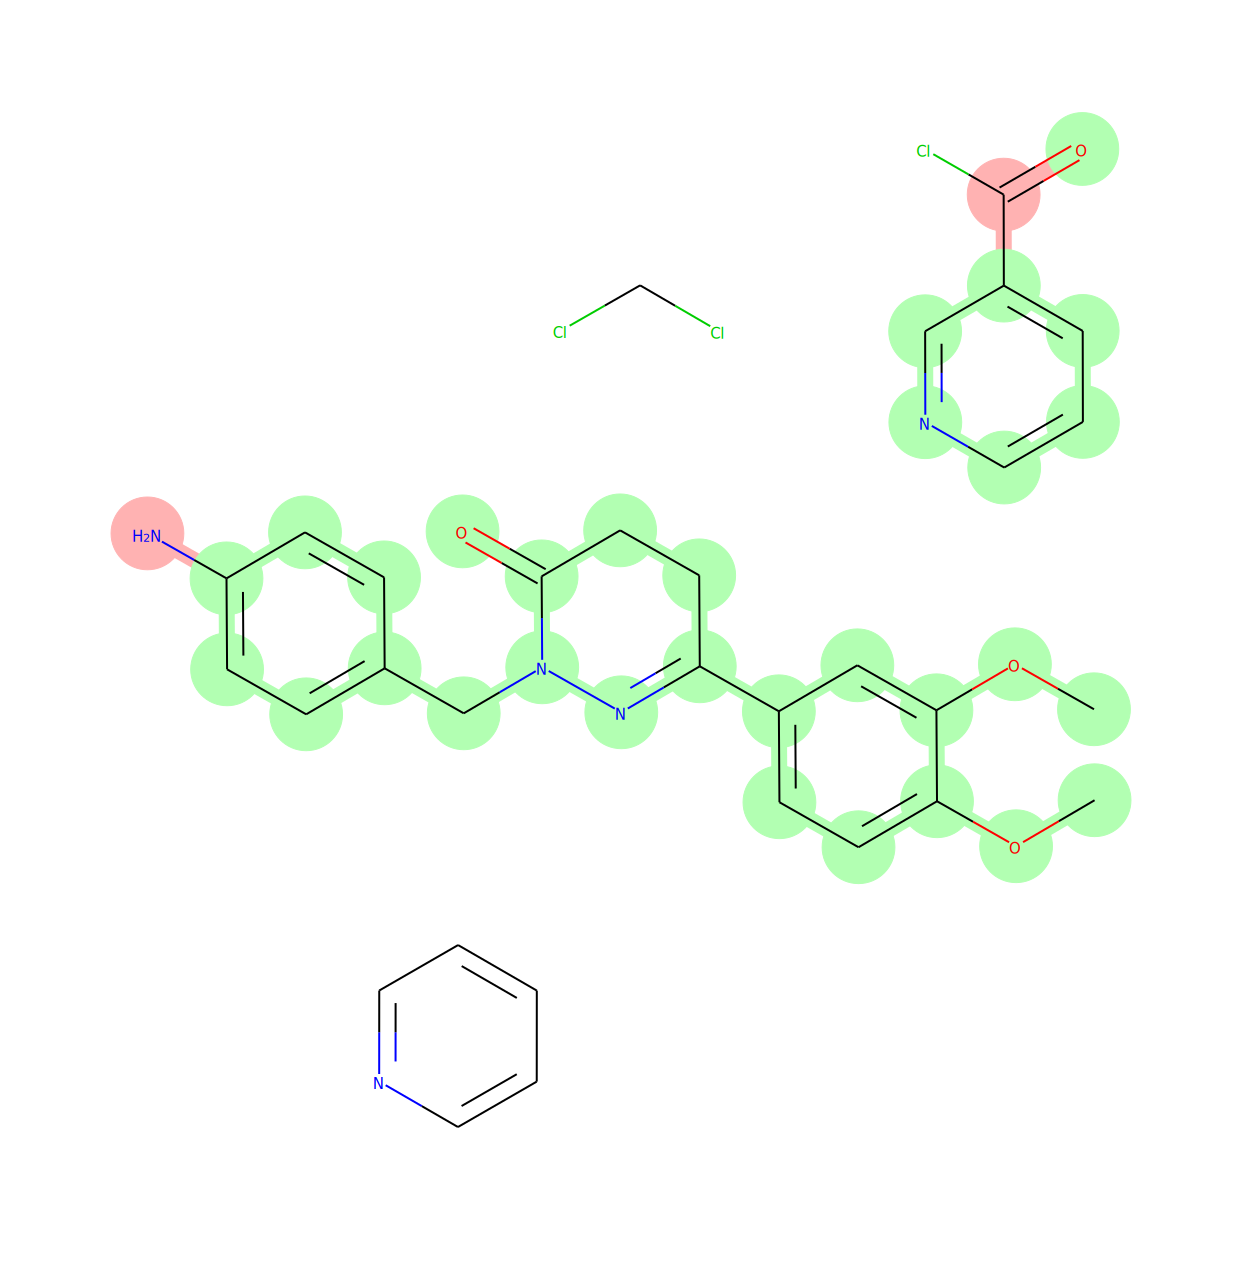

48796
0.37498853


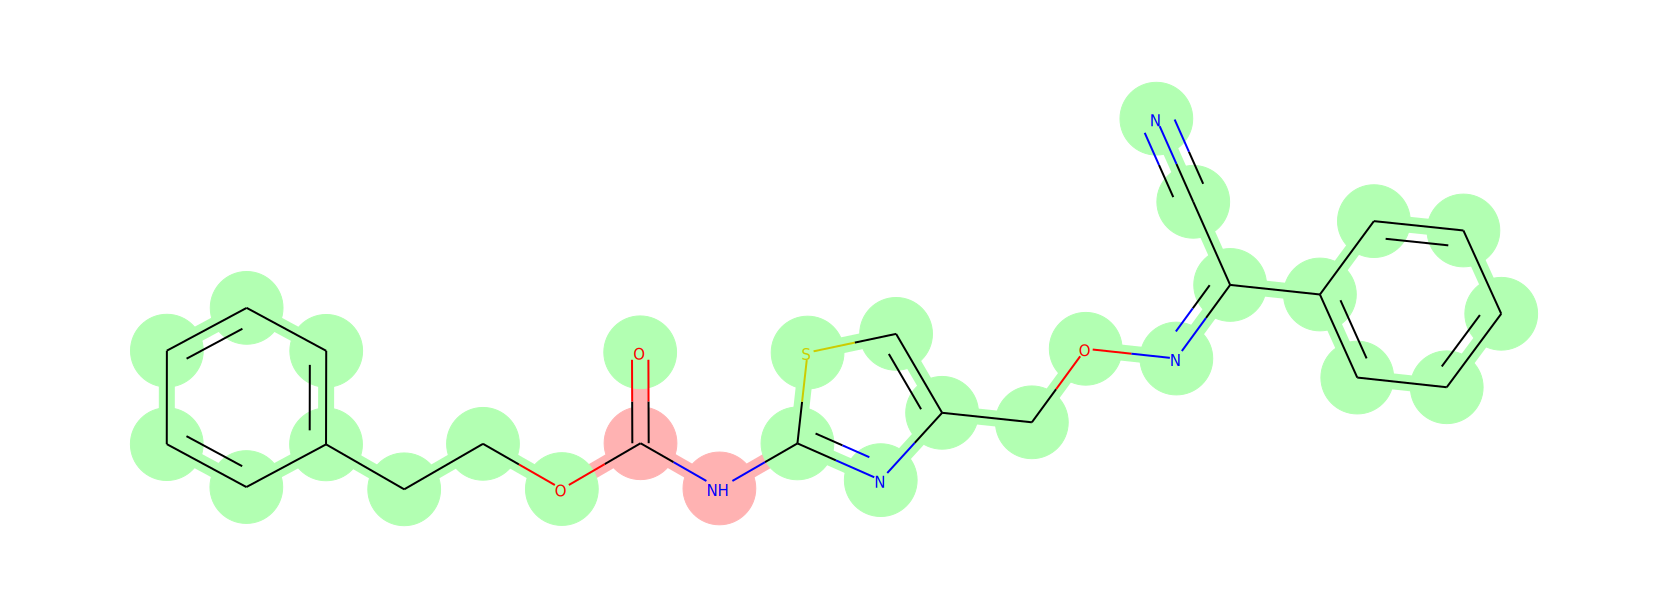

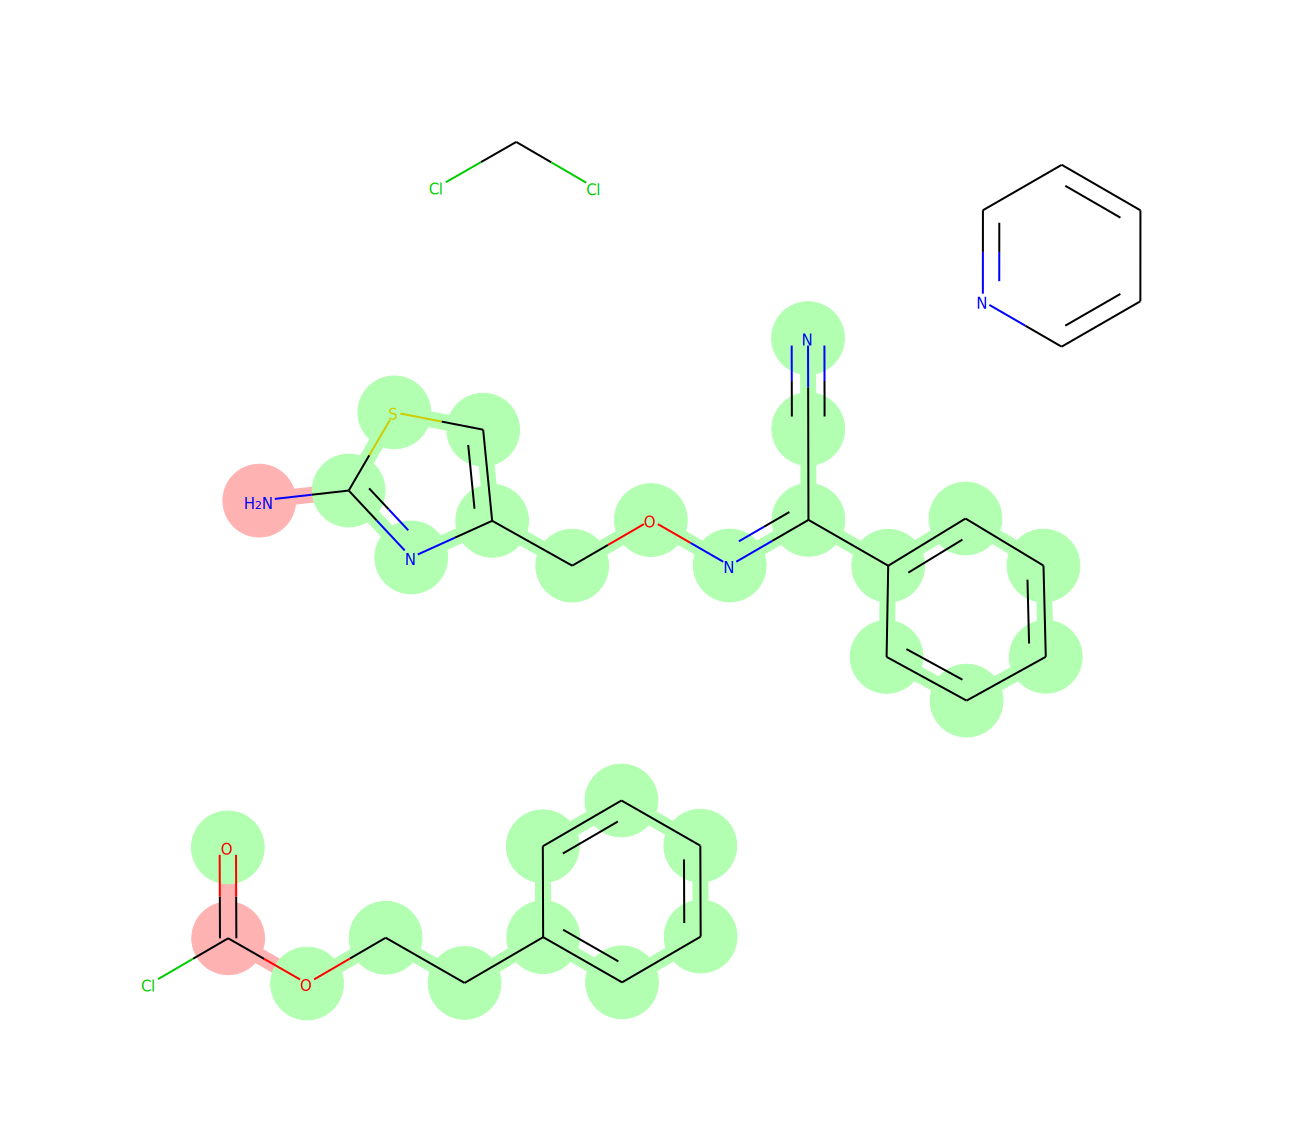

14058
0.5484965


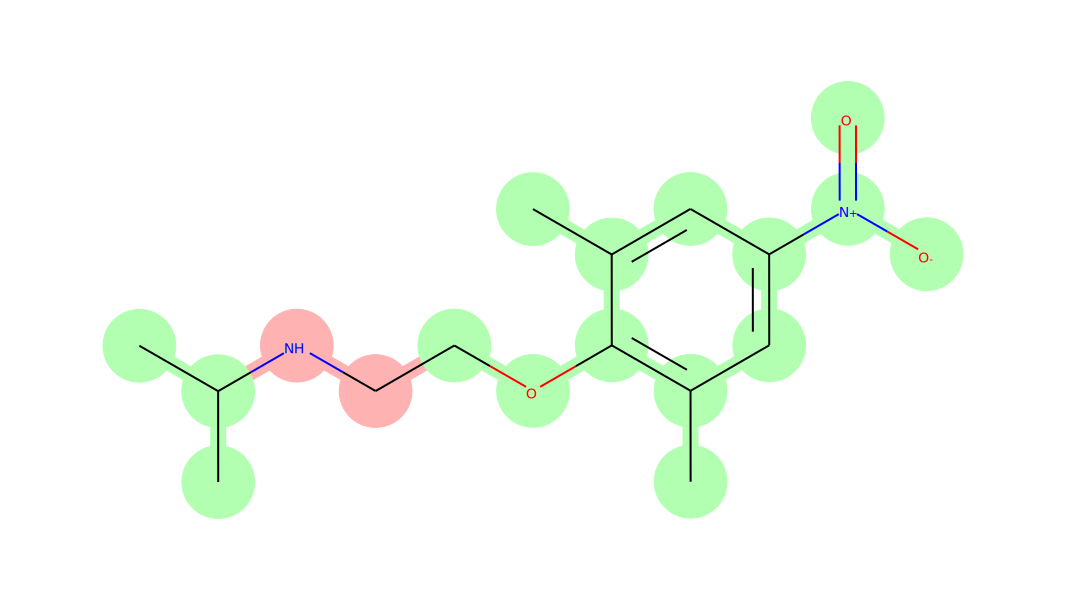

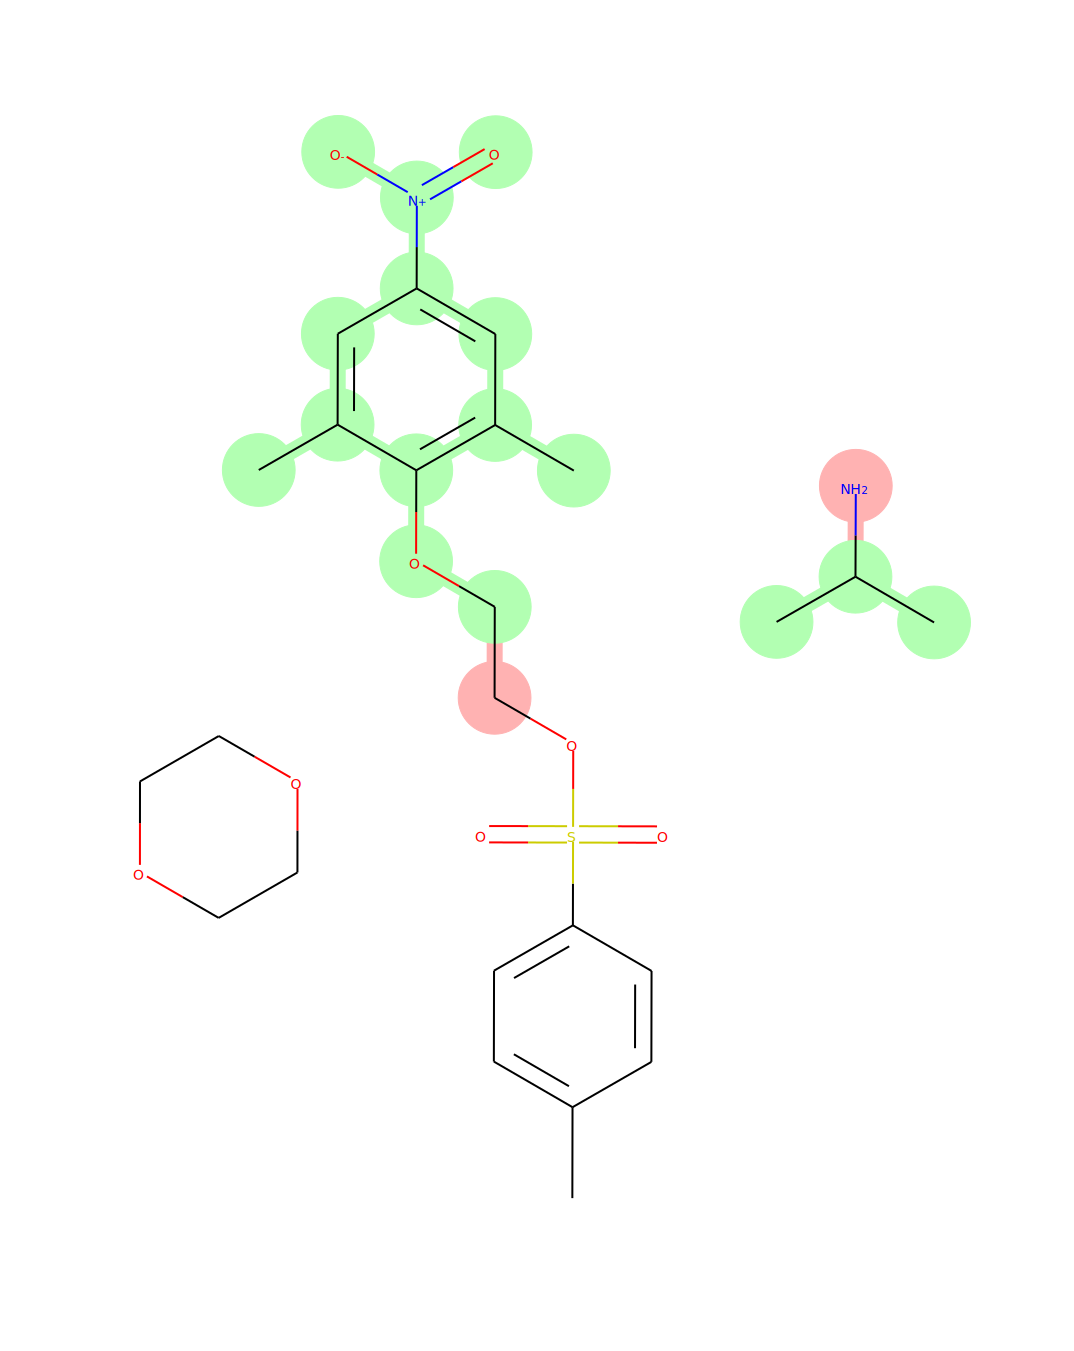

45544
2.1991026


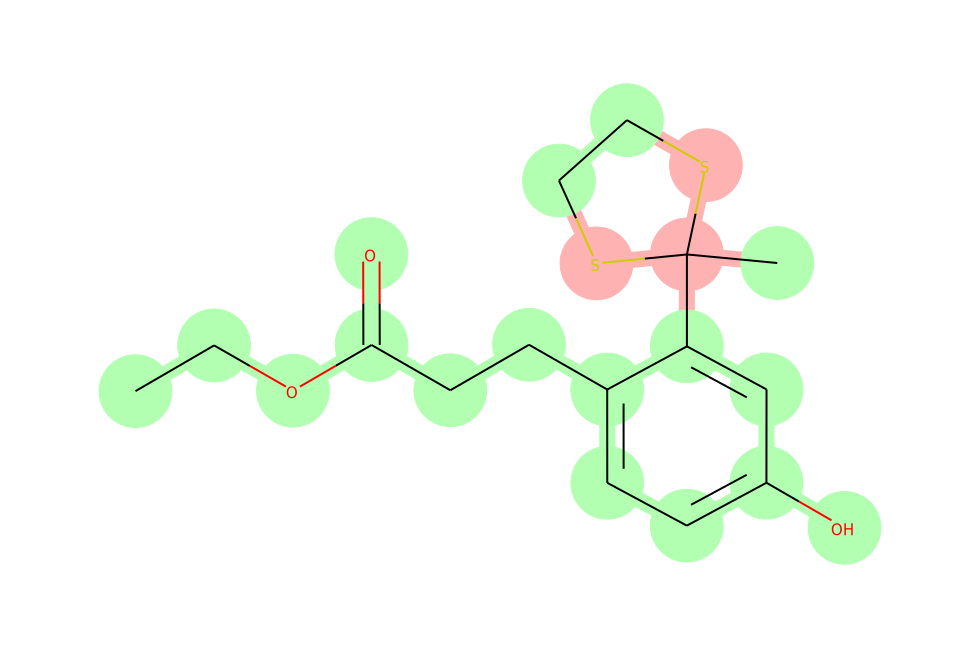

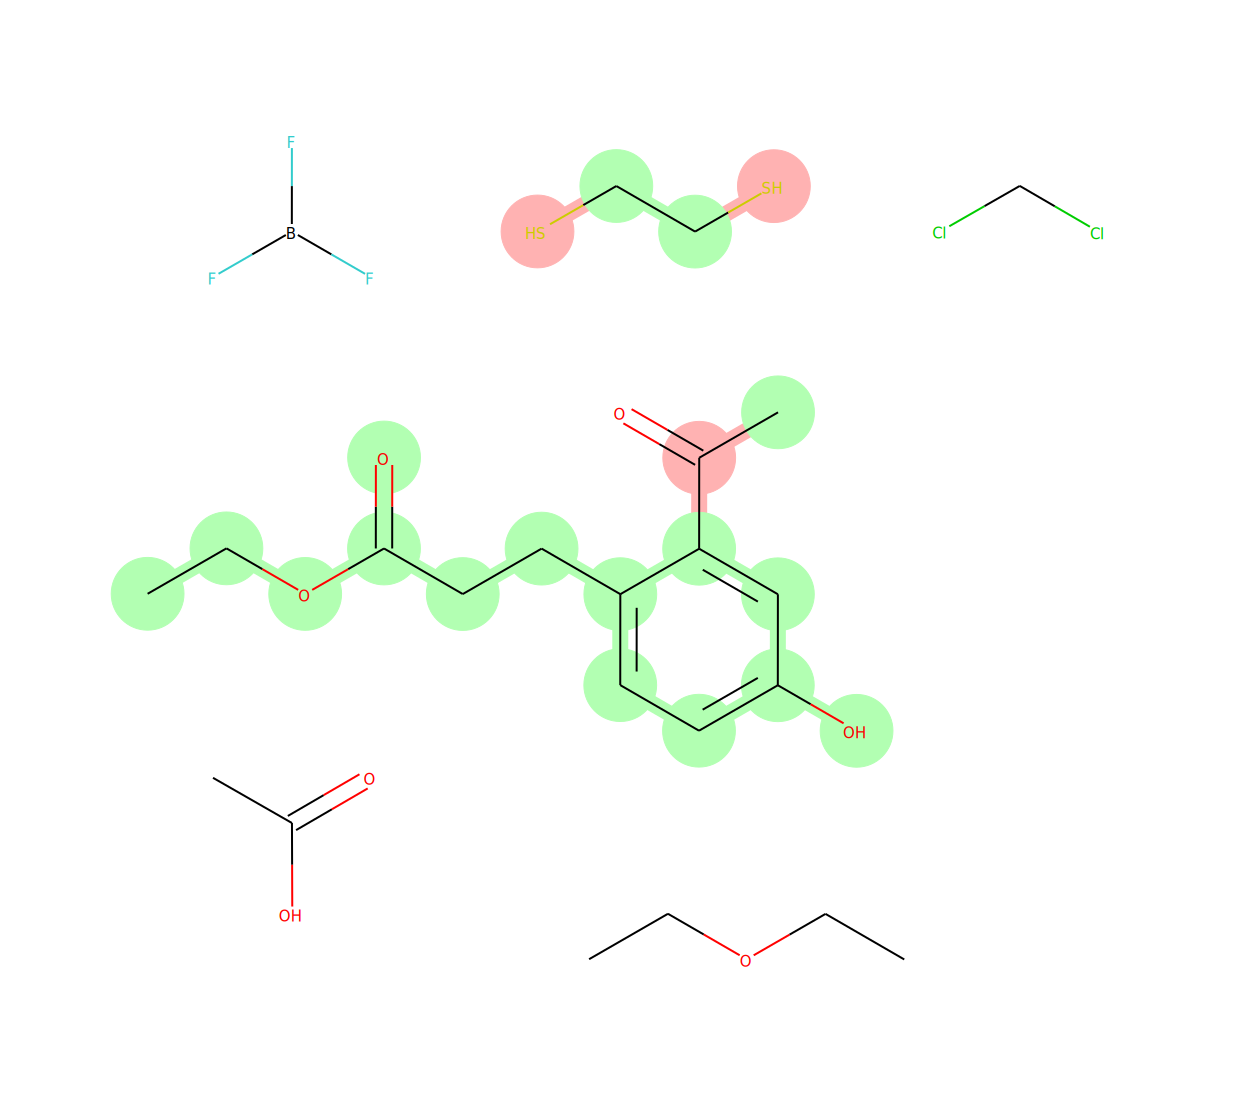

In [27]:
for center in centers:
    print('New center')
    norms = []
    for r in reac_reps:
        norms.append(np.linalg.norm(r - center))
    norms = np.array(norms)
    idxs = np.argsort(norms)
    show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 10000]])

In [28]:
idxs = [0, 102, 31514]#0, 88, 23890

In [32]:
norm_reac_reps = (reac_reps.T / reac_reps.sum(axis=-1)).T

0
0.0


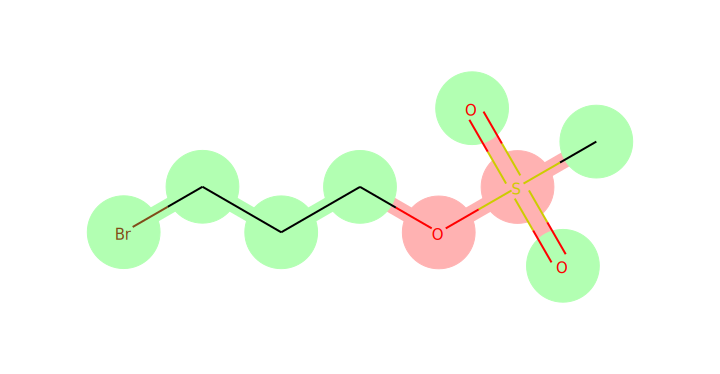

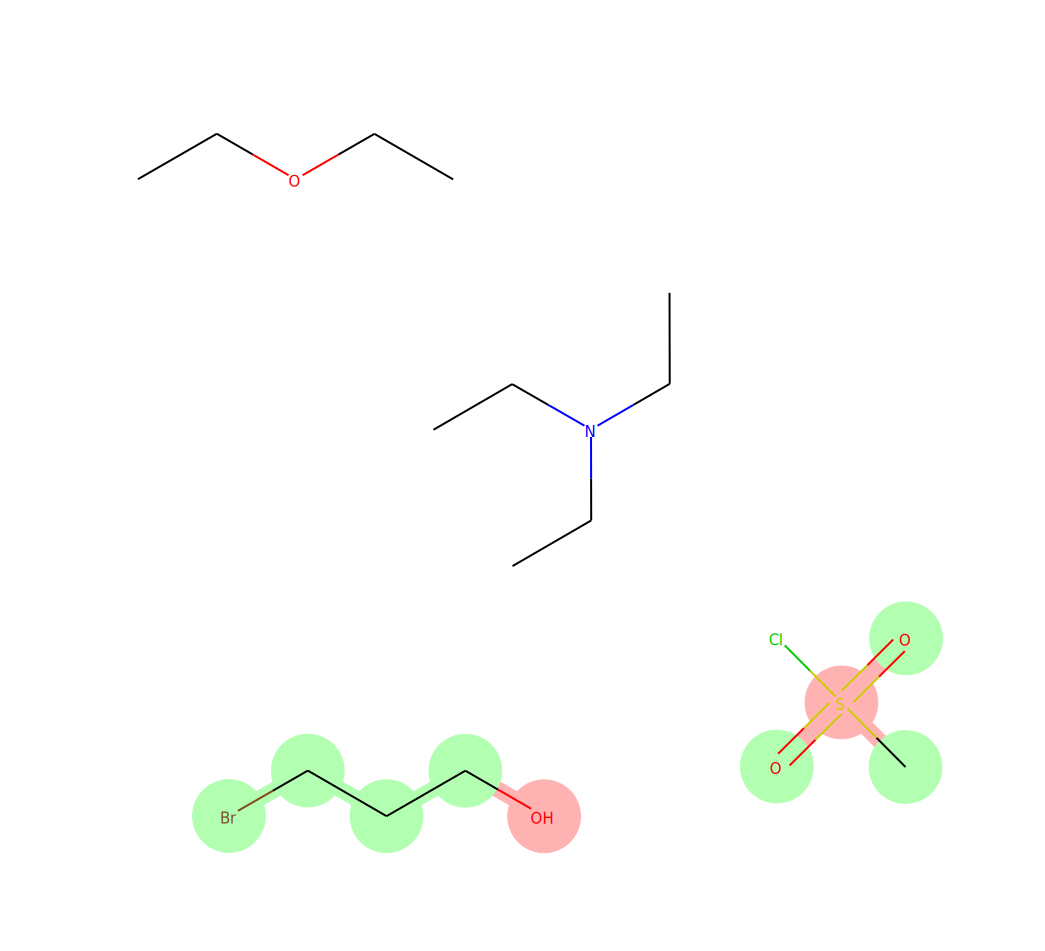

1847
0.010973646


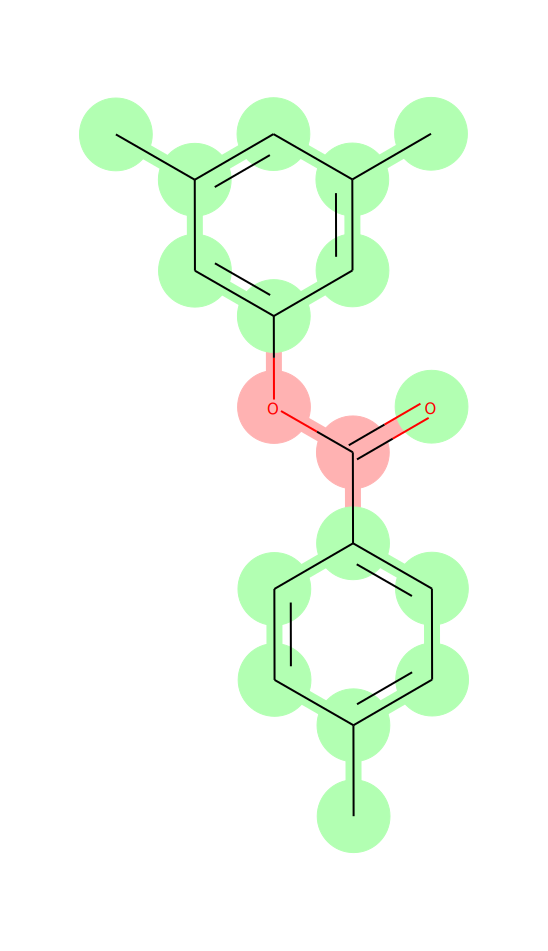

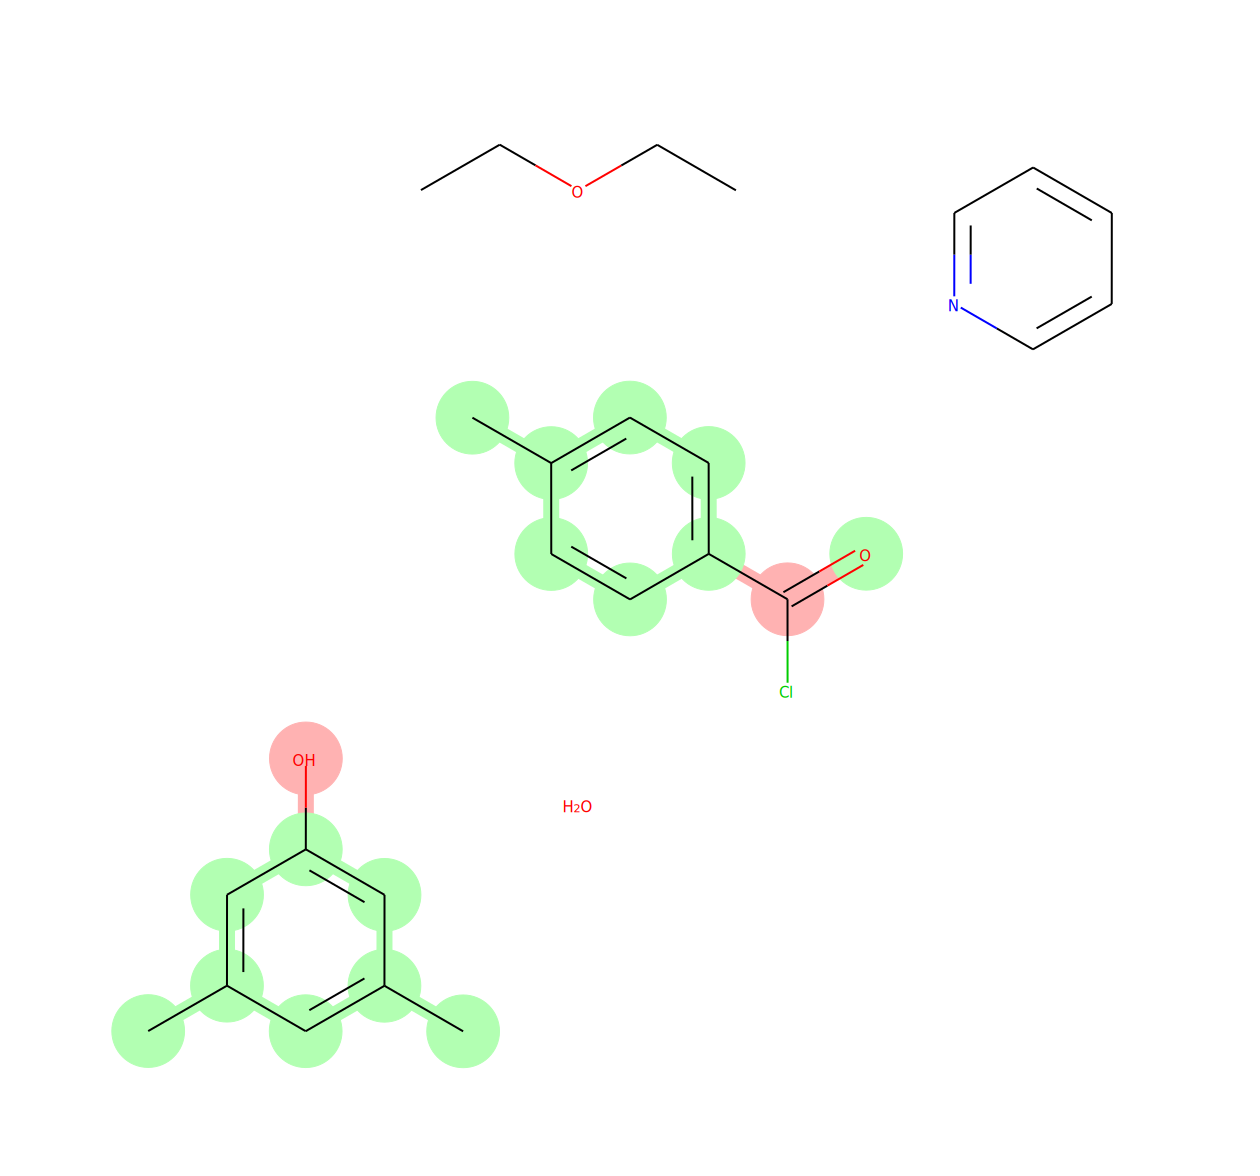

3007
0.012856478


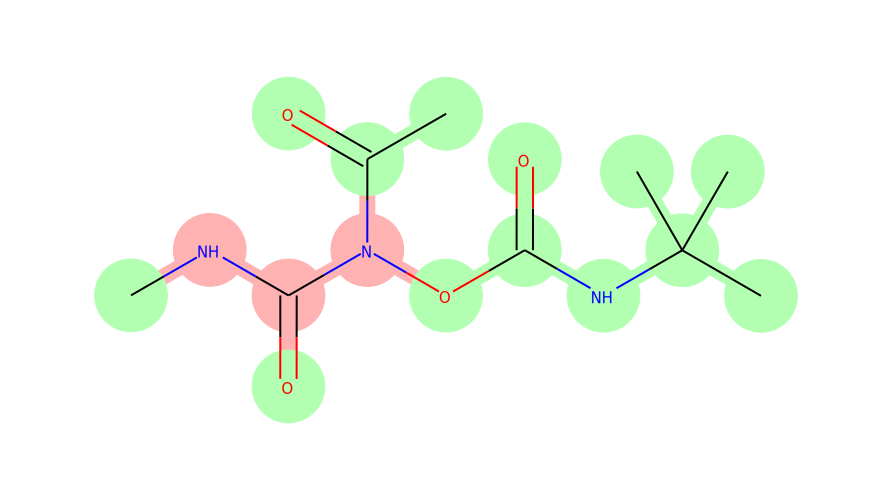

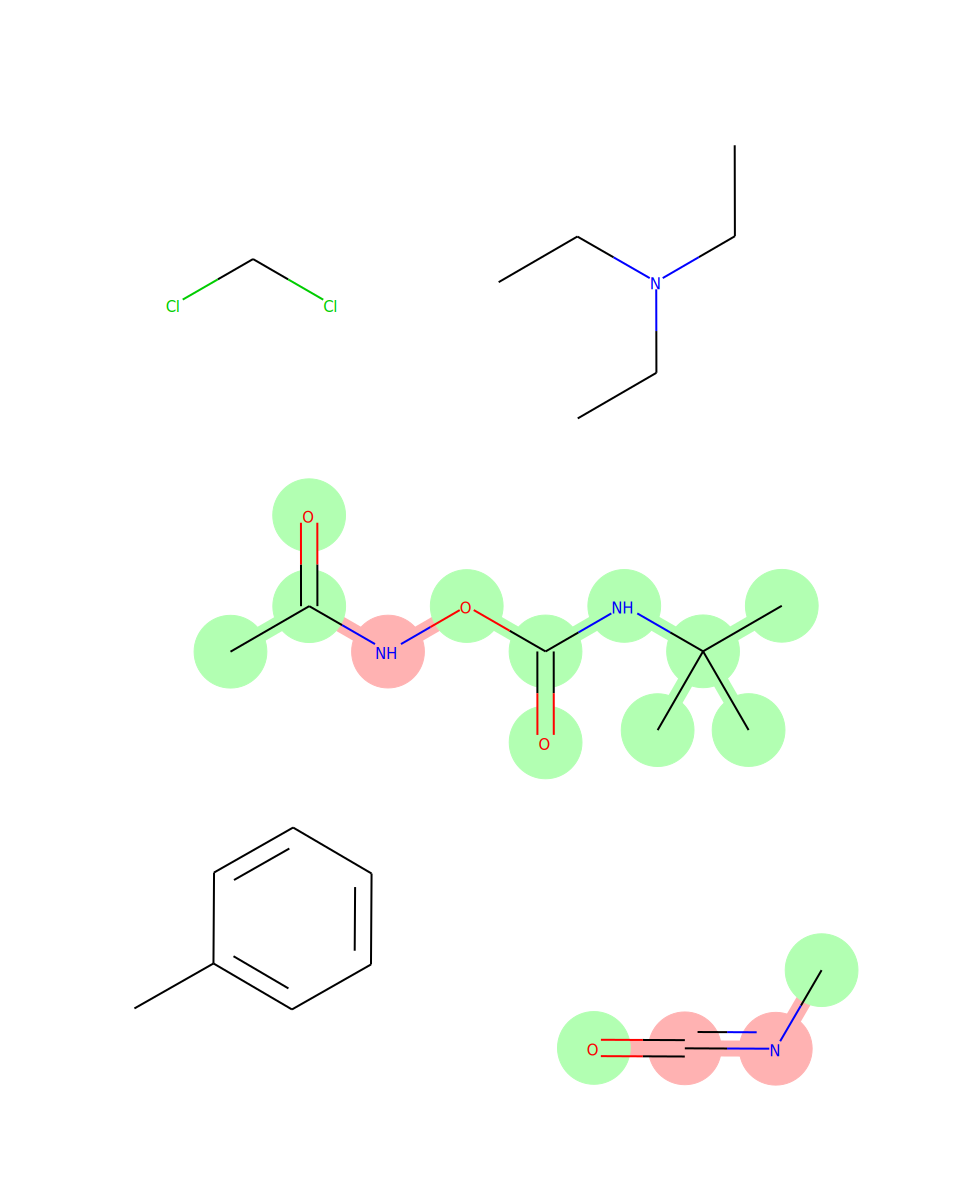

1051
0.017781928


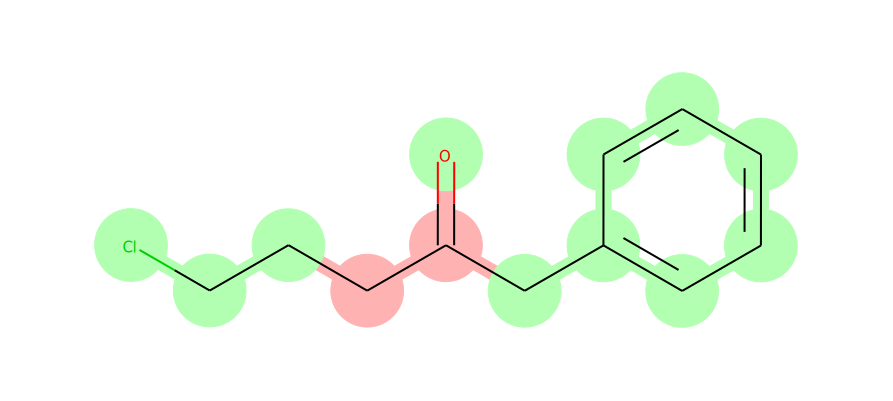

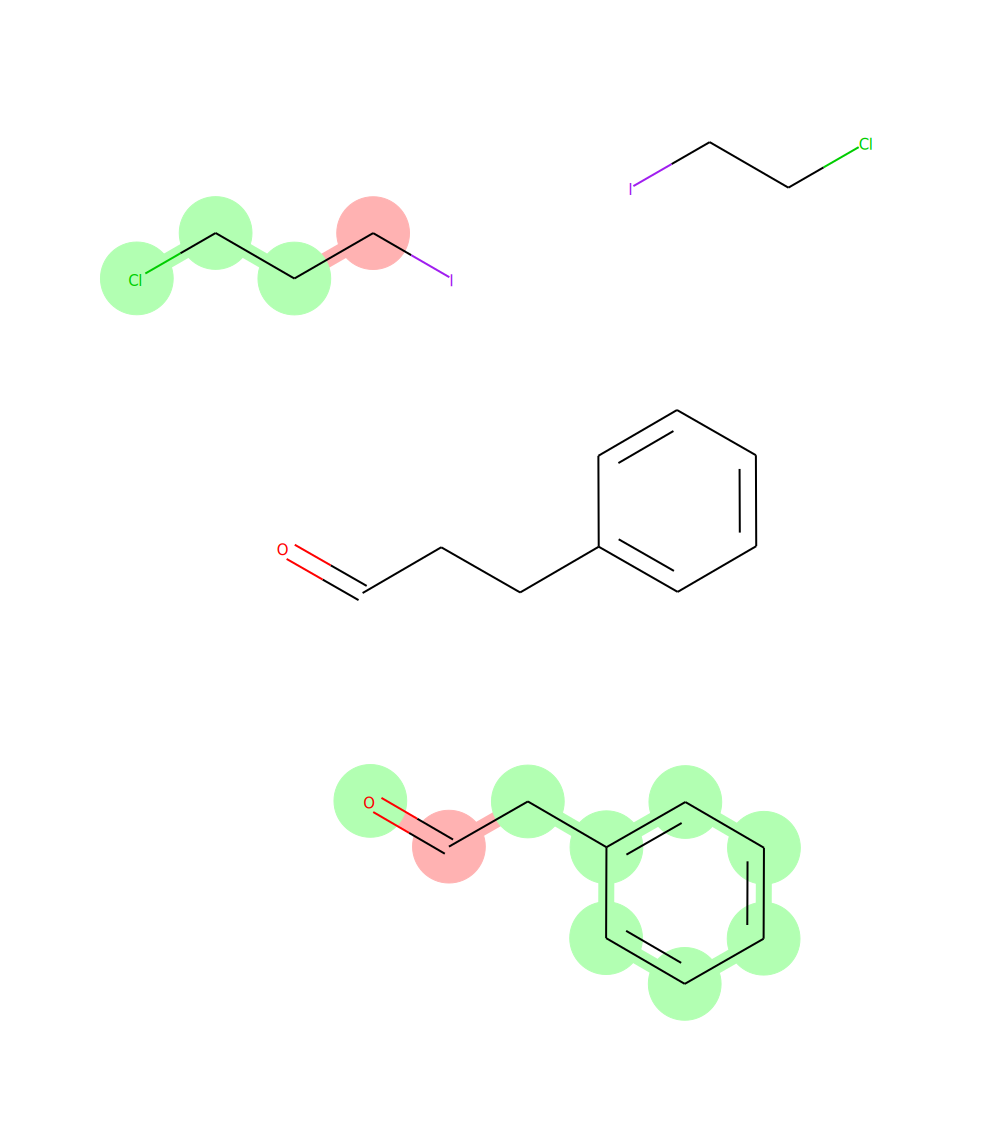

37238
0.04916422


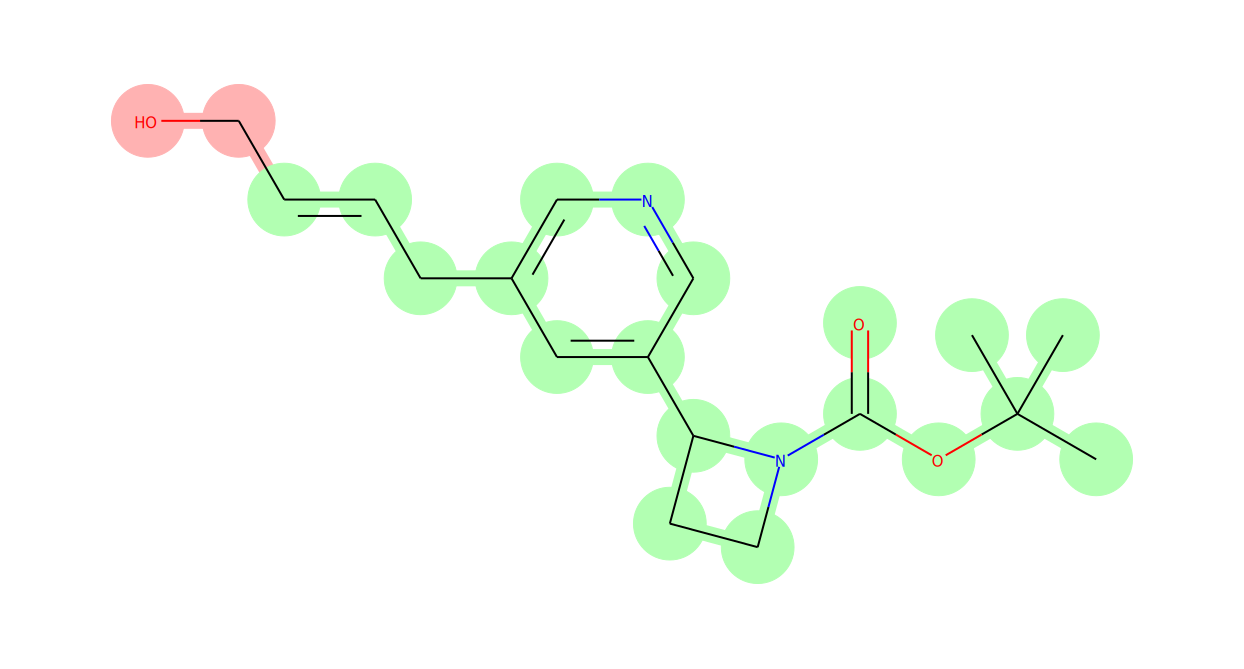

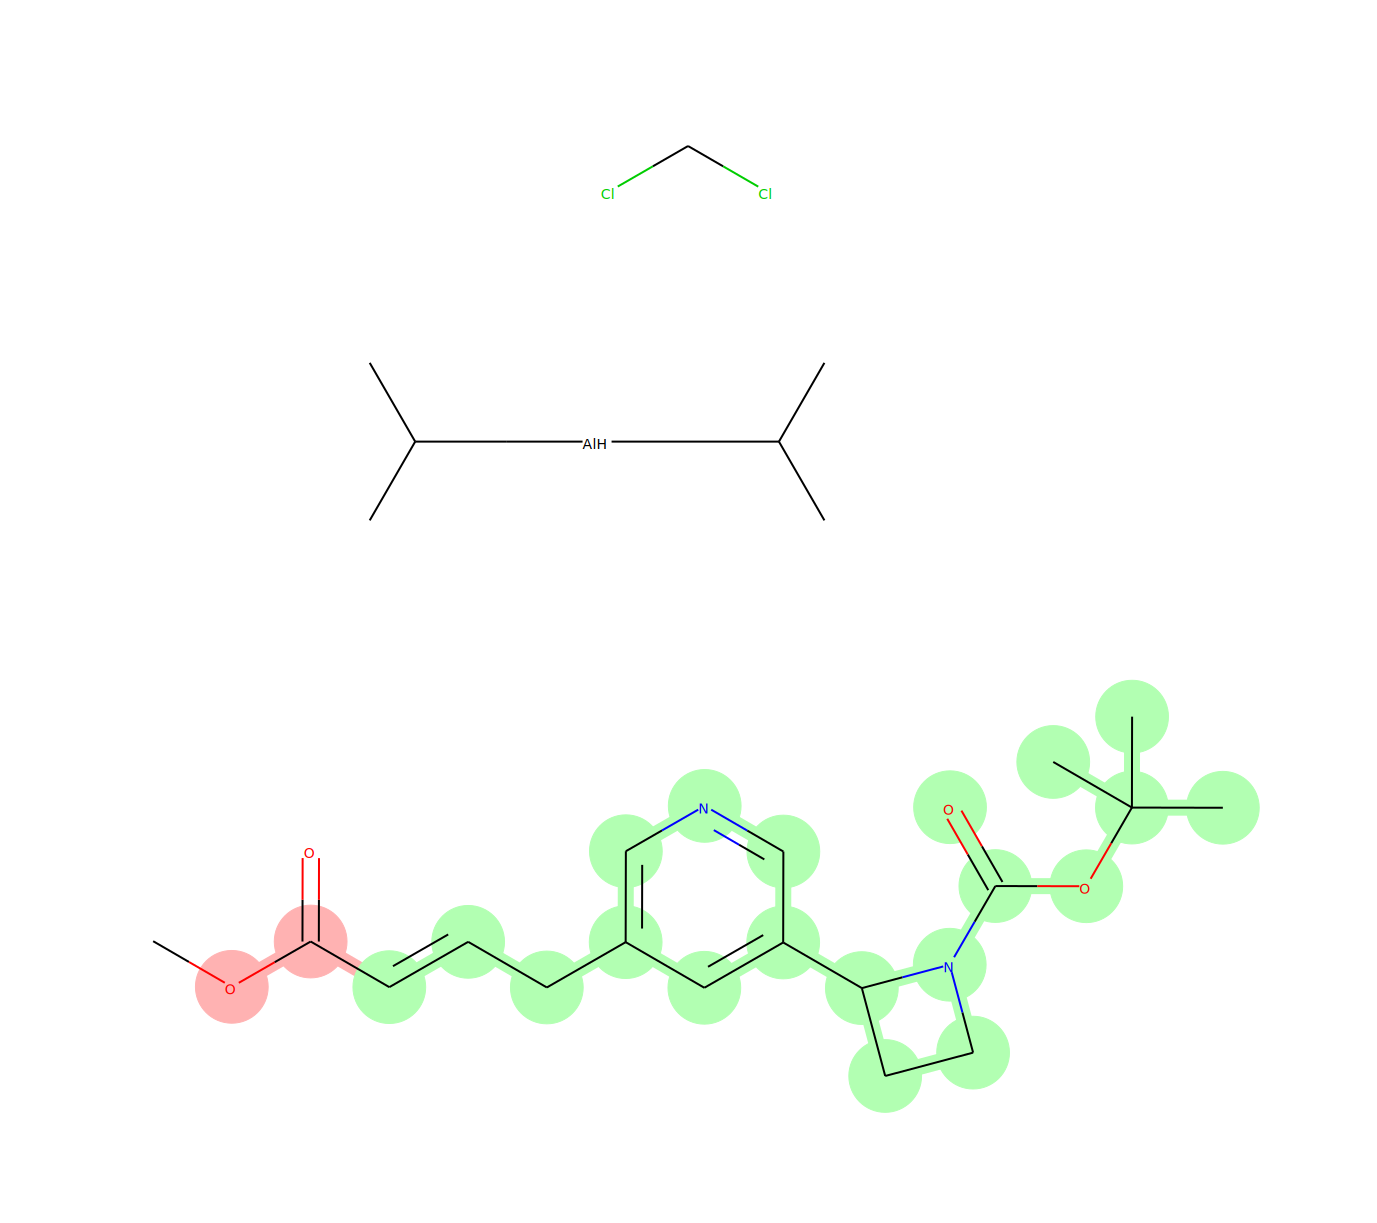

In [33]:
idx = 0
norms = np.linalg.norm(norm_reac_reps - norm_reac_reps[idx], axis=-1)
norms = np.array(norms)
idxs = np.argsort(norms)
show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 5002]])